In [1]:
'''Trains CGAN on MNIST using Keras
CGAN is Conditional Generative Adversarial Nets.
This version of CGAN is similar to DCGAN. The difference mainly
is that the z-vector of geneerator is conditioned by a one-hot label
to produce specific fake images. The discriminator is trained to
discriminate real from fake images that are conditioned on
specific one-hot labels.
[1] Radford, Alec, Luke Metz, and Soumith Chintala.
"Unsupervised representation learning with deep convolutional
generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).
[2] Mirza, Mehdi, and Simon Osindero. "Conditional generative
adversarial nets." arXiv preprint arXiv:1411.1784 (2014).
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers.merge import concatenate
from keras.optimizers import RMSprop
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import load_model

import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Load data

In [72]:
# load MNIST dataset
(x_train, y_train), (_, _) = mnist.load_data()

# reshape data for CNN as (28, 28, 1) and normalize
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255

num_labels = np.amax(y_train) + 1
y_train = to_categorical(y_train)

model_name = "cgan_mnist"

### Define Generator

In [69]:
def build_generator(inputs, labels, image_size):
    """Build a Generator Model
    Inputs are concatenated before Dense layer.
    Stack of BN-ReLU-Conv2DTranpose to generate fake images.
    Output activation is sigmoid instead of tanh in orig DCGAN.
    Sigmoid converges easily.
    # Arguments
        inputs (Layer): Input layer of the generator (the z-vector)
        labels (Layer): Input layer for one-hot vector to condition
            the inputs
        image_size: Target size of one side (assuming square image)
    # Returns
        Model: Generator Model
    """
    image_resize = image_size // 4
    # network parameters
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    x = concatenate([inputs, labels], axis=1)
    x = Dense(image_resize * image_resize * layer_filters[0])(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)

    x = Activation('sigmoid')(x)
    # input is conditioned by labels
    generator = Model([inputs, labels], x, name='generator')
    return generator

### Define discriminator

In [70]:
def build_discriminator(inputs, labels, image_size):
    """Build a Discriminator Model
    Inputs are concatenated after Dense layer.
    Stack of LeakyReLU-Conv2D to discriminate real from fake.
    The network does not converge with BN so it is not used here
    unlike in DCGAN paper.
    # Arguments
        inputs (Layer): Input layer of the discriminator (the image)
        labels (Layer): Input layer for one-hot vector to condition
            the inputs
        image_size: Target size of one side (assuming square image)
    # Returns
        Model: Discriminator Model
    """
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs

    y = Dense(image_size * image_size)(labels)
    y = Reshape((image_size, image_size, 1))(y)
    x = concatenate([x, y])

    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    # input is conditioned by labels
    discriminator = Model([inputs, labels], x, name='discriminator')
    return discriminator

### Define plot util function

In [83]:
def plot_images(generator,
                noise_input,
                noise_class,
                show=False,
                step=0,
                model_name="gan"):
    """Generate fake images and plot them
    For visualization purposes, generate fake images
    then plot them in a square grid
    # Arguments
        generator (Model): The Generator Model for fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name
    """
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict([noise_input, noise_class])
    print(model_name , " labels for generated images: ", np.argmax(noise_class, axis=1))
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
    plt.savefig(filename)
    
    if show:
        plt.show()
    else:
        plt.close('all')

### Build CGAN Model

In [73]:
model_name = "cgan_mnist"
# network parameters
# the latent or z vector is 100-dim
latent_size = 100
batch_size = 64
train_steps = 40000
lr = 2e-4
decay = 6e-8
input_shape = (image_size, image_size, 1)
label_shape = (num_labels, )

In [74]:
# build discriminator model
inputs = Input(shape=input_shape, name='discriminator_input')
labels = Input(shape=label_shape, name='class_labels')

discriminator = build_discriminator(inputs, labels, image_size)
# [1] or original paper uses Adam, 
# but discriminator converges easily with RMSprop
optimizer = RMSprop(lr=lr, decay=decay)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
class_labels (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 784)          8624        class_labels[0][0]               
__________________________________________________________________________________________________
discriminator_input (InputLayer (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           dense_1[0][0]                    
__________________________________________________________________________________________________
concatenat

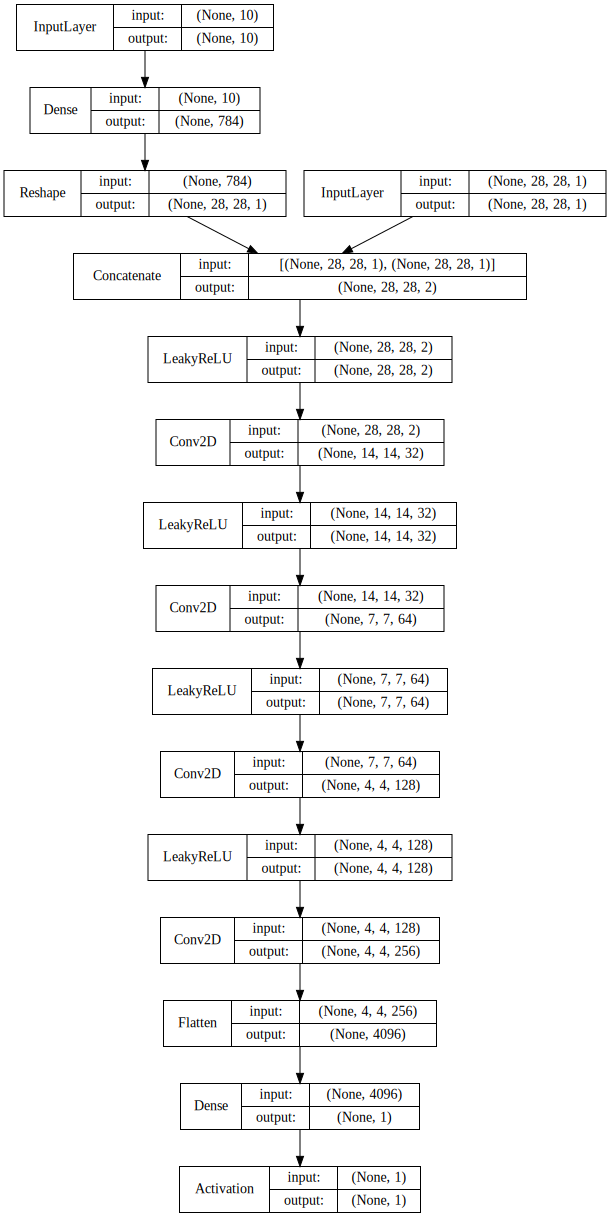

In [75]:
#  Display Model in Jupyter notebook

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def plot_keras_model(model,show_shapes=True,show_layer_names=True):
    return SVG(model_to_dot(model,show_shapes=show_shapes,show_layer_names=show_layer_names).create(prog='dot',format='svg'))

plot_keras_model(discriminator, show_shapes=True, show_layer_names=False)

In [76]:
# build generator model
input_shape = (latent_size, )
inputs = Input(shape=input_shape, name='z_input')
generator = build_generator(inputs, labels, image_size)
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_input (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
class_labels (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 110)          0           z_input[0][0]                    
                                                                 class_labels[0][0]               
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 6272)         696192      concatenate_2[0][0]              
__________

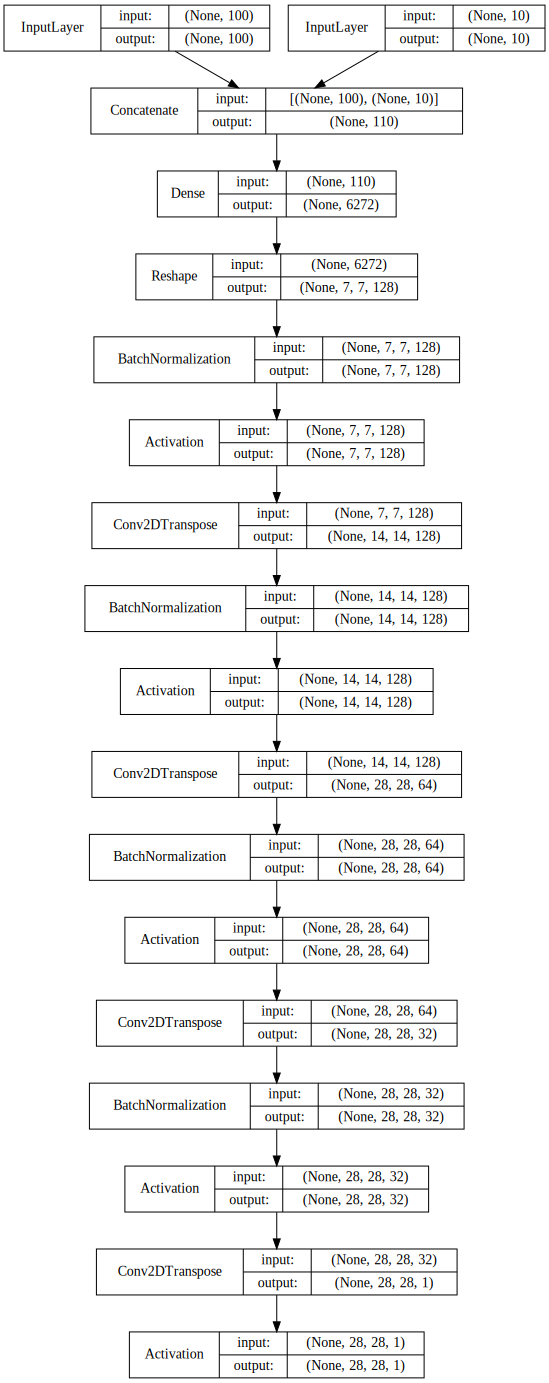

In [77]:
plot_keras_model(generator, show_shapes=True, show_layer_names=False)

In [78]:
# build adversarial model = generator + discriminator
optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)

# freeze the weights of discriminator during adversarial training
discriminator.trainable = False

outputs = discriminator([generator([inputs, labels]), labels])
adversarial = Model([inputs, labels],
                    outputs,
                    name=model_name)

adversarial.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])

adversarial.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_input (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
class_labels (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 28, 28, 1)    1364225     z_input[0][0]                    
                                                                 class_labels[0][0]               
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            1090001     generator[1][0]                  
          

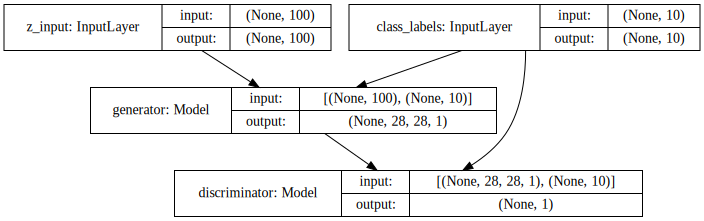

In [81]:
plot_keras_model(adversarial, show_shapes=True, show_layer_names=True)

### Define train() function

In [84]:
def train(models, data, params):
    """Train the Discriminator and Adversarial Networks
    Alternately train Discriminator and Adversarial networks by batch.
    Discriminator is trained first with properly labelled real and fake images.
    Adversarial is trained next with fake images pretending to be real.
    Discriminator inputs are conditioned by train labels for real images,
    and random labels for fake images.
    Adversarial inputs are conditioned by random labels.
    Generate sample images per save_interval.
    # Arguments
        models (list): Generator, Discriminator, Adversarial models
        data (list): x_train, y_train data
        params (list): Network parameters
    """
    # the GAN models
    generator, discriminator, adversarial = models
    
    # images and labels
    x_train, y_train = data
    
    # network parameters
    batch_size, latent_size, train_steps, num_labels, model_name = params
    
    # the generator image is saved every 500 steps
    save_interval = 500
    
    # noise vector to see how the generator output evolves during training
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    
    # one-hot label the noise will be conditioned to
    noise_class = np.eye(num_labels)[np.arange(0, 16) % num_labels]
    
    # number of elements in train dataset
    train_size = x_train.shape[0]

    print(model_name,
          "Labels for generated images: ",
          np.argmax(noise_class, axis=1))

    for i in range(train_steps):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images from dataset
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        
        # corresponding one-hot labels of real images
        real_labels = y_train[rand_indexes]
        
        # generate fake images from noise using generator
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        
        # assign random one-hot labels
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,batch_size)]

        # generate fake images conditioned on fake labels
        fake_images = generator.predict([noise, fake_labels])
        
        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))
        # real + fake one-hot labels = 1 batch of train one-hot labels
        labels = np.concatenate((real_labels, fake_labels))

        # label real and fake images
        # real images label is 1.0
        y = np.ones([2 * batch_size, 1])
        
        # fake images label is 0.0
        y[batch_size:, :] = 0.0
        
        # train discriminator network, log the loss and accuracy
        loss, acc = discriminator.train_on_batch([x, labels], y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        # train the adversarial network for 1 batch
        # 1 batch of fake images conditioned on fake 1-hot labels w/ label=1.0
        # since the discriminator weights are frozen in adversarial network
        # only the generator is trained
        # generate noise using uniform distribution        
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        
        # assign random one-hot labels
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,batch_size)]
        
        # label fake images as real or 1.0
        y = np.ones([batch_size, 1])
        
        # train the adversarial network 
        # note that unlike in discriminator training, 
        # we do not save the fake images in a variable
        # the fake images go to the discriminator input of the adversarial
        # for classification
        # log the loss and accuracy
        loss, acc = adversarial.train_on_batch([noise, fake_labels], y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            if (i + 1) == train_steps:
                show = True
            else:
                show = False

            # plot generator images on a periodic basis
            plot_images(generator,
                        noise_input=noise_input,
                        noise_class=noise_class,
                        show=show,
                        step=(i + 1),
                        model_name=model_name)
    
    # save the model after training the generator
    # the trained generator can be reloaded for future MNIST digit generation
    generator.save(model_name + ".h5")

### Train model

cgan_mnist Labels for generated images:  [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [discriminator loss: 0.690081, acc: 0.648438] [adversarial loss: 1.010233, acc: 0.000000]
1: [discriminator loss: 0.630351, acc: 0.656250] [adversarial loss: 1.180535, acc: 0.000000]
2: [discriminator loss: 0.514419, acc: 0.992188] [adversarial loss: 1.940939, acc: 0.000000]
3: [discriminator loss: 0.411527, acc: 0.929688] [adversarial loss: 1.445219, acc: 0.000000]
4: [discriminator loss: 0.303120, acc: 1.000000] [adversarial loss: 3.831052, acc: 0.000000]
5: [discriminator loss: 0.342727, acc: 0.835938] [adversarial loss: 1.454732, acc: 0.000000]
6: [discriminator loss: 0.166030, acc: 1.000000] [adversarial loss: 2.468065, acc: 0.000000]
7: [discriminator loss: 0.132351, acc: 1.000000] [adversarial loss: 1.412860, acc: 0.000000]
8: [discriminator loss: 0.077310, acc: 1.000000] [adversarial loss: 1.360995, acc: 0.000000]
9: [discriminator loss: 0.048617, acc: 1.000000] [adversarial loss: 0.826484, acc: 0.093750]
10: [discriminator loss: 0.033856, acc: 1.000000] [adversarial loss: 0

94: [discriminator loss: 0.586332, acc: 0.632812] [adversarial loss: 0.610076, acc: 0.718750]
95: [discriminator loss: 0.631294, acc: 0.500000] [adversarial loss: 2.207062, acc: 0.000000]
96: [discriminator loss: 0.411939, acc: 0.875000] [adversarial loss: 1.005653, acc: 0.093750]
97: [discriminator loss: 0.399832, acc: 0.804688] [adversarial loss: 2.115333, acc: 0.000000]
98: [discriminator loss: 0.374406, acc: 0.875000] [adversarial loss: 0.989581, acc: 0.156250]
99: [discriminator loss: 0.399934, acc: 0.835938] [adversarial loss: 2.071534, acc: 0.000000]
100: [discriminator loss: 0.376305, acc: 0.890625] [adversarial loss: 0.883226, acc: 0.203125]
101: [discriminator loss: 0.441120, acc: 0.750000] [adversarial loss: 2.770410, acc: 0.000000]
102: [discriminator loss: 0.441153, acc: 0.742188] [adversarial loss: 0.557156, acc: 0.687500]
103: [discriminator loss: 0.592107, acc: 0.601562] [adversarial loss: 2.528843, acc: 0.015625]
104: [discriminator loss: 0.483577, acc: 0.726562] [adve

183: [discriminator loss: 0.498551, acc: 0.812500] [adversarial loss: 1.713030, acc: 0.000000]
184: [discriminator loss: 0.549210, acc: 0.679688] [adversarial loss: 0.382904, acc: 0.937500]
185: [discriminator loss: 0.703858, acc: 0.546875] [adversarial loss: 2.287505, acc: 0.000000]
186: [discriminator loss: 0.728137, acc: 0.515625] [adversarial loss: 0.626904, acc: 0.562500]
187: [discriminator loss: 0.539844, acc: 0.656250] [adversarial loss: 1.264456, acc: 0.015625]
188: [discriminator loss: 0.515455, acc: 0.796875] [adversarial loss: 0.958984, acc: 0.171875]
189: [discriminator loss: 0.535140, acc: 0.742188] [adversarial loss: 1.302998, acc: 0.015625]
190: [discriminator loss: 0.507398, acc: 0.765625] [adversarial loss: 0.938712, acc: 0.093750]
191: [discriminator loss: 0.508046, acc: 0.781250] [adversarial loss: 1.454944, acc: 0.015625]
192: [discriminator loss: 0.472179, acc: 0.875000] [adversarial loss: 1.005190, acc: 0.109375]
193: [discriminator loss: 0.449944, acc: 0.867188]

274: [discriminator loss: 0.605416, acc: 0.687500] [adversarial loss: 0.809099, acc: 0.343750]
275: [discriminator loss: 0.590115, acc: 0.671875] [adversarial loss: 1.091870, acc: 0.078125]
276: [discriminator loss: 0.586744, acc: 0.742188] [adversarial loss: 0.695597, acc: 0.515625]
277: [discriminator loss: 0.573336, acc: 0.695312] [adversarial loss: 1.186146, acc: 0.046875]
278: [discriminator loss: 0.599868, acc: 0.671875] [adversarial loss: 0.650824, acc: 0.671875]
279: [discriminator loss: 0.609942, acc: 0.617188] [adversarial loss: 1.299720, acc: 0.000000]
280: [discriminator loss: 0.629864, acc: 0.625000] [adversarial loss: 0.665911, acc: 0.593750]
281: [discriminator loss: 0.638338, acc: 0.640625] [adversarial loss: 1.260017, acc: 0.000000]
282: [discriminator loss: 0.644088, acc: 0.671875] [adversarial loss: 0.612885, acc: 0.703125]
283: [discriminator loss: 0.644348, acc: 0.570312] [adversarial loss: 1.362074, acc: 0.000000]
284: [discriminator loss: 0.652018, acc: 0.554688]

365: [discriminator loss: 0.588895, acc: 0.726562] [adversarial loss: 0.655234, acc: 0.609375]
366: [discriminator loss: 0.590844, acc: 0.609375] [adversarial loss: 1.440430, acc: 0.000000]
367: [discriminator loss: 0.585472, acc: 0.656250] [adversarial loss: 0.575429, acc: 0.750000]
368: [discriminator loss: 0.619695, acc: 0.570312] [adversarial loss: 1.689301, acc: 0.015625]
369: [discriminator loss: 0.714715, acc: 0.531250] [adversarial loss: 0.637615, acc: 0.656250]
370: [discriminator loss: 0.651034, acc: 0.585938] [adversarial loss: 1.177991, acc: 0.109375]
371: [discriminator loss: 0.585930, acc: 0.710938] [adversarial loss: 0.815993, acc: 0.312500]
372: [discriminator loss: 0.557583, acc: 0.718750] [adversarial loss: 1.201183, acc: 0.000000]
373: [discriminator loss: 0.594163, acc: 0.710938] [adversarial loss: 0.712661, acc: 0.468750]
374: [discriminator loss: 0.570671, acc: 0.656250] [adversarial loss: 1.403615, acc: 0.015625]
375: [discriminator loss: 0.643394, acc: 0.585938]

456: [discriminator loss: 0.539677, acc: 0.726562] [adversarial loss: 1.031886, acc: 0.078125]
457: [discriminator loss: 0.481157, acc: 0.789062] [adversarial loss: 1.201904, acc: 0.062500]
458: [discriminator loss: 0.517567, acc: 0.726562] [adversarial loss: 0.905708, acc: 0.312500]
459: [discriminator loss: 0.549550, acc: 0.726562] [adversarial loss: 1.254745, acc: 0.062500]
460: [discriminator loss: 0.540822, acc: 0.718750] [adversarial loss: 0.796361, acc: 0.328125]
461: [discriminator loss: 0.475713, acc: 0.843750] [adversarial loss: 1.276580, acc: 0.093750]
462: [discriminator loss: 0.569440, acc: 0.710938] [adversarial loss: 0.693938, acc: 0.578125]
463: [discriminator loss: 0.531551, acc: 0.703125] [adversarial loss: 1.645109, acc: 0.015625]
464: [discriminator loss: 0.648810, acc: 0.632812] [adversarial loss: 0.687817, acc: 0.468750]
465: [discriminator loss: 0.570274, acc: 0.671875] [adversarial loss: 1.611151, acc: 0.031250]
466: [discriminator loss: 0.607263, acc: 0.648438]

548: [discriminator loss: 0.502943, acc: 0.710938] [adversarial loss: 1.619547, acc: 0.000000]
549: [discriminator loss: 0.484765, acc: 0.789062] [adversarial loss: 0.919260, acc: 0.328125]
550: [discriminator loss: 0.447114, acc: 0.859375] [adversarial loss: 1.378986, acc: 0.046875]
551: [discriminator loss: 0.476581, acc: 0.812500] [adversarial loss: 1.042156, acc: 0.171875]
552: [discriminator loss: 0.468185, acc: 0.812500] [adversarial loss: 1.552482, acc: 0.109375]
553: [discriminator loss: 0.480965, acc: 0.789062] [adversarial loss: 0.983430, acc: 0.218750]
554: [discriminator loss: 0.487301, acc: 0.812500] [adversarial loss: 1.568255, acc: 0.015625]
555: [discriminator loss: 0.494362, acc: 0.750000] [adversarial loss: 0.845965, acc: 0.406250]
556: [discriminator loss: 0.527724, acc: 0.742188] [adversarial loss: 2.062757, acc: 0.015625]
557: [discriminator loss: 0.600569, acc: 0.695312] [adversarial loss: 0.877103, acc: 0.359375]
558: [discriminator loss: 0.411233, acc: 0.812500]

641: [discriminator loss: 0.472064, acc: 0.789062] [adversarial loss: 1.010721, acc: 0.328125]
642: [discriminator loss: 0.454333, acc: 0.812500] [adversarial loss: 1.582367, acc: 0.062500]
643: [discriminator loss: 0.418985, acc: 0.843750] [adversarial loss: 0.972158, acc: 0.359375]
644: [discriminator loss: 0.451684, acc: 0.804688] [adversarial loss: 1.565171, acc: 0.093750]
645: [discriminator loss: 0.412697, acc: 0.804688] [adversarial loss: 1.132950, acc: 0.250000]
646: [discriminator loss: 0.500668, acc: 0.750000] [adversarial loss: 2.288091, acc: 0.015625]
647: [discriminator loss: 0.516443, acc: 0.710938] [adversarial loss: 0.697973, acc: 0.546875]
648: [discriminator loss: 0.612936, acc: 0.656250] [adversarial loss: 2.081694, acc: 0.000000]
649: [discriminator loss: 0.546455, acc: 0.679688] [adversarial loss: 0.799845, acc: 0.484375]
650: [discriminator loss: 0.566494, acc: 0.656250] [adversarial loss: 1.593592, acc: 0.062500]
651: [discriminator loss: 0.505633, acc: 0.718750]

732: [discriminator loss: 0.472291, acc: 0.742188] [adversarial loss: 2.004928, acc: 0.078125]
733: [discriminator loss: 0.489949, acc: 0.765625] [adversarial loss: 0.983678, acc: 0.343750]
734: [discriminator loss: 0.519632, acc: 0.742188] [adversarial loss: 1.667878, acc: 0.031250]
735: [discriminator loss: 0.482719, acc: 0.757812] [adversarial loss: 1.007563, acc: 0.390625]
736: [discriminator loss: 0.484101, acc: 0.742188] [adversarial loss: 1.606960, acc: 0.109375]
737: [discriminator loss: 0.478023, acc: 0.789062] [adversarial loss: 1.078030, acc: 0.343750]
738: [discriminator loss: 0.503794, acc: 0.757812] [adversarial loss: 1.570800, acc: 0.093750]
739: [discriminator loss: 0.463158, acc: 0.812500] [adversarial loss: 1.094824, acc: 0.312500]
740: [discriminator loss: 0.477661, acc: 0.789062] [adversarial loss: 1.719014, acc: 0.078125]
741: [discriminator loss: 0.520511, acc: 0.679688] [adversarial loss: 0.721669, acc: 0.562500]
742: [discriminator loss: 0.564987, acc: 0.679688]

823: [discriminator loss: 0.536070, acc: 0.695312] [adversarial loss: 0.811568, acc: 0.375000]
824: [discriminator loss: 0.598868, acc: 0.632812] [adversarial loss: 1.861815, acc: 0.046875]
825: [discriminator loss: 0.581599, acc: 0.695312] [adversarial loss: 0.750440, acc: 0.546875]
826: [discriminator loss: 0.593696, acc: 0.695312] [adversarial loss: 1.569326, acc: 0.109375]
827: [discriminator loss: 0.547622, acc: 0.718750] [adversarial loss: 1.215525, acc: 0.218750]
828: [discriminator loss: 0.522587, acc: 0.789062] [adversarial loss: 0.959114, acc: 0.359375]
829: [discriminator loss: 0.534094, acc: 0.765625] [adversarial loss: 1.227466, acc: 0.187500]
830: [discriminator loss: 0.520069, acc: 0.750000] [adversarial loss: 1.018072, acc: 0.281250]
831: [discriminator loss: 0.454208, acc: 0.812500] [adversarial loss: 1.241083, acc: 0.203125]
832: [discriminator loss: 0.526412, acc: 0.734375] [adversarial loss: 0.952325, acc: 0.390625]
833: [discriminator loss: 0.507892, acc: 0.742188]

912: [discriminator loss: 0.536141, acc: 0.750000] [adversarial loss: 0.954358, acc: 0.359375]
913: [discriminator loss: 0.639812, acc: 0.648438] [adversarial loss: 1.570293, acc: 0.062500]
914: [discriminator loss: 0.537108, acc: 0.734375] [adversarial loss: 0.846197, acc: 0.484375]
915: [discriminator loss: 0.575328, acc: 0.687500] [adversarial loss: 1.921446, acc: 0.031250]
916: [discriminator loss: 0.673823, acc: 0.625000] [adversarial loss: 0.543938, acc: 0.718750]
917: [discriminator loss: 0.629381, acc: 0.632812] [adversarial loss: 1.663726, acc: 0.031250]
918: [discriminator loss: 0.627280, acc: 0.625000] [adversarial loss: 0.958954, acc: 0.390625]
919: [discriminator loss: 0.537717, acc: 0.765625] [adversarial loss: 1.028259, acc: 0.234375]
920: [discriminator loss: 0.535226, acc: 0.773438] [adversarial loss: 1.032538, acc: 0.296875]
921: [discriminator loss: 0.483439, acc: 0.773438] [adversarial loss: 1.181499, acc: 0.140625]
922: [discriminator loss: 0.508800, acc: 0.734375]

1000: [discriminator loss: 0.569320, acc: 0.742188] [adversarial loss: 1.549474, acc: 0.078125]
1001: [discriminator loss: 0.563714, acc: 0.671875] [adversarial loss: 0.722912, acc: 0.593750]
1002: [discriminator loss: 0.579653, acc: 0.726562] [adversarial loss: 1.474731, acc: 0.031250]
1003: [discriminator loss: 0.554592, acc: 0.703125] [adversarial loss: 0.922122, acc: 0.406250]
1004: [discriminator loss: 0.543524, acc: 0.703125] [adversarial loss: 1.608743, acc: 0.078125]
1005: [discriminator loss: 0.502869, acc: 0.703125] [adversarial loss: 0.948577, acc: 0.296875]
1006: [discriminator loss: 0.509861, acc: 0.726562] [adversarial loss: 1.561708, acc: 0.046875]
1007: [discriminator loss: 0.533158, acc: 0.781250] [adversarial loss: 0.942822, acc: 0.390625]
1008: [discriminator loss: 0.540222, acc: 0.695312] [adversarial loss: 1.320057, acc: 0.062500]
1009: [discriminator loss: 0.441424, acc: 0.867188] [adversarial loss: 1.082816, acc: 0.265625]
1010: [discriminator loss: 0.521447, acc

1090: [discriminator loss: 0.562632, acc: 0.703125] [adversarial loss: 0.645358, acc: 0.578125]
1091: [discriminator loss: 0.559712, acc: 0.664062] [adversarial loss: 1.609297, acc: 0.031250]
1092: [discriminator loss: 0.546361, acc: 0.679688] [adversarial loss: 0.902779, acc: 0.375000]
1093: [discriminator loss: 0.579998, acc: 0.671875] [adversarial loss: 1.493391, acc: 0.046875]
1094: [discriminator loss: 0.545065, acc: 0.718750] [adversarial loss: 0.756440, acc: 0.515625]
1095: [discriminator loss: 0.528021, acc: 0.726562] [adversarial loss: 1.314316, acc: 0.093750]
1096: [discriminator loss: 0.465965, acc: 0.812500] [adversarial loss: 1.177873, acc: 0.171875]
1097: [discriminator loss: 0.546615, acc: 0.726562] [adversarial loss: 0.803010, acc: 0.484375]
1098: [discriminator loss: 0.529322, acc: 0.734375] [adversarial loss: 1.582275, acc: 0.046875]
1099: [discriminator loss: 0.575637, acc: 0.703125] [adversarial loss: 0.934498, acc: 0.390625]
1100: [discriminator loss: 0.514082, acc

1176: [discriminator loss: 0.552420, acc: 0.687500] [adversarial loss: 1.520147, acc: 0.031250]
1177: [discriminator loss: 0.506770, acc: 0.757812] [adversarial loss: 0.924180, acc: 0.328125]
1178: [discriminator loss: 0.495187, acc: 0.757812] [adversarial loss: 1.515002, acc: 0.046875]
1179: [discriminator loss: 0.523241, acc: 0.742188] [adversarial loss: 0.907222, acc: 0.437500]
1180: [discriminator loss: 0.546834, acc: 0.742188] [adversarial loss: 1.572305, acc: 0.031250]
1181: [discriminator loss: 0.548887, acc: 0.687500] [adversarial loss: 0.727307, acc: 0.468750]
1182: [discriminator loss: 0.680101, acc: 0.632812] [adversarial loss: 2.036341, acc: 0.015625]
1183: [discriminator loss: 0.705972, acc: 0.632812] [adversarial loss: 0.804203, acc: 0.453125]
1184: [discriminator loss: 0.556613, acc: 0.671875] [adversarial loss: 1.536257, acc: 0.140625]
1185: [discriminator loss: 0.513573, acc: 0.781250] [adversarial loss: 1.094049, acc: 0.312500]
1186: [discriminator loss: 0.522626, acc

1267: [discriminator loss: 0.489416, acc: 0.765625] [adversarial loss: 1.369724, acc: 0.140625]
1268: [discriminator loss: 0.555536, acc: 0.742188] [adversarial loss: 0.994391, acc: 0.296875]
1269: [discriminator loss: 0.536057, acc: 0.750000] [adversarial loss: 1.534054, acc: 0.078125]
1270: [discriminator loss: 0.540717, acc: 0.710938] [adversarial loss: 0.672555, acc: 0.515625]
1271: [discriminator loss: 0.536796, acc: 0.718750] [adversarial loss: 1.627578, acc: 0.062500]
1272: [discriminator loss: 0.586938, acc: 0.687500] [adversarial loss: 0.852116, acc: 0.484375]
1273: [discriminator loss: 0.617396, acc: 0.656250] [adversarial loss: 1.561292, acc: 0.046875]
1274: [discriminator loss: 0.580876, acc: 0.679688] [adversarial loss: 0.887171, acc: 0.468750]
1275: [discriminator loss: 0.534873, acc: 0.710938] [adversarial loss: 1.245770, acc: 0.203125]
1276: [discriminator loss: 0.549328, acc: 0.718750] [adversarial loss: 1.236697, acc: 0.140625]
1277: [discriminator loss: 0.548375, acc

1353: [discriminator loss: 0.515532, acc: 0.757812] [adversarial loss: 1.467218, acc: 0.125000]
1354: [discriminator loss: 0.644334, acc: 0.625000] [adversarial loss: 0.833346, acc: 0.453125]
1355: [discriminator loss: 0.553339, acc: 0.710938] [adversarial loss: 1.427494, acc: 0.093750]
1356: [discriminator loss: 0.541995, acc: 0.742188] [adversarial loss: 1.026092, acc: 0.468750]
1357: [discriminator loss: 0.563346, acc: 0.664062] [adversarial loss: 1.394485, acc: 0.109375]
1358: [discriminator loss: 0.534118, acc: 0.726562] [adversarial loss: 1.031306, acc: 0.312500]
1359: [discriminator loss: 0.543535, acc: 0.687500] [adversarial loss: 1.631370, acc: 0.046875]
1360: [discriminator loss: 0.568000, acc: 0.687500] [adversarial loss: 0.637937, acc: 0.625000]
1361: [discriminator loss: 0.543380, acc: 0.726562] [adversarial loss: 1.492776, acc: 0.046875]
1362: [discriminator loss: 0.533263, acc: 0.750000] [adversarial loss: 0.867855, acc: 0.390625]
1363: [discriminator loss: 0.556375, acc

1441: [discriminator loss: 0.571819, acc: 0.679688] [adversarial loss: 1.188035, acc: 0.093750]
1442: [discriminator loss: 0.529918, acc: 0.796875] [adversarial loss: 1.063325, acc: 0.281250]
1443: [discriminator loss: 0.528056, acc: 0.726562] [adversarial loss: 1.368127, acc: 0.187500]
1444: [discriminator loss: 0.584079, acc: 0.718750] [adversarial loss: 1.002338, acc: 0.234375]
1445: [discriminator loss: 0.525223, acc: 0.750000] [adversarial loss: 1.326988, acc: 0.140625]
1446: [discriminator loss: 0.580324, acc: 0.703125] [adversarial loss: 0.949713, acc: 0.328125]
1447: [discriminator loss: 0.679842, acc: 0.609375] [adversarial loss: 1.551843, acc: 0.078125]
1448: [discriminator loss: 0.567718, acc: 0.679688] [adversarial loss: 0.844803, acc: 0.515625]
1449: [discriminator loss: 0.579077, acc: 0.695312] [adversarial loss: 0.984416, acc: 0.328125]
1450: [discriminator loss: 0.557892, acc: 0.734375] [adversarial loss: 1.370883, acc: 0.171875]
1451: [discriminator loss: 0.573476, acc

1527: [discriminator loss: 0.588190, acc: 0.718750] [adversarial loss: 1.122915, acc: 0.250000]
1528: [discriminator loss: 0.558250, acc: 0.718750] [adversarial loss: 0.915872, acc: 0.296875]
1529: [discriminator loss: 0.454044, acc: 0.812500] [adversarial loss: 1.335146, acc: 0.203125]
1530: [discriminator loss: 0.595623, acc: 0.671875] [adversarial loss: 0.837560, acc: 0.421875]
1531: [discriminator loss: 0.546973, acc: 0.757812] [adversarial loss: 1.452698, acc: 0.078125]
1532: [discriminator loss: 0.532918, acc: 0.695312] [adversarial loss: 0.849628, acc: 0.406250]
1533: [discriminator loss: 0.496689, acc: 0.750000] [adversarial loss: 1.592629, acc: 0.062500]
1534: [discriminator loss: 0.453496, acc: 0.757812] [adversarial loss: 0.775810, acc: 0.593750]
1535: [discriminator loss: 0.597122, acc: 0.695312] [adversarial loss: 1.328185, acc: 0.140625]
1536: [discriminator loss: 0.584742, acc: 0.695312] [adversarial loss: 0.917411, acc: 0.375000]
1537: [discriminator loss: 0.552408, acc

1613: [discriminator loss: 0.551559, acc: 0.703125] [adversarial loss: 0.787201, acc: 0.500000]
1614: [discriminator loss: 0.595894, acc: 0.632812] [adversarial loss: 1.331530, acc: 0.234375]
1615: [discriminator loss: 0.577824, acc: 0.718750] [adversarial loss: 1.373973, acc: 0.156250]
1616: [discriminator loss: 0.539187, acc: 0.742188] [adversarial loss: 1.098403, acc: 0.250000]
1617: [discriminator loss: 0.532197, acc: 0.765625] [adversarial loss: 1.142669, acc: 0.187500]
1618: [discriminator loss: 0.524718, acc: 0.734375] [adversarial loss: 1.006857, acc: 0.390625]
1619: [discriminator loss: 0.573470, acc: 0.703125] [adversarial loss: 1.358921, acc: 0.156250]
1620: [discriminator loss: 0.555596, acc: 0.703125] [adversarial loss: 0.762506, acc: 0.484375]
1621: [discriminator loss: 0.545172, acc: 0.710938] [adversarial loss: 1.719792, acc: 0.031250]
1622: [discriminator loss: 0.630085, acc: 0.656250] [adversarial loss: 0.787714, acc: 0.531250]
1623: [discriminator loss: 0.536673, acc

1703: [discriminator loss: 0.571708, acc: 0.687500] [adversarial loss: 1.053766, acc: 0.265625]
1704: [discriminator loss: 0.537234, acc: 0.679688] [adversarial loss: 0.846322, acc: 0.437500]
1705: [discriminator loss: 0.545118, acc: 0.718750] [adversarial loss: 1.584828, acc: 0.062500]
1706: [discriminator loss: 0.582463, acc: 0.687500] [adversarial loss: 0.864770, acc: 0.453125]
1707: [discriminator loss: 0.574405, acc: 0.656250] [adversarial loss: 1.569287, acc: 0.109375]
1708: [discriminator loss: 0.628074, acc: 0.687500] [adversarial loss: 0.709948, acc: 0.515625]
1709: [discriminator loss: 0.545702, acc: 0.695312] [adversarial loss: 1.631557, acc: 0.015625]
1710: [discriminator loss: 0.566518, acc: 0.695312] [adversarial loss: 0.749449, acc: 0.531250]
1711: [discriminator loss: 0.579262, acc: 0.687500] [adversarial loss: 1.403224, acc: 0.109375]
1712: [discriminator loss: 0.641620, acc: 0.625000] [adversarial loss: 0.855910, acc: 0.375000]
1713: [discriminator loss: 0.586830, acc

1793: [discriminator loss: 0.567350, acc: 0.695312] [adversarial loss: 1.199153, acc: 0.203125]
1794: [discriminator loss: 0.529527, acc: 0.734375] [adversarial loss: 1.244873, acc: 0.140625]
1795: [discriminator loss: 0.550727, acc: 0.757812] [adversarial loss: 0.743339, acc: 0.546875]
1796: [discriminator loss: 0.558585, acc: 0.695312] [adversarial loss: 1.249939, acc: 0.156250]
1797: [discriminator loss: 0.546492, acc: 0.695312] [adversarial loss: 0.883114, acc: 0.328125]
1798: [discriminator loss: 0.576655, acc: 0.687500] [adversarial loss: 1.295116, acc: 0.109375]
1799: [discriminator loss: 0.516603, acc: 0.773438] [adversarial loss: 1.173776, acc: 0.218750]
1800: [discriminator loss: 0.580815, acc: 0.625000] [adversarial loss: 1.194453, acc: 0.234375]
1801: [discriminator loss: 0.585501, acc: 0.640625] [adversarial loss: 1.145590, acc: 0.187500]
1802: [discriminator loss: 0.555161, acc: 0.796875] [adversarial loss: 1.021761, acc: 0.250000]
1803: [discriminator loss: 0.613535, acc

1880: [discriminator loss: 0.554922, acc: 0.679688] [adversarial loss: 0.954314, acc: 0.265625]
1881: [discriminator loss: 0.512587, acc: 0.750000] [adversarial loss: 1.123656, acc: 0.281250]
1882: [discriminator loss: 0.594184, acc: 0.671875] [adversarial loss: 0.986601, acc: 0.390625]
1883: [discriminator loss: 0.629097, acc: 0.640625] [adversarial loss: 1.073409, acc: 0.281250]
1884: [discriminator loss: 0.552546, acc: 0.718750] [adversarial loss: 1.120966, acc: 0.187500]
1885: [discriminator loss: 0.572706, acc: 0.750000] [adversarial loss: 1.092483, acc: 0.125000]
1886: [discriminator loss: 0.569392, acc: 0.656250] [adversarial loss: 1.266846, acc: 0.125000]
1887: [discriminator loss: 0.543805, acc: 0.765625] [adversarial loss: 0.799895, acc: 0.468750]
1888: [discriminator loss: 0.627439, acc: 0.679688] [adversarial loss: 1.351255, acc: 0.109375]
1889: [discriminator loss: 0.588643, acc: 0.679688] [adversarial loss: 0.848456, acc: 0.421875]
1890: [discriminator loss: 0.643919, acc

1966: [discriminator loss: 0.541914, acc: 0.718750] [adversarial loss: 1.245947, acc: 0.187500]
1967: [discriminator loss: 0.644722, acc: 0.656250] [adversarial loss: 1.086689, acc: 0.203125]
1968: [discriminator loss: 0.558955, acc: 0.703125] [adversarial loss: 0.942114, acc: 0.375000]
1969: [discriminator loss: 0.608415, acc: 0.710938] [adversarial loss: 1.327189, acc: 0.140625]
1970: [discriminator loss: 0.573280, acc: 0.703125] [adversarial loss: 0.801577, acc: 0.546875]
1971: [discriminator loss: 0.683565, acc: 0.601562] [adversarial loss: 1.169377, acc: 0.171875]
1972: [discriminator loss: 0.608383, acc: 0.664062] [adversarial loss: 0.848076, acc: 0.406250]
1973: [discriminator loss: 0.544579, acc: 0.726562] [adversarial loss: 1.355142, acc: 0.156250]
1974: [discriminator loss: 0.577553, acc: 0.726562] [adversarial loss: 0.763610, acc: 0.515625]
1975: [discriminator loss: 0.645669, acc: 0.648438] [adversarial loss: 1.523432, acc: 0.046875]
1976: [discriminator loss: 0.637778, acc

2053: [discriminator loss: 0.592001, acc: 0.679688] [adversarial loss: 0.955873, acc: 0.328125]
2054: [discriminator loss: 0.578220, acc: 0.718750] [adversarial loss: 1.093900, acc: 0.187500]
2055: [discriminator loss: 0.538792, acc: 0.742188] [adversarial loss: 0.940505, acc: 0.375000]
2056: [discriminator loss: 0.601060, acc: 0.687500] [adversarial loss: 1.106432, acc: 0.203125]
2057: [discriminator loss: 0.542038, acc: 0.734375] [adversarial loss: 0.959140, acc: 0.296875]
2058: [discriminator loss: 0.566981, acc: 0.726562] [adversarial loss: 1.105952, acc: 0.203125]
2059: [discriminator loss: 0.575646, acc: 0.671875] [adversarial loss: 1.027618, acc: 0.281250]
2060: [discriminator loss: 0.520316, acc: 0.781250] [adversarial loss: 0.953549, acc: 0.296875]
2061: [discriminator loss: 0.568450, acc: 0.726562] [adversarial loss: 1.011749, acc: 0.296875]
2062: [discriminator loss: 0.564015, acc: 0.695312] [adversarial loss: 0.940902, acc: 0.343750]
2063: [discriminator loss: 0.568841, acc

2141: [discriminator loss: 0.705824, acc: 0.570312] [adversarial loss: 0.693979, acc: 0.625000]
2142: [discriminator loss: 0.632114, acc: 0.656250] [adversarial loss: 1.135799, acc: 0.234375]
2143: [discriminator loss: 0.533591, acc: 0.718750] [adversarial loss: 0.754413, acc: 0.421875]
2144: [discriminator loss: 0.610115, acc: 0.593750] [adversarial loss: 1.096588, acc: 0.250000]
2145: [discriminator loss: 0.566950, acc: 0.679688] [adversarial loss: 1.051114, acc: 0.265625]
2146: [discriminator loss: 0.570475, acc: 0.718750] [adversarial loss: 1.049699, acc: 0.250000]
2147: [discriminator loss: 0.519369, acc: 0.726562] [adversarial loss: 0.902987, acc: 0.421875]
2148: [discriminator loss: 0.614966, acc: 0.625000] [adversarial loss: 1.571322, acc: 0.062500]
2149: [discriminator loss: 0.641026, acc: 0.679688] [adversarial loss: 0.832849, acc: 0.453125]
2150: [discriminator loss: 0.603261, acc: 0.656250] [adversarial loss: 0.962913, acc: 0.265625]
2151: [discriminator loss: 0.630581, acc

2227: [discriminator loss: 0.570574, acc: 0.703125] [adversarial loss: 0.931008, acc: 0.328125]
2228: [discriminator loss: 0.609733, acc: 0.648438] [adversarial loss: 1.094416, acc: 0.265625]
2229: [discriminator loss: 0.623232, acc: 0.640625] [adversarial loss: 0.767538, acc: 0.421875]
2230: [discriminator loss: 0.618588, acc: 0.695312] [adversarial loss: 1.305174, acc: 0.140625]
2231: [discriminator loss: 0.594450, acc: 0.718750] [adversarial loss: 0.758492, acc: 0.453125]
2232: [discriminator loss: 0.570216, acc: 0.718750] [adversarial loss: 1.188241, acc: 0.171875]
2233: [discriminator loss: 0.611188, acc: 0.640625] [adversarial loss: 0.664985, acc: 0.640625]
2234: [discriminator loss: 0.561417, acc: 0.687500] [adversarial loss: 1.604732, acc: 0.109375]
2235: [discriminator loss: 0.735252, acc: 0.609375] [adversarial loss: 0.879715, acc: 0.375000]
2236: [discriminator loss: 0.562929, acc: 0.703125] [adversarial loss: 1.008803, acc: 0.250000]
2237: [discriminator loss: 0.620907, acc

2318: [discriminator loss: 0.570015, acc: 0.718750] [adversarial loss: 0.920619, acc: 0.375000]
2319: [discriminator loss: 0.594071, acc: 0.687500] [adversarial loss: 1.482687, acc: 0.078125]
2320: [discriminator loss: 0.571330, acc: 0.687500] [adversarial loss: 0.771467, acc: 0.484375]
2321: [discriminator loss: 0.587395, acc: 0.695312] [adversarial loss: 1.343740, acc: 0.093750]
2322: [discriminator loss: 0.638235, acc: 0.601562] [adversarial loss: 0.805068, acc: 0.437500]
2323: [discriminator loss: 0.598753, acc: 0.718750] [adversarial loss: 1.023071, acc: 0.265625]
2324: [discriminator loss: 0.568727, acc: 0.679688] [adversarial loss: 0.944977, acc: 0.359375]
2325: [discriminator loss: 0.534922, acc: 0.765625] [adversarial loss: 1.093391, acc: 0.250000]
2326: [discriminator loss: 0.555489, acc: 0.734375] [adversarial loss: 1.107099, acc: 0.203125]
2327: [discriminator loss: 0.604847, acc: 0.687500] [adversarial loss: 0.947640, acc: 0.312500]
2328: [discriminator loss: 0.546239, acc

2408: [discriminator loss: 0.543854, acc: 0.710938] [adversarial loss: 0.825594, acc: 0.468750]
2409: [discriminator loss: 0.620546, acc: 0.632812] [adversarial loss: 1.152536, acc: 0.187500]
2410: [discriminator loss: 0.659663, acc: 0.625000] [adversarial loss: 0.984538, acc: 0.281250]
2411: [discriminator loss: 0.585830, acc: 0.695312] [adversarial loss: 1.148488, acc: 0.171875]
2412: [discriminator loss: 0.606055, acc: 0.664062] [adversarial loss: 0.869160, acc: 0.375000]
2413: [discriminator loss: 0.579004, acc: 0.718750] [adversarial loss: 1.157302, acc: 0.203125]
2414: [discriminator loss: 0.631250, acc: 0.617188] [adversarial loss: 1.093345, acc: 0.281250]
2415: [discriminator loss: 0.724456, acc: 0.546875] [adversarial loss: 1.077738, acc: 0.171875]
2416: [discriminator loss: 0.570767, acc: 0.726562] [adversarial loss: 1.088495, acc: 0.265625]
2417: [discriminator loss: 0.604387, acc: 0.671875] [adversarial loss: 0.834805, acc: 0.406250]
2418: [discriminator loss: 0.527900, acc

2499: [discriminator loss: 0.564953, acc: 0.710938] [adversarial loss: 0.994253, acc: 0.328125]
cgan_mnist  labels for generated images:  [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
2500: [discriminator loss: 0.570837, acc: 0.664062] [adversarial loss: 1.271840, acc: 0.140625]
2501: [discriminator loss: 0.632771, acc: 0.648438] [adversarial loss: 0.724690, acc: 0.531250]
2502: [discriminator loss: 0.621526, acc: 0.632812] [adversarial loss: 1.094936, acc: 0.218750]
2503: [discriminator loss: 0.565638, acc: 0.726562] [adversarial loss: 0.817450, acc: 0.500000]
2504: [discriminator loss: 0.681024, acc: 0.601562] [adversarial loss: 1.146853, acc: 0.296875]
2505: [discriminator loss: 0.634390, acc: 0.593750] [adversarial loss: 0.873989, acc: 0.406250]
2506: [discriminator loss: 0.695628, acc: 0.578125] [adversarial loss: 1.195262, acc: 0.171875]
2507: [discriminator loss: 0.641499, acc: 0.617188] [adversarial loss: 0.791217, acc: 0.421875]
2508: [discriminator loss: 0.550518, acc: 0.679688] [adversa

2590: [discriminator loss: 0.618868, acc: 0.679688] [adversarial loss: 0.901114, acc: 0.312500]
2591: [discriminator loss: 0.637521, acc: 0.640625] [adversarial loss: 1.251300, acc: 0.187500]
2592: [discriminator loss: 0.670222, acc: 0.601562] [adversarial loss: 0.784792, acc: 0.406250]
2593: [discriminator loss: 0.640709, acc: 0.632812] [adversarial loss: 0.956000, acc: 0.343750]
2594: [discriminator loss: 0.632248, acc: 0.664062] [adversarial loss: 0.805590, acc: 0.468750]
2595: [discriminator loss: 0.603050, acc: 0.703125] [adversarial loss: 1.037389, acc: 0.203125]
2596: [discriminator loss: 0.602928, acc: 0.656250] [adversarial loss: 0.972388, acc: 0.359375]
2597: [discriminator loss: 0.621796, acc: 0.656250] [adversarial loss: 0.963572, acc: 0.218750]
2598: [discriminator loss: 0.606429, acc: 0.679688] [adversarial loss: 0.923455, acc: 0.281250]
2599: [discriminator loss: 0.561181, acc: 0.750000] [adversarial loss: 0.922651, acc: 0.375000]
2600: [discriminator loss: 0.663963, acc

2676: [discriminator loss: 0.605816, acc: 0.648438] [adversarial loss: 0.766490, acc: 0.500000]
2677: [discriminator loss: 0.607091, acc: 0.632812] [adversarial loss: 1.291901, acc: 0.109375]
2678: [discriminator loss: 0.628061, acc: 0.648438] [adversarial loss: 0.811791, acc: 0.406250]
2679: [discriminator loss: 0.595377, acc: 0.664062] [adversarial loss: 1.039722, acc: 0.187500]
2680: [discriminator loss: 0.558296, acc: 0.734375] [adversarial loss: 0.904548, acc: 0.343750]
2681: [discriminator loss: 0.651863, acc: 0.625000] [adversarial loss: 0.717098, acc: 0.531250]
2682: [discriminator loss: 0.531121, acc: 0.773438] [adversarial loss: 0.932760, acc: 0.359375]
2683: [discriminator loss: 0.570372, acc: 0.726562] [adversarial loss: 0.922769, acc: 0.281250]
2684: [discriminator loss: 0.603979, acc: 0.679688] [adversarial loss: 0.888229, acc: 0.390625]
2685: [discriminator loss: 0.630848, acc: 0.664062] [adversarial loss: 1.252941, acc: 0.156250]
2686: [discriminator loss: 0.634157, acc

2763: [discriminator loss: 0.649619, acc: 0.632812] [adversarial loss: 1.302235, acc: 0.125000]
2764: [discriminator loss: 0.636842, acc: 0.656250] [adversarial loss: 0.757459, acc: 0.546875]
2765: [discriminator loss: 0.605800, acc: 0.648438] [adversarial loss: 1.201163, acc: 0.171875]
2766: [discriminator loss: 0.622257, acc: 0.640625] [adversarial loss: 0.739583, acc: 0.453125]
2767: [discriminator loss: 0.542621, acc: 0.734375] [adversarial loss: 1.125142, acc: 0.187500]
2768: [discriminator loss: 0.614343, acc: 0.664062] [adversarial loss: 0.651799, acc: 0.609375]
2769: [discriminator loss: 0.643482, acc: 0.617188] [adversarial loss: 1.172978, acc: 0.171875]
2770: [discriminator loss: 0.633251, acc: 0.617188] [adversarial loss: 0.881385, acc: 0.359375]
2771: [discriminator loss: 0.562754, acc: 0.742188] [adversarial loss: 1.004638, acc: 0.187500]
2772: [discriminator loss: 0.651595, acc: 0.554688] [adversarial loss: 0.978042, acc: 0.296875]
2773: [discriminator loss: 0.568882, acc

2852: [discriminator loss: 0.563271, acc: 0.718750] [adversarial loss: 1.240884, acc: 0.140625]
2853: [discriminator loss: 0.633150, acc: 0.648438] [adversarial loss: 1.064531, acc: 0.234375]
2854: [discriminator loss: 0.632928, acc: 0.609375] [adversarial loss: 0.872594, acc: 0.437500]
2855: [discriminator loss: 0.577460, acc: 0.664062] [adversarial loss: 0.928074, acc: 0.406250]
2856: [discriminator loss: 0.613395, acc: 0.664062] [adversarial loss: 0.893779, acc: 0.359375]
2857: [discriminator loss: 0.664267, acc: 0.570312] [adversarial loss: 0.787418, acc: 0.421875]
2858: [discriminator loss: 0.608807, acc: 0.632812] [adversarial loss: 1.202454, acc: 0.125000]
2859: [discriminator loss: 0.593931, acc: 0.671875] [adversarial loss: 0.744871, acc: 0.531250]
2860: [discriminator loss: 0.647738, acc: 0.648438] [adversarial loss: 1.106242, acc: 0.171875]
2861: [discriminator loss: 0.638639, acc: 0.648438] [adversarial loss: 0.714798, acc: 0.546875]
2862: [discriminator loss: 0.603740, acc

2942: [discriminator loss: 0.533277, acc: 0.742188] [adversarial loss: 0.988720, acc: 0.328125]
2943: [discriminator loss: 0.595440, acc: 0.718750] [adversarial loss: 1.065169, acc: 0.234375]
2944: [discriminator loss: 0.666310, acc: 0.632812] [adversarial loss: 0.913676, acc: 0.375000]
2945: [discriminator loss: 0.574784, acc: 0.679688] [adversarial loss: 1.055676, acc: 0.218750]
2946: [discriminator loss: 0.618004, acc: 0.671875] [adversarial loss: 0.796000, acc: 0.453125]
2947: [discriminator loss: 0.713492, acc: 0.562500] [adversarial loss: 1.254104, acc: 0.140625]
2948: [discriminator loss: 0.617505, acc: 0.656250] [adversarial loss: 0.918475, acc: 0.312500]
2949: [discriminator loss: 0.615314, acc: 0.679688] [adversarial loss: 0.929633, acc: 0.328125]
2950: [discriminator loss: 0.608223, acc: 0.671875] [adversarial loss: 0.792150, acc: 0.531250]
2951: [discriminator loss: 0.655343, acc: 0.617188] [adversarial loss: 0.967337, acc: 0.312500]
2952: [discriminator loss: 0.566188, acc

3028: [discriminator loss: 0.676428, acc: 0.585938] [adversarial loss: 1.260563, acc: 0.125000]
3029: [discriminator loss: 0.609357, acc: 0.656250] [adversarial loss: 0.740962, acc: 0.500000]
3030: [discriminator loss: 0.607155, acc: 0.671875] [adversarial loss: 1.074475, acc: 0.140625]
3031: [discriminator loss: 0.621605, acc: 0.632812] [adversarial loss: 0.818906, acc: 0.359375]
3032: [discriminator loss: 0.652924, acc: 0.632812] [adversarial loss: 0.944879, acc: 0.328125]
3033: [discriminator loss: 0.643654, acc: 0.656250] [adversarial loss: 0.793036, acc: 0.453125]
3034: [discriminator loss: 0.617694, acc: 0.664062] [adversarial loss: 1.180665, acc: 0.218750]
3035: [discriminator loss: 0.640390, acc: 0.679688] [adversarial loss: 0.740288, acc: 0.593750]
3036: [discriminator loss: 0.665096, acc: 0.601562] [adversarial loss: 1.224539, acc: 0.140625]
3037: [discriminator loss: 0.597245, acc: 0.625000] [adversarial loss: 0.767925, acc: 0.500000]
3038: [discriminator loss: 0.637067, acc

3117: [discriminator loss: 0.625148, acc: 0.617188] [adversarial loss: 1.119368, acc: 0.171875]
3118: [discriminator loss: 0.578179, acc: 0.679688] [adversarial loss: 0.747221, acc: 0.546875]
3119: [discriminator loss: 0.612465, acc: 0.617188] [adversarial loss: 1.075704, acc: 0.265625]
3120: [discriminator loss: 0.646401, acc: 0.609375] [adversarial loss: 0.768075, acc: 0.453125]
3121: [discriminator loss: 0.626101, acc: 0.664062] [adversarial loss: 1.258610, acc: 0.093750]
3122: [discriminator loss: 0.652225, acc: 0.617188] [adversarial loss: 0.760875, acc: 0.515625]
3123: [discriminator loss: 0.655265, acc: 0.632812] [adversarial loss: 1.252846, acc: 0.078125]
3124: [discriminator loss: 0.574447, acc: 0.648438] [adversarial loss: 0.729399, acc: 0.453125]
3125: [discriminator loss: 0.673091, acc: 0.609375] [adversarial loss: 1.114813, acc: 0.125000]
3126: [discriminator loss: 0.730450, acc: 0.554688] [adversarial loss: 0.809505, acc: 0.390625]
3127: [discriminator loss: 0.650136, acc

3208: [discriminator loss: 0.593423, acc: 0.664062] [adversarial loss: 0.719053, acc: 0.500000]
3209: [discriminator loss: 0.636296, acc: 0.554688] [adversarial loss: 0.992652, acc: 0.109375]
3210: [discriminator loss: 0.610298, acc: 0.656250] [adversarial loss: 0.902923, acc: 0.359375]
3211: [discriminator loss: 0.597795, acc: 0.695312] [adversarial loss: 0.773832, acc: 0.453125]
3212: [discriminator loss: 0.650665, acc: 0.609375] [adversarial loss: 1.015899, acc: 0.281250]
3213: [discriminator loss: 0.634299, acc: 0.656250] [adversarial loss: 0.791235, acc: 0.375000]
3214: [discriminator loss: 0.655114, acc: 0.601562] [adversarial loss: 1.103169, acc: 0.187500]
3215: [discriminator loss: 0.602677, acc: 0.664062] [adversarial loss: 0.689982, acc: 0.625000]
3216: [discriminator loss: 0.678441, acc: 0.570312] [adversarial loss: 1.194983, acc: 0.203125]
3217: [discriminator loss: 0.552597, acc: 0.703125] [adversarial loss: 0.857163, acc: 0.312500]
3218: [discriminator loss: 0.616700, acc

3298: [discriminator loss: 0.647601, acc: 0.625000] [adversarial loss: 1.094312, acc: 0.203125]
3299: [discriminator loss: 0.649861, acc: 0.609375] [adversarial loss: 0.829376, acc: 0.406250]
3300: [discriminator loss: 0.634558, acc: 0.625000] [adversarial loss: 1.138010, acc: 0.093750]
3301: [discriminator loss: 0.569396, acc: 0.734375] [adversarial loss: 0.734830, acc: 0.500000]
3302: [discriminator loss: 0.602838, acc: 0.718750] [adversarial loss: 1.053666, acc: 0.187500]
3303: [discriminator loss: 0.619339, acc: 0.617188] [adversarial loss: 0.824095, acc: 0.343750]
3304: [discriminator loss: 0.652316, acc: 0.593750] [adversarial loss: 0.945123, acc: 0.359375]
3305: [discriminator loss: 0.639729, acc: 0.703125] [adversarial loss: 0.797912, acc: 0.437500]
3306: [discriminator loss: 0.674118, acc: 0.570312] [adversarial loss: 1.072489, acc: 0.140625]
3307: [discriminator loss: 0.598155, acc: 0.718750] [adversarial loss: 0.706144, acc: 0.562500]
3308: [discriminator loss: 0.651217, acc

3388: [discriminator loss: 0.602935, acc: 0.656250] [adversarial loss: 0.894451, acc: 0.421875]
3389: [discriminator loss: 0.668401, acc: 0.585938] [adversarial loss: 1.165415, acc: 0.156250]
3390: [discriminator loss: 0.681749, acc: 0.570312] [adversarial loss: 0.968796, acc: 0.234375]
3391: [discriminator loss: 0.650551, acc: 0.632812] [adversarial loss: 1.045125, acc: 0.218750]
3392: [discriminator loss: 0.620347, acc: 0.687500] [adversarial loss: 0.698182, acc: 0.531250]
3393: [discriminator loss: 0.661352, acc: 0.585938] [adversarial loss: 1.005203, acc: 0.203125]
3394: [discriminator loss: 0.644259, acc: 0.617188] [adversarial loss: 0.756331, acc: 0.562500]
3395: [discriminator loss: 0.591696, acc: 0.679688] [adversarial loss: 1.049810, acc: 0.125000]
3396: [discriminator loss: 0.633096, acc: 0.656250] [adversarial loss: 0.805903, acc: 0.406250]
3397: [discriminator loss: 0.695122, acc: 0.562500] [adversarial loss: 0.934737, acc: 0.281250]
3398: [discriminator loss: 0.622571, acc

3478: [discriminator loss: 0.658593, acc: 0.601562] [adversarial loss: 0.869815, acc: 0.375000]
3479: [discriminator loss: 0.586067, acc: 0.750000] [adversarial loss: 0.903466, acc: 0.390625]
3480: [discriminator loss: 0.603943, acc: 0.695312] [adversarial loss: 0.849252, acc: 0.375000]
3481: [discriminator loss: 0.635990, acc: 0.648438] [adversarial loss: 1.011765, acc: 0.281250]
3482: [discriminator loss: 0.636211, acc: 0.625000] [adversarial loss: 1.030005, acc: 0.296875]
3483: [discriminator loss: 0.586147, acc: 0.671875] [adversarial loss: 0.778784, acc: 0.484375]
3484: [discriminator loss: 0.641009, acc: 0.593750] [adversarial loss: 1.155077, acc: 0.156250]
3485: [discriminator loss: 0.617446, acc: 0.664062] [adversarial loss: 0.777572, acc: 0.453125]
3486: [discriminator loss: 0.606726, acc: 0.664062] [adversarial loss: 1.023688, acc: 0.312500]
3487: [discriminator loss: 0.589139, acc: 0.679688] [adversarial loss: 0.830608, acc: 0.421875]
3488: [discriminator loss: 0.567520, acc

3566: [discriminator loss: 0.652751, acc: 0.625000] [adversarial loss: 0.884415, acc: 0.328125]
3567: [discriminator loss: 0.637214, acc: 0.679688] [adversarial loss: 0.964620, acc: 0.250000]
3568: [discriminator loss: 0.593642, acc: 0.687500] [adversarial loss: 0.889131, acc: 0.390625]
3569: [discriminator loss: 0.622565, acc: 0.664062] [adversarial loss: 1.264539, acc: 0.156250]
3570: [discriminator loss: 0.634505, acc: 0.664062] [adversarial loss: 0.918460, acc: 0.296875]
3571: [discriminator loss: 0.646141, acc: 0.679688] [adversarial loss: 1.011339, acc: 0.250000]
3572: [discriminator loss: 0.614988, acc: 0.640625] [adversarial loss: 0.880937, acc: 0.328125]
3573: [discriminator loss: 0.633995, acc: 0.648438] [adversarial loss: 0.977508, acc: 0.281250]
3574: [discriminator loss: 0.569634, acc: 0.718750] [adversarial loss: 0.805054, acc: 0.468750]
3575: [discriminator loss: 0.613249, acc: 0.640625] [adversarial loss: 1.225951, acc: 0.093750]
3576: [discriminator loss: 0.637128, acc

3656: [discriminator loss: 0.627634, acc: 0.656250] [adversarial loss: 0.942069, acc: 0.312500]
3657: [discriminator loss: 0.608977, acc: 0.640625] [adversarial loss: 0.889588, acc: 0.390625]
3658: [discriminator loss: 0.622097, acc: 0.671875] [adversarial loss: 0.868900, acc: 0.406250]
3659: [discriminator loss: 0.624555, acc: 0.671875] [adversarial loss: 0.840562, acc: 0.375000]
3660: [discriminator loss: 0.607575, acc: 0.703125] [adversarial loss: 0.941565, acc: 0.234375]
3661: [discriminator loss: 0.592483, acc: 0.695312] [adversarial loss: 1.184780, acc: 0.250000]
3662: [discriminator loss: 0.680139, acc: 0.632812] [adversarial loss: 0.640454, acc: 0.640625]
3663: [discriminator loss: 0.681749, acc: 0.562500] [adversarial loss: 1.384309, acc: 0.156250]
3664: [discriminator loss: 0.629948, acc: 0.585938] [adversarial loss: 0.779340, acc: 0.437500]
3665: [discriminator loss: 0.612604, acc: 0.648438] [adversarial loss: 1.034540, acc: 0.250000]
3666: [discriminator loss: 0.600777, acc

3742: [discriminator loss: 0.641952, acc: 0.578125] [adversarial loss: 0.871494, acc: 0.375000]
3743: [discriminator loss: 0.610946, acc: 0.710938] [adversarial loss: 1.090471, acc: 0.187500]
3744: [discriminator loss: 0.675871, acc: 0.609375] [adversarial loss: 0.869192, acc: 0.328125]
3745: [discriminator loss: 0.639549, acc: 0.578125] [adversarial loss: 1.007854, acc: 0.250000]
3746: [discriminator loss: 0.606715, acc: 0.695312] [adversarial loss: 0.845236, acc: 0.421875]
3747: [discriminator loss: 0.631983, acc: 0.664062] [adversarial loss: 1.063198, acc: 0.265625]
3748: [discriminator loss: 0.649895, acc: 0.632812] [adversarial loss: 0.812681, acc: 0.484375]
3749: [discriminator loss: 0.672719, acc: 0.648438] [adversarial loss: 0.963113, acc: 0.234375]
3750: [discriminator loss: 0.600473, acc: 0.718750] [adversarial loss: 0.942859, acc: 0.203125]
3751: [discriminator loss: 0.587743, acc: 0.671875] [adversarial loss: 0.781857, acc: 0.421875]
3752: [discriminator loss: 0.617029, acc

3833: [discriminator loss: 0.626446, acc: 0.640625] [adversarial loss: 0.860486, acc: 0.406250]
3834: [discriminator loss: 0.636151, acc: 0.609375] [adversarial loss: 0.858542, acc: 0.390625]
3835: [discriminator loss: 0.630519, acc: 0.617188] [adversarial loss: 1.126697, acc: 0.140625]
3836: [discriminator loss: 0.641758, acc: 0.640625] [adversarial loss: 0.650970, acc: 0.625000]
3837: [discriminator loss: 0.640804, acc: 0.609375] [adversarial loss: 1.195338, acc: 0.093750]
3838: [discriminator loss: 0.682135, acc: 0.523438] [adversarial loss: 0.833877, acc: 0.390625]
3839: [discriminator loss: 0.643808, acc: 0.593750] [adversarial loss: 1.077272, acc: 0.218750]
3840: [discriminator loss: 0.632705, acc: 0.617188] [adversarial loss: 0.852190, acc: 0.468750]
3841: [discriminator loss: 0.688773, acc: 0.562500] [adversarial loss: 1.048481, acc: 0.234375]
3842: [discriminator loss: 0.644570, acc: 0.617188] [adversarial loss: 0.993831, acc: 0.171875]
3843: [discriminator loss: 0.653494, acc

3924: [discriminator loss: 0.605432, acc: 0.656250] [adversarial loss: 0.857029, acc: 0.343750]
3925: [discriminator loss: 0.599606, acc: 0.671875] [adversarial loss: 1.140292, acc: 0.125000]
3926: [discriminator loss: 0.672010, acc: 0.593750] [adversarial loss: 0.771112, acc: 0.546875]
3927: [discriminator loss: 0.674351, acc: 0.609375] [adversarial loss: 1.054984, acc: 0.171875]
3928: [discriminator loss: 0.617139, acc: 0.640625] [adversarial loss: 0.820856, acc: 0.406250]
3929: [discriminator loss: 0.607685, acc: 0.640625] [adversarial loss: 0.774328, acc: 0.437500]
3930: [discriminator loss: 0.665602, acc: 0.617188] [adversarial loss: 1.061459, acc: 0.203125]
3931: [discriminator loss: 0.619773, acc: 0.664062] [adversarial loss: 0.623676, acc: 0.625000]
3932: [discriminator loss: 0.659924, acc: 0.609375] [adversarial loss: 1.254992, acc: 0.093750]
3933: [discriminator loss: 0.641025, acc: 0.632812] [adversarial loss: 0.668754, acc: 0.625000]
3934: [discriminator loss: 0.627426, acc

4013: [discriminator loss: 0.603831, acc: 0.671875] [adversarial loss: 0.862886, acc: 0.406250]
4014: [discriminator loss: 0.632849, acc: 0.648438] [adversarial loss: 0.928036, acc: 0.328125]
4015: [discriminator loss: 0.660851, acc: 0.632812] [adversarial loss: 0.823191, acc: 0.453125]
4016: [discriminator loss: 0.636806, acc: 0.640625] [adversarial loss: 0.888015, acc: 0.296875]
4017: [discriminator loss: 0.616506, acc: 0.648438] [adversarial loss: 1.040915, acc: 0.125000]
4018: [discriminator loss: 0.672189, acc: 0.593750] [adversarial loss: 0.769739, acc: 0.453125]
4019: [discriminator loss: 0.622728, acc: 0.671875] [adversarial loss: 0.924772, acc: 0.296875]
4020: [discriminator loss: 0.617279, acc: 0.617188] [adversarial loss: 0.839406, acc: 0.421875]
4021: [discriminator loss: 0.624493, acc: 0.671875] [adversarial loss: 0.994320, acc: 0.312500]
4022: [discriminator loss: 0.623675, acc: 0.656250] [adversarial loss: 0.748596, acc: 0.515625]
4023: [discriminator loss: 0.621817, acc

4101: [discriminator loss: 0.635045, acc: 0.585938] [adversarial loss: 1.000786, acc: 0.234375]
4102: [discriminator loss: 0.636730, acc: 0.640625] [adversarial loss: 0.878693, acc: 0.359375]
4103: [discriminator loss: 0.653360, acc: 0.632812] [adversarial loss: 1.005496, acc: 0.109375]
4104: [discriminator loss: 0.566596, acc: 0.742188] [adversarial loss: 0.880377, acc: 0.312500]
4105: [discriminator loss: 0.626575, acc: 0.617188] [adversarial loss: 1.075181, acc: 0.171875]
4106: [discriminator loss: 0.618311, acc: 0.679688] [adversarial loss: 0.762649, acc: 0.453125]
4107: [discriminator loss: 0.663158, acc: 0.562500] [adversarial loss: 0.879711, acc: 0.453125]
4108: [discriminator loss: 0.648663, acc: 0.632812] [adversarial loss: 1.000224, acc: 0.234375]
4109: [discriminator loss: 0.635638, acc: 0.671875] [adversarial loss: 0.782115, acc: 0.421875]
4110: [discriminator loss: 0.614704, acc: 0.648438] [adversarial loss: 0.964751, acc: 0.281250]
4111: [discriminator loss: 0.601758, acc

4192: [discriminator loss: 0.633694, acc: 0.664062] [adversarial loss: 1.159562, acc: 0.171875]
4193: [discriminator loss: 0.648334, acc: 0.648438] [adversarial loss: 0.786971, acc: 0.484375]
4194: [discriminator loss: 0.591800, acc: 0.710938] [adversarial loss: 1.090573, acc: 0.125000]
4195: [discriminator loss: 0.647765, acc: 0.617188] [adversarial loss: 0.776344, acc: 0.515625]
4196: [discriminator loss: 0.608945, acc: 0.679688] [adversarial loss: 0.900051, acc: 0.281250]
4197: [discriminator loss: 0.604563, acc: 0.718750] [adversarial loss: 1.011357, acc: 0.265625]
4198: [discriminator loss: 0.614136, acc: 0.687500] [adversarial loss: 0.933360, acc: 0.312500]
4199: [discriminator loss: 0.634431, acc: 0.632812] [adversarial loss: 0.773100, acc: 0.515625]
4200: [discriminator loss: 0.658718, acc: 0.578125] [adversarial loss: 0.790475, acc: 0.437500]
4201: [discriminator loss: 0.647030, acc: 0.648438] [adversarial loss: 0.864740, acc: 0.359375]
4202: [discriminator loss: 0.591294, acc

4283: [discriminator loss: 0.617361, acc: 0.640625] [adversarial loss: 0.702774, acc: 0.531250]
4284: [discriminator loss: 0.641432, acc: 0.632812] [adversarial loss: 1.011274, acc: 0.234375]
4285: [discriminator loss: 0.621626, acc: 0.648438] [adversarial loss: 0.753717, acc: 0.468750]
4286: [discriminator loss: 0.670094, acc: 0.578125] [adversarial loss: 1.010008, acc: 0.203125]
4287: [discriminator loss: 0.652198, acc: 0.601562] [adversarial loss: 0.813381, acc: 0.375000]
4288: [discriminator loss: 0.669682, acc: 0.562500] [adversarial loss: 0.902154, acc: 0.312500]
4289: [discriminator loss: 0.587098, acc: 0.734375] [adversarial loss: 0.852318, acc: 0.375000]
4290: [discriminator loss: 0.640653, acc: 0.617188] [adversarial loss: 0.875999, acc: 0.296875]
4291: [discriminator loss: 0.620696, acc: 0.625000] [adversarial loss: 0.929309, acc: 0.265625]
4292: [discriminator loss: 0.635263, acc: 0.578125] [adversarial loss: 0.869826, acc: 0.390625]
4293: [discriminator loss: 0.627223, acc

4374: [discriminator loss: 0.614545, acc: 0.710938] [adversarial loss: 0.892518, acc: 0.296875]
4375: [discriminator loss: 0.608077, acc: 0.687500] [adversarial loss: 0.789755, acc: 0.375000]
4376: [discriminator loss: 0.614988, acc: 0.609375] [adversarial loss: 0.907994, acc: 0.312500]
4377: [discriminator loss: 0.616280, acc: 0.679688] [adversarial loss: 0.886104, acc: 0.406250]
4378: [discriminator loss: 0.597411, acc: 0.695312] [adversarial loss: 1.018612, acc: 0.250000]
4379: [discriminator loss: 0.650743, acc: 0.625000] [adversarial loss: 0.765700, acc: 0.468750]
4380: [discriminator loss: 0.655027, acc: 0.601562] [adversarial loss: 1.132566, acc: 0.125000]
4381: [discriminator loss: 0.682461, acc: 0.601562] [adversarial loss: 0.629837, acc: 0.609375]
4382: [discriminator loss: 0.695481, acc: 0.531250] [adversarial loss: 1.071556, acc: 0.171875]
4383: [discriminator loss: 0.666737, acc: 0.609375] [adversarial loss: 0.828289, acc: 0.312500]
4384: [discriminator loss: 0.651826, acc

4464: [discriminator loss: 0.644519, acc: 0.632812] [adversarial loss: 0.850941, acc: 0.265625]
4465: [discriminator loss: 0.625838, acc: 0.671875] [adversarial loss: 0.799384, acc: 0.484375]
4466: [discriminator loss: 0.651146, acc: 0.601562] [adversarial loss: 1.002637, acc: 0.156250]
4467: [discriminator loss: 0.624261, acc: 0.593750] [adversarial loss: 0.604513, acc: 0.703125]
4468: [discriminator loss: 0.631887, acc: 0.609375] [adversarial loss: 1.185101, acc: 0.125000]
4469: [discriminator loss: 0.671835, acc: 0.601562] [adversarial loss: 0.670190, acc: 0.593750]
4470: [discriminator loss: 0.636508, acc: 0.585938] [adversarial loss: 1.171337, acc: 0.046875]
4471: [discriminator loss: 0.638113, acc: 0.656250] [adversarial loss: 1.002911, acc: 0.234375]
4472: [discriminator loss: 0.652411, acc: 0.593750] [adversarial loss: 0.746519, acc: 0.500000]
4473: [discriminator loss: 0.646108, acc: 0.625000] [adversarial loss: 0.835291, acc: 0.343750]
4474: [discriminator loss: 0.579365, acc

4549: [discriminator loss: 0.628910, acc: 0.593750] [adversarial loss: 0.822265, acc: 0.390625]
4550: [discriminator loss: 0.638085, acc: 0.656250] [adversarial loss: 0.850259, acc: 0.343750]
4551: [discriminator loss: 0.588784, acc: 0.703125] [adversarial loss: 0.733816, acc: 0.500000]
4552: [discriminator loss: 0.595870, acc: 0.648438] [adversarial loss: 1.069449, acc: 0.125000]
4553: [discriminator loss: 0.685109, acc: 0.640625] [adversarial loss: 0.740541, acc: 0.468750]
4554: [discriminator loss: 0.627980, acc: 0.625000] [adversarial loss: 0.857630, acc: 0.390625]
4555: [discriminator loss: 0.622290, acc: 0.640625] [adversarial loss: 0.763547, acc: 0.468750]
4556: [discriminator loss: 0.675633, acc: 0.593750] [adversarial loss: 1.144521, acc: 0.125000]
4557: [discriminator loss: 0.614348, acc: 0.664062] [adversarial loss: 0.895441, acc: 0.281250]
4558: [discriminator loss: 0.638315, acc: 0.632812] [adversarial loss: 1.001601, acc: 0.281250]
4559: [discriminator loss: 0.645170, acc

4639: [discriminator loss: 0.599063, acc: 0.656250] [adversarial loss: 0.810667, acc: 0.484375]
4640: [discriminator loss: 0.679522, acc: 0.617188] [adversarial loss: 0.905165, acc: 0.265625]
4641: [discriminator loss: 0.649648, acc: 0.656250] [adversarial loss: 0.784892, acc: 0.437500]
4642: [discriminator loss: 0.633854, acc: 0.664062] [adversarial loss: 1.086050, acc: 0.140625]
4643: [discriminator loss: 0.651606, acc: 0.578125] [adversarial loss: 0.842194, acc: 0.296875]
4644: [discriminator loss: 0.670721, acc: 0.593750] [adversarial loss: 0.903972, acc: 0.296875]
4645: [discriminator loss: 0.551757, acc: 0.718750] [adversarial loss: 0.828810, acc: 0.281250]
4646: [discriminator loss: 0.605710, acc: 0.656250] [adversarial loss: 0.762411, acc: 0.406250]
4647: [discriminator loss: 0.601170, acc: 0.679688] [adversarial loss: 0.989360, acc: 0.281250]
4648: [discriminator loss: 0.669260, acc: 0.625000] [adversarial loss: 0.824152, acc: 0.328125]
4649: [discriminator loss: 0.620611, acc

4728: [discriminator loss: 0.603767, acc: 0.687500] [adversarial loss: 0.719742, acc: 0.453125]
4729: [discriminator loss: 0.656895, acc: 0.585938] [adversarial loss: 0.903064, acc: 0.281250]
4730: [discriminator loss: 0.637976, acc: 0.625000] [adversarial loss: 0.936413, acc: 0.281250]
4731: [discriminator loss: 0.603602, acc: 0.664062] [adversarial loss: 0.875268, acc: 0.296875]
4732: [discriminator loss: 0.618059, acc: 0.609375] [adversarial loss: 0.738285, acc: 0.484375]
4733: [discriminator loss: 0.677194, acc: 0.625000] [adversarial loss: 1.047813, acc: 0.125000]
4734: [discriminator loss: 0.617521, acc: 0.632812] [adversarial loss: 0.863940, acc: 0.343750]
4735: [discriminator loss: 0.616496, acc: 0.609375] [adversarial loss: 0.760219, acc: 0.593750]
4736: [discriminator loss: 0.654122, acc: 0.648438] [adversarial loss: 0.874651, acc: 0.468750]
4737: [discriminator loss: 0.655517, acc: 0.593750] [adversarial loss: 0.978199, acc: 0.234375]
4738: [discriminator loss: 0.643275, acc

4816: [discriminator loss: 0.607206, acc: 0.640625] [adversarial loss: 1.058748, acc: 0.156250]
4817: [discriminator loss: 0.654514, acc: 0.585938] [adversarial loss: 0.716481, acc: 0.437500]
4818: [discriminator loss: 0.649973, acc: 0.625000] [adversarial loss: 1.048045, acc: 0.250000]
4819: [discriminator loss: 0.622319, acc: 0.679688] [adversarial loss: 0.802580, acc: 0.453125]
4820: [discriminator loss: 0.633605, acc: 0.648438] [adversarial loss: 0.964818, acc: 0.234375]
4821: [discriminator loss: 0.606454, acc: 0.648438] [adversarial loss: 0.837227, acc: 0.437500]
4822: [discriminator loss: 0.656995, acc: 0.601562] [adversarial loss: 1.028447, acc: 0.203125]
4823: [discriminator loss: 0.626836, acc: 0.640625] [adversarial loss: 0.766778, acc: 0.468750]
4824: [discriminator loss: 0.632058, acc: 0.625000] [adversarial loss: 0.934413, acc: 0.265625]
4825: [discriminator loss: 0.639725, acc: 0.617188] [adversarial loss: 0.950002, acc: 0.312500]
4826: [discriminator loss: 0.628507, acc

4907: [discriminator loss: 0.610620, acc: 0.671875] [adversarial loss: 0.926255, acc: 0.250000]
4908: [discriminator loss: 0.605385, acc: 0.718750] [adversarial loss: 0.854454, acc: 0.343750]
4909: [discriminator loss: 0.668274, acc: 0.625000] [adversarial loss: 0.888093, acc: 0.281250]
4910: [discriminator loss: 0.660349, acc: 0.601562] [adversarial loss: 0.858028, acc: 0.328125]
4911: [discriminator loss: 0.690003, acc: 0.578125] [adversarial loss: 0.867839, acc: 0.296875]
4912: [discriminator loss: 0.634419, acc: 0.601562] [adversarial loss: 0.806174, acc: 0.375000]
4913: [discriminator loss: 0.613781, acc: 0.648438] [adversarial loss: 0.800034, acc: 0.406250]
4914: [discriminator loss: 0.634911, acc: 0.593750] [adversarial loss: 0.631059, acc: 0.671875]
4915: [discriminator loss: 0.625673, acc: 0.671875] [adversarial loss: 1.078616, acc: 0.171875]
4916: [discriminator loss: 0.660888, acc: 0.625000] [adversarial loss: 0.810731, acc: 0.375000]
4917: [discriminator loss: 0.617454, acc

4997: [discriminator loss: 0.623919, acc: 0.671875] [adversarial loss: 1.009696, acc: 0.203125]
4998: [discriminator loss: 0.568518, acc: 0.750000] [adversarial loss: 0.942699, acc: 0.234375]
4999: [discriminator loss: 0.615295, acc: 0.625000] [adversarial loss: 0.804162, acc: 0.406250]
cgan_mnist  labels for generated images:  [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
5000: [discriminator loss: 0.622838, acc: 0.617188] [adversarial loss: 0.898167, acc: 0.312500]
5001: [discriminator loss: 0.619565, acc: 0.601562] [adversarial loss: 0.924920, acc: 0.453125]
5002: [discriminator loss: 0.627647, acc: 0.648438] [adversarial loss: 0.916841, acc: 0.328125]
5003: [discriminator loss: 0.613984, acc: 0.664062] [adversarial loss: 0.846278, acc: 0.312500]
5004: [discriminator loss: 0.638862, acc: 0.632812] [adversarial loss: 0.890817, acc: 0.375000]
5005: [discriminator loss: 0.589706, acc: 0.656250] [adversarial loss: 0.968543, acc: 0.265625]
5006: [discriminator loss: 0.620440, acc: 0.609375] [adversa

5082: [discriminator loss: 0.666370, acc: 0.617188] [adversarial loss: 0.882167, acc: 0.296875]
5083: [discriminator loss: 0.618164, acc: 0.640625] [adversarial loss: 0.888483, acc: 0.281250]
5084: [discriminator loss: 0.637454, acc: 0.640625] [adversarial loss: 0.700818, acc: 0.546875]
5085: [discriminator loss: 0.690360, acc: 0.554688] [adversarial loss: 1.030674, acc: 0.171875]
5086: [discriminator loss: 0.623372, acc: 0.664062] [adversarial loss: 0.770497, acc: 0.515625]
5087: [discriminator loss: 0.645342, acc: 0.554688] [adversarial loss: 0.891174, acc: 0.328125]
5088: [discriminator loss: 0.635143, acc: 0.648438] [adversarial loss: 0.798645, acc: 0.437500]
5089: [discriminator loss: 0.661582, acc: 0.609375] [adversarial loss: 0.914980, acc: 0.312500]
5090: [discriminator loss: 0.615525, acc: 0.679688] [adversarial loss: 0.649096, acc: 0.687500]
5091: [discriminator loss: 0.637355, acc: 0.617188] [adversarial loss: 1.160794, acc: 0.156250]
5092: [discriminator loss: 0.696956, acc

5173: [discriminator loss: 0.638036, acc: 0.625000] [adversarial loss: 1.008469, acc: 0.218750]
5174: [discriminator loss: 0.653158, acc: 0.609375] [adversarial loss: 0.768171, acc: 0.437500]
5175: [discriminator loss: 0.645230, acc: 0.664062] [adversarial loss: 1.024894, acc: 0.187500]
5176: [discriminator loss: 0.693928, acc: 0.617188] [adversarial loss: 0.774210, acc: 0.515625]
5177: [discriminator loss: 0.656534, acc: 0.648438] [adversarial loss: 0.911138, acc: 0.281250]
5178: [discriminator loss: 0.620426, acc: 0.664062] [adversarial loss: 0.761940, acc: 0.453125]
5179: [discriminator loss: 0.637468, acc: 0.640625] [adversarial loss: 1.009696, acc: 0.203125]
5180: [discriminator loss: 0.626634, acc: 0.632812] [adversarial loss: 0.711458, acc: 0.531250]
5181: [discriminator loss: 0.624233, acc: 0.617188] [adversarial loss: 1.005504, acc: 0.234375]
5182: [discriminator loss: 0.618060, acc: 0.632812] [adversarial loss: 0.764435, acc: 0.468750]
5183: [discriminator loss: 0.652572, acc

5264: [discriminator loss: 0.642608, acc: 0.617188] [adversarial loss: 0.980657, acc: 0.203125]
5265: [discriminator loss: 0.654580, acc: 0.625000] [adversarial loss: 0.727578, acc: 0.515625]
5266: [discriminator loss: 0.649113, acc: 0.625000] [adversarial loss: 1.002894, acc: 0.187500]
5267: [discriminator loss: 0.628103, acc: 0.609375] [adversarial loss: 0.931201, acc: 0.281250]
5268: [discriminator loss: 0.652398, acc: 0.601562] [adversarial loss: 0.893260, acc: 0.343750]
5269: [discriminator loss: 0.615067, acc: 0.656250] [adversarial loss: 0.792032, acc: 0.453125]
5270: [discriminator loss: 0.666020, acc: 0.546875] [adversarial loss: 0.856467, acc: 0.359375]
5271: [discriminator loss: 0.678305, acc: 0.585938] [adversarial loss: 0.673522, acc: 0.562500]
5272: [discriminator loss: 0.671430, acc: 0.593750] [adversarial loss: 0.930844, acc: 0.234375]
5273: [discriminator loss: 0.613792, acc: 0.625000] [adversarial loss: 0.884165, acc: 0.265625]
5274: [discriminator loss: 0.644058, acc

5353: [discriminator loss: 0.635284, acc: 0.617188] [adversarial loss: 0.743617, acc: 0.515625]
5354: [discriminator loss: 0.690739, acc: 0.625000] [adversarial loss: 0.953802, acc: 0.296875]
5355: [discriminator loss: 0.660480, acc: 0.554688] [adversarial loss: 0.755636, acc: 0.453125]
5356: [discriminator loss: 0.675612, acc: 0.562500] [adversarial loss: 0.859696, acc: 0.343750]
5357: [discriminator loss: 0.641583, acc: 0.632812] [adversarial loss: 0.761839, acc: 0.484375]
5358: [discriminator loss: 0.637370, acc: 0.609375] [adversarial loss: 1.032346, acc: 0.203125]
5359: [discriminator loss: 0.628495, acc: 0.640625] [adversarial loss: 0.764622, acc: 0.453125]
5360: [discriminator loss: 0.655462, acc: 0.648438] [adversarial loss: 0.813247, acc: 0.359375]
5361: [discriminator loss: 0.634595, acc: 0.617188] [adversarial loss: 0.804594, acc: 0.375000]
5362: [discriminator loss: 0.644418, acc: 0.617188] [adversarial loss: 0.983455, acc: 0.187500]
5363: [discriminator loss: 0.652154, acc

5444: [discriminator loss: 0.589854, acc: 0.773438] [adversarial loss: 0.716625, acc: 0.515625]
5445: [discriminator loss: 0.639000, acc: 0.632812] [adversarial loss: 0.935183, acc: 0.281250]
5446: [discriminator loss: 0.621316, acc: 0.648438] [adversarial loss: 0.815407, acc: 0.421875]
5447: [discriminator loss: 0.627815, acc: 0.671875] [adversarial loss: 0.786647, acc: 0.421875]
5448: [discriminator loss: 0.639657, acc: 0.640625] [adversarial loss: 1.062039, acc: 0.218750]
5449: [discriminator loss: 0.637445, acc: 0.648438] [adversarial loss: 0.596859, acc: 0.703125]
5450: [discriminator loss: 0.648977, acc: 0.617188] [adversarial loss: 1.082543, acc: 0.109375]
5451: [discriminator loss: 0.633368, acc: 0.593750] [adversarial loss: 0.754018, acc: 0.515625]
5452: [discriminator loss: 0.663066, acc: 0.570312] [adversarial loss: 0.929562, acc: 0.296875]
5453: [discriminator loss: 0.623499, acc: 0.656250] [adversarial loss: 0.807879, acc: 0.468750]
5454: [discriminator loss: 0.600022, acc

5535: [discriminator loss: 0.627279, acc: 0.585938] [adversarial loss: 0.950418, acc: 0.296875]
5536: [discriminator loss: 0.647086, acc: 0.640625] [adversarial loss: 0.891894, acc: 0.203125]
5537: [discriminator loss: 0.629339, acc: 0.593750] [adversarial loss: 0.758273, acc: 0.531250]
5538: [discriminator loss: 0.634192, acc: 0.679688] [adversarial loss: 0.953039, acc: 0.265625]
5539: [discriminator loss: 0.636607, acc: 0.632812] [adversarial loss: 0.637581, acc: 0.640625]
5540: [discriminator loss: 0.624832, acc: 0.625000] [adversarial loss: 0.953080, acc: 0.328125]
5541: [discriminator loss: 0.624094, acc: 0.671875] [adversarial loss: 0.778302, acc: 0.343750]
5542: [discriminator loss: 0.605003, acc: 0.625000] [adversarial loss: 0.928995, acc: 0.296875]
5543: [discriminator loss: 0.589603, acc: 0.679688] [adversarial loss: 0.748543, acc: 0.484375]
5544: [discriminator loss: 0.686259, acc: 0.554688] [adversarial loss: 1.081564, acc: 0.187500]
5545: [discriminator loss: 0.619920, acc

5626: [discriminator loss: 0.649269, acc: 0.640625] [adversarial loss: 0.886785, acc: 0.312500]
5627: [discriminator loss: 0.681870, acc: 0.554688] [adversarial loss: 0.639091, acc: 0.703125]
5628: [discriminator loss: 0.651653, acc: 0.601562] [adversarial loss: 0.979228, acc: 0.218750]
5629: [discriminator loss: 0.636194, acc: 0.632812] [adversarial loss: 0.632570, acc: 0.640625]
5630: [discriminator loss: 0.674433, acc: 0.593750] [adversarial loss: 1.143178, acc: 0.171875]
5631: [discriminator loss: 0.656268, acc: 0.625000] [adversarial loss: 0.763133, acc: 0.437500]
5632: [discriminator loss: 0.620835, acc: 0.656250] [adversarial loss: 0.990905, acc: 0.140625]
5633: [discriminator loss: 0.688325, acc: 0.570312] [adversarial loss: 0.746194, acc: 0.453125]
5634: [discriminator loss: 0.650119, acc: 0.585938] [adversarial loss: 0.822173, acc: 0.421875]
5635: [discriminator loss: 0.640424, acc: 0.593750] [adversarial loss: 0.914579, acc: 0.265625]
5636: [discriminator loss: 0.648440, acc

5717: [discriminator loss: 0.619294, acc: 0.617188] [adversarial loss: 1.032075, acc: 0.218750]
5718: [discriminator loss: 0.603245, acc: 0.671875] [adversarial loss: 0.809360, acc: 0.437500]
5719: [discriminator loss: 0.726867, acc: 0.539062] [adversarial loss: 0.920418, acc: 0.296875]
5720: [discriminator loss: 0.640646, acc: 0.632812] [adversarial loss: 0.694992, acc: 0.609375]
5721: [discriminator loss: 0.647771, acc: 0.609375] [adversarial loss: 0.830855, acc: 0.406250]
5722: [discriminator loss: 0.649700, acc: 0.656250] [adversarial loss: 0.856415, acc: 0.390625]
5723: [discriminator loss: 0.638480, acc: 0.593750] [adversarial loss: 0.858719, acc: 0.328125]
5724: [discriminator loss: 0.632900, acc: 0.648438] [adversarial loss: 0.888979, acc: 0.296875]
5725: [discriminator loss: 0.672743, acc: 0.593750] [adversarial loss: 0.821767, acc: 0.421875]
5726: [discriminator loss: 0.650452, acc: 0.609375] [adversarial loss: 0.857795, acc: 0.359375]
5727: [discriminator loss: 0.577328, acc

5807: [discriminator loss: 0.628667, acc: 0.648438] [adversarial loss: 0.889046, acc: 0.359375]
5808: [discriminator loss: 0.656676, acc: 0.625000] [adversarial loss: 0.911936, acc: 0.250000]
5809: [discriminator loss: 0.610431, acc: 0.648438] [adversarial loss: 0.925864, acc: 0.343750]
5810: [discriminator loss: 0.600024, acc: 0.640625] [adversarial loss: 0.898858, acc: 0.218750]
5811: [discriminator loss: 0.650488, acc: 0.585938] [adversarial loss: 0.668483, acc: 0.593750]
5812: [discriminator loss: 0.672966, acc: 0.601562] [adversarial loss: 1.083291, acc: 0.187500]
5813: [discriminator loss: 0.663573, acc: 0.617188] [adversarial loss: 0.719874, acc: 0.437500]
5814: [discriminator loss: 0.662832, acc: 0.601562] [adversarial loss: 0.934461, acc: 0.265625]
5815: [discriminator loss: 0.631750, acc: 0.609375] [adversarial loss: 0.943842, acc: 0.296875]
5816: [discriminator loss: 0.670230, acc: 0.617188] [adversarial loss: 0.946710, acc: 0.234375]
5817: [discriminator loss: 0.640400, acc

5897: [discriminator loss: 0.628268, acc: 0.640625] [adversarial loss: 0.876641, acc: 0.328125]
5898: [discriminator loss: 0.631205, acc: 0.679688] [adversarial loss: 0.858777, acc: 0.343750]
5899: [discriminator loss: 0.657440, acc: 0.585938] [adversarial loss: 0.834941, acc: 0.250000]
5900: [discriminator loss: 0.609432, acc: 0.679688] [adversarial loss: 0.803684, acc: 0.406250]
5901: [discriminator loss: 0.645355, acc: 0.640625] [adversarial loss: 0.832353, acc: 0.312500]
5902: [discriminator loss: 0.663651, acc: 0.632812] [adversarial loss: 0.894079, acc: 0.281250]
5903: [discriminator loss: 0.666462, acc: 0.617188] [adversarial loss: 0.844467, acc: 0.343750]
5904: [discriminator loss: 0.598877, acc: 0.648438] [adversarial loss: 0.868199, acc: 0.281250]
5905: [discriminator loss: 0.626489, acc: 0.625000] [adversarial loss: 0.917532, acc: 0.250000]
5906: [discriminator loss: 0.597380, acc: 0.695312] [adversarial loss: 0.638932, acc: 0.656250]
5907: [discriminator loss: 0.669156, acc

5988: [discriminator loss: 0.662416, acc: 0.570312] [adversarial loss: 1.226841, acc: 0.140625]
5989: [discriminator loss: 0.631676, acc: 0.609375] [adversarial loss: 0.775362, acc: 0.531250]
5990: [discriminator loss: 0.621231, acc: 0.648438] [adversarial loss: 0.985890, acc: 0.218750]
5991: [discriminator loss: 0.637039, acc: 0.609375] [adversarial loss: 0.733965, acc: 0.421875]
5992: [discriminator loss: 0.656222, acc: 0.632812] [adversarial loss: 0.892872, acc: 0.250000]
5993: [discriminator loss: 0.651008, acc: 0.617188] [adversarial loss: 0.845618, acc: 0.343750]
5994: [discriminator loss: 0.609651, acc: 0.718750] [adversarial loss: 0.791463, acc: 0.421875]
5995: [discriminator loss: 0.597325, acc: 0.632812] [adversarial loss: 0.729226, acc: 0.468750]
5996: [discriminator loss: 0.617144, acc: 0.648438] [adversarial loss: 0.906693, acc: 0.281250]
5997: [discriminator loss: 0.655182, acc: 0.601562] [adversarial loss: 0.704923, acc: 0.562500]
5998: [discriminator loss: 0.624021, acc

6077: [discriminator loss: 0.607300, acc: 0.648438] [adversarial loss: 0.794674, acc: 0.375000]
6078: [discriminator loss: 0.659619, acc: 0.617188] [adversarial loss: 0.898442, acc: 0.343750]
6079: [discriminator loss: 0.654841, acc: 0.601562] [adversarial loss: 0.845513, acc: 0.343750]
6080: [discriminator loss: 0.622506, acc: 0.648438] [adversarial loss: 0.784080, acc: 0.453125]
6081: [discriminator loss: 0.604767, acc: 0.664062] [adversarial loss: 0.853167, acc: 0.312500]
6082: [discriminator loss: 0.619614, acc: 0.687500] [adversarial loss: 0.823383, acc: 0.390625]
6083: [discriminator loss: 0.636470, acc: 0.632812] [adversarial loss: 1.023069, acc: 0.125000]
6084: [discriminator loss: 0.656838, acc: 0.625000] [adversarial loss: 0.544093, acc: 0.750000]
6085: [discriminator loss: 0.696610, acc: 0.601562] [adversarial loss: 1.209900, acc: 0.078125]
6086: [discriminator loss: 0.690760, acc: 0.570312] [adversarial loss: 0.707053, acc: 0.484375]
6087: [discriminator loss: 0.676948, acc

6168: [discriminator loss: 0.646537, acc: 0.656250] [adversarial loss: 0.707851, acc: 0.531250]
6169: [discriminator loss: 0.650559, acc: 0.617188] [adversarial loss: 1.103904, acc: 0.140625]
6170: [discriminator loss: 0.628593, acc: 0.656250] [adversarial loss: 0.786980, acc: 0.375000]
6171: [discriminator loss: 0.637626, acc: 0.671875] [adversarial loss: 0.901392, acc: 0.312500]
6172: [discriminator loss: 0.607144, acc: 0.656250] [adversarial loss: 0.820936, acc: 0.250000]
6173: [discriminator loss: 0.637740, acc: 0.625000] [adversarial loss: 0.818471, acc: 0.359375]
6174: [discriminator loss: 0.653487, acc: 0.617188] [adversarial loss: 0.758187, acc: 0.468750]
6175: [discriminator loss: 0.655796, acc: 0.640625] [adversarial loss: 0.938404, acc: 0.250000]
6176: [discriminator loss: 0.659401, acc: 0.585938] [adversarial loss: 0.712390, acc: 0.421875]
6177: [discriminator loss: 0.614429, acc: 0.640625] [adversarial loss: 0.973370, acc: 0.250000]
6178: [discriminator loss: 0.659736, acc

6258: [discriminator loss: 0.650447, acc: 0.609375] [adversarial loss: 1.067608, acc: 0.187500]
6259: [discriminator loss: 0.663043, acc: 0.609375] [adversarial loss: 0.695847, acc: 0.531250]
6260: [discriminator loss: 0.613860, acc: 0.671875] [adversarial loss: 0.832166, acc: 0.421875]
6261: [discriminator loss: 0.600669, acc: 0.656250] [adversarial loss: 0.875324, acc: 0.296875]
6262: [discriminator loss: 0.628470, acc: 0.687500] [adversarial loss: 0.883972, acc: 0.281250]
6263: [discriminator loss: 0.670901, acc: 0.578125] [adversarial loss: 0.750616, acc: 0.468750]
6264: [discriminator loss: 0.648266, acc: 0.625000] [adversarial loss: 0.900634, acc: 0.234375]
6265: [discriminator loss: 0.647654, acc: 0.593750] [adversarial loss: 0.795464, acc: 0.421875]
6266: [discriminator loss: 0.610687, acc: 0.679688] [adversarial loss: 0.821860, acc: 0.343750]
6267: [discriminator loss: 0.640524, acc: 0.625000] [adversarial loss: 0.956847, acc: 0.203125]
6268: [discriminator loss: 0.673102, acc

6348: [discriminator loss: 0.619287, acc: 0.656250] [adversarial loss: 1.022089, acc: 0.187500]
6349: [discriminator loss: 0.617184, acc: 0.625000] [adversarial loss: 0.761793, acc: 0.484375]
6350: [discriminator loss: 0.639990, acc: 0.578125] [adversarial loss: 0.909859, acc: 0.250000]
6351: [discriminator loss: 0.634160, acc: 0.640625] [adversarial loss: 0.530702, acc: 0.796875]
6352: [discriminator loss: 0.643445, acc: 0.539062] [adversarial loss: 0.888337, acc: 0.281250]
6353: [discriminator loss: 0.619383, acc: 0.640625] [adversarial loss: 0.697025, acc: 0.593750]
6354: [discriminator loss: 0.620790, acc: 0.656250] [adversarial loss: 1.003417, acc: 0.187500]
6355: [discriminator loss: 0.676805, acc: 0.546875] [adversarial loss: 0.753861, acc: 0.468750]
6356: [discriminator loss: 0.651296, acc: 0.640625] [adversarial loss: 0.931983, acc: 0.296875]
6357: [discriminator loss: 0.634902, acc: 0.625000] [adversarial loss: 0.788658, acc: 0.390625]
6358: [discriminator loss: 0.669183, acc

6439: [discriminator loss: 0.587772, acc: 0.718750] [adversarial loss: 0.951663, acc: 0.234375]
6440: [discriminator loss: 0.661279, acc: 0.585938] [adversarial loss: 0.865741, acc: 0.312500]
6441: [discriminator loss: 0.662392, acc: 0.617188] [adversarial loss: 0.924578, acc: 0.187500]
6442: [discriminator loss: 0.655748, acc: 0.593750] [adversarial loss: 0.817077, acc: 0.343750]
6443: [discriminator loss: 0.641540, acc: 0.632812] [adversarial loss: 0.905928, acc: 0.234375]
6444: [discriminator loss: 0.638097, acc: 0.601562] [adversarial loss: 0.950767, acc: 0.140625]
6445: [discriminator loss: 0.661421, acc: 0.609375] [adversarial loss: 0.761917, acc: 0.421875]
6446: [discriminator loss: 0.598724, acc: 0.656250] [adversarial loss: 0.886815, acc: 0.250000]
6447: [discriminator loss: 0.642420, acc: 0.640625] [adversarial loss: 0.797425, acc: 0.421875]
6448: [discriminator loss: 0.620571, acc: 0.664062] [adversarial loss: 1.016165, acc: 0.250000]
6449: [discriminator loss: 0.633003, acc

6528: [discriminator loss: 0.635971, acc: 0.601562] [adversarial loss: 0.671022, acc: 0.593750]
6529: [discriminator loss: 0.677630, acc: 0.578125] [adversarial loss: 0.920948, acc: 0.265625]
6530: [discriminator loss: 0.599372, acc: 0.687500] [adversarial loss: 0.913740, acc: 0.343750]
6531: [discriminator loss: 0.672519, acc: 0.546875] [adversarial loss: 0.904739, acc: 0.312500]
6532: [discriminator loss: 0.696487, acc: 0.570312] [adversarial loss: 0.689515, acc: 0.546875]
6533: [discriminator loss: 0.646941, acc: 0.593750] [adversarial loss: 0.871165, acc: 0.281250]
6534: [discriminator loss: 0.623880, acc: 0.656250] [adversarial loss: 0.730400, acc: 0.515625]
6535: [discriminator loss: 0.643501, acc: 0.617188] [adversarial loss: 0.973364, acc: 0.203125]
6536: [discriminator loss: 0.668246, acc: 0.585938] [adversarial loss: 0.691877, acc: 0.546875]
6537: [discriminator loss: 0.638860, acc: 0.609375] [adversarial loss: 0.977908, acc: 0.265625]
6538: [discriminator loss: 0.708532, acc

6619: [discriminator loss: 0.676738, acc: 0.554688] [adversarial loss: 0.815091, acc: 0.375000]
6620: [discriminator loss: 0.652165, acc: 0.601562] [adversarial loss: 0.894944, acc: 0.234375]
6621: [discriminator loss: 0.634670, acc: 0.648438] [adversarial loss: 0.805851, acc: 0.343750]
6622: [discriminator loss: 0.593371, acc: 0.687500] [adversarial loss: 0.950417, acc: 0.156250]
6623: [discriminator loss: 0.636333, acc: 0.640625] [adversarial loss: 0.818815, acc: 0.343750]
6624: [discriminator loss: 0.633666, acc: 0.648438] [adversarial loss: 0.935752, acc: 0.171875]
6625: [discriminator loss: 0.604238, acc: 0.664062] [adversarial loss: 0.935893, acc: 0.281250]
6626: [discriminator loss: 0.570754, acc: 0.664062] [adversarial loss: 0.737831, acc: 0.468750]
6627: [discriminator loss: 0.689145, acc: 0.617188] [adversarial loss: 1.095068, acc: 0.109375]
6628: [discriminator loss: 0.677500, acc: 0.539062] [adversarial loss: 0.783695, acc: 0.421875]
6629: [discriminator loss: 0.621951, acc

6710: [discriminator loss: 0.631392, acc: 0.609375] [adversarial loss: 0.825617, acc: 0.375000]
6711: [discriminator loss: 0.607179, acc: 0.664062] [adversarial loss: 0.887250, acc: 0.265625]
6712: [discriminator loss: 0.658082, acc: 0.648438] [adversarial loss: 1.036885, acc: 0.203125]
6713: [discriminator loss: 0.634125, acc: 0.664062] [adversarial loss: 0.756967, acc: 0.531250]
6714: [discriminator loss: 0.619743, acc: 0.617188] [adversarial loss: 0.763316, acc: 0.515625]
6715: [discriminator loss: 0.632898, acc: 0.664062] [adversarial loss: 0.898439, acc: 0.312500]
6716: [discriminator loss: 0.638143, acc: 0.601562] [adversarial loss: 0.899415, acc: 0.328125]
6717: [discriminator loss: 0.676902, acc: 0.578125] [adversarial loss: 0.574494, acc: 0.703125]
6718: [discriminator loss: 0.624373, acc: 0.656250] [adversarial loss: 1.205879, acc: 0.078125]
6719: [discriminator loss: 0.688507, acc: 0.609375] [adversarial loss: 0.778073, acc: 0.484375]
6720: [discriminator loss: 0.606436, acc

6801: [discriminator loss: 0.645575, acc: 0.609375] [adversarial loss: 0.804141, acc: 0.343750]
6802: [discriminator loss: 0.610083, acc: 0.687500] [adversarial loss: 0.923825, acc: 0.265625]
6803: [discriminator loss: 0.649076, acc: 0.617188] [adversarial loss: 0.832587, acc: 0.437500]
6804: [discriminator loss: 0.641744, acc: 0.585938] [adversarial loss: 0.995983, acc: 0.156250]
6805: [discriminator loss: 0.643632, acc: 0.593750] [adversarial loss: 0.633718, acc: 0.609375]
6806: [discriminator loss: 0.717877, acc: 0.531250] [adversarial loss: 1.204435, acc: 0.062500]
6807: [discriminator loss: 0.685629, acc: 0.578125] [adversarial loss: 0.715850, acc: 0.578125]
6808: [discriminator loss: 0.675907, acc: 0.539062] [adversarial loss: 0.936366, acc: 0.203125]
6809: [discriminator loss: 0.637329, acc: 0.656250] [adversarial loss: 0.800431, acc: 0.421875]
6810: [discriminator loss: 0.629780, acc: 0.625000] [adversarial loss: 0.991707, acc: 0.265625]
6811: [discriminator loss: 0.622473, acc

6892: [discriminator loss: 0.611787, acc: 0.593750] [adversarial loss: 0.933898, acc: 0.296875]
6893: [discriminator loss: 0.688604, acc: 0.570312] [adversarial loss: 0.795941, acc: 0.421875]
6894: [discriminator loss: 0.645896, acc: 0.593750] [adversarial loss: 1.053093, acc: 0.187500]
6895: [discriminator loss: 0.668893, acc: 0.609375] [adversarial loss: 0.816416, acc: 0.421875]
6896: [discriminator loss: 0.636239, acc: 0.585938] [adversarial loss: 0.946875, acc: 0.203125]
6897: [discriminator loss: 0.680761, acc: 0.554688] [adversarial loss: 0.932967, acc: 0.281250]
6898: [discriminator loss: 0.653847, acc: 0.570312] [adversarial loss: 0.681065, acc: 0.562500]
6899: [discriminator loss: 0.636623, acc: 0.640625] [adversarial loss: 1.196458, acc: 0.093750]
6900: [discriminator loss: 0.692495, acc: 0.578125] [adversarial loss: 0.602630, acc: 0.718750]
6901: [discriminator loss: 0.617283, acc: 0.640625] [adversarial loss: 1.039629, acc: 0.171875]
6902: [discriminator loss: 0.623689, acc

6983: [discriminator loss: 0.638077, acc: 0.617188] [adversarial loss: 1.001908, acc: 0.125000]
6984: [discriminator loss: 0.660272, acc: 0.617188] [adversarial loss: 0.607803, acc: 0.625000]
6985: [discriminator loss: 0.638667, acc: 0.632812] [adversarial loss: 1.013516, acc: 0.234375]
6986: [discriminator loss: 0.635157, acc: 0.585938] [adversarial loss: 0.790650, acc: 0.468750]
6987: [discriminator loss: 0.603211, acc: 0.687500] [adversarial loss: 0.966707, acc: 0.203125]
6988: [discriminator loss: 0.598510, acc: 0.687500] [adversarial loss: 0.767506, acc: 0.468750]
6989: [discriminator loss: 0.617188, acc: 0.625000] [adversarial loss: 0.809742, acc: 0.343750]
6990: [discriminator loss: 0.613323, acc: 0.695312] [adversarial loss: 0.714871, acc: 0.578125]
6991: [discriminator loss: 0.619571, acc: 0.656250] [adversarial loss: 0.944712, acc: 0.296875]
6992: [discriminator loss: 0.652247, acc: 0.664062] [adversarial loss: 0.751304, acc: 0.468750]
6993: [discriminator loss: 0.646577, acc

7069: [discriminator loss: 0.625385, acc: 0.632812] [adversarial loss: 0.687764, acc: 0.578125]
7070: [discriminator loss: 0.677442, acc: 0.609375] [adversarial loss: 0.927795, acc: 0.203125]
7071: [discriminator loss: 0.651699, acc: 0.609375] [adversarial loss: 0.642830, acc: 0.656250]
7072: [discriminator loss: 0.629531, acc: 0.585938] [adversarial loss: 0.972962, acc: 0.156250]
7073: [discriminator loss: 0.677122, acc: 0.562500] [adversarial loss: 0.660747, acc: 0.546875]
7074: [discriminator loss: 0.661323, acc: 0.632812] [adversarial loss: 0.890812, acc: 0.250000]
7075: [discriminator loss: 0.668161, acc: 0.585938] [adversarial loss: 0.821138, acc: 0.359375]
7076: [discriminator loss: 0.651564, acc: 0.593750] [adversarial loss: 0.896543, acc: 0.265625]
7077: [discriminator loss: 0.619520, acc: 0.671875] [adversarial loss: 0.761469, acc: 0.453125]
7078: [discriminator loss: 0.634979, acc: 0.601562] [adversarial loss: 0.789602, acc: 0.500000]
7079: [discriminator loss: 0.652550, acc

7160: [discriminator loss: 0.680493, acc: 0.570312] [adversarial loss: 0.761652, acc: 0.437500]
7161: [discriminator loss: 0.617927, acc: 0.625000] [adversarial loss: 0.901764, acc: 0.265625]
7162: [discriminator loss: 0.636006, acc: 0.632812] [adversarial loss: 0.801046, acc: 0.406250]
7163: [discriminator loss: 0.654528, acc: 0.625000] [adversarial loss: 0.970041, acc: 0.171875]
7164: [discriminator loss: 0.623895, acc: 0.656250] [adversarial loss: 0.780479, acc: 0.437500]
7165: [discriminator loss: 0.681691, acc: 0.570312] [adversarial loss: 0.954618, acc: 0.234375]
7166: [discriminator loss: 0.633791, acc: 0.648438] [adversarial loss: 0.751656, acc: 0.500000]
7167: [discriminator loss: 0.680880, acc: 0.570312] [adversarial loss: 1.031683, acc: 0.140625]
7168: [discriminator loss: 0.585968, acc: 0.718750] [adversarial loss: 0.776755, acc: 0.484375]
7169: [discriminator loss: 0.688015, acc: 0.523438] [adversarial loss: 0.853492, acc: 0.328125]
7170: [discriminator loss: 0.627115, acc

7251: [discriminator loss: 0.647299, acc: 0.632812] [adversarial loss: 0.931043, acc: 0.281250]
7252: [discriminator loss: 0.670888, acc: 0.585938] [adversarial loss: 0.880732, acc: 0.250000]
7253: [discriminator loss: 0.632641, acc: 0.648438] [adversarial loss: 0.748406, acc: 0.484375]
7254: [discriminator loss: 0.622960, acc: 0.640625] [adversarial loss: 0.847877, acc: 0.406250]
7255: [discriminator loss: 0.666538, acc: 0.601562] [adversarial loss: 0.804055, acc: 0.406250]
7256: [discriminator loss: 0.627900, acc: 0.640625] [adversarial loss: 0.733875, acc: 0.546875]
7257: [discriminator loss: 0.667961, acc: 0.593750] [adversarial loss: 1.040845, acc: 0.203125]
7258: [discriminator loss: 0.599182, acc: 0.664062] [adversarial loss: 0.727025, acc: 0.515625]
7259: [discriminator loss: 0.660520, acc: 0.601562] [adversarial loss: 1.057040, acc: 0.093750]
7260: [discriminator loss: 0.622598, acc: 0.687500] [adversarial loss: 0.965868, acc: 0.203125]
7261: [discriminator loss: 0.656410, acc

7342: [discriminator loss: 0.609500, acc: 0.656250] [adversarial loss: 0.928514, acc: 0.250000]
7343: [discriminator loss: 0.639629, acc: 0.632812] [adversarial loss: 0.710776, acc: 0.531250]
7344: [discriminator loss: 0.590695, acc: 0.679688] [adversarial loss: 0.861532, acc: 0.343750]
7345: [discriminator loss: 0.644711, acc: 0.609375] [adversarial loss: 0.981722, acc: 0.234375]
7346: [discriminator loss: 0.676711, acc: 0.570312] [adversarial loss: 0.920441, acc: 0.312500]
7347: [discriminator loss: 0.633674, acc: 0.656250] [adversarial loss: 0.629093, acc: 0.718750]
7348: [discriminator loss: 0.663585, acc: 0.625000] [adversarial loss: 1.121384, acc: 0.203125]
7349: [discriminator loss: 0.685949, acc: 0.585938] [adversarial loss: 0.618631, acc: 0.671875]
7350: [discriminator loss: 0.700653, acc: 0.539062] [adversarial loss: 1.103258, acc: 0.125000]
7351: [discriminator loss: 0.640687, acc: 0.617188] [adversarial loss: 0.741850, acc: 0.468750]
7352: [discriminator loss: 0.634432, acc

7433: [discriminator loss: 0.622285, acc: 0.695312] [adversarial loss: 1.027449, acc: 0.171875]
7434: [discriminator loss: 0.585279, acc: 0.664062] [adversarial loss: 0.823742, acc: 0.421875]
7435: [discriminator loss: 0.653449, acc: 0.625000] [adversarial loss: 1.032418, acc: 0.234375]
7436: [discriminator loss: 0.616042, acc: 0.703125] [adversarial loss: 0.709564, acc: 0.531250]
7437: [discriminator loss: 0.704669, acc: 0.546875] [adversarial loss: 0.857803, acc: 0.281250]
7438: [discriminator loss: 0.589744, acc: 0.710938] [adversarial loss: 0.768097, acc: 0.421875]
7439: [discriminator loss: 0.649901, acc: 0.609375] [adversarial loss: 0.900596, acc: 0.296875]
7440: [discriminator loss: 0.636736, acc: 0.601562] [adversarial loss: 0.945991, acc: 0.156250]
7441: [discriminator loss: 0.636891, acc: 0.664062] [adversarial loss: 0.735535, acc: 0.437500]
7442: [discriminator loss: 0.644650, acc: 0.593750] [adversarial loss: 0.981860, acc: 0.203125]
7443: [discriminator loss: 0.664716, acc

7521: [discriminator loss: 0.647367, acc: 0.656250] [adversarial loss: 1.076845, acc: 0.171875]
7522: [discriminator loss: 0.625351, acc: 0.664062] [adversarial loss: 0.637494, acc: 0.625000]
7523: [discriminator loss: 0.679985, acc: 0.570312] [adversarial loss: 1.165945, acc: 0.140625]
7524: [discriminator loss: 0.662511, acc: 0.585938] [adversarial loss: 0.915959, acc: 0.296875]
7525: [discriminator loss: 0.669418, acc: 0.632812] [adversarial loss: 0.916783, acc: 0.203125]
7526: [discriminator loss: 0.656506, acc: 0.617188] [adversarial loss: 0.735897, acc: 0.437500]
7527: [discriminator loss: 0.645034, acc: 0.640625] [adversarial loss: 1.041169, acc: 0.171875]
7528: [discriminator loss: 0.645791, acc: 0.570312] [adversarial loss: 0.687948, acc: 0.609375]
7529: [discriminator loss: 0.646062, acc: 0.601562] [adversarial loss: 0.833635, acc: 0.312500]
7530: [discriminator loss: 0.643162, acc: 0.664062] [adversarial loss: 0.682381, acc: 0.593750]
7531: [discriminator loss: 0.649440, acc

7612: [discriminator loss: 0.640250, acc: 0.625000] [adversarial loss: 0.596052, acc: 0.750000]
7613: [discriminator loss: 0.619197, acc: 0.687500] [adversarial loss: 1.047526, acc: 0.187500]
7614: [discriminator loss: 0.659760, acc: 0.617188] [adversarial loss: 0.809680, acc: 0.437500]
7615: [discriminator loss: 0.618364, acc: 0.640625] [adversarial loss: 0.936916, acc: 0.234375]
7616: [discriminator loss: 0.627800, acc: 0.632812] [adversarial loss: 0.853497, acc: 0.281250]
7617: [discriminator loss: 0.613476, acc: 0.687500] [adversarial loss: 0.868303, acc: 0.390625]
7618: [discriminator loss: 0.657663, acc: 0.585938] [adversarial loss: 0.924372, acc: 0.234375]
7619: [discriminator loss: 0.639522, acc: 0.632812] [adversarial loss: 0.834652, acc: 0.390625]
7620: [discriminator loss: 0.629234, acc: 0.679688] [adversarial loss: 0.909996, acc: 0.359375]
7621: [discriminator loss: 0.598367, acc: 0.656250] [adversarial loss: 0.944461, acc: 0.296875]
7622: [discriminator loss: 0.639197, acc

7699: [discriminator loss: 0.632328, acc: 0.679688] [adversarial loss: 0.898305, acc: 0.328125]
7700: [discriminator loss: 0.609970, acc: 0.625000] [adversarial loss: 0.836058, acc: 0.390625]
7701: [discriminator loss: 0.591971, acc: 0.679688] [adversarial loss: 0.881415, acc: 0.359375]
7702: [discriminator loss: 0.677183, acc: 0.570312] [adversarial loss: 0.672560, acc: 0.593750]
7703: [discriminator loss: 0.641269, acc: 0.601562] [adversarial loss: 1.126717, acc: 0.156250]
7704: [discriminator loss: 0.652722, acc: 0.617188] [adversarial loss: 0.645111, acc: 0.593750]
7705: [discriminator loss: 0.672958, acc: 0.601562] [adversarial loss: 1.001790, acc: 0.171875]
7706: [discriminator loss: 0.595713, acc: 0.671875] [adversarial loss: 0.935475, acc: 0.296875]
7707: [discriminator loss: 0.615052, acc: 0.656250] [adversarial loss: 0.848799, acc: 0.406250]
7708: [discriminator loss: 0.656377, acc: 0.593750] [adversarial loss: 0.896445, acc: 0.312500]
7709: [discriminator loss: 0.610101, acc

7791: [discriminator loss: 0.651120, acc: 0.648438] [adversarial loss: 0.989497, acc: 0.250000]
7792: [discriminator loss: 0.678027, acc: 0.562500] [adversarial loss: 0.793504, acc: 0.421875]
7793: [discriminator loss: 0.624202, acc: 0.664062] [adversarial loss: 1.085960, acc: 0.187500]
7794: [discriminator loss: 0.602151, acc: 0.679688] [adversarial loss: 0.840544, acc: 0.437500]
7795: [discriminator loss: 0.627734, acc: 0.648438] [adversarial loss: 0.828062, acc: 0.359375]
7796: [discriminator loss: 0.652618, acc: 0.578125] [adversarial loss: 0.962707, acc: 0.218750]
7797: [discriminator loss: 0.646366, acc: 0.648438] [adversarial loss: 0.830465, acc: 0.406250]
7798: [discriminator loss: 0.647521, acc: 0.640625] [adversarial loss: 0.982451, acc: 0.203125]
7799: [discriminator loss: 0.643002, acc: 0.617188] [adversarial loss: 0.879970, acc: 0.328125]
7800: [discriminator loss: 0.628952, acc: 0.609375] [adversarial loss: 0.904512, acc: 0.265625]
7801: [discriminator loss: 0.592694, acc

7881: [discriminator loss: 0.657400, acc: 0.625000] [adversarial loss: 0.748084, acc: 0.468750]
7882: [discriminator loss: 0.627646, acc: 0.664062] [adversarial loss: 0.928829, acc: 0.281250]
7883: [discriminator loss: 0.604229, acc: 0.703125] [adversarial loss: 0.796243, acc: 0.390625]
7884: [discriminator loss: 0.640605, acc: 0.656250] [adversarial loss: 0.934290, acc: 0.203125]
7885: [discriminator loss: 0.663084, acc: 0.578125] [adversarial loss: 0.777462, acc: 0.437500]
7886: [discriminator loss: 0.625702, acc: 0.617188] [adversarial loss: 0.866896, acc: 0.406250]
7887: [discriminator loss: 0.625037, acc: 0.601562] [adversarial loss: 0.908965, acc: 0.265625]
7888: [discriminator loss: 0.674322, acc: 0.648438] [adversarial loss: 0.717842, acc: 0.578125]
7889: [discriminator loss: 0.631118, acc: 0.617188] [adversarial loss: 1.047086, acc: 0.156250]
7890: [discriminator loss: 0.671517, acc: 0.546875] [adversarial loss: 0.808753, acc: 0.421875]
7891: [discriminator loss: 0.683696, acc

7972: [discriminator loss: 0.628431, acc: 0.695312] [adversarial loss: 0.881266, acc: 0.328125]
7973: [discriminator loss: 0.686566, acc: 0.562500] [adversarial loss: 0.784081, acc: 0.484375]
7974: [discriminator loss: 0.642434, acc: 0.593750] [adversarial loss: 1.049428, acc: 0.156250]
7975: [discriminator loss: 0.639388, acc: 0.617188] [adversarial loss: 0.775693, acc: 0.437500]
7976: [discriminator loss: 0.626140, acc: 0.640625] [adversarial loss: 1.200364, acc: 0.062500]
7977: [discriminator loss: 0.643590, acc: 0.585938] [adversarial loss: 0.720424, acc: 0.484375]
7978: [discriminator loss: 0.630201, acc: 0.585938] [adversarial loss: 1.113782, acc: 0.171875]
7979: [discriminator loss: 0.627398, acc: 0.601562] [adversarial loss: 0.697271, acc: 0.531250]
7980: [discriminator loss: 0.691615, acc: 0.578125] [adversarial loss: 0.853763, acc: 0.312500]
7981: [discriminator loss: 0.630618, acc: 0.625000] [adversarial loss: 0.810377, acc: 0.484375]
7982: [discriminator loss: 0.623355, acc

8060: [discriminator loss: 0.599140, acc: 0.703125] [adversarial loss: 0.882696, acc: 0.250000]
8061: [discriminator loss: 0.616345, acc: 0.671875] [adversarial loss: 0.659688, acc: 0.578125]
8062: [discriminator loss: 0.612249, acc: 0.695312] [adversarial loss: 1.130888, acc: 0.125000]
8063: [discriminator loss: 0.642361, acc: 0.648438] [adversarial loss: 0.735495, acc: 0.484375]
8064: [discriminator loss: 0.653521, acc: 0.632812] [adversarial loss: 1.131807, acc: 0.078125]
8065: [discriminator loss: 0.688751, acc: 0.632812] [adversarial loss: 0.707250, acc: 0.531250]
8066: [discriminator loss: 0.660855, acc: 0.601562] [adversarial loss: 1.060008, acc: 0.156250]
8067: [discriminator loss: 0.558872, acc: 0.726562] [adversarial loss: 0.850067, acc: 0.390625]
8068: [discriminator loss: 0.655223, acc: 0.640625] [adversarial loss: 0.865777, acc: 0.250000]
8069: [discriminator loss: 0.614464, acc: 0.632812] [adversarial loss: 0.748721, acc: 0.500000]
8070: [discriminator loss: 0.662061, acc

8151: [discriminator loss: 0.650133, acc: 0.570312] [adversarial loss: 0.676915, acc: 0.562500]
8152: [discriminator loss: 0.620139, acc: 0.656250] [adversarial loss: 0.882068, acc: 0.375000]
8153: [discriminator loss: 0.631752, acc: 0.640625] [adversarial loss: 0.784497, acc: 0.437500]
8154: [discriminator loss: 0.619648, acc: 0.609375] [adversarial loss: 0.924705, acc: 0.343750]
8155: [discriminator loss: 0.600724, acc: 0.656250] [adversarial loss: 0.915112, acc: 0.359375]
8156: [discriminator loss: 0.607343, acc: 0.648438] [adversarial loss: 0.956015, acc: 0.265625]
8157: [discriminator loss: 0.664187, acc: 0.609375] [adversarial loss: 0.752869, acc: 0.453125]
8158: [discriminator loss: 0.618807, acc: 0.632812] [adversarial loss: 1.130685, acc: 0.140625]
8159: [discriminator loss: 0.678435, acc: 0.601562] [adversarial loss: 0.739102, acc: 0.500000]
8160: [discriminator loss: 0.672851, acc: 0.601562] [adversarial loss: 1.000811, acc: 0.156250]
8161: [discriminator loss: 0.654686, acc

8241: [discriminator loss: 0.673276, acc: 0.601562] [adversarial loss: 0.859703, acc: 0.375000]
8242: [discriminator loss: 0.625083, acc: 0.664062] [adversarial loss: 0.973478, acc: 0.234375]
8243: [discriminator loss: 0.600656, acc: 0.671875] [adversarial loss: 0.833809, acc: 0.453125]
8244: [discriminator loss: 0.592447, acc: 0.687500] [adversarial loss: 0.947332, acc: 0.281250]
8245: [discriminator loss: 0.630703, acc: 0.640625] [adversarial loss: 0.747767, acc: 0.500000]
8246: [discriminator loss: 0.694743, acc: 0.585938] [adversarial loss: 1.031165, acc: 0.156250]
8247: [discriminator loss: 0.688060, acc: 0.578125] [adversarial loss: 0.663826, acc: 0.625000]
8248: [discriminator loss: 0.635870, acc: 0.640625] [adversarial loss: 1.151293, acc: 0.046875]
8249: [discriminator loss: 0.632604, acc: 0.656250] [adversarial loss: 0.805236, acc: 0.406250]
8250: [discriminator loss: 0.676957, acc: 0.585938] [adversarial loss: 0.880794, acc: 0.359375]
8251: [discriminator loss: 0.630551, acc

8332: [discriminator loss: 0.630618, acc: 0.609375] [adversarial loss: 0.897714, acc: 0.250000]
8333: [discriminator loss: 0.607071, acc: 0.664062] [adversarial loss: 0.809147, acc: 0.453125]
8334: [discriminator loss: 0.643703, acc: 0.632812] [adversarial loss: 0.999706, acc: 0.234375]
8335: [discriminator loss: 0.648978, acc: 0.632812] [adversarial loss: 0.765638, acc: 0.500000]
8336: [discriminator loss: 0.684382, acc: 0.609375] [adversarial loss: 1.056726, acc: 0.203125]
8337: [discriminator loss: 0.629992, acc: 0.648438] [adversarial loss: 0.665365, acc: 0.578125]
8338: [discriminator loss: 0.585057, acc: 0.640625] [adversarial loss: 1.175728, acc: 0.171875]
8339: [discriminator loss: 0.607551, acc: 0.687500] [adversarial loss: 0.639929, acc: 0.625000]
8340: [discriminator loss: 0.679543, acc: 0.601562] [adversarial loss: 1.226774, acc: 0.093750]
8341: [discriminator loss: 0.674458, acc: 0.593750] [adversarial loss: 0.679138, acc: 0.609375]
8342: [discriminator loss: 0.640651, acc

8423: [discriminator loss: 0.676154, acc: 0.570312] [adversarial loss: 0.682319, acc: 0.562500]
8424: [discriminator loss: 0.613398, acc: 0.679688] [adversarial loss: 1.030035, acc: 0.156250]
8425: [discriminator loss: 0.612934, acc: 0.664062] [adversarial loss: 0.815433, acc: 0.406250]
8426: [discriminator loss: 0.615048, acc: 0.640625] [adversarial loss: 0.998805, acc: 0.171875]
8427: [discriminator loss: 0.643198, acc: 0.601562] [adversarial loss: 0.771491, acc: 0.390625]
8428: [discriminator loss: 0.622858, acc: 0.632812] [adversarial loss: 1.045579, acc: 0.125000]
8429: [discriminator loss: 0.630432, acc: 0.664062] [adversarial loss: 0.805007, acc: 0.500000]
8430: [discriminator loss: 0.597556, acc: 0.703125] [adversarial loss: 0.908088, acc: 0.328125]
8431: [discriminator loss: 0.682710, acc: 0.625000] [adversarial loss: 0.736577, acc: 0.468750]
8432: [discriminator loss: 0.640496, acc: 0.625000] [adversarial loss: 0.960971, acc: 0.171875]
8433: [discriminator loss: 0.636915, acc

8514: [discriminator loss: 0.623708, acc: 0.640625] [adversarial loss: 0.619519, acc: 0.656250]
8515: [discriminator loss: 0.628605, acc: 0.656250] [adversarial loss: 1.026089, acc: 0.140625]
8516: [discriminator loss: 0.585263, acc: 0.679688] [adversarial loss: 0.735147, acc: 0.453125]
8517: [discriminator loss: 0.678977, acc: 0.570312] [adversarial loss: 0.796247, acc: 0.406250]
8518: [discriminator loss: 0.666921, acc: 0.585938] [adversarial loss: 0.903851, acc: 0.296875]
8519: [discriminator loss: 0.631890, acc: 0.640625] [adversarial loss: 0.664379, acc: 0.546875]
8520: [discriminator loss: 0.657347, acc: 0.570312] [adversarial loss: 0.982100, acc: 0.250000]
8521: [discriminator loss: 0.597445, acc: 0.687500] [adversarial loss: 0.757033, acc: 0.453125]
8522: [discriminator loss: 0.592755, acc: 0.664062] [adversarial loss: 1.195585, acc: 0.156250]
8523: [discriminator loss: 0.609150, acc: 0.687500] [adversarial loss: 0.580228, acc: 0.734375]
8524: [discriminator loss: 0.686125, acc

8602: [discriminator loss: 0.570603, acc: 0.710938] [adversarial loss: 1.083902, acc: 0.171875]
8603: [discriminator loss: 0.629570, acc: 0.625000] [adversarial loss: 0.866024, acc: 0.281250]
8604: [discriminator loss: 0.625578, acc: 0.554688] [adversarial loss: 0.850025, acc: 0.312500]
8605: [discriminator loss: 0.639864, acc: 0.601562] [adversarial loss: 0.768322, acc: 0.500000]
8606: [discriminator loss: 0.628359, acc: 0.664062] [adversarial loss: 1.175315, acc: 0.093750]
8607: [discriminator loss: 0.707424, acc: 0.554688] [adversarial loss: 0.679565, acc: 0.593750]
8608: [discriminator loss: 0.628598, acc: 0.609375] [adversarial loss: 1.129515, acc: 0.093750]
8609: [discriminator loss: 0.650165, acc: 0.617188] [adversarial loss: 0.741226, acc: 0.484375]
8610: [discriminator loss: 0.624680, acc: 0.656250] [adversarial loss: 1.022588, acc: 0.234375]
8611: [discriminator loss: 0.632296, acc: 0.601562] [adversarial loss: 0.675518, acc: 0.578125]
8612: [discriminator loss: 0.601164, acc

8692: [discriminator loss: 0.658054, acc: 0.601562] [adversarial loss: 0.653882, acc: 0.625000]
8693: [discriminator loss: 0.596840, acc: 0.648438] [adversarial loss: 1.057734, acc: 0.203125]
8694: [discriminator loss: 0.604221, acc: 0.695312] [adversarial loss: 0.923608, acc: 0.234375]
8695: [discriminator loss: 0.587130, acc: 0.679688] [adversarial loss: 0.999085, acc: 0.187500]
8696: [discriminator loss: 0.622027, acc: 0.648438] [adversarial loss: 1.009198, acc: 0.171875]
8697: [discriminator loss: 0.612138, acc: 0.664062] [adversarial loss: 0.697017, acc: 0.578125]
8698: [discriminator loss: 0.601591, acc: 0.687500] [adversarial loss: 1.118313, acc: 0.140625]
8699: [discriminator loss: 0.675493, acc: 0.578125] [adversarial loss: 0.781585, acc: 0.515625]
8700: [discriminator loss: 0.592452, acc: 0.687500] [adversarial loss: 0.781790, acc: 0.500000]
8701: [discriminator loss: 0.629781, acc: 0.625000] [adversarial loss: 1.042741, acc: 0.187500]
8702: [discriminator loss: 0.645012, acc

8781: [discriminator loss: 0.662483, acc: 0.609375] [adversarial loss: 1.034524, acc: 0.218750]
8782: [discriminator loss: 0.667103, acc: 0.578125] [adversarial loss: 0.680227, acc: 0.578125]
8783: [discriminator loss: 0.663660, acc: 0.562500] [adversarial loss: 1.140182, acc: 0.140625]
8784: [discriminator loss: 0.644421, acc: 0.617188] [adversarial loss: 0.773284, acc: 0.500000]
8785: [discriminator loss: 0.667925, acc: 0.609375] [adversarial loss: 1.143830, acc: 0.109375]
8786: [discriminator loss: 0.630999, acc: 0.632812] [adversarial loss: 0.693843, acc: 0.484375]
8787: [discriminator loss: 0.602951, acc: 0.664062] [adversarial loss: 0.945908, acc: 0.328125]
8788: [discriminator loss: 0.640404, acc: 0.679688] [adversarial loss: 0.703660, acc: 0.515625]
8789: [discriminator loss: 0.685411, acc: 0.585938] [adversarial loss: 1.075874, acc: 0.062500]
8790: [discriminator loss: 0.620503, acc: 0.648438] [adversarial loss: 0.675620, acc: 0.546875]
8791: [discriminator loss: 0.608694, acc

8872: [discriminator loss: 0.643577, acc: 0.625000] [adversarial loss: 1.029364, acc: 0.140625]
8873: [discriminator loss: 0.671050, acc: 0.617188] [adversarial loss: 0.783992, acc: 0.390625]
8874: [discriminator loss: 0.636971, acc: 0.617188] [adversarial loss: 0.864760, acc: 0.281250]
8875: [discriminator loss: 0.619487, acc: 0.679688] [adversarial loss: 0.883709, acc: 0.250000]
8876: [discriminator loss: 0.584907, acc: 0.710938] [adversarial loss: 0.918051, acc: 0.343750]
8877: [discriminator loss: 0.667641, acc: 0.632812] [adversarial loss: 0.816200, acc: 0.375000]
8878: [discriminator loss: 0.623443, acc: 0.625000] [adversarial loss: 0.818345, acc: 0.328125]
8879: [discriminator loss: 0.592612, acc: 0.664062] [adversarial loss: 0.912089, acc: 0.281250]
8880: [discriminator loss: 0.629174, acc: 0.625000] [adversarial loss: 0.871337, acc: 0.296875]
8881: [discriminator loss: 0.643411, acc: 0.609375] [adversarial loss: 0.946508, acc: 0.406250]
8882: [discriminator loss: 0.666467, acc

8962: [discriminator loss: 0.617668, acc: 0.640625] [adversarial loss: 0.867573, acc: 0.406250]
8963: [discriminator loss: 0.618033, acc: 0.679688] [adversarial loss: 0.839599, acc: 0.343750]
8964: [discriminator loss: 0.630807, acc: 0.640625] [adversarial loss: 0.884058, acc: 0.359375]
8965: [discriminator loss: 0.651642, acc: 0.601562] [adversarial loss: 0.946532, acc: 0.296875]
8966: [discriminator loss: 0.566342, acc: 0.765625] [adversarial loss: 0.898306, acc: 0.359375]
8967: [discriminator loss: 0.637023, acc: 0.617188] [adversarial loss: 0.977669, acc: 0.250000]
8968: [discriminator loss: 0.663147, acc: 0.625000] [adversarial loss: 0.782564, acc: 0.421875]
8969: [discriminator loss: 0.621840, acc: 0.632812] [adversarial loss: 1.221644, acc: 0.062500]
8970: [discriminator loss: 0.658659, acc: 0.593750] [adversarial loss: 0.632167, acc: 0.640625]
8971: [discriminator loss: 0.645939, acc: 0.601562] [adversarial loss: 1.191787, acc: 0.156250]
8972: [discriminator loss: 0.715471, acc

9048: [discriminator loss: 0.639117, acc: 0.617188] [adversarial loss: 0.837685, acc: 0.421875]
9049: [discriminator loss: 0.640080, acc: 0.640625] [adversarial loss: 0.729218, acc: 0.531250]
9050: [discriminator loss: 0.614592, acc: 0.632812] [adversarial loss: 0.967445, acc: 0.171875]
9051: [discriminator loss: 0.569990, acc: 0.742188] [adversarial loss: 0.762480, acc: 0.453125]
9052: [discriminator loss: 0.628205, acc: 0.640625] [adversarial loss: 1.139651, acc: 0.140625]
9053: [discriminator loss: 0.659825, acc: 0.585938] [adversarial loss: 0.657780, acc: 0.578125]
9054: [discriminator loss: 0.666887, acc: 0.609375] [adversarial loss: 1.006245, acc: 0.187500]
9055: [discriminator loss: 0.624564, acc: 0.640625] [adversarial loss: 0.736777, acc: 0.531250]
9056: [discriminator loss: 0.664803, acc: 0.593750] [adversarial loss: 0.945024, acc: 0.234375]
9057: [discriminator loss: 0.638534, acc: 0.625000] [adversarial loss: 0.668515, acc: 0.578125]
9058: [discriminator loss: 0.616709, acc

9139: [discriminator loss: 0.664966, acc: 0.593750] [adversarial loss: 0.896552, acc: 0.406250]
9140: [discriminator loss: 0.624647, acc: 0.640625] [adversarial loss: 0.826411, acc: 0.437500]
9141: [discriminator loss: 0.650592, acc: 0.601562] [adversarial loss: 0.812250, acc: 0.468750]
9142: [discriminator loss: 0.592224, acc: 0.703125] [adversarial loss: 0.999738, acc: 0.296875]
9143: [discriminator loss: 0.633005, acc: 0.609375] [adversarial loss: 0.798271, acc: 0.421875]
9144: [discriminator loss: 0.638154, acc: 0.648438] [adversarial loss: 0.951519, acc: 0.250000]
9145: [discriminator loss: 0.675050, acc: 0.593750] [adversarial loss: 0.721422, acc: 0.500000]
9146: [discriminator loss: 0.616938, acc: 0.664062] [adversarial loss: 0.968121, acc: 0.218750]
9147: [discriminator loss: 0.606960, acc: 0.664062] [adversarial loss: 0.827055, acc: 0.375000]
9148: [discriminator loss: 0.598834, acc: 0.609375] [adversarial loss: 0.881705, acc: 0.296875]
9149: [discriminator loss: 0.642164, acc

9229: [discriminator loss: 0.601797, acc: 0.687500] [adversarial loss: 0.736356, acc: 0.484375]
9230: [discriminator loss: 0.622672, acc: 0.664062] [adversarial loss: 1.129094, acc: 0.078125]
9231: [discriminator loss: 0.614820, acc: 0.671875] [adversarial loss: 0.737173, acc: 0.546875]
9232: [discriminator loss: 0.645077, acc: 0.617188] [adversarial loss: 0.923169, acc: 0.265625]
9233: [discriminator loss: 0.626586, acc: 0.625000] [adversarial loss: 0.713318, acc: 0.578125]
9234: [discriminator loss: 0.711144, acc: 0.554688] [adversarial loss: 1.072360, acc: 0.218750]
9235: [discriminator loss: 0.643069, acc: 0.609375] [adversarial loss: 0.787659, acc: 0.359375]
9236: [discriminator loss: 0.611301, acc: 0.679688] [adversarial loss: 1.111358, acc: 0.140625]
9237: [discriminator loss: 0.636175, acc: 0.640625] [adversarial loss: 0.887712, acc: 0.390625]
9238: [discriminator loss: 0.664569, acc: 0.593750] [adversarial loss: 0.970102, acc: 0.265625]
9239: [discriminator loss: 0.630487, acc

9320: [discriminator loss: 0.636744, acc: 0.695312] [adversarial loss: 0.698939, acc: 0.515625]
9321: [discriminator loss: 0.635068, acc: 0.648438] [adversarial loss: 1.149493, acc: 0.125000]
9322: [discriminator loss: 0.677036, acc: 0.562500] [adversarial loss: 0.822995, acc: 0.375000]
9323: [discriminator loss: 0.663269, acc: 0.609375] [adversarial loss: 0.947946, acc: 0.234375]
9324: [discriminator loss: 0.611080, acc: 0.703125] [adversarial loss: 0.798974, acc: 0.421875]
9325: [discriminator loss: 0.622718, acc: 0.578125] [adversarial loss: 0.861267, acc: 0.359375]
9326: [discriminator loss: 0.673294, acc: 0.609375] [adversarial loss: 1.034648, acc: 0.203125]
9327: [discriminator loss: 0.642274, acc: 0.640625] [adversarial loss: 0.768457, acc: 0.437500]
9328: [discriminator loss: 0.637597, acc: 0.609375] [adversarial loss: 0.916194, acc: 0.296875]
9329: [discriminator loss: 0.594376, acc: 0.664062] [adversarial loss: 0.801967, acc: 0.390625]
9330: [discriminator loss: 0.649980, acc

9407: [discriminator loss: 0.623037, acc: 0.632812] [adversarial loss: 0.691860, acc: 0.625000]
9408: [discriminator loss: 0.646688, acc: 0.601562] [adversarial loss: 0.981914, acc: 0.281250]
9409: [discriminator loss: 0.611685, acc: 0.656250] [adversarial loss: 0.716865, acc: 0.546875]
9410: [discriminator loss: 0.598651, acc: 0.679688] [adversarial loss: 1.004420, acc: 0.203125]
9411: [discriminator loss: 0.675236, acc: 0.585938] [adversarial loss: 0.740239, acc: 0.531250]
9412: [discriminator loss: 0.612305, acc: 0.640625] [adversarial loss: 0.931664, acc: 0.203125]
9413: [discriminator loss: 0.664028, acc: 0.609375] [adversarial loss: 0.868804, acc: 0.234375]
9414: [discriminator loss: 0.631227, acc: 0.640625] [adversarial loss: 0.955853, acc: 0.281250]
9415: [discriminator loss: 0.645184, acc: 0.609375] [adversarial loss: 0.721740, acc: 0.453125]
9416: [discriminator loss: 0.692109, acc: 0.562500] [adversarial loss: 1.132636, acc: 0.109375]
9417: [discriminator loss: 0.659108, acc

9494: [discriminator loss: 0.689669, acc: 0.546875] [adversarial loss: 0.855590, acc: 0.265625]
9495: [discriminator loss: 0.641678, acc: 0.625000] [adversarial loss: 0.806377, acc: 0.375000]
9496: [discriminator loss: 0.628450, acc: 0.632812] [adversarial loss: 1.007544, acc: 0.171875]
9497: [discriminator loss: 0.618793, acc: 0.664062] [adversarial loss: 0.855186, acc: 0.343750]
9498: [discriminator loss: 0.620217, acc: 0.664062] [adversarial loss: 0.969882, acc: 0.265625]
9499: [discriminator loss: 0.613431, acc: 0.640625] [adversarial loss: 0.835594, acc: 0.390625]
cgan_mnist  labels for generated images:  [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
9500: [discriminator loss: 0.604032, acc: 0.656250] [adversarial loss: 1.016207, acc: 0.281250]
9501: [discriminator loss: 0.612721, acc: 0.679688] [adversarial loss: 0.663725, acc: 0.625000]
9502: [discriminator loss: 0.595420, acc: 0.710938] [adversarial loss: 1.024886, acc: 0.234375]
9503: [discriminator loss: 0.639918, acc: 0.640625] [adversa

9583: [discriminator loss: 0.640461, acc: 0.656250] [adversarial loss: 0.933214, acc: 0.281250]
9584: [discriminator loss: 0.646791, acc: 0.601562] [adversarial loss: 0.879665, acc: 0.375000]
9585: [discriminator loss: 0.621945, acc: 0.671875] [adversarial loss: 0.797824, acc: 0.484375]
9586: [discriminator loss: 0.660363, acc: 0.601562] [adversarial loss: 1.028324, acc: 0.203125]
9587: [discriminator loss: 0.631494, acc: 0.648438] [adversarial loss: 0.711386, acc: 0.531250]
9588: [discriminator loss: 0.593318, acc: 0.687500] [adversarial loss: 1.122922, acc: 0.140625]
9589: [discriminator loss: 0.646741, acc: 0.632812] [adversarial loss: 0.750238, acc: 0.484375]
9590: [discriminator loss: 0.593416, acc: 0.664062] [adversarial loss: 1.135498, acc: 0.125000]
9591: [discriminator loss: 0.675743, acc: 0.593750] [adversarial loss: 0.690610, acc: 0.562500]
9592: [discriminator loss: 0.587870, acc: 0.687500] [adversarial loss: 0.915651, acc: 0.328125]
9593: [discriminator loss: 0.597649, acc

9674: [discriminator loss: 0.608179, acc: 0.671875] [adversarial loss: 1.041337, acc: 0.125000]
9675: [discriminator loss: 0.631678, acc: 0.656250] [adversarial loss: 0.817344, acc: 0.328125]
9676: [discriminator loss: 0.613813, acc: 0.710938] [adversarial loss: 0.783144, acc: 0.421875]
9677: [discriminator loss: 0.604452, acc: 0.671875] [adversarial loss: 0.988666, acc: 0.281250]
9678: [discriminator loss: 0.642143, acc: 0.656250] [adversarial loss: 0.749773, acc: 0.546875]
9679: [discriminator loss: 0.599566, acc: 0.703125] [adversarial loss: 0.996222, acc: 0.218750]
9680: [discriminator loss: 0.631734, acc: 0.609375] [adversarial loss: 0.728927, acc: 0.515625]
9681: [discriminator loss: 0.651547, acc: 0.617188] [adversarial loss: 1.044487, acc: 0.187500]
9682: [discriminator loss: 0.679221, acc: 0.539062] [adversarial loss: 0.800454, acc: 0.453125]
9683: [discriminator loss: 0.641570, acc: 0.679688] [adversarial loss: 1.123405, acc: 0.125000]
9684: [discriminator loss: 0.601637, acc

9762: [discriminator loss: 0.675438, acc: 0.578125] [adversarial loss: 1.300934, acc: 0.062500]
9763: [discriminator loss: 0.705041, acc: 0.585938] [adversarial loss: 0.719601, acc: 0.531250]
9764: [discriminator loss: 0.610870, acc: 0.664062] [adversarial loss: 1.119811, acc: 0.250000]
9765: [discriminator loss: 0.645932, acc: 0.648438] [adversarial loss: 0.882202, acc: 0.390625]
9766: [discriminator loss: 0.666955, acc: 0.578125] [adversarial loss: 0.910076, acc: 0.328125]
9767: [discriminator loss: 0.604834, acc: 0.632812] [adversarial loss: 0.840269, acc: 0.375000]
9768: [discriminator loss: 0.570692, acc: 0.710938] [adversarial loss: 0.858627, acc: 0.406250]
9769: [discriminator loss: 0.683602, acc: 0.570312] [adversarial loss: 0.859740, acc: 0.312500]
9770: [discriminator loss: 0.625511, acc: 0.640625] [adversarial loss: 0.843471, acc: 0.328125]
9771: [discriminator loss: 0.615640, acc: 0.648438] [adversarial loss: 0.890340, acc: 0.390625]
9772: [discriminator loss: 0.679126, acc

9851: [discriminator loss: 0.658603, acc: 0.617188] [adversarial loss: 1.282563, acc: 0.031250]
9852: [discriminator loss: 0.650488, acc: 0.585938] [adversarial loss: 0.701616, acc: 0.531250]
9853: [discriminator loss: 0.672458, acc: 0.601562] [adversarial loss: 1.110454, acc: 0.140625]
9854: [discriminator loss: 0.616350, acc: 0.648438] [adversarial loss: 0.694914, acc: 0.562500]
9855: [discriminator loss: 0.653152, acc: 0.593750] [adversarial loss: 1.065382, acc: 0.171875]
9856: [discriminator loss: 0.604168, acc: 0.671875] [adversarial loss: 0.689978, acc: 0.593750]
9857: [discriminator loss: 0.621175, acc: 0.648438] [adversarial loss: 0.970807, acc: 0.187500]
9858: [discriminator loss: 0.663295, acc: 0.578125] [adversarial loss: 0.898434, acc: 0.421875]
9859: [discriminator loss: 0.630387, acc: 0.671875] [adversarial loss: 0.770812, acc: 0.468750]
9860: [discriminator loss: 0.585815, acc: 0.679688] [adversarial loss: 0.899070, acc: 0.312500]
9861: [discriminator loss: 0.643036, acc

9942: [discriminator loss: 0.606932, acc: 0.656250] [adversarial loss: 0.796991, acc: 0.437500]
9943: [discriminator loss: 0.625929, acc: 0.671875] [adversarial loss: 0.926160, acc: 0.343750]
9944: [discriminator loss: 0.610531, acc: 0.671875] [adversarial loss: 0.844696, acc: 0.375000]
9945: [discriminator loss: 0.613110, acc: 0.656250] [adversarial loss: 1.024108, acc: 0.234375]
9946: [discriminator loss: 0.610343, acc: 0.632812] [adversarial loss: 0.591439, acc: 0.750000]
9947: [discriminator loss: 0.652062, acc: 0.632812] [adversarial loss: 1.446638, acc: 0.015625]
9948: [discriminator loss: 0.704602, acc: 0.585938] [adversarial loss: 0.757481, acc: 0.437500]
9949: [discriminator loss: 0.639931, acc: 0.601562] [adversarial loss: 1.100030, acc: 0.234375]
9950: [discriminator loss: 0.664988, acc: 0.578125] [adversarial loss: 0.727989, acc: 0.500000]
9951: [discriminator loss: 0.598992, acc: 0.703125] [adversarial loss: 1.039922, acc: 0.156250]
9952: [discriminator loss: 0.669888, acc

10029: [discriminator loss: 0.663658, acc: 0.617188] [adversarial loss: 0.872414, acc: 0.390625]
10030: [discriminator loss: 0.665838, acc: 0.609375] [adversarial loss: 0.810929, acc: 0.406250]
10031: [discriminator loss: 0.613199, acc: 0.625000] [adversarial loss: 0.908523, acc: 0.281250]
10032: [discriminator loss: 0.621276, acc: 0.648438] [adversarial loss: 0.806042, acc: 0.421875]
10033: [discriminator loss: 0.624710, acc: 0.656250] [adversarial loss: 1.145206, acc: 0.265625]
10034: [discriminator loss: 0.573511, acc: 0.703125] [adversarial loss: 0.674569, acc: 0.562500]
10035: [discriminator loss: 0.592532, acc: 0.671875] [adversarial loss: 1.082950, acc: 0.250000]
10036: [discriminator loss: 0.631502, acc: 0.656250] [adversarial loss: 0.808761, acc: 0.406250]
10037: [discriminator loss: 0.588997, acc: 0.679688] [adversarial loss: 0.921525, acc: 0.312500]
10038: [discriminator loss: 0.660021, acc: 0.609375] [adversarial loss: 0.856455, acc: 0.343750]
10039: [discriminator loss: 0.

10120: [discriminator loss: 0.629408, acc: 0.609375] [adversarial loss: 0.879475, acc: 0.328125]
10121: [discriminator loss: 0.662898, acc: 0.601562] [adversarial loss: 0.824558, acc: 0.437500]
10122: [discriminator loss: 0.609740, acc: 0.664062] [adversarial loss: 1.038803, acc: 0.203125]
10123: [discriminator loss: 0.605142, acc: 0.656250] [adversarial loss: 0.956952, acc: 0.281250]
10124: [discriminator loss: 0.584555, acc: 0.671875] [adversarial loss: 0.793837, acc: 0.468750]
10125: [discriminator loss: 0.660211, acc: 0.562500] [adversarial loss: 0.921805, acc: 0.250000]
10126: [discriminator loss: 0.661225, acc: 0.640625] [adversarial loss: 0.854913, acc: 0.421875]
10127: [discriminator loss: 0.589288, acc: 0.703125] [adversarial loss: 1.039633, acc: 0.312500]
10128: [discriminator loss: 0.658791, acc: 0.617188] [adversarial loss: 0.856908, acc: 0.421875]
10129: [discriminator loss: 0.627490, acc: 0.679688] [adversarial loss: 0.968427, acc: 0.296875]
10130: [discriminator loss: 0.

10211: [discriminator loss: 0.605118, acc: 0.687500] [adversarial loss: 1.115929, acc: 0.171875]
10212: [discriminator loss: 0.669614, acc: 0.562500] [adversarial loss: 0.684131, acc: 0.515625]
10213: [discriminator loss: 0.627074, acc: 0.617188] [adversarial loss: 1.089821, acc: 0.109375]
10214: [discriminator loss: 0.639956, acc: 0.656250] [adversarial loss: 0.700823, acc: 0.500000]
10215: [discriminator loss: 0.618620, acc: 0.632812] [adversarial loss: 1.143758, acc: 0.203125]
10216: [discriminator loss: 0.641936, acc: 0.648438] [adversarial loss: 0.588496, acc: 0.687500]
10217: [discriminator loss: 0.637053, acc: 0.648438] [adversarial loss: 1.071643, acc: 0.234375]
10218: [discriminator loss: 0.637654, acc: 0.656250] [adversarial loss: 0.993827, acc: 0.203125]
10219: [discriminator loss: 0.649091, acc: 0.601562] [adversarial loss: 0.955228, acc: 0.312500]
10220: [discriminator loss: 0.597808, acc: 0.648438] [adversarial loss: 1.033542, acc: 0.156250]
10221: [discriminator loss: 0.

10302: [discriminator loss: 0.685535, acc: 0.562500] [adversarial loss: 1.104627, acc: 0.140625]
10303: [discriminator loss: 0.598457, acc: 0.679688] [adversarial loss: 0.638989, acc: 0.703125]
10304: [discriminator loss: 0.673730, acc: 0.585938] [adversarial loss: 1.259397, acc: 0.062500]
10305: [discriminator loss: 0.650584, acc: 0.640625] [adversarial loss: 0.764489, acc: 0.453125]
10306: [discriminator loss: 0.581929, acc: 0.703125] [adversarial loss: 0.868112, acc: 0.359375]
10307: [discriminator loss: 0.625267, acc: 0.632812] [adversarial loss: 0.994318, acc: 0.187500]
10308: [discriminator loss: 0.583944, acc: 0.718750] [adversarial loss: 0.865215, acc: 0.296875]
10309: [discriminator loss: 0.610043, acc: 0.687500] [adversarial loss: 0.845018, acc: 0.375000]
10310: [discriminator loss: 0.591984, acc: 0.679688] [adversarial loss: 0.892130, acc: 0.328125]
10311: [discriminator loss: 0.586076, acc: 0.695312] [adversarial loss: 0.941080, acc: 0.312500]
10312: [discriminator loss: 0.

10393: [discriminator loss: 0.536485, acc: 0.765625] [adversarial loss: 0.989710, acc: 0.218750]
10394: [discriminator loss: 0.594404, acc: 0.640625] [adversarial loss: 0.825132, acc: 0.437500]
10395: [discriminator loss: 0.623338, acc: 0.664062] [adversarial loss: 1.077124, acc: 0.265625]
10396: [discriminator loss: 0.627402, acc: 0.632812] [adversarial loss: 0.709885, acc: 0.546875]
10397: [discriminator loss: 0.648077, acc: 0.625000] [adversarial loss: 1.088546, acc: 0.234375]
10398: [discriminator loss: 0.618751, acc: 0.609375] [adversarial loss: 0.895283, acc: 0.265625]
10399: [discriminator loss: 0.663807, acc: 0.585938] [adversarial loss: 1.083173, acc: 0.156250]
10400: [discriminator loss: 0.639503, acc: 0.609375] [adversarial loss: 0.552906, acc: 0.750000]
10401: [discriminator loss: 0.699299, acc: 0.570312] [adversarial loss: 1.241617, acc: 0.078125]
10402: [discriminator loss: 0.659522, acc: 0.593750] [adversarial loss: 0.663336, acc: 0.593750]
10403: [discriminator loss: 0.

10484: [discriminator loss: 0.602748, acc: 0.671875] [adversarial loss: 0.809135, acc: 0.421875]
10485: [discriminator loss: 0.619096, acc: 0.656250] [adversarial loss: 0.900452, acc: 0.328125]
10486: [discriminator loss: 0.645212, acc: 0.617188] [adversarial loss: 0.798325, acc: 0.453125]
10487: [discriminator loss: 0.584301, acc: 0.703125] [adversarial loss: 0.868129, acc: 0.312500]
10488: [discriminator loss: 0.588679, acc: 0.671875] [adversarial loss: 0.831604, acc: 0.421875]
10489: [discriminator loss: 0.633884, acc: 0.593750] [adversarial loss: 0.982126, acc: 0.312500]
10490: [discriminator loss: 0.609557, acc: 0.609375] [adversarial loss: 0.620683, acc: 0.718750]
10491: [discriminator loss: 0.690550, acc: 0.531250] [adversarial loss: 1.237347, acc: 0.062500]
10492: [discriminator loss: 0.629454, acc: 0.617188] [adversarial loss: 0.721377, acc: 0.546875]
10493: [discriminator loss: 0.609748, acc: 0.656250] [adversarial loss: 0.994900, acc: 0.203125]
10494: [discriminator loss: 0.

10570: [discriminator loss: 0.592653, acc: 0.710938] [adversarial loss: 0.802859, acc: 0.468750]
10571: [discriminator loss: 0.599039, acc: 0.687500] [adversarial loss: 0.877018, acc: 0.437500]
10572: [discriminator loss: 0.661071, acc: 0.570312] [adversarial loss: 0.818698, acc: 0.421875]
10573: [discriminator loss: 0.617848, acc: 0.687500] [adversarial loss: 0.929983, acc: 0.296875]
10574: [discriminator loss: 0.617845, acc: 0.664062] [adversarial loss: 0.861551, acc: 0.359375]
10575: [discriminator loss: 0.584689, acc: 0.656250] [adversarial loss: 0.973082, acc: 0.234375]
10576: [discriminator loss: 0.627488, acc: 0.640625] [adversarial loss: 0.894330, acc: 0.296875]
10577: [discriminator loss: 0.608232, acc: 0.632812] [adversarial loss: 0.846946, acc: 0.328125]
10578: [discriminator loss: 0.633739, acc: 0.648438] [adversarial loss: 0.742283, acc: 0.531250]
10579: [discriminator loss: 0.563013, acc: 0.695312] [adversarial loss: 0.833408, acc: 0.359375]
10580: [discriminator loss: 0.

10655: [discriminator loss: 0.636351, acc: 0.593750] [adversarial loss: 1.159656, acc: 0.078125]
10656: [discriminator loss: 0.645854, acc: 0.617188] [adversarial loss: 0.716575, acc: 0.562500]
10657: [discriminator loss: 0.582557, acc: 0.640625] [adversarial loss: 0.987565, acc: 0.234375]
10658: [discriminator loss: 0.621448, acc: 0.601562] [adversarial loss: 0.791993, acc: 0.531250]
10659: [discriminator loss: 0.582381, acc: 0.726562] [adversarial loss: 0.977848, acc: 0.234375]
10660: [discriminator loss: 0.591894, acc: 0.695312] [adversarial loss: 0.662533, acc: 0.578125]
10661: [discriminator loss: 0.620297, acc: 0.656250] [adversarial loss: 1.169319, acc: 0.156250]
10662: [discriminator loss: 0.698007, acc: 0.546875] [adversarial loss: 0.798605, acc: 0.359375]
10663: [discriminator loss: 0.618921, acc: 0.632812] [adversarial loss: 1.222353, acc: 0.140625]
10664: [discriminator loss: 0.675924, acc: 0.570312] [adversarial loss: 0.672391, acc: 0.609375]
10665: [discriminator loss: 0.

10742: [discriminator loss: 0.648388, acc: 0.562500] [adversarial loss: 1.034837, acc: 0.218750]
10743: [discriminator loss: 0.665219, acc: 0.617188] [adversarial loss: 0.765562, acc: 0.484375]
10744: [discriminator loss: 0.585404, acc: 0.671875] [adversarial loss: 1.031095, acc: 0.203125]
10745: [discriminator loss: 0.632090, acc: 0.640625] [adversarial loss: 0.746471, acc: 0.421875]
10746: [discriminator loss: 0.637943, acc: 0.609375] [adversarial loss: 1.006268, acc: 0.281250]
10747: [discriminator loss: 0.645665, acc: 0.570312] [adversarial loss: 0.749827, acc: 0.531250]
10748: [discriminator loss: 0.655538, acc: 0.617188] [adversarial loss: 1.072389, acc: 0.265625]
10749: [discriminator loss: 0.632374, acc: 0.664062] [adversarial loss: 0.756428, acc: 0.515625]
10750: [discriminator loss: 0.656844, acc: 0.656250] [adversarial loss: 0.915586, acc: 0.312500]
10751: [discriminator loss: 0.653806, acc: 0.640625] [adversarial loss: 0.891871, acc: 0.421875]
10752: [discriminator loss: 0.

10831: [discriminator loss: 0.610845, acc: 0.656250] [adversarial loss: 1.242431, acc: 0.078125]
10832: [discriminator loss: 0.620168, acc: 0.656250] [adversarial loss: 0.753111, acc: 0.484375]
10833: [discriminator loss: 0.669792, acc: 0.625000] [adversarial loss: 1.090641, acc: 0.203125]
10834: [discriminator loss: 0.646301, acc: 0.593750] [adversarial loss: 0.740697, acc: 0.468750]
10835: [discriminator loss: 0.598710, acc: 0.687500] [adversarial loss: 1.078961, acc: 0.218750]
10836: [discriminator loss: 0.582063, acc: 0.718750] [adversarial loss: 0.819762, acc: 0.468750]
10837: [discriminator loss: 0.597910, acc: 0.687500] [adversarial loss: 1.113129, acc: 0.218750]
10838: [discriminator loss: 0.580107, acc: 0.671875] [adversarial loss: 0.724116, acc: 0.500000]
10839: [discriminator loss: 0.644188, acc: 0.585938] [adversarial loss: 1.099172, acc: 0.109375]
10840: [discriminator loss: 0.615634, acc: 0.625000] [adversarial loss: 0.645955, acc: 0.640625]
10841: [discriminator loss: 0.

10916: [discriminator loss: 0.640188, acc: 0.601562] [adversarial loss: 0.996586, acc: 0.187500]
10917: [discriminator loss: 0.610434, acc: 0.664062] [adversarial loss: 0.775864, acc: 0.484375]
10918: [discriminator loss: 0.623944, acc: 0.679688] [adversarial loss: 0.965440, acc: 0.265625]
10919: [discriminator loss: 0.659472, acc: 0.593750] [adversarial loss: 0.759220, acc: 0.468750]
10920: [discriminator loss: 0.626709, acc: 0.664062] [adversarial loss: 1.213843, acc: 0.109375]
10921: [discriminator loss: 0.687252, acc: 0.546875] [adversarial loss: 0.535972, acc: 0.703125]
10922: [discriminator loss: 0.689824, acc: 0.539062] [adversarial loss: 1.143733, acc: 0.062500]
10923: [discriminator loss: 0.635137, acc: 0.562500] [adversarial loss: 0.814648, acc: 0.406250]
10924: [discriminator loss: 0.606326, acc: 0.640625] [adversarial loss: 0.820508, acc: 0.312500]
10925: [discriminator loss: 0.577463, acc: 0.734375] [adversarial loss: 0.968949, acc: 0.203125]
10926: [discriminator loss: 0.

11001: [discriminator loss: 0.657781, acc: 0.562500] [adversarial loss: 0.770144, acc: 0.468750]
11002: [discriminator loss: 0.618203, acc: 0.648438] [adversarial loss: 1.118984, acc: 0.156250]
11003: [discriminator loss: 0.650428, acc: 0.640625] [adversarial loss: 0.629812, acc: 0.640625]
11004: [discriminator loss: 0.661774, acc: 0.617188] [adversarial loss: 1.120600, acc: 0.140625]
11005: [discriminator loss: 0.580041, acc: 0.695312] [adversarial loss: 0.837889, acc: 0.406250]
11006: [discriminator loss: 0.647449, acc: 0.695312] [adversarial loss: 0.871474, acc: 0.359375]
11007: [discriminator loss: 0.610078, acc: 0.671875] [adversarial loss: 1.074245, acc: 0.250000]
11008: [discriminator loss: 0.578227, acc: 0.710938] [adversarial loss: 1.071339, acc: 0.250000]
11009: [discriminator loss: 0.644225, acc: 0.609375] [adversarial loss: 0.798614, acc: 0.484375]
11010: [discriminator loss: 0.588501, acc: 0.679688] [adversarial loss: 1.182613, acc: 0.171875]
11011: [discriminator loss: 0.

11090: [discriminator loss: 0.621299, acc: 0.640625] [adversarial loss: 0.984362, acc: 0.234375]
11091: [discriminator loss: 0.596564, acc: 0.703125] [adversarial loss: 0.688557, acc: 0.593750]
11092: [discriminator loss: 0.643938, acc: 0.640625] [adversarial loss: 1.083272, acc: 0.140625]
11093: [discriminator loss: 0.619741, acc: 0.671875] [adversarial loss: 0.760050, acc: 0.515625]
11094: [discriminator loss: 0.683902, acc: 0.585938] [adversarial loss: 1.004112, acc: 0.187500]
11095: [discriminator loss: 0.647354, acc: 0.585938] [adversarial loss: 0.674925, acc: 0.531250]
11096: [discriminator loss: 0.639659, acc: 0.617188] [adversarial loss: 1.172767, acc: 0.187500]
11097: [discriminator loss: 0.638927, acc: 0.601562] [adversarial loss: 0.631103, acc: 0.703125]
11098: [discriminator loss: 0.610365, acc: 0.632812] [adversarial loss: 0.997811, acc: 0.218750]
11099: [discriminator loss: 0.631733, acc: 0.640625] [adversarial loss: 0.769836, acc: 0.500000]
11100: [discriminator loss: 0.

11177: [discriminator loss: 0.604897, acc: 0.640625] [adversarial loss: 0.902842, acc: 0.296875]
11178: [discriminator loss: 0.656734, acc: 0.578125] [adversarial loss: 1.046863, acc: 0.234375]
11179: [discriminator loss: 0.660898, acc: 0.585938] [adversarial loss: 0.976766, acc: 0.281250]
11180: [discriminator loss: 0.602702, acc: 0.695312] [adversarial loss: 1.034001, acc: 0.203125]
11181: [discriminator loss: 0.603583, acc: 0.687500] [adversarial loss: 0.746609, acc: 0.578125]
11182: [discriminator loss: 0.648179, acc: 0.585938] [adversarial loss: 1.168330, acc: 0.046875]
11183: [discriminator loss: 0.613529, acc: 0.640625] [adversarial loss: 0.665905, acc: 0.531250]
11184: [discriminator loss: 0.632595, acc: 0.617188] [adversarial loss: 1.219577, acc: 0.093750]
11185: [discriminator loss: 0.641586, acc: 0.617188] [adversarial loss: 0.610098, acc: 0.625000]
11186: [discriminator loss: 0.691487, acc: 0.562500] [adversarial loss: 1.133085, acc: 0.109375]
11187: [discriminator loss: 0.

11262: [discriminator loss: 0.661626, acc: 0.625000] [adversarial loss: 0.725879, acc: 0.546875]
11263: [discriminator loss: 0.615387, acc: 0.632812] [adversarial loss: 1.087199, acc: 0.156250]
11264: [discriminator loss: 0.637785, acc: 0.648438] [adversarial loss: 0.975473, acc: 0.187500]
11265: [discriminator loss: 0.618608, acc: 0.625000] [adversarial loss: 0.830954, acc: 0.390625]
11266: [discriminator loss: 0.619020, acc: 0.671875] [adversarial loss: 1.017736, acc: 0.218750]
11267: [discriminator loss: 0.587250, acc: 0.679688] [adversarial loss: 0.827592, acc: 0.437500]
11268: [discriminator loss: 0.582658, acc: 0.671875] [adversarial loss: 0.948767, acc: 0.375000]
11269: [discriminator loss: 0.606042, acc: 0.656250] [adversarial loss: 0.905528, acc: 0.312500]
11270: [discriminator loss: 0.599588, acc: 0.648438] [adversarial loss: 0.820073, acc: 0.421875]
11271: [discriminator loss: 0.619191, acc: 0.609375] [adversarial loss: 0.877117, acc: 0.328125]
11272: [discriminator loss: 0.

11353: [discriminator loss: 0.615583, acc: 0.664062] [adversarial loss: 0.835122, acc: 0.343750]
11354: [discriminator loss: 0.600214, acc: 0.687500] [adversarial loss: 0.940980, acc: 0.250000]
11355: [discriminator loss: 0.637284, acc: 0.617188] [adversarial loss: 0.752145, acc: 0.531250]
11356: [discriminator loss: 0.624903, acc: 0.656250] [adversarial loss: 1.076514, acc: 0.203125]
11357: [discriminator loss: 0.583272, acc: 0.648438] [adversarial loss: 0.721022, acc: 0.578125]
11358: [discriminator loss: 0.635139, acc: 0.656250] [adversarial loss: 1.433759, acc: 0.031250]
11359: [discriminator loss: 0.690302, acc: 0.562500] [adversarial loss: 0.697034, acc: 0.515625]
11360: [discriminator loss: 0.633976, acc: 0.640625] [adversarial loss: 1.037671, acc: 0.250000]
11361: [discriminator loss: 0.628734, acc: 0.632812] [adversarial loss: 0.861035, acc: 0.328125]
11362: [discriminator loss: 0.624847, acc: 0.703125] [adversarial loss: 0.967648, acc: 0.187500]
11363: [discriminator loss: 0.

11439: [discriminator loss: 0.601529, acc: 0.687500] [adversarial loss: 0.987513, acc: 0.250000]
11440: [discriminator loss: 0.624326, acc: 0.625000] [adversarial loss: 0.762063, acc: 0.437500]
11441: [discriminator loss: 0.674907, acc: 0.609375] [adversarial loss: 1.271387, acc: 0.062500]
11442: [discriminator loss: 0.674200, acc: 0.578125] [adversarial loss: 0.765885, acc: 0.484375]
11443: [discriminator loss: 0.627525, acc: 0.656250] [adversarial loss: 1.016083, acc: 0.218750]
11444: [discriminator loss: 0.651420, acc: 0.593750] [adversarial loss: 0.737426, acc: 0.515625]
11445: [discriminator loss: 0.677271, acc: 0.601562] [adversarial loss: 1.080131, acc: 0.187500]
11446: [discriminator loss: 0.671348, acc: 0.593750] [adversarial loss: 0.764441, acc: 0.515625]
11447: [discriminator loss: 0.628506, acc: 0.617188] [adversarial loss: 1.053548, acc: 0.281250]
11448: [discriminator loss: 0.593934, acc: 0.695312] [adversarial loss: 0.770919, acc: 0.468750]
11449: [discriminator loss: 0.

11527: [discriminator loss: 0.589711, acc: 0.671875] [adversarial loss: 0.814542, acc: 0.453125]
11528: [discriminator loss: 0.655780, acc: 0.585938] [adversarial loss: 0.881888, acc: 0.312500]
11529: [discriminator loss: 0.605374, acc: 0.664062] [adversarial loss: 0.856789, acc: 0.296875]
11530: [discriminator loss: 0.641038, acc: 0.617188] [adversarial loss: 0.695149, acc: 0.546875]
11531: [discriminator loss: 0.622341, acc: 0.593750] [adversarial loss: 1.100357, acc: 0.140625]
11532: [discriminator loss: 0.636176, acc: 0.609375] [adversarial loss: 0.607859, acc: 0.671875]
11533: [discriminator loss: 0.674261, acc: 0.632812] [adversarial loss: 1.345533, acc: 0.062500]
11534: [discriminator loss: 0.625678, acc: 0.640625] [adversarial loss: 0.775477, acc: 0.515625]
11535: [discriminator loss: 0.671117, acc: 0.601562] [adversarial loss: 1.067516, acc: 0.187500]
11536: [discriminator loss: 0.629086, acc: 0.609375] [adversarial loss: 0.870727, acc: 0.390625]
11537: [discriminator loss: 0.

11617: [discriminator loss: 0.629414, acc: 0.648438] [adversarial loss: 1.080930, acc: 0.140625]
11618: [discriminator loss: 0.631129, acc: 0.617188] [adversarial loss: 0.785643, acc: 0.406250]
11619: [discriminator loss: 0.648554, acc: 0.625000] [adversarial loss: 1.078549, acc: 0.187500]
11620: [discriminator loss: 0.636835, acc: 0.625000] [adversarial loss: 0.789511, acc: 0.453125]
11621: [discriminator loss: 0.604162, acc: 0.656250] [adversarial loss: 1.031076, acc: 0.218750]
11622: [discriminator loss: 0.607242, acc: 0.656250] [adversarial loss: 0.788130, acc: 0.500000]
11623: [discriminator loss: 0.638345, acc: 0.632812] [adversarial loss: 1.075107, acc: 0.187500]
11624: [discriminator loss: 0.602512, acc: 0.687500] [adversarial loss: 0.730434, acc: 0.546875]
11625: [discriminator loss: 0.641173, acc: 0.648438] [adversarial loss: 1.055668, acc: 0.156250]
11626: [discriminator loss: 0.646212, acc: 0.640625] [adversarial loss: 0.739791, acc: 0.390625]
11627: [discriminator loss: 0.

11707: [discriminator loss: 0.581475, acc: 0.703125] [adversarial loss: 1.259501, acc: 0.093750]
11708: [discriminator loss: 0.655931, acc: 0.585938] [adversarial loss: 0.661787, acc: 0.625000]
11709: [discriminator loss: 0.720534, acc: 0.546875] [adversarial loss: 1.100823, acc: 0.125000]
11710: [discriminator loss: 0.671410, acc: 0.554688] [adversarial loss: 0.782374, acc: 0.484375]
11711: [discriminator loss: 0.619954, acc: 0.656250] [adversarial loss: 0.943597, acc: 0.281250]
11712: [discriminator loss: 0.564469, acc: 0.734375] [adversarial loss: 0.994413, acc: 0.171875]
11713: [discriminator loss: 0.641514, acc: 0.617188] [adversarial loss: 0.818402, acc: 0.437500]
11714: [discriminator loss: 0.591154, acc: 0.710938] [adversarial loss: 1.002027, acc: 0.250000]
11715: [discriminator loss: 0.618497, acc: 0.703125] [adversarial loss: 0.804744, acc: 0.375000]
11716: [discriminator loss: 0.635795, acc: 0.664062] [adversarial loss: 1.043384, acc: 0.250000]
11717: [discriminator loss: 0.

11796: [discriminator loss: 0.653808, acc: 0.632812] [adversarial loss: 0.886495, acc: 0.343750]
11797: [discriminator loss: 0.639217, acc: 0.617188] [adversarial loss: 0.691771, acc: 0.515625]
11798: [discriminator loss: 0.627582, acc: 0.632812] [adversarial loss: 1.260658, acc: 0.171875]
11799: [discriminator loss: 0.641759, acc: 0.640625] [adversarial loss: 0.744703, acc: 0.546875]
11800: [discriminator loss: 0.605956, acc: 0.671875] [adversarial loss: 0.947681, acc: 0.312500]
11801: [discriminator loss: 0.645422, acc: 0.640625] [adversarial loss: 0.709373, acc: 0.484375]
11802: [discriminator loss: 0.604693, acc: 0.625000] [adversarial loss: 1.051351, acc: 0.265625]
11803: [discriminator loss: 0.660862, acc: 0.601562] [adversarial loss: 0.767991, acc: 0.453125]
11804: [discriminator loss: 0.606719, acc: 0.679688] [adversarial loss: 1.109121, acc: 0.187500]
11805: [discriminator loss: 0.661209, acc: 0.578125] [adversarial loss: 0.797417, acc: 0.515625]
11806: [discriminator loss: 0.

11883: [discriminator loss: 0.595011, acc: 0.718750] [adversarial loss: 0.743936, acc: 0.453125]
11884: [discriminator loss: 0.639445, acc: 0.656250] [adversarial loss: 1.022247, acc: 0.171875]
11885: [discriminator loss: 0.604168, acc: 0.648438] [adversarial loss: 0.648164, acc: 0.640625]
11886: [discriminator loss: 0.677614, acc: 0.609375] [adversarial loss: 1.114338, acc: 0.093750]
11887: [discriminator loss: 0.653501, acc: 0.625000] [adversarial loss: 0.747058, acc: 0.531250]
11888: [discriminator loss: 0.667065, acc: 0.562500] [adversarial loss: 1.174717, acc: 0.125000]
11889: [discriminator loss: 0.621713, acc: 0.640625] [adversarial loss: 0.665758, acc: 0.656250]
11890: [discriminator loss: 0.617846, acc: 0.671875] [adversarial loss: 0.981042, acc: 0.250000]
11891: [discriminator loss: 0.586080, acc: 0.710938] [adversarial loss: 0.776493, acc: 0.453125]
11892: [discriminator loss: 0.632293, acc: 0.585938] [adversarial loss: 0.788322, acc: 0.500000]
11893: [discriminator loss: 0.

11974: [discriminator loss: 0.613340, acc: 0.687500] [adversarial loss: 0.695246, acc: 0.625000]
11975: [discriminator loss: 0.628935, acc: 0.617188] [adversarial loss: 1.085980, acc: 0.140625]
11976: [discriminator loss: 0.613378, acc: 0.695312] [adversarial loss: 0.790480, acc: 0.453125]
11977: [discriminator loss: 0.707316, acc: 0.632812] [adversarial loss: 1.142584, acc: 0.140625]
11978: [discriminator loss: 0.675091, acc: 0.578125] [adversarial loss: 0.799822, acc: 0.375000]
11979: [discriminator loss: 0.610019, acc: 0.632812] [adversarial loss: 1.251968, acc: 0.140625]
11980: [discriminator loss: 0.644206, acc: 0.632812] [adversarial loss: 0.747407, acc: 0.500000]
11981: [discriminator loss: 0.689905, acc: 0.593750] [adversarial loss: 1.227539, acc: 0.078125]
11982: [discriminator loss: 0.647750, acc: 0.585938] [adversarial loss: 0.750046, acc: 0.578125]
11983: [discriminator loss: 0.616589, acc: 0.625000] [adversarial loss: 0.995571, acc: 0.234375]
11984: [discriminator loss: 0.

12063: [discriminator loss: 0.582529, acc: 0.687500] [adversarial loss: 0.625215, acc: 0.656250]
12064: [discriminator loss: 0.624299, acc: 0.609375] [adversarial loss: 1.275728, acc: 0.109375]
12065: [discriminator loss: 0.699778, acc: 0.531250] [adversarial loss: 0.595009, acc: 0.687500]
12066: [discriminator loss: 0.640714, acc: 0.617188] [adversarial loss: 1.132787, acc: 0.140625]
12067: [discriminator loss: 0.666322, acc: 0.585938] [adversarial loss: 0.782632, acc: 0.406250]
12068: [discriminator loss: 0.613455, acc: 0.664062] [adversarial loss: 1.040773, acc: 0.140625]
12069: [discriminator loss: 0.598570, acc: 0.656250] [adversarial loss: 0.888480, acc: 0.296875]
12070: [discriminator loss: 0.586711, acc: 0.695312] [adversarial loss: 0.849292, acc: 0.312500]
12071: [discriminator loss: 0.613323, acc: 0.640625] [adversarial loss: 0.872571, acc: 0.406250]
12072: [discriminator loss: 0.654766, acc: 0.570312] [adversarial loss: 0.813540, acc: 0.375000]
12073: [discriminator loss: 0.

12154: [discriminator loss: 0.640527, acc: 0.601562] [adversarial loss: 0.736683, acc: 0.578125]
12155: [discriminator loss: 0.648063, acc: 0.617188] [adversarial loss: 0.984544, acc: 0.296875]
12156: [discriminator loss: 0.650310, acc: 0.656250] [adversarial loss: 0.829118, acc: 0.437500]
12157: [discriminator loss: 0.663052, acc: 0.593750] [adversarial loss: 0.807074, acc: 0.437500]
12158: [discriminator loss: 0.691118, acc: 0.562500] [adversarial loss: 1.217963, acc: 0.062500]
12159: [discriminator loss: 0.675696, acc: 0.578125] [adversarial loss: 0.739011, acc: 0.515625]
12160: [discriminator loss: 0.638235, acc: 0.625000] [adversarial loss: 1.033973, acc: 0.187500]
12161: [discriminator loss: 0.596090, acc: 0.679688] [adversarial loss: 0.768738, acc: 0.468750]
12162: [discriminator loss: 0.602225, acc: 0.687500] [adversarial loss: 1.062127, acc: 0.171875]
12163: [discriminator loss: 0.645255, acc: 0.656250] [adversarial loss: 0.730438, acc: 0.500000]
12164: [discriminator loss: 0.

12245: [discriminator loss: 0.656083, acc: 0.578125] [adversarial loss: 0.857764, acc: 0.421875]
12246: [discriminator loss: 0.612321, acc: 0.679688] [adversarial loss: 1.051548, acc: 0.234375]
12247: [discriminator loss: 0.637678, acc: 0.648438] [adversarial loss: 0.725205, acc: 0.468750]
12248: [discriminator loss: 0.682329, acc: 0.570312] [adversarial loss: 1.177940, acc: 0.140625]
12249: [discriminator loss: 0.706049, acc: 0.578125] [adversarial loss: 0.677972, acc: 0.562500]
12250: [discriminator loss: 0.621265, acc: 0.648438] [adversarial loss: 1.111416, acc: 0.234375]
12251: [discriminator loss: 0.578088, acc: 0.710938] [adversarial loss: 0.830756, acc: 0.453125]
12252: [discriminator loss: 0.596209, acc: 0.648438] [adversarial loss: 1.067628, acc: 0.203125]
12253: [discriminator loss: 0.584236, acc: 0.640625] [adversarial loss: 0.991893, acc: 0.343750]
12254: [discriminator loss: 0.564043, acc: 0.695312] [adversarial loss: 0.903809, acc: 0.375000]
12255: [discriminator loss: 0.

12336: [discriminator loss: 0.631134, acc: 0.609375] [adversarial loss: 1.042490, acc: 0.203125]
12337: [discriminator loss: 0.608653, acc: 0.695312] [adversarial loss: 0.846976, acc: 0.375000]
12338: [discriminator loss: 0.654552, acc: 0.640625] [adversarial loss: 1.151000, acc: 0.156250]
12339: [discriminator loss: 0.568584, acc: 0.734375] [adversarial loss: 0.807004, acc: 0.421875]
12340: [discriminator loss: 0.633587, acc: 0.640625] [adversarial loss: 1.019404, acc: 0.265625]
12341: [discriminator loss: 0.661766, acc: 0.562500] [adversarial loss: 0.714296, acc: 0.578125]
12342: [discriminator loss: 0.607317, acc: 0.656250] [adversarial loss: 1.011095, acc: 0.203125]
12343: [discriminator loss: 0.628210, acc: 0.625000] [adversarial loss: 0.822653, acc: 0.390625]
12344: [discriminator loss: 0.609337, acc: 0.671875] [adversarial loss: 1.070343, acc: 0.171875]
12345: [discriminator loss: 0.635358, acc: 0.632812] [adversarial loss: 0.651450, acc: 0.562500]
12346: [discriminator loss: 0.

12427: [discriminator loss: 0.560875, acc: 0.765625] [adversarial loss: 0.865652, acc: 0.296875]
12428: [discriminator loss: 0.648269, acc: 0.617188] [adversarial loss: 1.068563, acc: 0.234375]
12429: [discriminator loss: 0.580846, acc: 0.695312] [adversarial loss: 0.839516, acc: 0.375000]
12430: [discriminator loss: 0.623608, acc: 0.687500] [adversarial loss: 0.994697, acc: 0.296875]
12431: [discriminator loss: 0.642637, acc: 0.601562] [adversarial loss: 0.743775, acc: 0.500000]
12432: [discriminator loss: 0.642635, acc: 0.617188] [adversarial loss: 1.129418, acc: 0.140625]
12433: [discriminator loss: 0.671065, acc: 0.578125] [adversarial loss: 0.687527, acc: 0.515625]
12434: [discriminator loss: 0.658479, acc: 0.625000] [adversarial loss: 1.134637, acc: 0.125000]
12435: [discriminator loss: 0.691443, acc: 0.546875] [adversarial loss: 0.714449, acc: 0.546875]
12436: [discriminator loss: 0.615177, acc: 0.671875] [adversarial loss: 0.943373, acc: 0.234375]
12437: [discriminator loss: 0.

12514: [discriminator loss: 0.623441, acc: 0.710938] [adversarial loss: 0.937697, acc: 0.296875]
12515: [discriminator loss: 0.673703, acc: 0.617188] [adversarial loss: 0.949987, acc: 0.328125]
12516: [discriminator loss: 0.626009, acc: 0.640625] [adversarial loss: 0.893497, acc: 0.296875]
12517: [discriminator loss: 0.640044, acc: 0.625000] [adversarial loss: 1.103032, acc: 0.171875]
12518: [discriminator loss: 0.606928, acc: 0.664062] [adversarial loss: 0.818411, acc: 0.343750]
12519: [discriminator loss: 0.613576, acc: 0.679688] [adversarial loss: 0.909634, acc: 0.296875]
12520: [discriminator loss: 0.604875, acc: 0.695312] [adversarial loss: 0.832536, acc: 0.453125]
12521: [discriminator loss: 0.662563, acc: 0.578125] [adversarial loss: 0.943572, acc: 0.218750]
12522: [discriminator loss: 0.660664, acc: 0.640625] [adversarial loss: 0.880607, acc: 0.234375]
12523: [discriminator loss: 0.575442, acc: 0.718750] [adversarial loss: 0.916085, acc: 0.343750]
12524: [discriminator loss: 0.

12603: [discriminator loss: 0.588863, acc: 0.710938] [adversarial loss: 0.719350, acc: 0.562500]
12604: [discriminator loss: 0.635004, acc: 0.648438] [adversarial loss: 0.907671, acc: 0.343750]
12605: [discriminator loss: 0.626649, acc: 0.632812] [adversarial loss: 0.724348, acc: 0.437500]
12606: [discriminator loss: 0.629626, acc: 0.625000] [adversarial loss: 1.101435, acc: 0.156250]
12607: [discriminator loss: 0.620667, acc: 0.671875] [adversarial loss: 0.793477, acc: 0.500000]
12608: [discriminator loss: 0.675157, acc: 0.578125] [adversarial loss: 1.138641, acc: 0.156250]
12609: [discriminator loss: 0.628456, acc: 0.648438] [adversarial loss: 0.952522, acc: 0.296875]
12610: [discriminator loss: 0.639099, acc: 0.632812] [adversarial loss: 1.030792, acc: 0.156250]
12611: [discriminator loss: 0.661594, acc: 0.625000] [adversarial loss: 0.911645, acc: 0.328125]
12612: [discriminator loss: 0.640961, acc: 0.570312] [adversarial loss: 1.025227, acc: 0.171875]
12613: [discriminator loss: 0.

12693: [discriminator loss: 0.658258, acc: 0.554688] [adversarial loss: 1.187443, acc: 0.109375]
12694: [discriminator loss: 0.674568, acc: 0.578125] [adversarial loss: 0.881082, acc: 0.343750]
12695: [discriminator loss: 0.642609, acc: 0.625000] [adversarial loss: 0.889964, acc: 0.343750]
12696: [discriminator loss: 0.617876, acc: 0.640625] [adversarial loss: 0.813386, acc: 0.468750]
12697: [discriminator loss: 0.615090, acc: 0.640625] [adversarial loss: 0.919833, acc: 0.328125]
12698: [discriminator loss: 0.632510, acc: 0.632812] [adversarial loss: 0.824024, acc: 0.500000]
12699: [discriminator loss: 0.605827, acc: 0.625000] [adversarial loss: 1.149300, acc: 0.171875]
12700: [discriminator loss: 0.624623, acc: 0.656250] [adversarial loss: 0.709525, acc: 0.531250]
12701: [discriminator loss: 0.627461, acc: 0.664062] [adversarial loss: 0.924488, acc: 0.234375]
12702: [discriminator loss: 0.579660, acc: 0.726562] [adversarial loss: 0.853189, acc: 0.328125]
12703: [discriminator loss: 0.

12784: [discriminator loss: 0.566699, acc: 0.742188] [adversarial loss: 0.769771, acc: 0.484375]
12785: [discriminator loss: 0.627172, acc: 0.664062] [adversarial loss: 1.186070, acc: 0.203125]
12786: [discriminator loss: 0.621041, acc: 0.703125] [adversarial loss: 0.569036, acc: 0.687500]
12787: [discriminator loss: 0.654640, acc: 0.601562] [adversarial loss: 0.915391, acc: 0.375000]
12788: [discriminator loss: 0.629145, acc: 0.625000] [adversarial loss: 0.835908, acc: 0.421875]
12789: [discriminator loss: 0.583346, acc: 0.695312] [adversarial loss: 0.923212, acc: 0.281250]
12790: [discriminator loss: 0.597517, acc: 0.687500] [adversarial loss: 1.006752, acc: 0.218750]
12791: [discriminator loss: 0.625881, acc: 0.648438] [adversarial loss: 0.765514, acc: 0.484375]
12792: [discriminator loss: 0.554343, acc: 0.679688] [adversarial loss: 1.144907, acc: 0.234375]
12793: [discriminator loss: 0.583545, acc: 0.687500] [adversarial loss: 0.739790, acc: 0.500000]
12794: [discriminator loss: 0.

12871: [discriminator loss: 0.625767, acc: 0.664062] [adversarial loss: 1.228535, acc: 0.187500]
12872: [discriminator loss: 0.578049, acc: 0.710938] [adversarial loss: 0.735988, acc: 0.531250]
12873: [discriminator loss: 0.622469, acc: 0.578125] [adversarial loss: 0.986595, acc: 0.265625]
12874: [discriminator loss: 0.613166, acc: 0.648438] [adversarial loss: 0.809701, acc: 0.515625]
12875: [discriminator loss: 0.636524, acc: 0.664062] [adversarial loss: 1.002021, acc: 0.312500]
12876: [discriminator loss: 0.616796, acc: 0.679688] [adversarial loss: 1.001539, acc: 0.218750]
12877: [discriminator loss: 0.626416, acc: 0.695312] [adversarial loss: 0.881654, acc: 0.296875]
12878: [discriminator loss: 0.639872, acc: 0.617188] [adversarial loss: 1.017673, acc: 0.234375]
12879: [discriminator loss: 0.601931, acc: 0.695312] [adversarial loss: 0.784644, acc: 0.468750]
12880: [discriminator loss: 0.615762, acc: 0.679688] [adversarial loss: 0.966920, acc: 0.328125]
12881: [discriminator loss: 0.

12961: [discriminator loss: 0.598431, acc: 0.625000] [adversarial loss: 1.234185, acc: 0.046875]
12962: [discriminator loss: 0.610379, acc: 0.632812] [adversarial loss: 0.675096, acc: 0.593750]
12963: [discriminator loss: 0.638637, acc: 0.640625] [adversarial loss: 1.250788, acc: 0.031250]
12964: [discriminator loss: 0.652824, acc: 0.656250] [adversarial loss: 0.669888, acc: 0.515625]
12965: [discriminator loss: 0.624989, acc: 0.617188] [adversarial loss: 1.138231, acc: 0.078125]
12966: [discriminator loss: 0.611957, acc: 0.601562] [adversarial loss: 0.697089, acc: 0.562500]
12967: [discriminator loss: 0.667480, acc: 0.593750] [adversarial loss: 1.179930, acc: 0.125000]
12968: [discriminator loss: 0.629574, acc: 0.632812] [adversarial loss: 0.837707, acc: 0.406250]
12969: [discriminator loss: 0.621924, acc: 0.648438] [adversarial loss: 1.127733, acc: 0.140625]
12970: [discriminator loss: 0.636508, acc: 0.632812] [adversarial loss: 0.622430, acc: 0.609375]
12971: [discriminator loss: 0.

13049: [discriminator loss: 0.693041, acc: 0.570312] [adversarial loss: 0.730674, acc: 0.500000]
13050: [discriminator loss: 0.687245, acc: 0.578125] [adversarial loss: 1.142916, acc: 0.125000]
13051: [discriminator loss: 0.613638, acc: 0.671875] [adversarial loss: 0.788056, acc: 0.406250]
13052: [discriminator loss: 0.594363, acc: 0.632812] [adversarial loss: 1.008352, acc: 0.265625]
13053: [discriminator loss: 0.631687, acc: 0.640625] [adversarial loss: 0.870562, acc: 0.406250]
13054: [discriminator loss: 0.588558, acc: 0.664062] [adversarial loss: 0.958183, acc: 0.312500]
13055: [discriminator loss: 0.606716, acc: 0.664062] [adversarial loss: 0.851372, acc: 0.375000]
13056: [discriminator loss: 0.672420, acc: 0.546875] [adversarial loss: 1.048002, acc: 0.187500]
13057: [discriminator loss: 0.626618, acc: 0.632812] [adversarial loss: 0.741242, acc: 0.531250]
13058: [discriminator loss: 0.619939, acc: 0.671875] [adversarial loss: 0.869162, acc: 0.359375]
13059: [discriminator loss: 0.

13140: [discriminator loss: 0.604961, acc: 0.671875] [adversarial loss: 1.023658, acc: 0.218750]
13141: [discriminator loss: 0.611283, acc: 0.679688] [adversarial loss: 1.047492, acc: 0.312500]
13142: [discriminator loss: 0.695550, acc: 0.554688] [adversarial loss: 0.884631, acc: 0.375000]
13143: [discriminator loss: 0.621228, acc: 0.625000] [adversarial loss: 0.765517, acc: 0.562500]
13144: [discriminator loss: 0.576723, acc: 0.703125] [adversarial loss: 0.882352, acc: 0.328125]
13145: [discriminator loss: 0.617943, acc: 0.687500] [adversarial loss: 0.850921, acc: 0.390625]
13146: [discriminator loss: 0.596743, acc: 0.703125] [adversarial loss: 1.004241, acc: 0.171875]
13147: [discriminator loss: 0.656281, acc: 0.617188] [adversarial loss: 0.664122, acc: 0.562500]
13148: [discriminator loss: 0.595733, acc: 0.648438] [adversarial loss: 1.211174, acc: 0.140625]
13149: [discriminator loss: 0.668270, acc: 0.609375] [adversarial loss: 0.654350, acc: 0.593750]
13150: [discriminator loss: 0.

13231: [discriminator loss: 0.651516, acc: 0.617188] [adversarial loss: 0.802203, acc: 0.421875]
13232: [discriminator loss: 0.601838, acc: 0.617188] [adversarial loss: 0.819798, acc: 0.453125]
13233: [discriminator loss: 0.638230, acc: 0.632812] [adversarial loss: 1.092014, acc: 0.171875]
13234: [discriminator loss: 0.645767, acc: 0.632812] [adversarial loss: 0.803264, acc: 0.515625]
13235: [discriminator loss: 0.655019, acc: 0.710938] [adversarial loss: 1.200038, acc: 0.125000]
13236: [discriminator loss: 0.651306, acc: 0.664062] [adversarial loss: 0.659319, acc: 0.562500]
13237: [discriminator loss: 0.641663, acc: 0.632812] [adversarial loss: 1.078605, acc: 0.156250]
13238: [discriminator loss: 0.585611, acc: 0.710938] [adversarial loss: 0.658998, acc: 0.593750]
13239: [discriminator loss: 0.595404, acc: 0.679688] [adversarial loss: 1.128045, acc: 0.140625]
13240: [discriminator loss: 0.608109, acc: 0.695312] [adversarial loss: 0.758690, acc: 0.453125]
13241: [discriminator loss: 0.

13322: [discriminator loss: 0.611697, acc: 0.625000] [adversarial loss: 1.068581, acc: 0.171875]
13323: [discriminator loss: 0.637089, acc: 0.601562] [adversarial loss: 0.715001, acc: 0.515625]
13324: [discriminator loss: 0.643199, acc: 0.601562] [adversarial loss: 1.141451, acc: 0.140625]
13325: [discriminator loss: 0.592684, acc: 0.664062] [adversarial loss: 0.714366, acc: 0.578125]
13326: [discriminator loss: 0.611536, acc: 0.671875] [adversarial loss: 0.973263, acc: 0.156250]
13327: [discriminator loss: 0.655317, acc: 0.609375] [adversarial loss: 0.834970, acc: 0.375000]
13328: [discriminator loss: 0.571911, acc: 0.703125] [adversarial loss: 0.989898, acc: 0.203125]
13329: [discriminator loss: 0.622101, acc: 0.710938] [adversarial loss: 1.013493, acc: 0.296875]
13330: [discriminator loss: 0.625840, acc: 0.617188] [adversarial loss: 0.896211, acc: 0.406250]
13331: [discriminator loss: 0.604963, acc: 0.656250] [adversarial loss: 0.833062, acc: 0.359375]
13332: [discriminator loss: 0.

13413: [discriminator loss: 0.587954, acc: 0.710938] [adversarial loss: 0.886998, acc: 0.312500]
13414: [discriminator loss: 0.586699, acc: 0.703125] [adversarial loss: 1.049628, acc: 0.296875]
13415: [discriminator loss: 0.611233, acc: 0.617188] [adversarial loss: 0.750869, acc: 0.453125]
13416: [discriminator loss: 0.603457, acc: 0.664062] [adversarial loss: 1.061355, acc: 0.265625]
13417: [discriminator loss: 0.610311, acc: 0.656250] [adversarial loss: 0.748855, acc: 0.453125]
13418: [discriminator loss: 0.670237, acc: 0.617188] [adversarial loss: 1.065006, acc: 0.218750]
13419: [discriminator loss: 0.586771, acc: 0.664062] [adversarial loss: 0.656085, acc: 0.640625]
13420: [discriminator loss: 0.618916, acc: 0.671875] [adversarial loss: 1.006094, acc: 0.281250]
13421: [discriminator loss: 0.629473, acc: 0.625000] [adversarial loss: 0.789435, acc: 0.468750]
13422: [discriminator loss: 0.634335, acc: 0.679688] [adversarial loss: 1.105070, acc: 0.218750]
13423: [discriminator loss: 0.

13500: [discriminator loss: 0.616778, acc: 0.640625] [adversarial loss: 1.077628, acc: 0.140625]
13501: [discriminator loss: 0.611895, acc: 0.640625] [adversarial loss: 0.794490, acc: 0.437500]
13502: [discriminator loss: 0.623987, acc: 0.625000] [adversarial loss: 1.094874, acc: 0.218750]
13503: [discriminator loss: 0.666475, acc: 0.617188] [adversarial loss: 0.749105, acc: 0.453125]
13504: [discriminator loss: 0.600974, acc: 0.679688] [adversarial loss: 0.964452, acc: 0.312500]
13505: [discriminator loss: 0.610007, acc: 0.656250] [adversarial loss: 0.883771, acc: 0.453125]
13506: [discriminator loss: 0.605529, acc: 0.632812] [adversarial loss: 0.860394, acc: 0.406250]
13507: [discriminator loss: 0.631844, acc: 0.640625] [adversarial loss: 0.894356, acc: 0.328125]
13508: [discriminator loss: 0.650452, acc: 0.625000] [adversarial loss: 1.008857, acc: 0.203125]
13509: [discriminator loss: 0.617155, acc: 0.664062] [adversarial loss: 0.933553, acc: 0.296875]
13510: [discriminator loss: 0.

13591: [discriminator loss: 0.642419, acc: 0.640625] [adversarial loss: 0.750190, acc: 0.531250]
13592: [discriminator loss: 0.660205, acc: 0.632812] [adversarial loss: 1.227833, acc: 0.125000]
13593: [discriminator loss: 0.632090, acc: 0.617188] [adversarial loss: 0.759209, acc: 0.468750]
13594: [discriminator loss: 0.630243, acc: 0.671875] [adversarial loss: 1.115323, acc: 0.187500]
13595: [discriminator loss: 0.637401, acc: 0.640625] [adversarial loss: 0.725689, acc: 0.484375]
13596: [discriminator loss: 0.633933, acc: 0.648438] [adversarial loss: 1.247904, acc: 0.031250]
13597: [discriminator loss: 0.666728, acc: 0.578125] [adversarial loss: 0.749091, acc: 0.453125]
13598: [discriminator loss: 0.603262, acc: 0.656250] [adversarial loss: 1.064835, acc: 0.156250]
13599: [discriminator loss: 0.599029, acc: 0.679688] [adversarial loss: 0.817771, acc: 0.328125]
13600: [discriminator loss: 0.672073, acc: 0.617188] [adversarial loss: 1.081027, acc: 0.250000]
13601: [discriminator loss: 0.

13682: [discriminator loss: 0.588372, acc: 0.695312] [adversarial loss: 0.796256, acc: 0.375000]
13683: [discriminator loss: 0.566565, acc: 0.703125] [adversarial loss: 1.083471, acc: 0.218750]
13684: [discriminator loss: 0.629061, acc: 0.585938] [adversarial loss: 0.628003, acc: 0.640625]
13685: [discriminator loss: 0.696105, acc: 0.585938] [adversarial loss: 1.200068, acc: 0.140625]
13686: [discriminator loss: 0.644746, acc: 0.593750] [adversarial loss: 0.746516, acc: 0.468750]
13687: [discriminator loss: 0.612037, acc: 0.640625] [adversarial loss: 1.076196, acc: 0.125000]
13688: [discriminator loss: 0.592450, acc: 0.671875] [adversarial loss: 0.796998, acc: 0.421875]
13689: [discriminator loss: 0.591604, acc: 0.671875] [adversarial loss: 0.843457, acc: 0.375000]
13690: [discriminator loss: 0.629179, acc: 0.648438] [adversarial loss: 0.972962, acc: 0.328125]
13691: [discriminator loss: 0.644623, acc: 0.593750] [adversarial loss: 0.868344, acc: 0.390625]
13692: [discriminator loss: 0.

13773: [discriminator loss: 0.618861, acc: 0.671875] [adversarial loss: 0.673278, acc: 0.609375]
13774: [discriminator loss: 0.628506, acc: 0.601562] [adversarial loss: 1.066628, acc: 0.125000]
13775: [discriminator loss: 0.638708, acc: 0.632812] [adversarial loss: 0.648464, acc: 0.578125]
13776: [discriminator loss: 0.597688, acc: 0.664062] [adversarial loss: 0.940298, acc: 0.218750]
13777: [discriminator loss: 0.656524, acc: 0.648438] [adversarial loss: 0.900610, acc: 0.250000]
13778: [discriminator loss: 0.601932, acc: 0.726562] [adversarial loss: 0.979909, acc: 0.250000]
13779: [discriminator loss: 0.642809, acc: 0.617188] [adversarial loss: 0.906429, acc: 0.343750]
13780: [discriminator loss: 0.640265, acc: 0.625000] [adversarial loss: 0.952375, acc: 0.265625]
13781: [discriminator loss: 0.688898, acc: 0.554688] [adversarial loss: 0.851077, acc: 0.375000]
13782: [discriminator loss: 0.670901, acc: 0.609375] [adversarial loss: 1.054168, acc: 0.156250]
13783: [discriminator loss: 0.

13864: [discriminator loss: 0.643260, acc: 0.625000] [adversarial loss: 1.125678, acc: 0.093750]
13865: [discriminator loss: 0.660373, acc: 0.531250] [adversarial loss: 0.797184, acc: 0.421875]
13866: [discriminator loss: 0.623728, acc: 0.648438] [adversarial loss: 1.015704, acc: 0.218750]
13867: [discriminator loss: 0.643300, acc: 0.640625] [adversarial loss: 0.765149, acc: 0.437500]
13868: [discriminator loss: 0.577760, acc: 0.734375] [adversarial loss: 0.902142, acc: 0.312500]
13869: [discriminator loss: 0.676598, acc: 0.601562] [adversarial loss: 0.879649, acc: 0.359375]
13870: [discriminator loss: 0.602263, acc: 0.695312] [adversarial loss: 0.798484, acc: 0.375000]
13871: [discriminator loss: 0.609739, acc: 0.648438] [adversarial loss: 0.705109, acc: 0.515625]
13872: [discriminator loss: 0.596754, acc: 0.687500] [adversarial loss: 0.844110, acc: 0.312500]
13873: [discriminator loss: 0.620653, acc: 0.640625] [adversarial loss: 0.954583, acc: 0.296875]
13874: [discriminator loss: 0.

13955: [discriminator loss: 0.653877, acc: 0.601562] [adversarial loss: 0.767792, acc: 0.500000]
13956: [discriminator loss: 0.658270, acc: 0.632812] [adversarial loss: 0.991382, acc: 0.265625]
13957: [discriminator loss: 0.627507, acc: 0.671875] [adversarial loss: 0.906687, acc: 0.296875]
13958: [discriminator loss: 0.615876, acc: 0.656250] [adversarial loss: 0.881621, acc: 0.296875]
13959: [discriminator loss: 0.613269, acc: 0.703125] [adversarial loss: 0.800338, acc: 0.437500]
13960: [discriminator loss: 0.649858, acc: 0.617188] [adversarial loss: 0.989537, acc: 0.234375]
13961: [discriminator loss: 0.599422, acc: 0.656250] [adversarial loss: 0.729795, acc: 0.562500]
13962: [discriminator loss: 0.650600, acc: 0.625000] [adversarial loss: 1.122422, acc: 0.109375]
13963: [discriminator loss: 0.616121, acc: 0.617188] [adversarial loss: 0.998071, acc: 0.250000]
13964: [discriminator loss: 0.633599, acc: 0.656250] [adversarial loss: 0.988417, acc: 0.250000]
13965: [discriminator loss: 0.

14042: [discriminator loss: 0.689890, acc: 0.570312] [adversarial loss: 0.743347, acc: 0.531250]
14043: [discriminator loss: 0.667765, acc: 0.609375] [adversarial loss: 0.941161, acc: 0.328125]
14044: [discriminator loss: 0.617874, acc: 0.632812] [adversarial loss: 0.835576, acc: 0.453125]
14045: [discriminator loss: 0.629935, acc: 0.687500] [adversarial loss: 0.865941, acc: 0.328125]
14046: [discriminator loss: 0.599958, acc: 0.671875] [adversarial loss: 0.974790, acc: 0.281250]
14047: [discriminator loss: 0.613466, acc: 0.671875] [adversarial loss: 0.924194, acc: 0.296875]
14048: [discriminator loss: 0.585521, acc: 0.726562] [adversarial loss: 0.848445, acc: 0.343750]
14049: [discriminator loss: 0.626583, acc: 0.664062] [adversarial loss: 0.967138, acc: 0.328125]
14050: [discriminator loss: 0.561179, acc: 0.718750] [adversarial loss: 0.714437, acc: 0.546875]
14051: [discriminator loss: 0.592215, acc: 0.695312] [adversarial loss: 0.979179, acc: 0.312500]
14052: [discriminator loss: 0.

14133: [discriminator loss: 0.672616, acc: 0.546875] [adversarial loss: 0.752628, acc: 0.437500]
14134: [discriminator loss: 0.584812, acc: 0.687500] [adversarial loss: 0.986601, acc: 0.343750]
14135: [discriminator loss: 0.606266, acc: 0.656250] [adversarial loss: 0.769028, acc: 0.531250]
14136: [discriminator loss: 0.633589, acc: 0.625000] [adversarial loss: 0.942247, acc: 0.296875]
14137: [discriminator loss: 0.607010, acc: 0.687500] [adversarial loss: 0.775433, acc: 0.453125]
14138: [discriminator loss: 0.615066, acc: 0.640625] [adversarial loss: 1.162083, acc: 0.125000]
14139: [discriminator loss: 0.627914, acc: 0.625000] [adversarial loss: 0.808096, acc: 0.406250]
14140: [discriminator loss: 0.646021, acc: 0.570312] [adversarial loss: 1.180474, acc: 0.125000]
14141: [discriminator loss: 0.621598, acc: 0.656250] [adversarial loss: 0.627213, acc: 0.687500]
14142: [discriminator loss: 0.709237, acc: 0.562500] [adversarial loss: 1.216207, acc: 0.125000]
14143: [discriminator loss: 0.

14224: [discriminator loss: 0.659670, acc: 0.593750] [adversarial loss: 1.057823, acc: 0.281250]
14225: [discriminator loss: 0.604544, acc: 0.679688] [adversarial loss: 0.807572, acc: 0.468750]
14226: [discriminator loss: 0.676144, acc: 0.578125] [adversarial loss: 1.043349, acc: 0.203125]
14227: [discriminator loss: 0.609259, acc: 0.710938] [adversarial loss: 0.769938, acc: 0.531250]
14228: [discriminator loss: 0.598566, acc: 0.687500] [adversarial loss: 1.070232, acc: 0.140625]
14229: [discriminator loss: 0.589580, acc: 0.656250] [adversarial loss: 0.677281, acc: 0.578125]
14230: [discriminator loss: 0.658909, acc: 0.601562] [adversarial loss: 1.169939, acc: 0.093750]
14231: [discriminator loss: 0.614592, acc: 0.609375] [adversarial loss: 0.798173, acc: 0.500000]
14232: [discriminator loss: 0.608806, acc: 0.703125] [adversarial loss: 1.090201, acc: 0.328125]
14233: [discriminator loss: 0.642834, acc: 0.640625] [adversarial loss: 0.766877, acc: 0.421875]
14234: [discriminator loss: 0.

14315: [discriminator loss: 0.609857, acc: 0.609375] [adversarial loss: 1.001384, acc: 0.234375]
14316: [discriminator loss: 0.639776, acc: 0.648438] [adversarial loss: 1.051368, acc: 0.187500]
14317: [discriminator loss: 0.630513, acc: 0.601562] [adversarial loss: 0.833278, acc: 0.406250]
14318: [discriminator loss: 0.635507, acc: 0.593750] [adversarial loss: 1.100549, acc: 0.171875]
14319: [discriminator loss: 0.590301, acc: 0.718750] [adversarial loss: 0.869084, acc: 0.390625]
14320: [discriminator loss: 0.593162, acc: 0.664062] [adversarial loss: 0.987744, acc: 0.187500]
14321: [discriminator loss: 0.635708, acc: 0.617188] [adversarial loss: 0.608616, acc: 0.703125]
14322: [discriminator loss: 0.629106, acc: 0.625000] [adversarial loss: 1.307031, acc: 0.062500]
14323: [discriminator loss: 0.660882, acc: 0.578125] [adversarial loss: 0.667225, acc: 0.593750]
14324: [discriminator loss: 0.679271, acc: 0.515625] [adversarial loss: 1.122391, acc: 0.171875]
14325: [discriminator loss: 0.

14406: [discriminator loss: 0.645484, acc: 0.664062] [adversarial loss: 0.811524, acc: 0.421875]
14407: [discriminator loss: 0.678304, acc: 0.562500] [adversarial loss: 1.116439, acc: 0.187500]
14408: [discriminator loss: 0.631308, acc: 0.656250] [adversarial loss: 0.864176, acc: 0.406250]
14409: [discriminator loss: 0.605285, acc: 0.687500] [adversarial loss: 1.160630, acc: 0.203125]
14410: [discriminator loss: 0.629498, acc: 0.648438] [adversarial loss: 0.727553, acc: 0.515625]
14411: [discriminator loss: 0.648780, acc: 0.648438] [adversarial loss: 1.107644, acc: 0.125000]
14412: [discriminator loss: 0.642609, acc: 0.593750] [adversarial loss: 0.848566, acc: 0.453125]
14413: [discriminator loss: 0.623895, acc: 0.656250] [adversarial loss: 1.221046, acc: 0.093750]
14414: [discriminator loss: 0.634152, acc: 0.617188] [adversarial loss: 0.726124, acc: 0.500000]
14415: [discriminator loss: 0.614592, acc: 0.640625] [adversarial loss: 0.953728, acc: 0.281250]
14416: [discriminator loss: 0.

14497: [discriminator loss: 0.657044, acc: 0.585938] [adversarial loss: 1.313840, acc: 0.109375]
14498: [discriminator loss: 0.658763, acc: 0.578125] [adversarial loss: 0.641342, acc: 0.593750]
14499: [discriminator loss: 0.664128, acc: 0.609375] [adversarial loss: 1.096921, acc: 0.187500]
cgan_mnist  labels for generated images:  [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
14500: [discriminator loss: 0.617202, acc: 0.632812] [adversarial loss: 0.925842, acc: 0.296875]
14501: [discriminator loss: 0.629231, acc: 0.648438] [adversarial loss: 0.996545, acc: 0.234375]
14502: [discriminator loss: 0.627851, acc: 0.679688] [adversarial loss: 0.939764, acc: 0.328125]
14503: [discriminator loss: 0.641265, acc: 0.640625] [adversarial loss: 0.826598, acc: 0.453125]
14504: [discriminator loss: 0.605251, acc: 0.664062] [adversarial loss: 1.002122, acc: 0.312500]
14505: [discriminator loss: 0.608243, acc: 0.687500] [adversarial loss: 0.942928, acc: 0.343750]
14506: [discriminator loss: 0.623446, acc: 0.679688

14584: [discriminator loss: 0.631330, acc: 0.671875] [adversarial loss: 1.048883, acc: 0.250000]
14585: [discriminator loss: 0.656698, acc: 0.617188] [adversarial loss: 1.050742, acc: 0.250000]
14586: [discriminator loss: 0.659513, acc: 0.617188] [adversarial loss: 0.818167, acc: 0.343750]
14587: [discriminator loss: 0.612955, acc: 0.617188] [adversarial loss: 0.976185, acc: 0.312500]
14588: [discriminator loss: 0.625835, acc: 0.656250] [adversarial loss: 0.865635, acc: 0.390625]
14589: [discriminator loss: 0.640846, acc: 0.601562] [adversarial loss: 1.095760, acc: 0.156250]
14590: [discriminator loss: 0.613007, acc: 0.679688] [adversarial loss: 0.771294, acc: 0.406250]
14591: [discriminator loss: 0.629463, acc: 0.648438] [adversarial loss: 1.189077, acc: 0.078125]
14592: [discriminator loss: 0.600488, acc: 0.671875] [adversarial loss: 0.755538, acc: 0.546875]
14593: [discriminator loss: 0.667945, acc: 0.632812] [adversarial loss: 1.221729, acc: 0.125000]
14594: [discriminator loss: 0.

14675: [discriminator loss: 0.596373, acc: 0.617188] [adversarial loss: 0.782699, acc: 0.484375]
14676: [discriminator loss: 0.599759, acc: 0.710938] [adversarial loss: 0.827330, acc: 0.421875]
14677: [discriminator loss: 0.644002, acc: 0.648438] [adversarial loss: 1.142676, acc: 0.125000]
14678: [discriminator loss: 0.626213, acc: 0.656250] [adversarial loss: 0.953835, acc: 0.296875]
14679: [discriminator loss: 0.592870, acc: 0.726562] [adversarial loss: 0.905627, acc: 0.375000]
14680: [discriminator loss: 0.612108, acc: 0.632812] [adversarial loss: 0.918441, acc: 0.312500]
14681: [discriminator loss: 0.581137, acc: 0.679688] [adversarial loss: 0.779149, acc: 0.500000]
14682: [discriminator loss: 0.591490, acc: 0.632812] [adversarial loss: 1.097782, acc: 0.281250]
14683: [discriminator loss: 0.617655, acc: 0.656250] [adversarial loss: 0.730308, acc: 0.609375]
14684: [discriminator loss: 0.620191, acc: 0.632812] [adversarial loss: 1.114595, acc: 0.171875]
14685: [discriminator loss: 0.

14766: [discriminator loss: 0.610410, acc: 0.656250] [adversarial loss: 1.033298, acc: 0.140625]
14767: [discriminator loss: 0.635156, acc: 0.617188] [adversarial loss: 0.702115, acc: 0.546875]
14768: [discriminator loss: 0.617559, acc: 0.640625] [adversarial loss: 0.980721, acc: 0.296875]
14769: [discriminator loss: 0.612643, acc: 0.671875] [adversarial loss: 0.882826, acc: 0.343750]
14770: [discriminator loss: 0.583679, acc: 0.679688] [adversarial loss: 1.130153, acc: 0.140625]
14771: [discriminator loss: 0.610233, acc: 0.640625] [adversarial loss: 0.719344, acc: 0.515625]
14772: [discriminator loss: 0.626461, acc: 0.593750] [adversarial loss: 0.925863, acc: 0.328125]
14773: [discriminator loss: 0.601371, acc: 0.656250] [adversarial loss: 0.975488, acc: 0.312500]
14774: [discriminator loss: 0.635194, acc: 0.609375] [adversarial loss: 0.974328, acc: 0.203125]
14775: [discriminator loss: 0.603779, acc: 0.664062] [adversarial loss: 0.926220, acc: 0.281250]
14776: [discriminator loss: 0.

14857: [discriminator loss: 0.617444, acc: 0.687500] [adversarial loss: 1.139139, acc: 0.062500]
14858: [discriminator loss: 0.621245, acc: 0.656250] [adversarial loss: 0.677120, acc: 0.578125]
14859: [discriminator loss: 0.594103, acc: 0.718750] [adversarial loss: 1.046128, acc: 0.296875]
14860: [discriminator loss: 0.634862, acc: 0.632812] [adversarial loss: 0.962420, acc: 0.296875]
14861: [discriminator loss: 0.671984, acc: 0.562500] [adversarial loss: 1.107875, acc: 0.156250]
14862: [discriminator loss: 0.627859, acc: 0.625000] [adversarial loss: 0.759081, acc: 0.531250]
14863: [discriminator loss: 0.585899, acc: 0.695312] [adversarial loss: 0.936717, acc: 0.281250]
14864: [discriminator loss: 0.645326, acc: 0.609375] [adversarial loss: 1.081660, acc: 0.250000]
14865: [discriminator loss: 0.618657, acc: 0.648438] [adversarial loss: 0.795647, acc: 0.531250]
14866: [discriminator loss: 0.588539, acc: 0.687500] [adversarial loss: 0.915902, acc: 0.250000]
14867: [discriminator loss: 0.

14948: [discriminator loss: 0.636154, acc: 0.664062] [adversarial loss: 0.823404, acc: 0.390625]
14949: [discriminator loss: 0.612838, acc: 0.632812] [adversarial loss: 1.041304, acc: 0.218750]
14950: [discriminator loss: 0.626437, acc: 0.671875] [adversarial loss: 0.748696, acc: 0.468750]
14951: [discriminator loss: 0.632773, acc: 0.625000] [adversarial loss: 1.175978, acc: 0.156250]
14952: [discriminator loss: 0.642767, acc: 0.609375] [adversarial loss: 0.806890, acc: 0.421875]
14953: [discriminator loss: 0.617343, acc: 0.703125] [adversarial loss: 0.930774, acc: 0.250000]
14954: [discriminator loss: 0.612777, acc: 0.695312] [adversarial loss: 0.754358, acc: 0.500000]
14955: [discriminator loss: 0.699174, acc: 0.585938] [adversarial loss: 1.092000, acc: 0.125000]
14956: [discriminator loss: 0.657036, acc: 0.539062] [adversarial loss: 0.759794, acc: 0.500000]
14957: [discriminator loss: 0.605810, acc: 0.640625] [adversarial loss: 1.066534, acc: 0.156250]
14958: [discriminator loss: 0.

15035: [discriminator loss: 0.661796, acc: 0.601562] [adversarial loss: 1.043645, acc: 0.203125]
15036: [discriminator loss: 0.620344, acc: 0.679688] [adversarial loss: 1.011583, acc: 0.296875]
15037: [discriminator loss: 0.610018, acc: 0.640625] [adversarial loss: 0.907360, acc: 0.312500]
15038: [discriminator loss: 0.586933, acc: 0.679688] [adversarial loss: 0.822366, acc: 0.390625]
15039: [discriminator loss: 0.603635, acc: 0.632812] [adversarial loss: 1.171474, acc: 0.171875]
15040: [discriminator loss: 0.584330, acc: 0.679688] [adversarial loss: 0.908515, acc: 0.296875]
15041: [discriminator loss: 0.589986, acc: 0.687500] [adversarial loss: 0.726627, acc: 0.546875]
15042: [discriminator loss: 0.621267, acc: 0.664062] [adversarial loss: 1.235699, acc: 0.156250]
15043: [discriminator loss: 0.586898, acc: 0.671875] [adversarial loss: 0.765097, acc: 0.484375]
15044: [discriminator loss: 0.622444, acc: 0.671875] [adversarial loss: 1.105471, acc: 0.218750]
15045: [discriminator loss: 0.

15126: [discriminator loss: 0.645096, acc: 0.601562] [adversarial loss: 0.864401, acc: 0.390625]
15127: [discriminator loss: 0.578961, acc: 0.664062] [adversarial loss: 0.934403, acc: 0.328125]
15128: [discriminator loss: 0.596928, acc: 0.656250] [adversarial loss: 1.006826, acc: 0.265625]
15129: [discriminator loss: 0.621730, acc: 0.648438] [adversarial loss: 0.799418, acc: 0.421875]
15130: [discriminator loss: 0.614605, acc: 0.687500] [adversarial loss: 1.092710, acc: 0.140625]
15131: [discriminator loss: 0.588625, acc: 0.687500] [adversarial loss: 0.777411, acc: 0.468750]
15132: [discriminator loss: 0.617664, acc: 0.664062] [adversarial loss: 0.826569, acc: 0.390625]
15133: [discriminator loss: 0.554982, acc: 0.703125] [adversarial loss: 0.823654, acc: 0.468750]
15134: [discriminator loss: 0.663668, acc: 0.601562] [adversarial loss: 1.210721, acc: 0.140625]
15135: [discriminator loss: 0.622891, acc: 0.632812] [adversarial loss: 0.902294, acc: 0.375000]
15136: [discriminator loss: 0.

15217: [discriminator loss: 0.634283, acc: 0.609375] [adversarial loss: 0.873662, acc: 0.328125]
15218: [discriminator loss: 0.581084, acc: 0.710938] [adversarial loss: 0.879267, acc: 0.359375]
15219: [discriminator loss: 0.640050, acc: 0.648438] [adversarial loss: 0.813372, acc: 0.515625]
15220: [discriminator loss: 0.578035, acc: 0.695312] [adversarial loss: 1.162102, acc: 0.109375]
15221: [discriminator loss: 0.644718, acc: 0.632812] [adversarial loss: 0.635184, acc: 0.671875]
15222: [discriminator loss: 0.657687, acc: 0.640625] [adversarial loss: 1.400548, acc: 0.109375]
15223: [discriminator loss: 0.699954, acc: 0.625000] [adversarial loss: 0.678160, acc: 0.656250]
15224: [discriminator loss: 0.590070, acc: 0.679688] [adversarial loss: 1.162959, acc: 0.203125]
15225: [discriminator loss: 0.666282, acc: 0.593750] [adversarial loss: 0.768431, acc: 0.531250]
15226: [discriminator loss: 0.608449, acc: 0.679688] [adversarial loss: 1.099326, acc: 0.109375]
15227: [discriminator loss: 0.

15308: [discriminator loss: 0.632137, acc: 0.671875] [adversarial loss: 0.873655, acc: 0.406250]
15309: [discriminator loss: 0.642180, acc: 0.609375] [adversarial loss: 1.146437, acc: 0.171875]
15310: [discriminator loss: 0.676883, acc: 0.593750] [adversarial loss: 0.743788, acc: 0.468750]
15311: [discriminator loss: 0.622787, acc: 0.648438] [adversarial loss: 1.030515, acc: 0.203125]
15312: [discriminator loss: 0.658015, acc: 0.570312] [adversarial loss: 0.790726, acc: 0.484375]
15313: [discriminator loss: 0.646982, acc: 0.632812] [adversarial loss: 0.873525, acc: 0.375000]
15314: [discriminator loss: 0.640341, acc: 0.609375] [adversarial loss: 1.046631, acc: 0.218750]
15315: [discriminator loss: 0.620463, acc: 0.617188] [adversarial loss: 0.826883, acc: 0.359375]
15316: [discriminator loss: 0.615574, acc: 0.695312] [adversarial loss: 0.959302, acc: 0.250000]
15317: [discriminator loss: 0.608481, acc: 0.687500] [adversarial loss: 0.821035, acc: 0.421875]
15318: [discriminator loss: 0.

15399: [discriminator loss: 0.591773, acc: 0.695312] [adversarial loss: 1.081103, acc: 0.171875]
15400: [discriminator loss: 0.596353, acc: 0.671875] [adversarial loss: 0.694026, acc: 0.515625]
15401: [discriminator loss: 0.627443, acc: 0.593750] [adversarial loss: 1.025169, acc: 0.218750]
15402: [discriminator loss: 0.657175, acc: 0.617188] [adversarial loss: 0.839443, acc: 0.406250]
15403: [discriminator loss: 0.619786, acc: 0.625000] [adversarial loss: 1.126414, acc: 0.187500]
15404: [discriminator loss: 0.631097, acc: 0.679688] [adversarial loss: 0.846988, acc: 0.328125]
15405: [discriminator loss: 0.614777, acc: 0.671875] [adversarial loss: 0.940878, acc: 0.343750]
15406: [discriminator loss: 0.693137, acc: 0.593750] [adversarial loss: 0.942463, acc: 0.281250]
15407: [discriminator loss: 0.614439, acc: 0.679688] [adversarial loss: 1.010408, acc: 0.250000]
15408: [discriminator loss: 0.620401, acc: 0.671875] [adversarial loss: 0.801938, acc: 0.453125]
15409: [discriminator loss: 0.

15490: [discriminator loss: 0.624092, acc: 0.648438] [adversarial loss: 0.727887, acc: 0.468750]
15491: [discriminator loss: 0.662660, acc: 0.578125] [adversarial loss: 1.027737, acc: 0.156250]
15492: [discriminator loss: 0.628020, acc: 0.679688] [adversarial loss: 0.912443, acc: 0.343750]
15493: [discriminator loss: 0.621176, acc: 0.640625] [adversarial loss: 0.790366, acc: 0.484375]
15494: [discriminator loss: 0.638462, acc: 0.656250] [adversarial loss: 1.028534, acc: 0.171875]
15495: [discriminator loss: 0.601420, acc: 0.695312] [adversarial loss: 0.862899, acc: 0.375000]
15496: [discriminator loss: 0.631768, acc: 0.664062] [adversarial loss: 0.954974, acc: 0.250000]
15497: [discriminator loss: 0.631200, acc: 0.671875] [adversarial loss: 0.929420, acc: 0.281250]
15498: [discriminator loss: 0.631079, acc: 0.679688] [adversarial loss: 0.915985, acc: 0.265625]
15499: [discriminator loss: 0.612763, acc: 0.640625] [adversarial loss: 0.843430, acc: 0.421875]
cgan_mnist  labels for generat

15577: [discriminator loss: 0.648446, acc: 0.601562] [adversarial loss: 0.814560, acc: 0.375000]
15578: [discriminator loss: 0.630712, acc: 0.687500] [adversarial loss: 0.821130, acc: 0.343750]
15579: [discriminator loss: 0.656694, acc: 0.601562] [adversarial loss: 1.041625, acc: 0.203125]
15580: [discriminator loss: 0.680559, acc: 0.546875] [adversarial loss: 0.695209, acc: 0.515625]
15581: [discriminator loss: 0.668772, acc: 0.593750] [adversarial loss: 1.136160, acc: 0.156250]
15582: [discriminator loss: 0.628991, acc: 0.648438] [adversarial loss: 0.796149, acc: 0.406250]
15583: [discriminator loss: 0.604508, acc: 0.640625] [adversarial loss: 1.100465, acc: 0.171875]
15584: [discriminator loss: 0.631290, acc: 0.640625] [adversarial loss: 0.891058, acc: 0.375000]
15585: [discriminator loss: 0.638838, acc: 0.632812] [adversarial loss: 1.082413, acc: 0.171875]
15586: [discriminator loss: 0.572031, acc: 0.750000] [adversarial loss: 0.734455, acc: 0.468750]
15587: [discriminator loss: 0.

15668: [discriminator loss: 0.603191, acc: 0.648438] [adversarial loss: 0.885462, acc: 0.296875]
15669: [discriminator loss: 0.597838, acc: 0.695312] [adversarial loss: 0.792621, acc: 0.406250]
15670: [discriminator loss: 0.621059, acc: 0.617188] [adversarial loss: 1.191247, acc: 0.093750]
15671: [discriminator loss: 0.589743, acc: 0.648438] [adversarial loss: 0.876603, acc: 0.312500]
15672: [discriminator loss: 0.656386, acc: 0.578125] [adversarial loss: 0.915605, acc: 0.234375]
15673: [discriminator loss: 0.607290, acc: 0.679688] [adversarial loss: 0.737645, acc: 0.531250]
15674: [discriminator loss: 0.653479, acc: 0.593750] [adversarial loss: 1.138837, acc: 0.140625]
15675: [discriminator loss: 0.652826, acc: 0.617188] [adversarial loss: 0.646021, acc: 0.593750]
15676: [discriminator loss: 0.669604, acc: 0.601562] [adversarial loss: 1.156887, acc: 0.125000]
15677: [discriminator loss: 0.647256, acc: 0.570312] [adversarial loss: 0.703940, acc: 0.546875]
15678: [discriminator loss: 0.

15759: [discriminator loss: 0.576176, acc: 0.671875] [adversarial loss: 1.025808, acc: 0.250000]
15760: [discriminator loss: 0.674703, acc: 0.539062] [adversarial loss: 0.762963, acc: 0.406250]
15761: [discriminator loss: 0.625518, acc: 0.656250] [adversarial loss: 1.123326, acc: 0.093750]
15762: [discriminator loss: 0.585680, acc: 0.695312] [adversarial loss: 0.760478, acc: 0.515625]
15763: [discriminator loss: 0.629301, acc: 0.671875] [adversarial loss: 1.061962, acc: 0.203125]
15764: [discriminator loss: 0.638601, acc: 0.664062] [adversarial loss: 0.861256, acc: 0.375000]
15765: [discriminator loss: 0.649595, acc: 0.617188] [adversarial loss: 0.922785, acc: 0.265625]
15766: [discriminator loss: 0.622092, acc: 0.648438] [adversarial loss: 0.758386, acc: 0.468750]
15767: [discriminator loss: 0.622742, acc: 0.648438] [adversarial loss: 0.822441, acc: 0.406250]
15768: [discriminator loss: 0.607348, acc: 0.664062] [adversarial loss: 1.097084, acc: 0.140625]
15769: [discriminator loss: 0.

15850: [discriminator loss: 0.623758, acc: 0.632812] [adversarial loss: 0.867629, acc: 0.406250]
15851: [discriminator loss: 0.642254, acc: 0.570312] [adversarial loss: 1.047912, acc: 0.187500]
15852: [discriminator loss: 0.648269, acc: 0.593750] [adversarial loss: 0.749942, acc: 0.484375]
15853: [discriminator loss: 0.594358, acc: 0.703125] [adversarial loss: 1.221810, acc: 0.171875]
15854: [discriminator loss: 0.667616, acc: 0.632812] [adversarial loss: 0.774461, acc: 0.437500]
15855: [discriminator loss: 0.597892, acc: 0.640625] [adversarial loss: 1.065537, acc: 0.218750]
15856: [discriminator loss: 0.605626, acc: 0.664062] [adversarial loss: 0.733341, acc: 0.515625]
15857: [discriminator loss: 0.664155, acc: 0.578125] [adversarial loss: 1.163677, acc: 0.109375]
15858: [discriminator loss: 0.646072, acc: 0.640625] [adversarial loss: 0.728670, acc: 0.484375]
15859: [discriminator loss: 0.641983, acc: 0.664062] [adversarial loss: 1.001700, acc: 0.171875]
15860: [discriminator loss: 0.

15941: [discriminator loss: 0.593827, acc: 0.679688] [adversarial loss: 1.082615, acc: 0.187500]
15942: [discriminator loss: 0.612234, acc: 0.679688] [adversarial loss: 0.916868, acc: 0.312500]
15943: [discriminator loss: 0.582827, acc: 0.671875] [adversarial loss: 1.021040, acc: 0.312500]
15944: [discriminator loss: 0.576225, acc: 0.734375] [adversarial loss: 0.885878, acc: 0.390625]
15945: [discriminator loss: 0.603725, acc: 0.687500] [adversarial loss: 0.856827, acc: 0.406250]
15946: [discriminator loss: 0.604859, acc: 0.640625] [adversarial loss: 1.000447, acc: 0.218750]
15947: [discriminator loss: 0.556875, acc: 0.734375] [adversarial loss: 0.804379, acc: 0.453125]
15948: [discriminator loss: 0.652443, acc: 0.664062] [adversarial loss: 1.180601, acc: 0.078125]
15949: [discriminator loss: 0.585671, acc: 0.656250] [adversarial loss: 0.775131, acc: 0.468750]
15950: [discriminator loss: 0.596539, acc: 0.679688] [adversarial loss: 1.169982, acc: 0.125000]
15951: [discriminator loss: 0.

16028: [discriminator loss: 0.634984, acc: 0.601562] [adversarial loss: 0.683516, acc: 0.609375]
16029: [discriminator loss: 0.618790, acc: 0.609375] [adversarial loss: 1.047144, acc: 0.171875]
16030: [discriminator loss: 0.617559, acc: 0.625000] [adversarial loss: 0.807975, acc: 0.437500]
16031: [discriminator loss: 0.620575, acc: 0.671875] [adversarial loss: 1.115655, acc: 0.140625]
16032: [discriminator loss: 0.641478, acc: 0.617188] [adversarial loss: 0.778776, acc: 0.406250]
16033: [discriminator loss: 0.624348, acc: 0.617188] [adversarial loss: 0.986345, acc: 0.296875]
16034: [discriminator loss: 0.608747, acc: 0.632812] [adversarial loss: 0.797635, acc: 0.406250]
16035: [discriminator loss: 0.617070, acc: 0.648438] [adversarial loss: 0.846380, acc: 0.437500]
16036: [discriminator loss: 0.597384, acc: 0.679688] [adversarial loss: 1.025258, acc: 0.281250]
16037: [discriminator loss: 0.653659, acc: 0.632812] [adversarial loss: 0.784630, acc: 0.406250]
16038: [discriminator loss: 0.

16117: [discriminator loss: 0.648407, acc: 0.585938] [adversarial loss: 1.067444, acc: 0.250000]
16118: [discriminator loss: 0.643258, acc: 0.648438] [adversarial loss: 0.850105, acc: 0.328125]
16119: [discriminator loss: 0.617130, acc: 0.632812] [adversarial loss: 1.004140, acc: 0.281250]
16120: [discriminator loss: 0.600972, acc: 0.664062] [adversarial loss: 0.837694, acc: 0.406250]
16121: [discriminator loss: 0.598550, acc: 0.671875] [adversarial loss: 0.917933, acc: 0.296875]
16122: [discriminator loss: 0.628014, acc: 0.679688] [adversarial loss: 0.902744, acc: 0.343750]
16123: [discriminator loss: 0.632683, acc: 0.632812] [adversarial loss: 0.992002, acc: 0.343750]
16124: [discriminator loss: 0.619696, acc: 0.625000] [adversarial loss: 0.890831, acc: 0.343750]
16125: [discriminator loss: 0.573904, acc: 0.726562] [adversarial loss: 0.841205, acc: 0.343750]
16126: [discriminator loss: 0.659043, acc: 0.585938] [adversarial loss: 1.056329, acc: 0.218750]
16127: [discriminator loss: 0.

16205: [discriminator loss: 0.595077, acc: 0.656250] [adversarial loss: 1.043084, acc: 0.281250]
16206: [discriminator loss: 0.589704, acc: 0.656250] [adversarial loss: 0.866548, acc: 0.437500]
16207: [discriminator loss: 0.606650, acc: 0.679688] [adversarial loss: 1.245129, acc: 0.218750]
16208: [discriminator loss: 0.631418, acc: 0.664062] [adversarial loss: 0.973682, acc: 0.328125]
16209: [discriminator loss: 0.641439, acc: 0.617188] [adversarial loss: 0.924766, acc: 0.359375]
16210: [discriminator loss: 0.582876, acc: 0.687500] [adversarial loss: 0.918666, acc: 0.375000]
16211: [discriminator loss: 0.638035, acc: 0.601562] [adversarial loss: 0.786754, acc: 0.468750]
16212: [discriminator loss: 0.561654, acc: 0.695312] [adversarial loss: 1.091964, acc: 0.187500]
16213: [discriminator loss: 0.622305, acc: 0.640625] [adversarial loss: 0.752759, acc: 0.531250]
16214: [discriminator loss: 0.692809, acc: 0.632812] [adversarial loss: 1.454473, acc: 0.046875]
16215: [discriminator loss: 0.

16292: [discriminator loss: 0.569046, acc: 0.687500] [adversarial loss: 0.925784, acc: 0.343750]
16293: [discriminator loss: 0.674128, acc: 0.609375] [adversarial loss: 0.690577, acc: 0.609375]
16294: [discriminator loss: 0.604459, acc: 0.679688] [adversarial loss: 0.985710, acc: 0.265625]
16295: [discriminator loss: 0.608462, acc: 0.664062] [adversarial loss: 0.779097, acc: 0.484375]
16296: [discriminator loss: 0.615557, acc: 0.679688] [adversarial loss: 1.000581, acc: 0.296875]
16297: [discriminator loss: 0.636543, acc: 0.625000] [adversarial loss: 0.769030, acc: 0.562500]
16298: [discriminator loss: 0.611029, acc: 0.625000] [adversarial loss: 1.007367, acc: 0.296875]
16299: [discriminator loss: 0.575605, acc: 0.734375] [adversarial loss: 0.801719, acc: 0.375000]
16300: [discriminator loss: 0.681464, acc: 0.601562] [adversarial loss: 1.040078, acc: 0.218750]
16301: [discriminator loss: 0.655296, acc: 0.617188] [adversarial loss: 0.873741, acc: 0.421875]
16302: [discriminator loss: 0.

16382: [discriminator loss: 0.582775, acc: 0.640625] [adversarial loss: 0.859897, acc: 0.421875]
16383: [discriminator loss: 0.633394, acc: 0.554688] [adversarial loss: 1.026643, acc: 0.187500]
16384: [discriminator loss: 0.609237, acc: 0.648438] [adversarial loss: 0.792980, acc: 0.500000]
16385: [discriminator loss: 0.571437, acc: 0.695312] [adversarial loss: 1.145521, acc: 0.250000]
16386: [discriminator loss: 0.602550, acc: 0.710938] [adversarial loss: 0.886044, acc: 0.437500]
16387: [discriminator loss: 0.604680, acc: 0.648438] [adversarial loss: 1.021624, acc: 0.171875]
16388: [discriminator loss: 0.642338, acc: 0.648438] [adversarial loss: 0.876672, acc: 0.453125]
16389: [discriminator loss: 0.613217, acc: 0.632812] [adversarial loss: 0.984585, acc: 0.203125]
16390: [discriminator loss: 0.646078, acc: 0.554688] [adversarial loss: 0.826443, acc: 0.390625]
16391: [discriminator loss: 0.537167, acc: 0.734375] [adversarial loss: 0.953493, acc: 0.312500]
16392: [discriminator loss: 0.

16472: [discriminator loss: 0.552954, acc: 0.703125] [adversarial loss: 0.795067, acc: 0.421875]
16473: [discriminator loss: 0.603030, acc: 0.687500] [adversarial loss: 1.066999, acc: 0.187500]
16474: [discriminator loss: 0.601589, acc: 0.679688] [adversarial loss: 0.801908, acc: 0.468750]
16475: [discriminator loss: 0.627509, acc: 0.656250] [adversarial loss: 1.005023, acc: 0.218750]
16476: [discriminator loss: 0.597470, acc: 0.656250] [adversarial loss: 0.902097, acc: 0.343750]
16477: [discriminator loss: 0.595435, acc: 0.695312] [adversarial loss: 0.893046, acc: 0.437500]
16478: [discriminator loss: 0.589236, acc: 0.726562] [adversarial loss: 0.823100, acc: 0.390625]
16479: [discriminator loss: 0.592861, acc: 0.679688] [adversarial loss: 0.912569, acc: 0.375000]
16480: [discriminator loss: 0.598103, acc: 0.703125] [adversarial loss: 0.778410, acc: 0.437500]
16481: [discriminator loss: 0.660834, acc: 0.578125] [adversarial loss: 1.202236, acc: 0.203125]
16482: [discriminator loss: 0.

16562: [discriminator loss: 0.680849, acc: 0.585938] [adversarial loss: 0.666440, acc: 0.656250]
16563: [discriminator loss: 0.608606, acc: 0.695312] [adversarial loss: 1.164591, acc: 0.109375]
16564: [discriminator loss: 0.587863, acc: 0.671875] [adversarial loss: 0.894552, acc: 0.312500]
16565: [discriminator loss: 0.591387, acc: 0.687500] [adversarial loss: 0.977875, acc: 0.312500]
16566: [discriminator loss: 0.585254, acc: 0.710938] [adversarial loss: 1.056998, acc: 0.250000]
16567: [discriminator loss: 0.573810, acc: 0.687500] [adversarial loss: 0.939066, acc: 0.312500]
16568: [discriminator loss: 0.658732, acc: 0.593750] [adversarial loss: 1.074599, acc: 0.187500]
16569: [discriminator loss: 0.602123, acc: 0.648438] [adversarial loss: 0.918420, acc: 0.328125]
16570: [discriminator loss: 0.562429, acc: 0.726562] [adversarial loss: 0.961790, acc: 0.296875]
16571: [discriminator loss: 0.631261, acc: 0.632812] [adversarial loss: 0.863215, acc: 0.484375]
16572: [discriminator loss: 0.

16653: [discriminator loss: 0.537214, acc: 0.757812] [adversarial loss: 0.974018, acc: 0.281250]
16654: [discriminator loss: 0.582044, acc: 0.695312] [adversarial loss: 0.905621, acc: 0.390625]
16655: [discriminator loss: 0.651437, acc: 0.609375] [adversarial loss: 1.097593, acc: 0.343750]
16656: [discriminator loss: 0.610496, acc: 0.687500] [adversarial loss: 0.646220, acc: 0.625000]
16657: [discriminator loss: 0.623747, acc: 0.648438] [adversarial loss: 1.167732, acc: 0.140625]
16658: [discriminator loss: 0.677056, acc: 0.601562] [adversarial loss: 0.724920, acc: 0.515625]
16659: [discriminator loss: 0.617363, acc: 0.640625] [adversarial loss: 1.247095, acc: 0.140625]
16660: [discriminator loss: 0.610111, acc: 0.640625] [adversarial loss: 0.979679, acc: 0.312500]
16661: [discriminator loss: 0.606902, acc: 0.656250] [adversarial loss: 0.870533, acc: 0.359375]
16662: [discriminator loss: 0.610238, acc: 0.625000] [adversarial loss: 1.050430, acc: 0.203125]
16663: [discriminator loss: 0.

16744: [discriminator loss: 0.652445, acc: 0.648438] [adversarial loss: 0.815152, acc: 0.375000]
16745: [discriminator loss: 0.627106, acc: 0.648438] [adversarial loss: 0.824044, acc: 0.406250]
16746: [discriminator loss: 0.642979, acc: 0.585938] [adversarial loss: 0.859248, acc: 0.375000]
16747: [discriminator loss: 0.631518, acc: 0.671875] [adversarial loss: 1.105507, acc: 0.265625]
16748: [discriminator loss: 0.606747, acc: 0.695312] [adversarial loss: 1.055633, acc: 0.265625]
16749: [discriminator loss: 0.665377, acc: 0.601562] [adversarial loss: 0.778067, acc: 0.375000]
16750: [discriminator loss: 0.574177, acc: 0.742188] [adversarial loss: 1.020010, acc: 0.187500]
16751: [discriminator loss: 0.614222, acc: 0.656250] [adversarial loss: 0.947675, acc: 0.343750]
16752: [discriminator loss: 0.624161, acc: 0.632812] [adversarial loss: 0.893471, acc: 0.296875]
16753: [discriminator loss: 0.620184, acc: 0.664062] [adversarial loss: 0.979207, acc: 0.265625]
16754: [discriminator loss: 0.

16835: [discriminator loss: 0.615682, acc: 0.656250] [adversarial loss: 0.873084, acc: 0.296875]
16836: [discriminator loss: 0.592387, acc: 0.734375] [adversarial loss: 0.848147, acc: 0.421875]
16837: [discriminator loss: 0.687060, acc: 0.554688] [adversarial loss: 0.962733, acc: 0.296875]
16838: [discriminator loss: 0.616291, acc: 0.640625] [adversarial loss: 0.969149, acc: 0.312500]
16839: [discriminator loss: 0.631454, acc: 0.687500] [adversarial loss: 0.738263, acc: 0.468750]
16840: [discriminator loss: 0.640986, acc: 0.640625] [adversarial loss: 1.065881, acc: 0.203125]
16841: [discriminator loss: 0.625947, acc: 0.601562] [adversarial loss: 0.823724, acc: 0.390625]
16842: [discriminator loss: 0.634504, acc: 0.617188] [adversarial loss: 1.054153, acc: 0.281250]
16843: [discriminator loss: 0.652142, acc: 0.554688] [adversarial loss: 0.915154, acc: 0.343750]
16844: [discriminator loss: 0.608388, acc: 0.640625] [adversarial loss: 0.899551, acc: 0.265625]
16845: [discriminator loss: 0.

16926: [discriminator loss: 0.607119, acc: 0.664062] [adversarial loss: 1.264333, acc: 0.046875]
16927: [discriminator loss: 0.622716, acc: 0.593750] [adversarial loss: 0.737535, acc: 0.546875]
16928: [discriminator loss: 0.616582, acc: 0.625000] [adversarial loss: 1.028789, acc: 0.218750]
16929: [discriminator loss: 0.633252, acc: 0.625000] [adversarial loss: 0.694352, acc: 0.578125]
16930: [discriminator loss: 0.605803, acc: 0.648438] [adversarial loss: 1.090697, acc: 0.250000]
16931: [discriminator loss: 0.642115, acc: 0.664062] [adversarial loss: 0.937265, acc: 0.171875]
16932: [discriminator loss: 0.569826, acc: 0.726562] [adversarial loss: 0.826574, acc: 0.437500]
16933: [discriminator loss: 0.611613, acc: 0.625000] [adversarial loss: 0.977771, acc: 0.265625]
16934: [discriminator loss: 0.639306, acc: 0.625000] [adversarial loss: 0.974142, acc: 0.250000]
16935: [discriminator loss: 0.567318, acc: 0.726562] [adversarial loss: 0.913335, acc: 0.390625]
16936: [discriminator loss: 0.

17012: [discriminator loss: 0.609219, acc: 0.671875] [adversarial loss: 0.861344, acc: 0.390625]
17013: [discriminator loss: 0.607743, acc: 0.679688] [adversarial loss: 1.028362, acc: 0.234375]
17014: [discriminator loss: 0.656502, acc: 0.570312] [adversarial loss: 0.998525, acc: 0.328125]
17015: [discriminator loss: 0.689966, acc: 0.546875] [adversarial loss: 0.704571, acc: 0.531250]
17016: [discriminator loss: 0.620856, acc: 0.648438] [adversarial loss: 1.137405, acc: 0.140625]
17017: [discriminator loss: 0.653541, acc: 0.625000] [adversarial loss: 0.749862, acc: 0.515625]
17018: [discriminator loss: 0.603811, acc: 0.656250] [adversarial loss: 1.029229, acc: 0.265625]
17019: [discriminator loss: 0.605673, acc: 0.648438] [adversarial loss: 0.879763, acc: 0.359375]
17020: [discriminator loss: 0.603089, acc: 0.632812] [adversarial loss: 0.889735, acc: 0.328125]
17021: [discriminator loss: 0.615770, acc: 0.632812] [adversarial loss: 0.973347, acc: 0.296875]
17022: [discriminator loss: 0.

17103: [discriminator loss: 0.610978, acc: 0.679688] [adversarial loss: 0.774690, acc: 0.468750]
17104: [discriminator loss: 0.591805, acc: 0.687500] [adversarial loss: 0.989418, acc: 0.187500]
17105: [discriminator loss: 0.609893, acc: 0.695312] [adversarial loss: 0.865683, acc: 0.406250]
17106: [discriminator loss: 0.582765, acc: 0.687500] [adversarial loss: 1.010963, acc: 0.281250]
17107: [discriminator loss: 0.592858, acc: 0.687500] [adversarial loss: 0.906288, acc: 0.343750]
17108: [discriminator loss: 0.654684, acc: 0.601562] [adversarial loss: 1.327158, acc: 0.093750]
17109: [discriminator loss: 0.668422, acc: 0.585938] [adversarial loss: 0.670572, acc: 0.640625]
17110: [discriminator loss: 0.603914, acc: 0.617188] [adversarial loss: 1.331168, acc: 0.093750]
17111: [discriminator loss: 0.644501, acc: 0.656250] [adversarial loss: 0.782704, acc: 0.437500]
17112: [discriminator loss: 0.642240, acc: 0.617188] [adversarial loss: 1.074565, acc: 0.203125]
17113: [discriminator loss: 0.

17194: [discriminator loss: 0.603568, acc: 0.656250] [adversarial loss: 0.985195, acc: 0.250000]
17195: [discriminator loss: 0.616740, acc: 0.671875] [adversarial loss: 0.910134, acc: 0.328125]
17196: [discriminator loss: 0.620389, acc: 0.617188] [adversarial loss: 1.076186, acc: 0.203125]
17197: [discriminator loss: 0.674181, acc: 0.546875] [adversarial loss: 0.663635, acc: 0.625000]
17198: [discriminator loss: 0.679163, acc: 0.593750] [adversarial loss: 1.088853, acc: 0.156250]
17199: [discriminator loss: 0.643736, acc: 0.640625] [adversarial loss: 0.835227, acc: 0.468750]
17200: [discriminator loss: 0.623633, acc: 0.679688] [adversarial loss: 1.127256, acc: 0.093750]
17201: [discriminator loss: 0.641337, acc: 0.609375] [adversarial loss: 0.755957, acc: 0.562500]
17202: [discriminator loss: 0.595795, acc: 0.679688] [adversarial loss: 0.988666, acc: 0.265625]
17203: [discriminator loss: 0.591053, acc: 0.695312] [adversarial loss: 0.954810, acc: 0.281250]
17204: [discriminator loss: 0.

17285: [discriminator loss: 0.604683, acc: 0.656250] [adversarial loss: 0.899728, acc: 0.296875]
17286: [discriminator loss: 0.583884, acc: 0.656250] [adversarial loss: 0.847009, acc: 0.437500]
17287: [discriminator loss: 0.631904, acc: 0.609375] [adversarial loss: 1.136767, acc: 0.171875]
17288: [discriminator loss: 0.655715, acc: 0.632812] [adversarial loss: 0.715416, acc: 0.468750]
17289: [discriminator loss: 0.645669, acc: 0.578125] [adversarial loss: 1.280423, acc: 0.140625]
17290: [discriminator loss: 0.613173, acc: 0.671875] [adversarial loss: 0.698481, acc: 0.546875]
17291: [discriminator loss: 0.634021, acc: 0.632812] [adversarial loss: 1.224459, acc: 0.078125]
17292: [discriminator loss: 0.648941, acc: 0.609375] [adversarial loss: 0.817975, acc: 0.343750]
17293: [discriminator loss: 0.614031, acc: 0.640625] [adversarial loss: 0.925727, acc: 0.328125]
17294: [discriminator loss: 0.631309, acc: 0.609375] [adversarial loss: 0.871880, acc: 0.406250]
17295: [discriminator loss: 0.

17376: [discriminator loss: 0.593137, acc: 0.671875] [adversarial loss: 0.956649, acc: 0.296875]
17377: [discriminator loss: 0.653222, acc: 0.648438] [adversarial loss: 1.009582, acc: 0.265625]
17378: [discriminator loss: 0.611586, acc: 0.664062] [adversarial loss: 0.858896, acc: 0.390625]
17379: [discriminator loss: 0.591120, acc: 0.640625] [adversarial loss: 0.988650, acc: 0.234375]
17380: [discriminator loss: 0.597435, acc: 0.695312] [adversarial loss: 0.813491, acc: 0.468750]
17381: [discriminator loss: 0.647192, acc: 0.617188] [adversarial loss: 1.027066, acc: 0.265625]
17382: [discriminator loss: 0.628936, acc: 0.625000] [adversarial loss: 0.897192, acc: 0.312500]
17383: [discriminator loss: 0.629774, acc: 0.648438] [adversarial loss: 0.954421, acc: 0.343750]
17384: [discriminator loss: 0.629429, acc: 0.601562] [adversarial loss: 0.769694, acc: 0.406250]
17385: [discriminator loss: 0.592816, acc: 0.695312] [adversarial loss: 1.180635, acc: 0.156250]
17386: [discriminator loss: 0.

17467: [discriminator loss: 0.633234, acc: 0.687500] [adversarial loss: 0.744125, acc: 0.453125]
17468: [discriminator loss: 0.585380, acc: 0.640625] [adversarial loss: 1.016256, acc: 0.218750]
17469: [discriminator loss: 0.653307, acc: 0.632812] [adversarial loss: 0.809957, acc: 0.390625]
17470: [discriminator loss: 0.585787, acc: 0.695312] [adversarial loss: 1.244787, acc: 0.109375]
17471: [discriminator loss: 0.637512, acc: 0.617188] [adversarial loss: 0.716739, acc: 0.531250]
17472: [discriminator loss: 0.629694, acc: 0.625000] [adversarial loss: 1.036805, acc: 0.265625]
17473: [discriminator loss: 0.624224, acc: 0.632812] [adversarial loss: 0.865475, acc: 0.421875]
17474: [discriminator loss: 0.605374, acc: 0.656250] [adversarial loss: 1.085520, acc: 0.203125]
17475: [discriminator loss: 0.665881, acc: 0.601562] [adversarial loss: 0.858538, acc: 0.375000]
17476: [discriminator loss: 0.618646, acc: 0.687500] [adversarial loss: 1.155100, acc: 0.093750]
17477: [discriminator loss: 0.

17556: [discriminator loss: 0.564288, acc: 0.687500] [adversarial loss: 0.727796, acc: 0.531250]
17557: [discriminator loss: 0.601464, acc: 0.664062] [adversarial loss: 1.194330, acc: 0.140625]
17558: [discriminator loss: 0.633762, acc: 0.585938] [adversarial loss: 0.761261, acc: 0.562500]
17559: [discriminator loss: 0.622676, acc: 0.671875] [adversarial loss: 1.184779, acc: 0.250000]
17560: [discriminator loss: 0.667573, acc: 0.617188] [adversarial loss: 0.835240, acc: 0.484375]
17561: [discriminator loss: 0.584588, acc: 0.695312] [adversarial loss: 1.039827, acc: 0.265625]
17562: [discriminator loss: 0.649580, acc: 0.632812] [adversarial loss: 0.964331, acc: 0.281250]
17563: [discriminator loss: 0.649211, acc: 0.648438] [adversarial loss: 0.826145, acc: 0.468750]
17564: [discriminator loss: 0.611547, acc: 0.664062] [adversarial loss: 1.026698, acc: 0.187500]
17565: [discriminator loss: 0.618127, acc: 0.640625] [adversarial loss: 0.833275, acc: 0.484375]
17566: [discriminator loss: 0.

17644: [discriminator loss: 0.649568, acc: 0.640625] [adversarial loss: 0.588551, acc: 0.765625]
17645: [discriminator loss: 0.630148, acc: 0.679688] [adversarial loss: 1.254991, acc: 0.156250]
17646: [discriminator loss: 0.617285, acc: 0.648438] [adversarial loss: 0.689709, acc: 0.609375]
17647: [discriminator loss: 0.695593, acc: 0.523438] [adversarial loss: 1.076485, acc: 0.203125]
17648: [discriminator loss: 0.595972, acc: 0.679688] [adversarial loss: 0.866958, acc: 0.390625]
17649: [discriminator loss: 0.618924, acc: 0.648438] [adversarial loss: 0.958405, acc: 0.328125]
17650: [discriminator loss: 0.716572, acc: 0.562500] [adversarial loss: 0.956296, acc: 0.296875]
17651: [discriminator loss: 0.609456, acc: 0.664062] [adversarial loss: 0.946066, acc: 0.265625]
17652: [discriminator loss: 0.609704, acc: 0.679688] [adversarial loss: 1.129120, acc: 0.171875]
17653: [discriminator loss: 0.588032, acc: 0.656250] [adversarial loss: 0.820359, acc: 0.453125]
17654: [discriminator loss: 0.

17732: [discriminator loss: 0.611581, acc: 0.671875] [adversarial loss: 1.005459, acc: 0.343750]
17733: [discriminator loss: 0.629104, acc: 0.656250] [adversarial loss: 1.001914, acc: 0.312500]
17734: [discriminator loss: 0.592504, acc: 0.648438] [adversarial loss: 0.895148, acc: 0.375000]
17735: [discriminator loss: 0.656554, acc: 0.617188] [adversarial loss: 0.911369, acc: 0.328125]
17736: [discriminator loss: 0.580157, acc: 0.703125] [adversarial loss: 0.853800, acc: 0.328125]
17737: [discriminator loss: 0.667253, acc: 0.625000] [adversarial loss: 0.997468, acc: 0.250000]
17738: [discriminator loss: 0.598322, acc: 0.679688] [adversarial loss: 0.746190, acc: 0.515625]
17739: [discriminator loss: 0.598719, acc: 0.664062] [adversarial loss: 1.212612, acc: 0.171875]
17740: [discriminator loss: 0.540305, acc: 0.703125] [adversarial loss: 0.671408, acc: 0.531250]
17741: [discriminator loss: 0.707970, acc: 0.648438] [adversarial loss: 1.175078, acc: 0.125000]
17742: [discriminator loss: 0.

17817: [discriminator loss: 0.582748, acc: 0.695312] [adversarial loss: 0.740364, acc: 0.515625]
17818: [discriminator loss: 0.647878, acc: 0.609375] [adversarial loss: 1.024582, acc: 0.265625]
17819: [discriminator loss: 0.637249, acc: 0.632812] [adversarial loss: 0.966737, acc: 0.375000]
17820: [discriminator loss: 0.664348, acc: 0.585938] [adversarial loss: 0.834318, acc: 0.421875]
17821: [discriminator loss: 0.592669, acc: 0.648438] [adversarial loss: 1.169467, acc: 0.125000]
17822: [discriminator loss: 0.590292, acc: 0.671875] [adversarial loss: 0.775296, acc: 0.375000]
17823: [discriminator loss: 0.611978, acc: 0.656250] [adversarial loss: 1.264049, acc: 0.156250]
17824: [discriminator loss: 0.674172, acc: 0.609375] [adversarial loss: 0.693674, acc: 0.578125]
17825: [discriminator loss: 0.607477, acc: 0.679688] [adversarial loss: 1.073890, acc: 0.203125]
17826: [discriminator loss: 0.649547, acc: 0.656250] [adversarial loss: 0.858730, acc: 0.406250]
17827: [discriminator loss: 0.

17905: [discriminator loss: 0.608733, acc: 0.656250] [adversarial loss: 1.042302, acc: 0.312500]
17906: [discriminator loss: 0.585516, acc: 0.687500] [adversarial loss: 0.783387, acc: 0.515625]
17907: [discriminator loss: 0.592541, acc: 0.695312] [adversarial loss: 1.022972, acc: 0.234375]
17908: [discriminator loss: 0.650943, acc: 0.578125] [adversarial loss: 0.747542, acc: 0.453125]
17909: [discriminator loss: 0.630510, acc: 0.625000] [adversarial loss: 0.966344, acc: 0.265625]
17910: [discriminator loss: 0.624073, acc: 0.648438] [adversarial loss: 0.744875, acc: 0.531250]
17911: [discriminator loss: 0.613309, acc: 0.617188] [adversarial loss: 0.899968, acc: 0.453125]
17912: [discriminator loss: 0.584880, acc: 0.718750] [adversarial loss: 1.100027, acc: 0.203125]
17913: [discriminator loss: 0.604910, acc: 0.601562] [adversarial loss: 0.773947, acc: 0.453125]
17914: [discriminator loss: 0.571898, acc: 0.679688] [adversarial loss: 1.074534, acc: 0.218750]
17915: [discriminator loss: 0.

17990: [discriminator loss: 0.637498, acc: 0.617188] [adversarial loss: 0.723828, acc: 0.500000]
17991: [discriminator loss: 0.576813, acc: 0.742188] [adversarial loss: 1.024828, acc: 0.234375]
17992: [discriminator loss: 0.599611, acc: 0.679688] [adversarial loss: 0.721597, acc: 0.546875]
17993: [discriminator loss: 0.596159, acc: 0.679688] [adversarial loss: 1.010326, acc: 0.312500]
17994: [discriminator loss: 0.631319, acc: 0.625000] [adversarial loss: 0.795035, acc: 0.453125]
17995: [discriminator loss: 0.581996, acc: 0.742188] [adversarial loss: 0.883571, acc: 0.437500]
17996: [discriminator loss: 0.605791, acc: 0.687500] [adversarial loss: 1.146924, acc: 0.203125]
17997: [discriminator loss: 0.592400, acc: 0.664062] [adversarial loss: 0.732688, acc: 0.515625]
17998: [discriminator loss: 0.630893, acc: 0.656250] [adversarial loss: 1.013555, acc: 0.296875]
17999: [discriminator loss: 0.573212, acc: 0.734375] [adversarial loss: 0.729749, acc: 0.468750]
cgan_mnist  labels for generat

18076: [discriminator loss: 0.628601, acc: 0.632812] [adversarial loss: 0.882928, acc: 0.359375]
18077: [discriminator loss: 0.651602, acc: 0.617188] [adversarial loss: 0.839457, acc: 0.406250]
18078: [discriminator loss: 0.600109, acc: 0.687500] [adversarial loss: 1.125966, acc: 0.203125]
18079: [discriminator loss: 0.555166, acc: 0.734375] [adversarial loss: 0.858916, acc: 0.390625]
18080: [discriminator loss: 0.580027, acc: 0.710938] [adversarial loss: 0.748929, acc: 0.531250]
18081: [discriminator loss: 0.642141, acc: 0.664062] [adversarial loss: 1.258122, acc: 0.109375]
18082: [discriminator loss: 0.617313, acc: 0.664062] [adversarial loss: 0.760562, acc: 0.500000]
18083: [discriminator loss: 0.636746, acc: 0.640625] [adversarial loss: 0.758752, acc: 0.468750]
18084: [discriminator loss: 0.606339, acc: 0.625000] [adversarial loss: 0.688811, acc: 0.546875]
18085: [discriminator loss: 0.657656, acc: 0.632812] [adversarial loss: 0.972300, acc: 0.265625]
18086: [discriminator loss: 0.

18164: [discriminator loss: 0.626636, acc: 0.671875] [adversarial loss: 0.973241, acc: 0.296875]
18165: [discriminator loss: 0.612308, acc: 0.656250] [adversarial loss: 1.065576, acc: 0.109375]
18166: [discriminator loss: 0.607230, acc: 0.625000] [adversarial loss: 0.697911, acc: 0.546875]
18167: [discriminator loss: 0.657800, acc: 0.648438] [adversarial loss: 1.039482, acc: 0.187500]
18168: [discriminator loss: 0.606715, acc: 0.679688] [adversarial loss: 0.879237, acc: 0.359375]
18169: [discriminator loss: 0.623220, acc: 0.679688] [adversarial loss: 1.080597, acc: 0.156250]
18170: [discriminator loss: 0.601295, acc: 0.640625] [adversarial loss: 0.845281, acc: 0.406250]
18171: [discriminator loss: 0.613134, acc: 0.703125] [adversarial loss: 1.086162, acc: 0.234375]
18172: [discriminator loss: 0.614953, acc: 0.671875] [adversarial loss: 0.944350, acc: 0.359375]
18173: [discriminator loss: 0.602397, acc: 0.679688] [adversarial loss: 0.945253, acc: 0.343750]
18174: [discriminator loss: 0.

18255: [discriminator loss: 0.624914, acc: 0.625000] [adversarial loss: 0.782303, acc: 0.468750]
18256: [discriminator loss: 0.659055, acc: 0.632812] [adversarial loss: 1.095821, acc: 0.250000]
18257: [discriminator loss: 0.619165, acc: 0.632812] [adversarial loss: 0.757776, acc: 0.515625]
18258: [discriminator loss: 0.623640, acc: 0.648438] [adversarial loss: 1.137822, acc: 0.203125]
18259: [discriminator loss: 0.538171, acc: 0.765625] [adversarial loss: 0.766910, acc: 0.515625]
18260: [discriminator loss: 0.635556, acc: 0.640625] [adversarial loss: 1.099080, acc: 0.171875]
18261: [discriminator loss: 0.637357, acc: 0.609375] [adversarial loss: 0.867165, acc: 0.375000]
18262: [discriminator loss: 0.600196, acc: 0.656250] [adversarial loss: 0.835500, acc: 0.375000]
18263: [discriminator loss: 0.584350, acc: 0.679688] [adversarial loss: 1.135758, acc: 0.250000]
18264: [discriminator loss: 0.575732, acc: 0.695312] [adversarial loss: 0.667185, acc: 0.640625]
18265: [discriminator loss: 0.

18346: [discriminator loss: 0.617470, acc: 0.625000] [adversarial loss: 1.216091, acc: 0.203125]
18347: [discriminator loss: 0.630673, acc: 0.617188] [adversarial loss: 0.796160, acc: 0.500000]
18348: [discriminator loss: 0.634702, acc: 0.640625] [adversarial loss: 1.328748, acc: 0.109375]
18349: [discriminator loss: 0.626804, acc: 0.609375] [adversarial loss: 0.896007, acc: 0.343750]
18350: [discriminator loss: 0.654833, acc: 0.625000] [adversarial loss: 1.101365, acc: 0.171875]
18351: [discriminator loss: 0.628906, acc: 0.640625] [adversarial loss: 0.837171, acc: 0.453125]
18352: [discriminator loss: 0.622486, acc: 0.609375] [adversarial loss: 0.885976, acc: 0.281250]
18353: [discriminator loss: 0.637467, acc: 0.601562] [adversarial loss: 1.013880, acc: 0.281250]
18354: [discriminator loss: 0.665922, acc: 0.562500] [adversarial loss: 0.840123, acc: 0.453125]
18355: [discriminator loss: 0.606363, acc: 0.664062] [adversarial loss: 0.957570, acc: 0.250000]
18356: [discriminator loss: 0.

18437: [discriminator loss: 0.656435, acc: 0.585938] [adversarial loss: 0.999350, acc: 0.312500]
18438: [discriminator loss: 0.596683, acc: 0.671875] [adversarial loss: 0.965582, acc: 0.265625]
18439: [discriminator loss: 0.570754, acc: 0.718750] [adversarial loss: 0.715850, acc: 0.578125]
18440: [discriminator loss: 0.600499, acc: 0.656250] [adversarial loss: 1.055910, acc: 0.234375]
18441: [discriminator loss: 0.612588, acc: 0.656250] [adversarial loss: 0.727184, acc: 0.593750]
18442: [discriminator loss: 0.640344, acc: 0.679688] [adversarial loss: 1.226230, acc: 0.156250]
18443: [discriminator loss: 0.658539, acc: 0.625000] [adversarial loss: 0.797271, acc: 0.437500]
18444: [discriminator loss: 0.664890, acc: 0.578125] [adversarial loss: 0.978553, acc: 0.296875]
18445: [discriminator loss: 0.627794, acc: 0.648438] [adversarial loss: 0.883706, acc: 0.265625]
18446: [discriminator loss: 0.623264, acc: 0.632812] [adversarial loss: 1.055445, acc: 0.250000]
18447: [discriminator loss: 0.

18521: [discriminator loss: 0.565018, acc: 0.703125] [adversarial loss: 0.901466, acc: 0.234375]
18522: [discriminator loss: 0.623630, acc: 0.687500] [adversarial loss: 0.627932, acc: 0.734375]
18523: [discriminator loss: 0.641440, acc: 0.664062] [adversarial loss: 1.349316, acc: 0.109375]
18524: [discriminator loss: 0.639179, acc: 0.601562] [adversarial loss: 0.725111, acc: 0.593750]
18525: [discriminator loss: 0.631105, acc: 0.640625] [adversarial loss: 1.061860, acc: 0.265625]
18526: [discriminator loss: 0.627086, acc: 0.656250] [adversarial loss: 0.734471, acc: 0.578125]
18527: [discriminator loss: 0.612416, acc: 0.617188] [adversarial loss: 0.944142, acc: 0.250000]
18528: [discriminator loss: 0.576405, acc: 0.664062] [adversarial loss: 1.000130, acc: 0.296875]
18529: [discriminator loss: 0.575479, acc: 0.742188] [adversarial loss: 0.940241, acc: 0.312500]
18530: [discriminator loss: 0.580423, acc: 0.687500] [adversarial loss: 1.053367, acc: 0.234375]
18531: [discriminator loss: 0.

18612: [discriminator loss: 0.576605, acc: 0.632812] [adversarial loss: 0.860224, acc: 0.546875]
18613: [discriminator loss: 0.633671, acc: 0.609375] [adversarial loss: 1.194440, acc: 0.156250]
18614: [discriminator loss: 0.630660, acc: 0.625000] [adversarial loss: 0.764982, acc: 0.546875]
18615: [discriminator loss: 0.646124, acc: 0.632812] [adversarial loss: 1.043825, acc: 0.203125]
18616: [discriminator loss: 0.627654, acc: 0.609375] [adversarial loss: 0.691519, acc: 0.562500]
18617: [discriminator loss: 0.669438, acc: 0.609375] [adversarial loss: 1.144972, acc: 0.078125]
18618: [discriminator loss: 0.622823, acc: 0.640625] [adversarial loss: 0.773840, acc: 0.484375]
18619: [discriminator loss: 0.603424, acc: 0.640625] [adversarial loss: 1.115364, acc: 0.187500]
18620: [discriminator loss: 0.598589, acc: 0.664062] [adversarial loss: 0.913606, acc: 0.296875]
18621: [discriminator loss: 0.610387, acc: 0.656250] [adversarial loss: 0.938751, acc: 0.359375]
18622: [discriminator loss: 0.

18703: [discriminator loss: 0.641191, acc: 0.578125] [adversarial loss: 1.046080, acc: 0.234375]
18704: [discriminator loss: 0.667573, acc: 0.554688] [adversarial loss: 0.927511, acc: 0.312500]
18705: [discriminator loss: 0.598208, acc: 0.687500] [adversarial loss: 0.894976, acc: 0.375000]
18706: [discriminator loss: 0.635510, acc: 0.664062] [adversarial loss: 0.933392, acc: 0.328125]
18707: [discriminator loss: 0.606860, acc: 0.695312] [adversarial loss: 0.789036, acc: 0.437500]
18708: [discriminator loss: 0.621719, acc: 0.640625] [adversarial loss: 1.069872, acc: 0.265625]
18709: [discriminator loss: 0.614593, acc: 0.648438] [adversarial loss: 0.860433, acc: 0.328125]
18710: [discriminator loss: 0.662687, acc: 0.539062] [adversarial loss: 1.099752, acc: 0.171875]
18711: [discriminator loss: 0.644713, acc: 0.617188] [adversarial loss: 0.771258, acc: 0.453125]
18712: [discriminator loss: 0.702959, acc: 0.593750] [adversarial loss: 1.083385, acc: 0.203125]
18713: [discriminator loss: 0.

18794: [discriminator loss: 0.621741, acc: 0.632812] [adversarial loss: 1.029830, acc: 0.296875]
18795: [discriminator loss: 0.608957, acc: 0.687500] [adversarial loss: 0.810679, acc: 0.468750]
18796: [discriminator loss: 0.551290, acc: 0.773438] [adversarial loss: 1.150107, acc: 0.187500]
18797: [discriminator loss: 0.575040, acc: 0.750000] [adversarial loss: 0.689737, acc: 0.515625]
18798: [discriminator loss: 0.575159, acc: 0.671875] [adversarial loss: 1.302627, acc: 0.078125]
18799: [discriminator loss: 0.620559, acc: 0.679688] [adversarial loss: 0.741453, acc: 0.484375]
18800: [discriminator loss: 0.661891, acc: 0.554688] [adversarial loss: 1.122870, acc: 0.234375]
18801: [discriminator loss: 0.646337, acc: 0.562500] [adversarial loss: 0.873017, acc: 0.406250]
18802: [discriminator loss: 0.639568, acc: 0.593750] [adversarial loss: 1.237049, acc: 0.109375]
18803: [discriminator loss: 0.629640, acc: 0.648438] [adversarial loss: 0.877255, acc: 0.468750]
18804: [discriminator loss: 0.

18885: [discriminator loss: 0.598556, acc: 0.679688] [adversarial loss: 1.068566, acc: 0.218750]
18886: [discriminator loss: 0.640596, acc: 0.601562] [adversarial loss: 1.007905, acc: 0.296875]
18887: [discriminator loss: 0.573922, acc: 0.695312] [adversarial loss: 1.084440, acc: 0.312500]
18888: [discriminator loss: 0.588487, acc: 0.671875] [adversarial loss: 1.266379, acc: 0.109375]
18889: [discriminator loss: 0.622707, acc: 0.671875] [adversarial loss: 0.808409, acc: 0.390625]
18890: [discriminator loss: 0.639007, acc: 0.585938] [adversarial loss: 0.914473, acc: 0.328125]
18891: [discriminator loss: 0.599847, acc: 0.679688] [adversarial loss: 1.070517, acc: 0.203125]
18892: [discriminator loss: 0.634458, acc: 0.648438] [adversarial loss: 0.816777, acc: 0.421875]
18893: [discriminator loss: 0.656949, acc: 0.625000] [adversarial loss: 1.399589, acc: 0.078125]
18894: [discriminator loss: 0.675393, acc: 0.593750] [adversarial loss: 0.633350, acc: 0.718750]
18895: [discriminator loss: 0.

18976: [discriminator loss: 0.676445, acc: 0.601562] [adversarial loss: 0.757430, acc: 0.468750]
18977: [discriminator loss: 0.628839, acc: 0.656250] [adversarial loss: 1.132522, acc: 0.156250]
18978: [discriminator loss: 0.663269, acc: 0.640625] [adversarial loss: 0.773952, acc: 0.375000]
18979: [discriminator loss: 0.627041, acc: 0.656250] [adversarial loss: 1.106709, acc: 0.203125]
18980: [discriminator loss: 0.620970, acc: 0.640625] [adversarial loss: 0.796789, acc: 0.437500]
18981: [discriminator loss: 0.625038, acc: 0.625000] [adversarial loss: 1.068697, acc: 0.125000]
18982: [discriminator loss: 0.586088, acc: 0.671875] [adversarial loss: 0.765582, acc: 0.421875]
18983: [discriminator loss: 0.593706, acc: 0.656250] [adversarial loss: 1.091363, acc: 0.250000]
18984: [discriminator loss: 0.667174, acc: 0.585938] [adversarial loss: 0.848420, acc: 0.406250]
18985: [discriminator loss: 0.679525, acc: 0.593750] [adversarial loss: 0.936165, acc: 0.390625]
18986: [discriminator loss: 0.

19063: [discriminator loss: 0.570555, acc: 0.687500] [adversarial loss: 0.907506, acc: 0.281250]
19064: [discriminator loss: 0.608667, acc: 0.632812] [adversarial loss: 0.958320, acc: 0.343750]
19065: [discriminator loss: 0.642071, acc: 0.632812] [adversarial loss: 0.798850, acc: 0.468750]
19066: [discriminator loss: 0.627757, acc: 0.640625] [adversarial loss: 0.995423, acc: 0.265625]
19067: [discriminator loss: 0.639436, acc: 0.640625] [adversarial loss: 0.957176, acc: 0.234375]
19068: [discriminator loss: 0.529602, acc: 0.710938] [adversarial loss: 0.888858, acc: 0.421875]
19069: [discriminator loss: 0.605792, acc: 0.671875] [adversarial loss: 0.814258, acc: 0.453125]
19070: [discriminator loss: 0.610987, acc: 0.648438] [adversarial loss: 1.271406, acc: 0.140625]
19071: [discriminator loss: 0.596985, acc: 0.656250] [adversarial loss: 0.946772, acc: 0.281250]
19072: [discriminator loss: 0.621373, acc: 0.671875] [adversarial loss: 1.026859, acc: 0.265625]
19073: [discriminator loss: 0.

19154: [discriminator loss: 0.708807, acc: 0.570312] [adversarial loss: 0.840124, acc: 0.437500]
19155: [discriminator loss: 0.585817, acc: 0.703125] [adversarial loss: 0.991666, acc: 0.312500]
19156: [discriminator loss: 0.603164, acc: 0.664062] [adversarial loss: 0.935731, acc: 0.265625]
19157: [discriminator loss: 0.558068, acc: 0.726562] [adversarial loss: 0.699342, acc: 0.531250]
19158: [discriminator loss: 0.635809, acc: 0.625000] [adversarial loss: 1.008225, acc: 0.296875]
19159: [discriminator loss: 0.639686, acc: 0.640625] [adversarial loss: 0.882299, acc: 0.343750]
19160: [discriminator loss: 0.613997, acc: 0.625000] [adversarial loss: 0.868908, acc: 0.406250]
19161: [discriminator loss: 0.638909, acc: 0.609375] [adversarial loss: 0.917345, acc: 0.343750]
19162: [discriminator loss: 0.605826, acc: 0.640625] [adversarial loss: 1.057131, acc: 0.234375]
19163: [discriminator loss: 0.615460, acc: 0.664062] [adversarial loss: 0.860655, acc: 0.359375]
19164: [discriminator loss: 0.

19245: [discriminator loss: 0.614469, acc: 0.625000] [adversarial loss: 0.778782, acc: 0.515625]
19246: [discriminator loss: 0.670021, acc: 0.625000] [adversarial loss: 1.107806, acc: 0.125000]
19247: [discriminator loss: 0.689697, acc: 0.593750] [adversarial loss: 0.657047, acc: 0.640625]
19248: [discriminator loss: 0.608918, acc: 0.640625] [adversarial loss: 1.052201, acc: 0.265625]
19249: [discriminator loss: 0.629438, acc: 0.632812] [adversarial loss: 0.789510, acc: 0.390625]
19250: [discriminator loss: 0.642384, acc: 0.648438] [adversarial loss: 1.093657, acc: 0.203125]
19251: [discriminator loss: 0.589693, acc: 0.679688] [adversarial loss: 0.795903, acc: 0.437500]
19252: [discriminator loss: 0.625225, acc: 0.664062] [adversarial loss: 1.001148, acc: 0.171875]
19253: [discriminator loss: 0.654890, acc: 0.617188] [adversarial loss: 0.751361, acc: 0.437500]
19254: [discriminator loss: 0.594300, acc: 0.710938] [adversarial loss: 1.043030, acc: 0.312500]
19255: [discriminator loss: 0.

19336: [discriminator loss: 0.527379, acc: 0.781250] [adversarial loss: 0.873508, acc: 0.390625]
19337: [discriminator loss: 0.594948, acc: 0.648438] [adversarial loss: 0.742029, acc: 0.484375]
19338: [discriminator loss: 0.612347, acc: 0.609375] [adversarial loss: 1.118931, acc: 0.234375]
19339: [discriminator loss: 0.614331, acc: 0.687500] [adversarial loss: 0.972812, acc: 0.343750]
19340: [discriminator loss: 0.609289, acc: 0.632812] [adversarial loss: 1.086991, acc: 0.187500]
19341: [discriminator loss: 0.585874, acc: 0.656250] [adversarial loss: 1.128445, acc: 0.218750]
19342: [discriminator loss: 0.587570, acc: 0.648438] [adversarial loss: 1.103353, acc: 0.250000]
19343: [discriminator loss: 0.582193, acc: 0.679688] [adversarial loss: 0.790990, acc: 0.484375]
19344: [discriminator loss: 0.650576, acc: 0.648438] [adversarial loss: 1.190411, acc: 0.203125]
19345: [discriminator loss: 0.617470, acc: 0.687500] [adversarial loss: 0.783231, acc: 0.500000]
19346: [discriminator loss: 0.

19427: [discriminator loss: 0.610281, acc: 0.687500] [adversarial loss: 1.227102, acc: 0.171875]
19428: [discriminator loss: 0.589889, acc: 0.726562] [adversarial loss: 0.836892, acc: 0.359375]
19429: [discriminator loss: 0.633489, acc: 0.632812] [adversarial loss: 1.318166, acc: 0.156250]
19430: [discriminator loss: 0.662486, acc: 0.648438] [adversarial loss: 0.588432, acc: 0.703125]
19431: [discriminator loss: 0.658249, acc: 0.609375] [adversarial loss: 1.196986, acc: 0.171875]
19432: [discriminator loss: 0.643108, acc: 0.601562] [adversarial loss: 0.826858, acc: 0.437500]
19433: [discriminator loss: 0.639765, acc: 0.640625] [adversarial loss: 1.078164, acc: 0.265625]
19434: [discriminator loss: 0.689642, acc: 0.609375] [adversarial loss: 0.840720, acc: 0.468750]
19435: [discriminator loss: 0.612202, acc: 0.726562] [adversarial loss: 0.985811, acc: 0.281250]
19436: [discriminator loss: 0.612182, acc: 0.640625] [adversarial loss: 0.918798, acc: 0.375000]
19437: [discriminator loss: 0.

19514: [discriminator loss: 0.628176, acc: 0.656250] [adversarial loss: 0.714142, acc: 0.593750]
19515: [discriminator loss: 0.633758, acc: 0.609375] [adversarial loss: 1.057118, acc: 0.171875]
19516: [discriminator loss: 0.595348, acc: 0.671875] [adversarial loss: 0.830683, acc: 0.515625]
19517: [discriminator loss: 0.626079, acc: 0.617188] [adversarial loss: 0.836496, acc: 0.437500]
19518: [discriminator loss: 0.696259, acc: 0.531250] [adversarial loss: 1.225788, acc: 0.140625]
19519: [discriminator loss: 0.583006, acc: 0.664062] [adversarial loss: 0.654280, acc: 0.609375]
19520: [discriminator loss: 0.647881, acc: 0.648438] [adversarial loss: 1.246757, acc: 0.140625]
19521: [discriminator loss: 0.733964, acc: 0.570312] [adversarial loss: 0.828469, acc: 0.468750]
19522: [discriminator loss: 0.635389, acc: 0.679688] [adversarial loss: 0.972379, acc: 0.250000]
19523: [discriminator loss: 0.642097, acc: 0.601562] [adversarial loss: 0.932853, acc: 0.359375]
19524: [discriminator loss: 0.

19599: [discriminator loss: 0.561502, acc: 0.687500] [adversarial loss: 0.866930, acc: 0.375000]
19600: [discriminator loss: 0.602355, acc: 0.648438] [adversarial loss: 1.101848, acc: 0.140625]
19601: [discriminator loss: 0.618478, acc: 0.640625] [adversarial loss: 0.769173, acc: 0.531250]
19602: [discriminator loss: 0.647906, acc: 0.640625] [adversarial loss: 1.314394, acc: 0.078125]
19603: [discriminator loss: 0.565866, acc: 0.671875] [adversarial loss: 0.757871, acc: 0.453125]
19604: [discriminator loss: 0.598651, acc: 0.695312] [adversarial loss: 1.153415, acc: 0.125000]
19605: [discriminator loss: 0.591336, acc: 0.664062] [adversarial loss: 0.965190, acc: 0.343750]
19606: [discriminator loss: 0.579475, acc: 0.734375] [adversarial loss: 0.866317, acc: 0.390625]
19607: [discriminator loss: 0.624268, acc: 0.710938] [adversarial loss: 1.045213, acc: 0.187500]
19608: [discriminator loss: 0.631531, acc: 0.671875] [adversarial loss: 0.755806, acc: 0.515625]
19609: [discriminator loss: 0.

19687: [discriminator loss: 0.651889, acc: 0.617188] [adversarial loss: 0.869207, acc: 0.421875]
19688: [discriminator loss: 0.574975, acc: 0.671875] [adversarial loss: 0.938634, acc: 0.296875]
19689: [discriminator loss: 0.605870, acc: 0.703125] [adversarial loss: 0.887317, acc: 0.328125]
19690: [discriminator loss: 0.602873, acc: 0.671875] [adversarial loss: 1.083851, acc: 0.187500]
19691: [discriminator loss: 0.562173, acc: 0.710938] [adversarial loss: 1.018179, acc: 0.296875]
19692: [discriminator loss: 0.570023, acc: 0.695312] [adversarial loss: 0.937495, acc: 0.281250]
19693: [discriminator loss: 0.601583, acc: 0.703125] [adversarial loss: 0.809390, acc: 0.484375]
19694: [discriminator loss: 0.579887, acc: 0.710938] [adversarial loss: 0.981540, acc: 0.312500]
19695: [discriminator loss: 0.578642, acc: 0.679688] [adversarial loss: 0.760876, acc: 0.531250]
19696: [discriminator loss: 0.653451, acc: 0.617188] [adversarial loss: 1.311477, acc: 0.078125]
19697: [discriminator loss: 0.

19773: [discriminator loss: 0.606444, acc: 0.640625] [adversarial loss: 1.223311, acc: 0.171875]
19774: [discriminator loss: 0.605271, acc: 0.632812] [adversarial loss: 0.788695, acc: 0.531250]
19775: [discriminator loss: 0.605598, acc: 0.671875] [adversarial loss: 1.261112, acc: 0.140625]
19776: [discriminator loss: 0.679005, acc: 0.625000] [adversarial loss: 0.894700, acc: 0.390625]
19777: [discriminator loss: 0.628178, acc: 0.679688] [adversarial loss: 1.018351, acc: 0.296875]
19778: [discriminator loss: 0.624825, acc: 0.632812] [adversarial loss: 0.859831, acc: 0.421875]
19779: [discriminator loss: 0.611050, acc: 0.656250] [adversarial loss: 0.884253, acc: 0.328125]
19780: [discriminator loss: 0.625521, acc: 0.617188] [adversarial loss: 0.843791, acc: 0.359375]
19781: [discriminator loss: 0.606377, acc: 0.695312] [adversarial loss: 0.976280, acc: 0.312500]
19782: [discriminator loss: 0.609891, acc: 0.640625] [adversarial loss: 1.036855, acc: 0.265625]
19783: [discriminator loss: 0.

19863: [discriminator loss: 0.548184, acc: 0.718750] [adversarial loss: 1.186501, acc: 0.156250]
19864: [discriminator loss: 0.591497, acc: 0.632812] [adversarial loss: 0.672800, acc: 0.562500]
19865: [discriminator loss: 0.642673, acc: 0.664062] [adversarial loss: 1.402566, acc: 0.093750]
19866: [discriminator loss: 0.614758, acc: 0.664062] [adversarial loss: 0.728769, acc: 0.531250]
19867: [discriminator loss: 0.672671, acc: 0.640625] [adversarial loss: 1.169688, acc: 0.109375]
19868: [discriminator loss: 0.603964, acc: 0.679688] [adversarial loss: 0.810570, acc: 0.484375]
19869: [discriminator loss: 0.601878, acc: 0.617188] [adversarial loss: 1.152696, acc: 0.250000]
19870: [discriminator loss: 0.584912, acc: 0.648438] [adversarial loss: 0.982528, acc: 0.265625]
19871: [discriminator loss: 0.623379, acc: 0.671875] [adversarial loss: 0.904872, acc: 0.375000]
19872: [discriminator loss: 0.613224, acc: 0.648438] [adversarial loss: 1.053216, acc: 0.296875]
19873: [discriminator loss: 0.

19948: [discriminator loss: 0.632799, acc: 0.648438] [adversarial loss: 0.852457, acc: 0.437500]
19949: [discriminator loss: 0.588880, acc: 0.710938] [adversarial loss: 0.819816, acc: 0.468750]
19950: [discriminator loss: 0.628055, acc: 0.664062] [adversarial loss: 0.944245, acc: 0.312500]
19951: [discriminator loss: 0.600872, acc: 0.687500] [adversarial loss: 0.945408, acc: 0.359375]
19952: [discriminator loss: 0.563057, acc: 0.718750] [adversarial loss: 0.891922, acc: 0.296875]
19953: [discriminator loss: 0.590574, acc: 0.648438] [adversarial loss: 0.800147, acc: 0.421875]
19954: [discriminator loss: 0.551224, acc: 0.757812] [adversarial loss: 0.998985, acc: 0.296875]
19955: [discriminator loss: 0.603031, acc: 0.648438] [adversarial loss: 0.904017, acc: 0.281250]
19956: [discriminator loss: 0.621909, acc: 0.640625] [adversarial loss: 0.948143, acc: 0.343750]
19957: [discriminator loss: 0.604230, acc: 0.656250] [adversarial loss: 1.075353, acc: 0.187500]
19958: [discriminator loss: 0.

20033: [discriminator loss: 0.625802, acc: 0.578125] [adversarial loss: 0.989594, acc: 0.281250]
20034: [discriminator loss: 0.613063, acc: 0.617188] [adversarial loss: 1.010984, acc: 0.234375]
20035: [discriminator loss: 0.614658, acc: 0.656250] [adversarial loss: 0.969105, acc: 0.234375]
20036: [discriminator loss: 0.586745, acc: 0.656250] [adversarial loss: 0.907970, acc: 0.421875]
20037: [discriminator loss: 0.601543, acc: 0.703125] [adversarial loss: 1.330245, acc: 0.140625]
20038: [discriminator loss: 0.626832, acc: 0.632812] [adversarial loss: 0.724477, acc: 0.484375]
20039: [discriminator loss: 0.672016, acc: 0.617188] [adversarial loss: 1.010365, acc: 0.312500]
20040: [discriminator loss: 0.616458, acc: 0.632812] [adversarial loss: 0.754066, acc: 0.468750]
20041: [discriminator loss: 0.620170, acc: 0.640625] [adversarial loss: 1.175888, acc: 0.109375]
20042: [discriminator loss: 0.588835, acc: 0.695312] [adversarial loss: 0.732867, acc: 0.453125]
20043: [discriminator loss: 0.

20120: [discriminator loss: 0.567382, acc: 0.703125] [adversarial loss: 0.817046, acc: 0.343750]
20121: [discriminator loss: 0.599506, acc: 0.710938] [adversarial loss: 0.861428, acc: 0.359375]
20122: [discriminator loss: 0.628213, acc: 0.656250] [adversarial loss: 0.980754, acc: 0.250000]
20123: [discriminator loss: 0.555714, acc: 0.734375] [adversarial loss: 0.843034, acc: 0.468750]
20124: [discriminator loss: 0.598119, acc: 0.710938] [adversarial loss: 1.106720, acc: 0.125000]
20125: [discriminator loss: 0.592404, acc: 0.671875] [adversarial loss: 0.597117, acc: 0.703125]
20126: [discriminator loss: 0.548417, acc: 0.742188] [adversarial loss: 1.175722, acc: 0.265625]
20127: [discriminator loss: 0.675373, acc: 0.593750] [adversarial loss: 0.668575, acc: 0.578125]
20128: [discriminator loss: 0.633123, acc: 0.632812] [adversarial loss: 1.011983, acc: 0.203125]
20129: [discriminator loss: 0.649167, acc: 0.609375] [adversarial loss: 0.706498, acc: 0.578125]
20130: [discriminator loss: 0.

20210: [discriminator loss: 0.592857, acc: 0.687500] [adversarial loss: 0.875278, acc: 0.437500]
20211: [discriminator loss: 0.609961, acc: 0.648438] [adversarial loss: 0.961925, acc: 0.312500]
20212: [discriminator loss: 0.658781, acc: 0.585938] [adversarial loss: 1.095811, acc: 0.140625]
20213: [discriminator loss: 0.647284, acc: 0.625000] [adversarial loss: 1.052879, acc: 0.250000]
20214: [discriminator loss: 0.621806, acc: 0.640625] [adversarial loss: 1.071147, acc: 0.296875]
20215: [discriminator loss: 0.631896, acc: 0.578125] [adversarial loss: 0.793595, acc: 0.437500]
20216: [discriminator loss: 0.607022, acc: 0.648438] [adversarial loss: 1.137244, acc: 0.203125]
20217: [discriminator loss: 0.632936, acc: 0.710938] [adversarial loss: 0.819339, acc: 0.359375]
20218: [discriminator loss: 0.610260, acc: 0.632812] [adversarial loss: 0.883688, acc: 0.406250]
20219: [discriminator loss: 0.630525, acc: 0.632812] [adversarial loss: 0.995869, acc: 0.281250]
20220: [discriminator loss: 0.

20297: [discriminator loss: 0.650998, acc: 0.648438] [adversarial loss: 0.898353, acc: 0.453125]
20298: [discriminator loss: 0.657682, acc: 0.601562] [adversarial loss: 1.006025, acc: 0.234375]
20299: [discriminator loss: 0.616229, acc: 0.625000] [adversarial loss: 0.950647, acc: 0.343750]
20300: [discriminator loss: 0.601769, acc: 0.703125] [adversarial loss: 1.252887, acc: 0.156250]
20301: [discriminator loss: 0.600051, acc: 0.687500] [adversarial loss: 0.895167, acc: 0.406250]
20302: [discriminator loss: 0.572889, acc: 0.648438] [adversarial loss: 0.998884, acc: 0.218750]
20303: [discriminator loss: 0.552692, acc: 0.703125] [adversarial loss: 0.873793, acc: 0.421875]
20304: [discriminator loss: 0.568875, acc: 0.695312] [adversarial loss: 1.120625, acc: 0.171875]
20305: [discriminator loss: 0.582576, acc: 0.671875] [adversarial loss: 0.813606, acc: 0.484375]
20306: [discriminator loss: 0.603619, acc: 0.656250] [adversarial loss: 1.220327, acc: 0.171875]
20307: [discriminator loss: 0.

20384: [discriminator loss: 0.631667, acc: 0.617188] [adversarial loss: 1.172737, acc: 0.156250]
20385: [discriminator loss: 0.553330, acc: 0.710938] [adversarial loss: 0.841536, acc: 0.343750]
20386: [discriminator loss: 0.602638, acc: 0.687500] [adversarial loss: 0.831041, acc: 0.390625]
20387: [discriminator loss: 0.616756, acc: 0.648438] [adversarial loss: 1.051580, acc: 0.296875]
20388: [discriminator loss: 0.624077, acc: 0.648438] [adversarial loss: 0.852584, acc: 0.390625]
20389: [discriminator loss: 0.547277, acc: 0.695312] [adversarial loss: 0.767585, acc: 0.515625]
20390: [discriminator loss: 0.654469, acc: 0.601562] [adversarial loss: 1.139717, acc: 0.125000]
20391: [discriminator loss: 0.613810, acc: 0.648438] [adversarial loss: 0.746459, acc: 0.515625]
20392: [discriminator loss: 0.630598, acc: 0.671875] [adversarial loss: 1.185920, acc: 0.140625]
20393: [discriminator loss: 0.597827, acc: 0.648438] [adversarial loss: 0.798902, acc: 0.421875]
20394: [discriminator loss: 0.

20470: [discriminator loss: 0.541581, acc: 0.757812] [adversarial loss: 0.936734, acc: 0.390625]
20471: [discriminator loss: 0.593543, acc: 0.703125] [adversarial loss: 1.109393, acc: 0.187500]
20472: [discriminator loss: 0.588648, acc: 0.687500] [adversarial loss: 0.823423, acc: 0.468750]
20473: [discriminator loss: 0.634023, acc: 0.648438] [adversarial loss: 0.937648, acc: 0.406250]
20474: [discriminator loss: 0.616412, acc: 0.648438] [adversarial loss: 0.851493, acc: 0.390625]
20475: [discriminator loss: 0.636721, acc: 0.601562] [adversarial loss: 1.077358, acc: 0.203125]
20476: [discriminator loss: 0.608816, acc: 0.625000] [adversarial loss: 0.674369, acc: 0.531250]
20477: [discriminator loss: 0.630602, acc: 0.664062] [adversarial loss: 1.159400, acc: 0.218750]
20478: [discriminator loss: 0.597158, acc: 0.679688] [adversarial loss: 0.556524, acc: 0.765625]
20479: [discriminator loss: 0.691124, acc: 0.632812] [adversarial loss: 1.337458, acc: 0.062500]
20480: [discriminator loss: 0.

20555: [discriminator loss: 0.710629, acc: 0.562500] [adversarial loss: 0.825696, acc: 0.390625]
20556: [discriminator loss: 0.592370, acc: 0.679688] [adversarial loss: 1.102331, acc: 0.234375]
20557: [discriminator loss: 0.694515, acc: 0.593750] [adversarial loss: 0.930194, acc: 0.265625]
20558: [discriminator loss: 0.610151, acc: 0.679688] [adversarial loss: 0.879152, acc: 0.328125]
20559: [discriminator loss: 0.593300, acc: 0.664062] [adversarial loss: 0.847252, acc: 0.390625]
20560: [discriminator loss: 0.634236, acc: 0.648438] [adversarial loss: 0.947010, acc: 0.343750]
20561: [discriminator loss: 0.638641, acc: 0.632812] [adversarial loss: 0.909322, acc: 0.421875]
20562: [discriminator loss: 0.611534, acc: 0.679688] [adversarial loss: 0.791752, acc: 0.531250]
20563: [discriminator loss: 0.603592, acc: 0.664062] [adversarial loss: 1.132974, acc: 0.125000]
20564: [discriminator loss: 0.643834, acc: 0.578125] [adversarial loss: 0.716902, acc: 0.593750]
20565: [discriminator loss: 0.

20640: [discriminator loss: 0.621423, acc: 0.687500] [adversarial loss: 0.785517, acc: 0.468750]
20641: [discriminator loss: 0.550145, acc: 0.671875] [adversarial loss: 1.152672, acc: 0.218750]
20642: [discriminator loss: 0.603811, acc: 0.648438] [adversarial loss: 0.775075, acc: 0.453125]
20643: [discriminator loss: 0.596269, acc: 0.625000] [adversarial loss: 1.161763, acc: 0.187500]
20644: [discriminator loss: 0.648494, acc: 0.585938] [adversarial loss: 0.864045, acc: 0.359375]
20645: [discriminator loss: 0.638765, acc: 0.648438] [adversarial loss: 1.067768, acc: 0.203125]
20646: [discriminator loss: 0.631838, acc: 0.656250] [adversarial loss: 0.961203, acc: 0.312500]
20647: [discriminator loss: 0.595971, acc: 0.710938] [adversarial loss: 0.890143, acc: 0.406250]
20648: [discriminator loss: 0.633781, acc: 0.632812] [adversarial loss: 1.158931, acc: 0.234375]
20649: [discriminator loss: 0.610026, acc: 0.632812] [adversarial loss: 0.784324, acc: 0.453125]
20650: [discriminator loss: 0.

20726: [discriminator loss: 0.566787, acc: 0.679688] [adversarial loss: 1.028203, acc: 0.328125]
20727: [discriminator loss: 0.694695, acc: 0.585938] [adversarial loss: 1.133825, acc: 0.250000]
20728: [discriminator loss: 0.624606, acc: 0.601562] [adversarial loss: 0.805446, acc: 0.453125]
20729: [discriminator loss: 0.593021, acc: 0.664062] [adversarial loss: 1.029075, acc: 0.265625]
20730: [discriminator loss: 0.607110, acc: 0.656250] [adversarial loss: 0.737044, acc: 0.562500]
20731: [discriminator loss: 0.646646, acc: 0.593750] [adversarial loss: 1.028013, acc: 0.265625]
20732: [discriminator loss: 0.604986, acc: 0.632812] [adversarial loss: 0.804864, acc: 0.421875]
20733: [discriminator loss: 0.651404, acc: 0.640625] [adversarial loss: 1.025508, acc: 0.218750]
20734: [discriminator loss: 0.590684, acc: 0.664062] [adversarial loss: 0.899100, acc: 0.343750]
20735: [discriminator loss: 0.627116, acc: 0.664062] [adversarial loss: 0.916330, acc: 0.312500]
20736: [discriminator loss: 0.

20811: [discriminator loss: 0.685640, acc: 0.546875] [adversarial loss: 1.197336, acc: 0.171875]
20812: [discriminator loss: 0.624619, acc: 0.656250] [adversarial loss: 0.716502, acc: 0.562500]
20813: [discriminator loss: 0.587137, acc: 0.640625] [adversarial loss: 1.287509, acc: 0.140625]
20814: [discriminator loss: 0.604107, acc: 0.640625] [adversarial loss: 0.955356, acc: 0.343750]
20815: [discriminator loss: 0.611388, acc: 0.671875] [adversarial loss: 1.044289, acc: 0.296875]
20816: [discriminator loss: 0.595015, acc: 0.648438] [adversarial loss: 0.800429, acc: 0.375000]
20817: [discriminator loss: 0.573375, acc: 0.710938] [adversarial loss: 0.871459, acc: 0.343750]
20818: [discriminator loss: 0.590148, acc: 0.679688] [adversarial loss: 1.002190, acc: 0.312500]
20819: [discriminator loss: 0.606077, acc: 0.710938] [adversarial loss: 0.822546, acc: 0.421875]
20820: [discriminator loss: 0.558482, acc: 0.703125] [adversarial loss: 1.142215, acc: 0.218750]
20821: [discriminator loss: 0.

20899: [discriminator loss: 0.610140, acc: 0.671875] [adversarial loss: 1.162418, acc: 0.203125]
20900: [discriminator loss: 0.654029, acc: 0.625000] [adversarial loss: 0.964312, acc: 0.328125]
20901: [discriminator loss: 0.580498, acc: 0.648438] [adversarial loss: 1.153461, acc: 0.171875]
20902: [discriminator loss: 0.591825, acc: 0.718750] [adversarial loss: 0.859737, acc: 0.453125]
20903: [discriminator loss: 0.672316, acc: 0.601562] [adversarial loss: 0.854305, acc: 0.390625]
20904: [discriminator loss: 0.582850, acc: 0.664062] [adversarial loss: 0.911788, acc: 0.390625]
20905: [discriminator loss: 0.631705, acc: 0.632812] [adversarial loss: 1.049039, acc: 0.296875]
20906: [discriminator loss: 0.566584, acc: 0.703125] [adversarial loss: 0.782325, acc: 0.546875]
20907: [discriminator loss: 0.703091, acc: 0.617188] [adversarial loss: 1.055699, acc: 0.265625]
20908: [discriminator loss: 0.695925, acc: 0.601562] [adversarial loss: 0.906260, acc: 0.437500]
20909: [discriminator loss: 0.

20989: [discriminator loss: 0.641022, acc: 0.640625] [adversarial loss: 0.897217, acc: 0.359375]
20990: [discriminator loss: 0.612311, acc: 0.656250] [adversarial loss: 0.823090, acc: 0.421875]
20991: [discriminator loss: 0.623217, acc: 0.601562] [adversarial loss: 0.901560, acc: 0.296875]
20992: [discriminator loss: 0.611937, acc: 0.656250] [adversarial loss: 0.884628, acc: 0.375000]
20993: [discriminator loss: 0.585942, acc: 0.679688] [adversarial loss: 1.146632, acc: 0.234375]
20994: [discriminator loss: 0.607921, acc: 0.671875] [adversarial loss: 0.805348, acc: 0.500000]
20995: [discriminator loss: 0.556348, acc: 0.765625] [adversarial loss: 1.017009, acc: 0.250000]
20996: [discriminator loss: 0.603625, acc: 0.710938] [adversarial loss: 0.984147, acc: 0.281250]
20997: [discriminator loss: 0.624196, acc: 0.656250] [adversarial loss: 1.041167, acc: 0.234375]
20998: [discriminator loss: 0.610014, acc: 0.695312] [adversarial loss: 1.127876, acc: 0.218750]
20999: [discriminator loss: 0.

21077: [discriminator loss: 0.562751, acc: 0.703125] [adversarial loss: 0.993219, acc: 0.203125]
21078: [discriminator loss: 0.630906, acc: 0.664062] [adversarial loss: 1.177823, acc: 0.109375]
21079: [discriminator loss: 0.623250, acc: 0.625000] [adversarial loss: 0.655677, acc: 0.593750]
21080: [discriminator loss: 0.719957, acc: 0.515625] [adversarial loss: 1.388669, acc: 0.015625]
21081: [discriminator loss: 0.730070, acc: 0.546875] [adversarial loss: 0.707744, acc: 0.593750]
21082: [discriminator loss: 0.682039, acc: 0.617188] [adversarial loss: 1.032589, acc: 0.265625]
21083: [discriminator loss: 0.651122, acc: 0.625000] [adversarial loss: 0.954760, acc: 0.328125]
21084: [discriminator loss: 0.598609, acc: 0.671875] [adversarial loss: 1.080264, acc: 0.250000]
21085: [discriminator loss: 0.580505, acc: 0.703125] [adversarial loss: 0.873549, acc: 0.437500]
21086: [discriminator loss: 0.606234, acc: 0.640625] [adversarial loss: 1.004574, acc: 0.265625]
21087: [discriminator loss: 0.

21168: [discriminator loss: 0.580919, acc: 0.687500] [adversarial loss: 0.986836, acc: 0.312500]
21169: [discriminator loss: 0.582040, acc: 0.687500] [adversarial loss: 1.010018, acc: 0.296875]
21170: [discriminator loss: 0.598412, acc: 0.625000] [adversarial loss: 1.084569, acc: 0.250000]
21171: [discriminator loss: 0.641626, acc: 0.617188] [adversarial loss: 1.168192, acc: 0.203125]
21172: [discriminator loss: 0.671595, acc: 0.578125] [adversarial loss: 0.766081, acc: 0.546875]
21173: [discriminator loss: 0.658159, acc: 0.632812] [adversarial loss: 1.318152, acc: 0.109375]
21174: [discriminator loss: 0.635446, acc: 0.632812] [adversarial loss: 0.616538, acc: 0.687500]
21175: [discriminator loss: 0.660413, acc: 0.585938] [adversarial loss: 1.440834, acc: 0.062500]
21176: [discriminator loss: 0.633576, acc: 0.632812] [adversarial loss: 0.731193, acc: 0.531250]
21177: [discriminator loss: 0.588680, acc: 0.679688] [adversarial loss: 1.358156, acc: 0.156250]
21178: [discriminator loss: 0.

21254: [discriminator loss: 0.595122, acc: 0.679688] [adversarial loss: 0.844280, acc: 0.375000]
21255: [discriminator loss: 0.624201, acc: 0.656250] [adversarial loss: 1.300127, acc: 0.187500]
21256: [discriminator loss: 0.663748, acc: 0.656250] [adversarial loss: 0.676495, acc: 0.625000]
21257: [discriminator loss: 0.581033, acc: 0.687500] [adversarial loss: 0.879355, acc: 0.328125]
21258: [discriminator loss: 0.611056, acc: 0.609375] [adversarial loss: 0.866410, acc: 0.343750]
21259: [discriminator loss: 0.560285, acc: 0.710938] [adversarial loss: 0.988589, acc: 0.328125]
21260: [discriminator loss: 0.599126, acc: 0.648438] [adversarial loss: 0.829682, acc: 0.437500]
21261: [discriminator loss: 0.584657, acc: 0.695312] [adversarial loss: 1.079490, acc: 0.218750]
21262: [discriminator loss: 0.585957, acc: 0.671875] [adversarial loss: 1.035941, acc: 0.265625]
21263: [discriminator loss: 0.576890, acc: 0.671875] [adversarial loss: 1.193469, acc: 0.187500]
21264: [discriminator loss: 0.

21341: [discriminator loss: 0.624699, acc: 0.664062] [adversarial loss: 1.151857, acc: 0.156250]
21342: [discriminator loss: 0.608061, acc: 0.703125] [adversarial loss: 0.823401, acc: 0.531250]
21343: [discriminator loss: 0.617840, acc: 0.648438] [adversarial loss: 0.980986, acc: 0.250000]
21344: [discriminator loss: 0.580023, acc: 0.687500] [adversarial loss: 0.844110, acc: 0.390625]
21345: [discriminator loss: 0.606966, acc: 0.687500] [adversarial loss: 0.926888, acc: 0.296875]
21346: [discriminator loss: 0.572021, acc: 0.742188] [adversarial loss: 0.846366, acc: 0.375000]
21347: [discriminator loss: 0.641825, acc: 0.664062] [adversarial loss: 0.671439, acc: 0.656250]
21348: [discriminator loss: 0.642561, acc: 0.664062] [adversarial loss: 1.092676, acc: 0.156250]
21349: [discriminator loss: 0.620200, acc: 0.664062] [adversarial loss: 0.847123, acc: 0.406250]
21350: [discriminator loss: 0.583387, acc: 0.734375] [adversarial loss: 0.994053, acc: 0.250000]
21351: [discriminator loss: 0.

21427: [discriminator loss: 0.558631, acc: 0.726562] [adversarial loss: 0.968911, acc: 0.390625]
21428: [discriminator loss: 0.584808, acc: 0.687500] [adversarial loss: 1.049492, acc: 0.296875]
21429: [discriminator loss: 0.598625, acc: 0.687500] [adversarial loss: 0.939171, acc: 0.375000]
21430: [discriminator loss: 0.626433, acc: 0.648438] [adversarial loss: 1.192841, acc: 0.203125]
21431: [discriminator loss: 0.579888, acc: 0.687500] [adversarial loss: 1.190146, acc: 0.140625]
21432: [discriminator loss: 0.634476, acc: 0.632812] [adversarial loss: 1.184973, acc: 0.203125]
21433: [discriminator loss: 0.595250, acc: 0.687500] [adversarial loss: 0.906176, acc: 0.437500]
21434: [discriminator loss: 0.589469, acc: 0.687500] [adversarial loss: 1.272661, acc: 0.140625]
21435: [discriminator loss: 0.629774, acc: 0.703125] [adversarial loss: 0.814131, acc: 0.437500]
21436: [discriminator loss: 0.576518, acc: 0.664062] [adversarial loss: 1.166175, acc: 0.218750]
21437: [discriminator loss: 0.

21514: [discriminator loss: 0.601302, acc: 0.617188] [adversarial loss: 0.866179, acc: 0.437500]
21515: [discriminator loss: 0.597674, acc: 0.679688] [adversarial loss: 1.056246, acc: 0.343750]
21516: [discriminator loss: 0.653285, acc: 0.625000] [adversarial loss: 0.873290, acc: 0.453125]
21517: [discriminator loss: 0.601461, acc: 0.617188] [adversarial loss: 1.062333, acc: 0.234375]
21518: [discriminator loss: 0.599645, acc: 0.687500] [adversarial loss: 0.843181, acc: 0.453125]
21519: [discriminator loss: 0.602688, acc: 0.695312] [adversarial loss: 1.058706, acc: 0.234375]
21520: [discriminator loss: 0.621003, acc: 0.601562] [adversarial loss: 0.766446, acc: 0.515625]
21521: [discriminator loss: 0.549656, acc: 0.757812] [adversarial loss: 0.940097, acc: 0.265625]
21522: [discriminator loss: 0.590061, acc: 0.656250] [adversarial loss: 0.871560, acc: 0.359375]
21523: [discriminator loss: 0.643520, acc: 0.593750] [adversarial loss: 0.978902, acc: 0.312500]
21524: [discriminator loss: 0.

21605: [discriminator loss: 0.621407, acc: 0.648438] [adversarial loss: 1.236430, acc: 0.078125]
21606: [discriminator loss: 0.600670, acc: 0.679688] [adversarial loss: 0.761151, acc: 0.500000]
21607: [discriminator loss: 0.607376, acc: 0.656250] [adversarial loss: 0.811416, acc: 0.406250]
21608: [discriminator loss: 0.577664, acc: 0.687500] [adversarial loss: 1.076198, acc: 0.218750]
21609: [discriminator loss: 0.576377, acc: 0.718750] [adversarial loss: 1.022780, acc: 0.296875]
21610: [discriminator loss: 0.637742, acc: 0.656250] [adversarial loss: 1.040033, acc: 0.203125]
21611: [discriminator loss: 0.580451, acc: 0.695312] [adversarial loss: 0.937324, acc: 0.375000]
21612: [discriminator loss: 0.661433, acc: 0.632812] [adversarial loss: 1.153427, acc: 0.265625]
21613: [discriminator loss: 0.569969, acc: 0.664062] [adversarial loss: 0.811007, acc: 0.500000]
21614: [discriminator loss: 0.607043, acc: 0.664062] [adversarial loss: 1.019947, acc: 0.250000]
21615: [discriminator loss: 0.

21696: [discriminator loss: 0.643615, acc: 0.632812] [adversarial loss: 1.073446, acc: 0.265625]
21697: [discriminator loss: 0.609863, acc: 0.679688] [adversarial loss: 0.913407, acc: 0.421875]
21698: [discriminator loss: 0.628725, acc: 0.632812] [adversarial loss: 1.017712, acc: 0.281250]
21699: [discriminator loss: 0.633937, acc: 0.656250] [adversarial loss: 0.877216, acc: 0.359375]
21700: [discriminator loss: 0.598178, acc: 0.656250] [adversarial loss: 1.189517, acc: 0.125000]
21701: [discriminator loss: 0.643863, acc: 0.656250] [adversarial loss: 0.881640, acc: 0.375000]
21702: [discriminator loss: 0.595008, acc: 0.679688] [adversarial loss: 1.027586, acc: 0.203125]
21703: [discriminator loss: 0.586544, acc: 0.632812] [adversarial loss: 1.090626, acc: 0.125000]
21704: [discriminator loss: 0.596896, acc: 0.671875] [adversarial loss: 0.889770, acc: 0.343750]
21705: [discriminator loss: 0.599061, acc: 0.687500] [adversarial loss: 1.010480, acc: 0.203125]
21706: [discriminator loss: 0.

21787: [discriminator loss: 0.619085, acc: 0.664062] [adversarial loss: 1.246941, acc: 0.156250]
21788: [discriminator loss: 0.586294, acc: 0.687500] [adversarial loss: 0.813451, acc: 0.406250]
21789: [discriminator loss: 0.607116, acc: 0.617188] [adversarial loss: 1.247420, acc: 0.156250]
21790: [discriminator loss: 0.626546, acc: 0.617188] [adversarial loss: 0.794548, acc: 0.484375]
21791: [discriminator loss: 0.605493, acc: 0.664062] [adversarial loss: 1.355771, acc: 0.078125]
21792: [discriminator loss: 0.627862, acc: 0.687500] [adversarial loss: 0.857696, acc: 0.437500]
21793: [discriminator loss: 0.570121, acc: 0.671875] [adversarial loss: 1.136076, acc: 0.140625]
21794: [discriminator loss: 0.620807, acc: 0.632812] [adversarial loss: 0.940424, acc: 0.343750]
21795: [discriminator loss: 0.537795, acc: 0.765625] [adversarial loss: 0.955423, acc: 0.312500]
21796: [discriminator loss: 0.569284, acc: 0.687500] [adversarial loss: 1.064897, acc: 0.187500]
21797: [discriminator loss: 0.

21878: [discriminator loss: 0.559159, acc: 0.726562] [adversarial loss: 1.058030, acc: 0.296875]
21879: [discriminator loss: 0.628358, acc: 0.625000] [adversarial loss: 1.015959, acc: 0.296875]
21880: [discriminator loss: 0.613151, acc: 0.687500] [adversarial loss: 0.824820, acc: 0.390625]
21881: [discriminator loss: 0.624043, acc: 0.648438] [adversarial loss: 1.125293, acc: 0.187500]
21882: [discriminator loss: 0.601142, acc: 0.679688] [adversarial loss: 0.877585, acc: 0.406250]
21883: [discriminator loss: 0.577271, acc: 0.687500] [adversarial loss: 0.905589, acc: 0.390625]
21884: [discriminator loss: 0.585652, acc: 0.750000] [adversarial loss: 1.070913, acc: 0.234375]
21885: [discriminator loss: 0.663025, acc: 0.664062] [adversarial loss: 0.807082, acc: 0.546875]
21886: [discriminator loss: 0.574989, acc: 0.710938] [adversarial loss: 1.062832, acc: 0.281250]
21887: [discriminator loss: 0.583990, acc: 0.703125] [adversarial loss: 0.876249, acc: 0.421875]
21888: [discriminator loss: 0.

21969: [discriminator loss: 0.628748, acc: 0.703125] [adversarial loss: 0.877170, acc: 0.375000]
21970: [discriminator loss: 0.624518, acc: 0.648438] [adversarial loss: 1.040025, acc: 0.250000]
21971: [discriminator loss: 0.632301, acc: 0.664062] [adversarial loss: 0.841704, acc: 0.406250]
21972: [discriminator loss: 0.621046, acc: 0.640625] [adversarial loss: 1.024901, acc: 0.218750]
21973: [discriminator loss: 0.609124, acc: 0.734375] [adversarial loss: 1.029527, acc: 0.171875]
21974: [discriminator loss: 0.626408, acc: 0.585938] [adversarial loss: 0.788900, acc: 0.437500]
21975: [discriminator loss: 0.610346, acc: 0.695312] [adversarial loss: 1.132181, acc: 0.218750]
21976: [discriminator loss: 0.596507, acc: 0.695312] [adversarial loss: 0.891593, acc: 0.421875]
21977: [discriminator loss: 0.625409, acc: 0.640625] [adversarial loss: 0.973648, acc: 0.406250]
21978: [discriminator loss: 0.546035, acc: 0.726562] [adversarial loss: 0.825104, acc: 0.437500]
21979: [discriminator loss: 0.

22056: [discriminator loss: 0.589611, acc: 0.648438] [adversarial loss: 0.978679, acc: 0.234375]
22057: [discriminator loss: 0.635176, acc: 0.640625] [adversarial loss: 0.841375, acc: 0.421875]
22058: [discriminator loss: 0.571027, acc: 0.750000] [adversarial loss: 1.219087, acc: 0.265625]
22059: [discriminator loss: 0.596589, acc: 0.656250] [adversarial loss: 0.822233, acc: 0.500000]
22060: [discriminator loss: 0.645281, acc: 0.648438] [adversarial loss: 1.428504, acc: 0.093750]
22061: [discriminator loss: 0.661485, acc: 0.664062] [adversarial loss: 0.749176, acc: 0.500000]
22062: [discriminator loss: 0.672359, acc: 0.609375] [adversarial loss: 1.250952, acc: 0.156250]
22063: [discriminator loss: 0.604783, acc: 0.679688] [adversarial loss: 0.827518, acc: 0.453125]
22064: [discriminator loss: 0.586597, acc: 0.710938] [adversarial loss: 0.964788, acc: 0.328125]
22065: [discriminator loss: 0.642650, acc: 0.640625] [adversarial loss: 0.911915, acc: 0.343750]
22066: [discriminator loss: 0.

22146: [discriminator loss: 0.587276, acc: 0.718750] [adversarial loss: 1.102426, acc: 0.281250]
22147: [discriminator loss: 0.619376, acc: 0.671875] [adversarial loss: 0.771733, acc: 0.437500]
22148: [discriminator loss: 0.613892, acc: 0.664062] [adversarial loss: 1.155373, acc: 0.109375]
22149: [discriminator loss: 0.637532, acc: 0.640625] [adversarial loss: 0.789271, acc: 0.453125]
22150: [discriminator loss: 0.615683, acc: 0.648438] [adversarial loss: 1.117503, acc: 0.187500]
22151: [discriminator loss: 0.587199, acc: 0.726562] [adversarial loss: 0.843319, acc: 0.421875]
22152: [discriminator loss: 0.578208, acc: 0.726562] [adversarial loss: 1.206717, acc: 0.140625]
22153: [discriminator loss: 0.621021, acc: 0.617188] [adversarial loss: 0.897614, acc: 0.328125]
22154: [discriminator loss: 0.593261, acc: 0.679688] [adversarial loss: 1.017577, acc: 0.234375]
22155: [discriminator loss: 0.600514, acc: 0.632812] [adversarial loss: 0.894915, acc: 0.390625]
22156: [discriminator loss: 0.

22237: [discriminator loss: 0.663905, acc: 0.609375] [adversarial loss: 1.102419, acc: 0.250000]
22238: [discriminator loss: 0.589995, acc: 0.687500] [adversarial loss: 0.956071, acc: 0.312500]
22239: [discriminator loss: 0.651820, acc: 0.648438] [adversarial loss: 0.940619, acc: 0.328125]
22240: [discriminator loss: 0.566820, acc: 0.679688] [adversarial loss: 1.034512, acc: 0.281250]
22241: [discriminator loss: 0.612171, acc: 0.671875] [adversarial loss: 0.947291, acc: 0.328125]
22242: [discriminator loss: 0.607343, acc: 0.625000] [adversarial loss: 0.803344, acc: 0.515625]
22243: [discriminator loss: 0.603874, acc: 0.664062] [adversarial loss: 1.089720, acc: 0.171875]
22244: [discriminator loss: 0.604035, acc: 0.648438] [adversarial loss: 0.919220, acc: 0.468750]
22245: [discriminator loss: 0.600799, acc: 0.632812] [adversarial loss: 1.200102, acc: 0.203125]
22246: [discriminator loss: 0.589436, acc: 0.679688] [adversarial loss: 0.802677, acc: 0.484375]
22247: [discriminator loss: 0.

22328: [discriminator loss: 0.655092, acc: 0.671875] [adversarial loss: 1.156224, acc: 0.171875]
22329: [discriminator loss: 0.626915, acc: 0.648438] [adversarial loss: 0.874261, acc: 0.390625]
22330: [discriminator loss: 0.606930, acc: 0.656250] [adversarial loss: 1.145143, acc: 0.171875]
22331: [discriminator loss: 0.604513, acc: 0.710938] [adversarial loss: 0.920529, acc: 0.343750]
22332: [discriminator loss: 0.589909, acc: 0.648438] [adversarial loss: 1.146661, acc: 0.234375]
22333: [discriminator loss: 0.591226, acc: 0.625000] [adversarial loss: 0.845019, acc: 0.421875]
22334: [discriminator loss: 0.564500, acc: 0.726562] [adversarial loss: 1.175030, acc: 0.187500]
22335: [discriminator loss: 0.599815, acc: 0.703125] [adversarial loss: 0.809080, acc: 0.453125]
22336: [discriminator loss: 0.678640, acc: 0.585938] [adversarial loss: 1.143345, acc: 0.156250]
22337: [discriminator loss: 0.533182, acc: 0.773438] [adversarial loss: 0.843130, acc: 0.437500]
22338: [discriminator loss: 0.

22418: [discriminator loss: 0.578074, acc: 0.695312] [adversarial loss: 1.069254, acc: 0.234375]
22419: [discriminator loss: 0.610596, acc: 0.679688] [adversarial loss: 0.756305, acc: 0.546875]
22420: [discriminator loss: 0.592586, acc: 0.687500] [adversarial loss: 0.983404, acc: 0.375000]
22421: [discriminator loss: 0.620216, acc: 0.632812] [adversarial loss: 0.993985, acc: 0.328125]
22422: [discriminator loss: 0.601403, acc: 0.625000] [adversarial loss: 1.090202, acc: 0.265625]
22423: [discriminator loss: 0.644669, acc: 0.640625] [adversarial loss: 1.095677, acc: 0.296875]
22424: [discriminator loss: 0.627119, acc: 0.632812] [adversarial loss: 0.936912, acc: 0.390625]
22425: [discriminator loss: 0.575192, acc: 0.679688] [adversarial loss: 0.983038, acc: 0.312500]
22426: [discriminator loss: 0.595183, acc: 0.664062] [adversarial loss: 1.035926, acc: 0.203125]
22427: [discriminator loss: 0.618869, acc: 0.625000] [adversarial loss: 0.821845, acc: 0.500000]
22428: [discriminator loss: 0.

22507: [discriminator loss: 0.568930, acc: 0.687500] [adversarial loss: 0.895031, acc: 0.421875]
22508: [discriminator loss: 0.604836, acc: 0.648438] [adversarial loss: 0.959609, acc: 0.375000]
22509: [discriminator loss: 0.541778, acc: 0.718750] [adversarial loss: 0.916411, acc: 0.359375]
22510: [discriminator loss: 0.616505, acc: 0.664062] [adversarial loss: 0.852476, acc: 0.468750]
22511: [discriminator loss: 0.591486, acc: 0.671875] [adversarial loss: 0.968957, acc: 0.359375]
22512: [discriminator loss: 0.577116, acc: 0.656250] [adversarial loss: 0.802747, acc: 0.515625]
22513: [discriminator loss: 0.607296, acc: 0.679688] [adversarial loss: 1.167225, acc: 0.203125]
22514: [discriminator loss: 0.616888, acc: 0.664062] [adversarial loss: 0.799504, acc: 0.546875]
22515: [discriminator loss: 0.563820, acc: 0.703125] [adversarial loss: 1.299229, acc: 0.046875]
22516: [discriminator loss: 0.587859, acc: 0.671875] [adversarial loss: 0.823263, acc: 0.500000]
22517: [discriminator loss: 0.

22598: [discriminator loss: 0.557403, acc: 0.765625] [adversarial loss: 1.079691, acc: 0.312500]
22599: [discriminator loss: 0.604591, acc: 0.679688] [adversarial loss: 0.978912, acc: 0.328125]
22600: [discriminator loss: 0.633208, acc: 0.664062] [adversarial loss: 1.000473, acc: 0.281250]
22601: [discriminator loss: 0.631724, acc: 0.640625] [adversarial loss: 1.025586, acc: 0.281250]
22602: [discriminator loss: 0.551679, acc: 0.710938] [adversarial loss: 0.921536, acc: 0.375000]
22603: [discriminator loss: 0.634460, acc: 0.617188] [adversarial loss: 0.823650, acc: 0.468750]
22604: [discriminator loss: 0.591354, acc: 0.726562] [adversarial loss: 0.866874, acc: 0.359375]
22605: [discriminator loss: 0.588010, acc: 0.656250] [adversarial loss: 1.035318, acc: 0.234375]
22606: [discriminator loss: 0.588801, acc: 0.656250] [adversarial loss: 0.978482, acc: 0.234375]
22607: [discriminator loss: 0.563263, acc: 0.703125] [adversarial loss: 1.153786, acc: 0.250000]
22608: [discriminator loss: 0.

22689: [discriminator loss: 0.561770, acc: 0.695312] [adversarial loss: 0.974741, acc: 0.312500]
22690: [discriminator loss: 0.607729, acc: 0.695312] [adversarial loss: 1.006137, acc: 0.328125]
22691: [discriminator loss: 0.649742, acc: 0.656250] [adversarial loss: 1.029715, acc: 0.296875]
22692: [discriminator loss: 0.606798, acc: 0.671875] [adversarial loss: 0.829288, acc: 0.421875]
22693: [discriminator loss: 0.648843, acc: 0.617188] [adversarial loss: 1.138692, acc: 0.234375]
22694: [discriminator loss: 0.578266, acc: 0.687500] [adversarial loss: 0.803743, acc: 0.437500]
22695: [discriminator loss: 0.637455, acc: 0.687500] [adversarial loss: 1.252254, acc: 0.109375]
22696: [discriminator loss: 0.666093, acc: 0.648438] [adversarial loss: 0.801664, acc: 0.406250]
22697: [discriminator loss: 0.654881, acc: 0.640625] [adversarial loss: 1.081861, acc: 0.171875]
22698: [discriminator loss: 0.564585, acc: 0.726562] [adversarial loss: 0.965953, acc: 0.296875]
22699: [discriminator loss: 0.

22780: [discriminator loss: 0.663060, acc: 0.617188] [adversarial loss: 1.445729, acc: 0.078125]
22781: [discriminator loss: 0.706394, acc: 0.640625] [adversarial loss: 0.705897, acc: 0.453125]
22782: [discriminator loss: 0.625542, acc: 0.664062] [adversarial loss: 1.019829, acc: 0.328125]
22783: [discriminator loss: 0.594704, acc: 0.726562] [adversarial loss: 0.935034, acc: 0.375000]
22784: [discriminator loss: 0.605155, acc: 0.671875] [adversarial loss: 0.876515, acc: 0.421875]
22785: [discriminator loss: 0.557491, acc: 0.695312] [adversarial loss: 0.917562, acc: 0.328125]
22786: [discriminator loss: 0.547526, acc: 0.679688] [adversarial loss: 0.805430, acc: 0.437500]
22787: [discriminator loss: 0.604890, acc: 0.609375] [adversarial loss: 1.040217, acc: 0.343750]
22788: [discriminator loss: 0.567812, acc: 0.671875] [adversarial loss: 0.983631, acc: 0.359375]
22789: [discriminator loss: 0.591398, acc: 0.656250] [adversarial loss: 1.028558, acc: 0.250000]
22790: [discriminator loss: 0.

22871: [discriminator loss: 0.566046, acc: 0.703125] [adversarial loss: 1.157542, acc: 0.281250]
22872: [discriminator loss: 0.614653, acc: 0.664062] [adversarial loss: 0.952328, acc: 0.328125]
22873: [discriminator loss: 0.667417, acc: 0.593750] [adversarial loss: 1.075647, acc: 0.218750]
22874: [discriminator loss: 0.569699, acc: 0.695312] [adversarial loss: 0.905085, acc: 0.281250]
22875: [discriminator loss: 0.571480, acc: 0.726562] [adversarial loss: 0.828565, acc: 0.468750]
22876: [discriminator loss: 0.599086, acc: 0.632812] [adversarial loss: 0.979657, acc: 0.328125]
22877: [discriminator loss: 0.629432, acc: 0.640625] [adversarial loss: 1.072637, acc: 0.265625]
22878: [discriminator loss: 0.592993, acc: 0.664062] [adversarial loss: 1.065058, acc: 0.125000]
22879: [discriminator loss: 0.616738, acc: 0.656250] [adversarial loss: 0.974014, acc: 0.265625]
22880: [discriminator loss: 0.585455, acc: 0.710938] [adversarial loss: 0.977115, acc: 0.328125]
22881: [discriminator loss: 0.

22962: [discriminator loss: 0.602024, acc: 0.625000] [adversarial loss: 1.254783, acc: 0.078125]
22963: [discriminator loss: 0.633299, acc: 0.687500] [adversarial loss: 0.860005, acc: 0.390625]
22964: [discriminator loss: 0.603218, acc: 0.671875] [adversarial loss: 1.121139, acc: 0.203125]
22965: [discriminator loss: 0.578479, acc: 0.640625] [adversarial loss: 0.740757, acc: 0.468750]
22966: [discriminator loss: 0.605403, acc: 0.664062] [adversarial loss: 1.295939, acc: 0.109375]
22967: [discriminator loss: 0.542209, acc: 0.679688] [adversarial loss: 0.851222, acc: 0.453125]
22968: [discriminator loss: 0.620790, acc: 0.648438] [adversarial loss: 1.138218, acc: 0.218750]
22969: [discriminator loss: 0.604780, acc: 0.695312] [adversarial loss: 0.896039, acc: 0.343750]
22970: [discriminator loss: 0.536433, acc: 0.726562] [adversarial loss: 0.906444, acc: 0.484375]
22971: [discriminator loss: 0.556885, acc: 0.757812] [adversarial loss: 1.089770, acc: 0.296875]
22972: [discriminator loss: 0.

23049: [discriminator loss: 0.611073, acc: 0.648438] [adversarial loss: 0.761510, acc: 0.500000]
23050: [discriminator loss: 0.595434, acc: 0.664062] [adversarial loss: 1.269403, acc: 0.125000]
23051: [discriminator loss: 0.619351, acc: 0.632812] [adversarial loss: 0.676729, acc: 0.625000]
23052: [discriminator loss: 0.597967, acc: 0.625000] [adversarial loss: 1.217664, acc: 0.203125]
23053: [discriminator loss: 0.612979, acc: 0.671875] [adversarial loss: 0.705515, acc: 0.531250]
23054: [discriminator loss: 0.544280, acc: 0.679688] [adversarial loss: 1.075297, acc: 0.234375]
23055: [discriminator loss: 0.629248, acc: 0.625000] [adversarial loss: 0.792940, acc: 0.453125]
23056: [discriminator loss: 0.636268, acc: 0.640625] [adversarial loss: 1.022126, acc: 0.265625]
23057: [discriminator loss: 0.587034, acc: 0.656250] [adversarial loss: 0.913954, acc: 0.328125]
23058: [discriminator loss: 0.571356, acc: 0.726562] [adversarial loss: 1.085222, acc: 0.218750]
23059: [discriminator loss: 0.

23140: [discriminator loss: 0.645791, acc: 0.656250] [adversarial loss: 1.039057, acc: 0.234375]
23141: [discriminator loss: 0.593596, acc: 0.640625] [adversarial loss: 1.185045, acc: 0.234375]
23142: [discriminator loss: 0.612011, acc: 0.687500] [adversarial loss: 0.892245, acc: 0.406250]
23143: [discriminator loss: 0.616490, acc: 0.640625] [adversarial loss: 1.197007, acc: 0.125000]
23144: [discriminator loss: 0.591216, acc: 0.687500] [adversarial loss: 0.977717, acc: 0.437500]
23145: [discriminator loss: 0.618334, acc: 0.640625] [adversarial loss: 0.985133, acc: 0.328125]
23146: [discriminator loss: 0.595438, acc: 0.703125] [adversarial loss: 0.903672, acc: 0.375000]
23147: [discriminator loss: 0.555071, acc: 0.742188] [adversarial loss: 1.250805, acc: 0.171875]
23148: [discriminator loss: 0.639527, acc: 0.578125] [adversarial loss: 0.803850, acc: 0.531250]
23149: [discriminator loss: 0.609091, acc: 0.687500] [adversarial loss: 1.316511, acc: 0.140625]
23150: [discriminator loss: 0.

23231: [discriminator loss: 0.578175, acc: 0.703125] [adversarial loss: 1.012285, acc: 0.250000]
23232: [discriminator loss: 0.572692, acc: 0.687500] [adversarial loss: 1.109572, acc: 0.281250]
23233: [discriminator loss: 0.582762, acc: 0.703125] [adversarial loss: 0.830567, acc: 0.515625]
23234: [discriminator loss: 0.645504, acc: 0.640625] [adversarial loss: 1.159342, acc: 0.171875]
23235: [discriminator loss: 0.579964, acc: 0.718750] [adversarial loss: 0.669113, acc: 0.671875]
23236: [discriminator loss: 0.625585, acc: 0.648438] [adversarial loss: 1.291348, acc: 0.187500]
23237: [discriminator loss: 0.618898, acc: 0.625000] [adversarial loss: 0.780973, acc: 0.546875]
23238: [discriminator loss: 0.627858, acc: 0.601562] [adversarial loss: 1.140848, acc: 0.312500]
23239: [discriminator loss: 0.618528, acc: 0.617188] [adversarial loss: 0.804219, acc: 0.437500]
23240: [discriminator loss: 0.604810, acc: 0.679688] [adversarial loss: 1.135747, acc: 0.203125]
23241: [discriminator loss: 0.

23322: [discriminator loss: 0.610593, acc: 0.609375] [adversarial loss: 0.934843, acc: 0.328125]
23323: [discriminator loss: 0.550348, acc: 0.757812] [adversarial loss: 1.175255, acc: 0.187500]
23324: [discriminator loss: 0.631520, acc: 0.640625] [adversarial loss: 1.001698, acc: 0.343750]
23325: [discriminator loss: 0.651876, acc: 0.656250] [adversarial loss: 1.052160, acc: 0.312500]
23326: [discriminator loss: 0.650294, acc: 0.593750] [adversarial loss: 0.755583, acc: 0.546875]
23327: [discriminator loss: 0.681645, acc: 0.656250] [adversarial loss: 1.222951, acc: 0.187500]
23328: [discriminator loss: 0.595678, acc: 0.703125] [adversarial loss: 0.811941, acc: 0.531250]
23329: [discriminator loss: 0.621206, acc: 0.648438] [adversarial loss: 1.000448, acc: 0.312500]
23330: [discriminator loss: 0.564156, acc: 0.718750] [adversarial loss: 1.039190, acc: 0.343750]
23331: [discriminator loss: 0.624952, acc: 0.671875] [adversarial loss: 0.808172, acc: 0.468750]
23332: [discriminator loss: 0.

23413: [discriminator loss: 0.612169, acc: 0.687500] [adversarial loss: 1.074153, acc: 0.218750]
23414: [discriminator loss: 0.621738, acc: 0.593750] [adversarial loss: 1.055373, acc: 0.312500]
23415: [discriminator loss: 0.577357, acc: 0.640625] [adversarial loss: 0.925165, acc: 0.359375]
23416: [discriminator loss: 0.579361, acc: 0.671875] [adversarial loss: 1.084015, acc: 0.296875]
23417: [discriminator loss: 0.558912, acc: 0.648438] [adversarial loss: 1.054552, acc: 0.328125]
23418: [discriminator loss: 0.610584, acc: 0.648438] [adversarial loss: 1.168713, acc: 0.234375]
23419: [discriminator loss: 0.610432, acc: 0.703125] [adversarial loss: 0.951816, acc: 0.234375]
23420: [discriminator loss: 0.594470, acc: 0.664062] [adversarial loss: 1.232327, acc: 0.187500]
23421: [discriminator loss: 0.559953, acc: 0.734375] [adversarial loss: 1.038435, acc: 0.312500]
23422: [discriminator loss: 0.570300, acc: 0.703125] [adversarial loss: 1.258530, acc: 0.156250]
23423: [discriminator loss: 0.

23500: [discriminator loss: 0.660468, acc: 0.617188] [adversarial loss: 1.168519, acc: 0.203125]
23501: [discriminator loss: 0.570229, acc: 0.679688] [adversarial loss: 0.973094, acc: 0.343750]
23502: [discriminator loss: 0.604365, acc: 0.695312] [adversarial loss: 0.950772, acc: 0.406250]
23503: [discriminator loss: 0.621052, acc: 0.679688] [adversarial loss: 0.945694, acc: 0.312500]
23504: [discriminator loss: 0.588773, acc: 0.695312] [adversarial loss: 0.958630, acc: 0.359375]
23505: [discriminator loss: 0.624751, acc: 0.648438] [adversarial loss: 0.962340, acc: 0.281250]
23506: [discriminator loss: 0.600619, acc: 0.687500] [adversarial loss: 0.988446, acc: 0.203125]
23507: [discriminator loss: 0.577342, acc: 0.734375] [adversarial loss: 1.070640, acc: 0.218750]
23508: [discriminator loss: 0.613953, acc: 0.687500] [adversarial loss: 1.007337, acc: 0.359375]
23509: [discriminator loss: 0.600811, acc: 0.632812] [adversarial loss: 0.987733, acc: 0.281250]
23510: [discriminator loss: 0.

23589: [discriminator loss: 0.652893, acc: 0.617188] [adversarial loss: 1.259087, acc: 0.156250]
23590: [discriminator loss: 0.704870, acc: 0.562500] [adversarial loss: 0.934489, acc: 0.343750]
23591: [discriminator loss: 0.607830, acc: 0.664062] [adversarial loss: 1.023374, acc: 0.265625]
23592: [discriminator loss: 0.577894, acc: 0.710938] [adversarial loss: 0.932913, acc: 0.406250]
23593: [discriminator loss: 0.535472, acc: 0.718750] [adversarial loss: 1.030897, acc: 0.234375]
23594: [discriminator loss: 0.585158, acc: 0.671875] [adversarial loss: 0.906901, acc: 0.328125]
23595: [discriminator loss: 0.602230, acc: 0.664062] [adversarial loss: 1.197716, acc: 0.109375]
23596: [discriminator loss: 0.641718, acc: 0.562500] [adversarial loss: 0.931870, acc: 0.343750]
23597: [discriminator loss: 0.584680, acc: 0.703125] [adversarial loss: 1.202644, acc: 0.265625]
23598: [discriminator loss: 0.624259, acc: 0.554688] [adversarial loss: 0.872210, acc: 0.421875]
23599: [discriminator loss: 0.

23679: [discriminator loss: 0.605282, acc: 0.679688] [adversarial loss: 1.106892, acc: 0.171875]
23680: [discriminator loss: 0.582077, acc: 0.703125] [adversarial loss: 0.758514, acc: 0.609375]
23681: [discriminator loss: 0.646397, acc: 0.609375] [adversarial loss: 0.947375, acc: 0.359375]
23682: [discriminator loss: 0.636995, acc: 0.632812] [adversarial loss: 0.893070, acc: 0.406250]
23683: [discriminator loss: 0.663581, acc: 0.585938] [adversarial loss: 0.917723, acc: 0.375000]
23684: [discriminator loss: 0.580963, acc: 0.710938] [adversarial loss: 0.801180, acc: 0.468750]
23685: [discriminator loss: 0.610422, acc: 0.671875] [adversarial loss: 1.283705, acc: 0.203125]
23686: [discriminator loss: 0.625138, acc: 0.656250] [adversarial loss: 0.898977, acc: 0.343750]
23687: [discriminator loss: 0.589788, acc: 0.687500] [adversarial loss: 1.235452, acc: 0.187500]
23688: [discriminator loss: 0.591633, acc: 0.671875] [adversarial loss: 0.909143, acc: 0.453125]
23689: [discriminator loss: 0.

23770: [discriminator loss: 0.602102, acc: 0.648438] [adversarial loss: 1.005365, acc: 0.218750]
23771: [discriminator loss: 0.642487, acc: 0.648438] [adversarial loss: 1.033737, acc: 0.250000]
23772: [discriminator loss: 0.653281, acc: 0.593750] [adversarial loss: 1.022564, acc: 0.343750]
23773: [discriminator loss: 0.635248, acc: 0.617188] [adversarial loss: 0.915636, acc: 0.375000]
23774: [discriminator loss: 0.568910, acc: 0.703125] [adversarial loss: 1.016586, acc: 0.265625]
23775: [discriminator loss: 0.617764, acc: 0.640625] [adversarial loss: 0.754558, acc: 0.546875]
23776: [discriminator loss: 0.592135, acc: 0.671875] [adversarial loss: 1.235411, acc: 0.156250]
23777: [discriminator loss: 0.625583, acc: 0.640625] [adversarial loss: 0.658598, acc: 0.656250]
23778: [discriminator loss: 0.633776, acc: 0.664062] [adversarial loss: 1.172848, acc: 0.203125]
23779: [discriminator loss: 0.682657, acc: 0.585938] [adversarial loss: 0.991349, acc: 0.265625]
23780: [discriminator loss: 0.

23861: [discriminator loss: 0.597771, acc: 0.625000] [adversarial loss: 0.829605, acc: 0.390625]
23862: [discriminator loss: 0.560218, acc: 0.695312] [adversarial loss: 1.252677, acc: 0.171875]
23863: [discriminator loss: 0.583054, acc: 0.671875] [adversarial loss: 0.770502, acc: 0.484375]
23864: [discriminator loss: 0.608626, acc: 0.664062] [adversarial loss: 1.002738, acc: 0.281250]
23865: [discriminator loss: 0.603631, acc: 0.664062] [adversarial loss: 0.950018, acc: 0.390625]
23866: [discriminator loss: 0.541477, acc: 0.742188] [adversarial loss: 1.114279, acc: 0.156250]
23867: [discriminator loss: 0.583943, acc: 0.726562] [adversarial loss: 0.912428, acc: 0.343750]
23868: [discriminator loss: 0.610848, acc: 0.648438] [adversarial loss: 0.965500, acc: 0.328125]
23869: [discriminator loss: 0.619963, acc: 0.640625] [adversarial loss: 0.983344, acc: 0.421875]
23870: [discriminator loss: 0.567130, acc: 0.695312] [adversarial loss: 1.006423, acc: 0.328125]
23871: [discriminator loss: 0.

23952: [discriminator loss: 0.552996, acc: 0.695312] [adversarial loss: 0.959393, acc: 0.390625]
23953: [discriminator loss: 0.624890, acc: 0.710938] [adversarial loss: 1.195055, acc: 0.171875]
23954: [discriminator loss: 0.544638, acc: 0.726562] [adversarial loss: 0.891781, acc: 0.343750]
23955: [discriminator loss: 0.636892, acc: 0.632812] [adversarial loss: 1.081291, acc: 0.218750]
23956: [discriminator loss: 0.573182, acc: 0.695312] [adversarial loss: 1.022723, acc: 0.281250]
23957: [discriminator loss: 0.584391, acc: 0.671875] [adversarial loss: 1.004706, acc: 0.375000]
23958: [discriminator loss: 0.584331, acc: 0.718750] [adversarial loss: 0.958241, acc: 0.343750]
23959: [discriminator loss: 0.604316, acc: 0.656250] [adversarial loss: 1.245944, acc: 0.156250]
23960: [discriminator loss: 0.581528, acc: 0.687500] [adversarial loss: 0.722469, acc: 0.468750]
23961: [discriminator loss: 0.646688, acc: 0.640625] [adversarial loss: 1.421486, acc: 0.156250]
23962: [discriminator loss: 0.

24042: [discriminator loss: 0.563050, acc: 0.687500] [adversarial loss: 0.874740, acc: 0.390625]
24043: [discriminator loss: 0.540453, acc: 0.734375] [adversarial loss: 0.856689, acc: 0.406250]
24044: [discriminator loss: 0.558441, acc: 0.703125] [adversarial loss: 0.870592, acc: 0.468750]
24045: [discriminator loss: 0.614654, acc: 0.664062] [adversarial loss: 0.948636, acc: 0.359375]
24046: [discriminator loss: 0.637467, acc: 0.609375] [adversarial loss: 0.898766, acc: 0.328125]
24047: [discriminator loss: 0.557359, acc: 0.742188] [adversarial loss: 1.073381, acc: 0.140625]
24048: [discriminator loss: 0.628269, acc: 0.632812] [adversarial loss: 0.722268, acc: 0.468750]
24049: [discriminator loss: 0.602842, acc: 0.679688] [adversarial loss: 1.107267, acc: 0.187500]
24050: [discriminator loss: 0.649219, acc: 0.648438] [adversarial loss: 0.678598, acc: 0.578125]
24051: [discriminator loss: 0.640632, acc: 0.640625] [adversarial loss: 1.214058, acc: 0.156250]
24052: [discriminator loss: 0.

24133: [discriminator loss: 0.615869, acc: 0.632812] [adversarial loss: 0.988358, acc: 0.234375]
24134: [discriminator loss: 0.614176, acc: 0.664062] [adversarial loss: 1.077019, acc: 0.203125]
24135: [discriminator loss: 0.589926, acc: 0.679688] [adversarial loss: 0.979079, acc: 0.296875]
24136: [discriminator loss: 0.565018, acc: 0.742188] [adversarial loss: 1.012177, acc: 0.265625]
24137: [discriminator loss: 0.564588, acc: 0.695312] [adversarial loss: 0.952128, acc: 0.328125]
24138: [discriminator loss: 0.647907, acc: 0.601562] [adversarial loss: 1.107382, acc: 0.218750]
24139: [discriminator loss: 0.592936, acc: 0.687500] [adversarial loss: 0.890615, acc: 0.390625]
24140: [discriminator loss: 0.635413, acc: 0.632812] [adversarial loss: 1.262857, acc: 0.109375]
24141: [discriminator loss: 0.610822, acc: 0.648438] [adversarial loss: 0.729654, acc: 0.562500]
24142: [discriminator loss: 0.624543, acc: 0.648438] [adversarial loss: 1.170809, acc: 0.156250]
24143: [discriminator loss: 0.

24224: [discriminator loss: 0.652435, acc: 0.562500] [adversarial loss: 1.212106, acc: 0.171875]
24225: [discriminator loss: 0.619808, acc: 0.664062] [adversarial loss: 0.749274, acc: 0.500000]
24226: [discriminator loss: 0.606100, acc: 0.710938] [adversarial loss: 1.220386, acc: 0.187500]
24227: [discriminator loss: 0.655632, acc: 0.625000] [adversarial loss: 0.677570, acc: 0.578125]
24228: [discriminator loss: 0.600412, acc: 0.679688] [adversarial loss: 0.982873, acc: 0.312500]
24229: [discriminator loss: 0.629843, acc: 0.625000] [adversarial loss: 0.994713, acc: 0.375000]
24230: [discriminator loss: 0.565313, acc: 0.695312] [adversarial loss: 1.121274, acc: 0.296875]
24231: [discriminator loss: 0.589494, acc: 0.648438] [adversarial loss: 0.779650, acc: 0.468750]
24232: [discriminator loss: 0.644923, acc: 0.640625] [adversarial loss: 1.249913, acc: 0.109375]
24233: [discriminator loss: 0.710642, acc: 0.593750] [adversarial loss: 0.778131, acc: 0.453125]
24234: [discriminator loss: 0.

24315: [discriminator loss: 0.607942, acc: 0.687500] [adversarial loss: 1.017421, acc: 0.281250]
24316: [discriminator loss: 0.590944, acc: 0.632812] [adversarial loss: 0.810829, acc: 0.500000]
24317: [discriminator loss: 0.584217, acc: 0.687500] [adversarial loss: 1.064358, acc: 0.281250]
24318: [discriminator loss: 0.612390, acc: 0.671875] [adversarial loss: 0.916926, acc: 0.406250]
24319: [discriminator loss: 0.557046, acc: 0.703125] [adversarial loss: 1.497997, acc: 0.093750]
24320: [discriminator loss: 0.604381, acc: 0.664062] [adversarial loss: 0.817022, acc: 0.500000]
24321: [discriminator loss: 0.575671, acc: 0.671875] [adversarial loss: 1.059782, acc: 0.281250]
24322: [discriminator loss: 0.561572, acc: 0.710938] [adversarial loss: 0.771229, acc: 0.500000]
24323: [discriminator loss: 0.633253, acc: 0.671875] [adversarial loss: 1.005344, acc: 0.312500]
24324: [discriminator loss: 0.582421, acc: 0.687500] [adversarial loss: 0.741381, acc: 0.562500]
24325: [discriminator loss: 0.

24406: [discriminator loss: 0.671100, acc: 0.648438] [adversarial loss: 0.881474, acc: 0.375000]
24407: [discriminator loss: 0.600423, acc: 0.703125] [adversarial loss: 1.257434, acc: 0.140625]
24408: [discriminator loss: 0.579427, acc: 0.718750] [adversarial loss: 0.801017, acc: 0.515625]
24409: [discriminator loss: 0.599128, acc: 0.664062] [adversarial loss: 1.143408, acc: 0.265625]
24410: [discriminator loss: 0.632965, acc: 0.648438] [adversarial loss: 0.831803, acc: 0.437500]
24411: [discriminator loss: 0.659355, acc: 0.593750] [adversarial loss: 1.248221, acc: 0.140625]
24412: [discriminator loss: 0.613436, acc: 0.640625] [adversarial loss: 0.854505, acc: 0.515625]
24413: [discriminator loss: 0.613501, acc: 0.664062] [adversarial loss: 1.088455, acc: 0.234375]
24414: [discriminator loss: 0.578628, acc: 0.710938] [adversarial loss: 0.884704, acc: 0.421875]
24415: [discriminator loss: 0.584748, acc: 0.710938] [adversarial loss: 1.056543, acc: 0.203125]
24416: [discriminator loss: 0.

24497: [discriminator loss: 0.633527, acc: 0.656250] [adversarial loss: 1.427852, acc: 0.125000]
24498: [discriminator loss: 0.591357, acc: 0.671875] [adversarial loss: 0.937891, acc: 0.343750]
24499: [discriminator loss: 0.588550, acc: 0.648438] [adversarial loss: 0.936638, acc: 0.312500]
cgan_mnist  labels for generated images:  [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
24500: [discriminator loss: 0.602643, acc: 0.710938] [adversarial loss: 1.043179, acc: 0.312500]
24501: [discriminator loss: 0.593600, acc: 0.640625] [adversarial loss: 0.986207, acc: 0.296875]
24502: [discriminator loss: 0.586239, acc: 0.687500] [adversarial loss: 1.110886, acc: 0.296875]
24503: [discriminator loss: 0.547161, acc: 0.687500] [adversarial loss: 1.046664, acc: 0.218750]
24504: [discriminator loss: 0.623985, acc: 0.640625] [adversarial loss: 1.013009, acc: 0.296875]
24505: [discriminator loss: 0.538247, acc: 0.718750] [adversarial loss: 1.164175, acc: 0.234375]
24506: [discriminator loss: 0.572536, acc: 0.734375

24584: [discriminator loss: 0.608461, acc: 0.679688] [adversarial loss: 0.900808, acc: 0.281250]
24585: [discriminator loss: 0.526341, acc: 0.750000] [adversarial loss: 1.021443, acc: 0.296875]
24586: [discriminator loss: 0.531542, acc: 0.781250] [adversarial loss: 0.886658, acc: 0.312500]
24587: [discriminator loss: 0.587173, acc: 0.687500] [adversarial loss: 0.795042, acc: 0.453125]
24588: [discriminator loss: 0.574641, acc: 0.703125] [adversarial loss: 1.154386, acc: 0.156250]
24589: [discriminator loss: 0.609346, acc: 0.648438] [adversarial loss: 0.836460, acc: 0.375000]
24590: [discriminator loss: 0.596108, acc: 0.664062] [adversarial loss: 0.910612, acc: 0.359375]
24591: [discriminator loss: 0.592551, acc: 0.632812] [adversarial loss: 1.078598, acc: 0.203125]
24592: [discriminator loss: 0.630167, acc: 0.656250] [adversarial loss: 1.087312, acc: 0.250000]
24593: [discriminator loss: 0.633281, acc: 0.664062] [adversarial loss: 0.853070, acc: 0.421875]
24594: [discriminator loss: 0.

24675: [discriminator loss: 0.563275, acc: 0.765625] [adversarial loss: 0.918039, acc: 0.343750]
24676: [discriminator loss: 0.544635, acc: 0.750000] [adversarial loss: 1.084720, acc: 0.281250]
24677: [discriminator loss: 0.624285, acc: 0.632812] [adversarial loss: 0.915888, acc: 0.390625]
24678: [discriminator loss: 0.646538, acc: 0.617188] [adversarial loss: 1.063627, acc: 0.250000]
24679: [discriminator loss: 0.616860, acc: 0.617188] [adversarial loss: 1.152974, acc: 0.218750]
24680: [discriminator loss: 0.606082, acc: 0.648438] [adversarial loss: 0.989379, acc: 0.296875]
24681: [discriminator loss: 0.604955, acc: 0.671875] [adversarial loss: 1.100220, acc: 0.328125]
24682: [discriminator loss: 0.605916, acc: 0.671875] [adversarial loss: 0.780234, acc: 0.562500]
24683: [discriminator loss: 0.615144, acc: 0.656250] [adversarial loss: 1.136618, acc: 0.234375]
24684: [discriminator loss: 0.609696, acc: 0.664062] [adversarial loss: 0.841857, acc: 0.406250]
24685: [discriminator loss: 0.

24766: [discriminator loss: 0.591551, acc: 0.656250] [adversarial loss: 1.178137, acc: 0.171875]
24767: [discriminator loss: 0.598730, acc: 0.679688] [adversarial loss: 0.854068, acc: 0.390625]
24768: [discriminator loss: 0.633951, acc: 0.664062] [adversarial loss: 0.967680, acc: 0.328125]
24769: [discriminator loss: 0.636657, acc: 0.625000] [adversarial loss: 1.046399, acc: 0.234375]
24770: [discriminator loss: 0.565744, acc: 0.718750] [adversarial loss: 0.948785, acc: 0.328125]
24771: [discriminator loss: 0.582805, acc: 0.718750] [adversarial loss: 0.948168, acc: 0.265625]
24772: [discriminator loss: 0.592815, acc: 0.726562] [adversarial loss: 0.995192, acc: 0.406250]
24773: [discriminator loss: 0.585085, acc: 0.703125] [adversarial loss: 0.999705, acc: 0.359375]
24774: [discriminator loss: 0.592341, acc: 0.648438] [adversarial loss: 0.925744, acc: 0.421875]
24775: [discriminator loss: 0.632745, acc: 0.671875] [adversarial loss: 1.149526, acc: 0.250000]
24776: [discriminator loss: 0.

24857: [discriminator loss: 0.575887, acc: 0.726562] [adversarial loss: 0.944020, acc: 0.359375]
24858: [discriminator loss: 0.682308, acc: 0.593750] [adversarial loss: 0.927407, acc: 0.359375]
24859: [discriminator loss: 0.553299, acc: 0.734375] [adversarial loss: 1.150543, acc: 0.296875]
24860: [discriminator loss: 0.639087, acc: 0.640625] [adversarial loss: 0.924373, acc: 0.390625]
24861: [discriminator loss: 0.623729, acc: 0.656250] [adversarial loss: 0.963902, acc: 0.359375]
24862: [discriminator loss: 0.566170, acc: 0.679688] [adversarial loss: 1.073326, acc: 0.218750]
24863: [discriminator loss: 0.556329, acc: 0.726562] [adversarial loss: 0.950870, acc: 0.296875]
24864: [discriminator loss: 0.636421, acc: 0.609375] [adversarial loss: 0.845983, acc: 0.421875]
24865: [discriminator loss: 0.587826, acc: 0.695312] [adversarial loss: 1.207574, acc: 0.187500]
24866: [discriminator loss: 0.601808, acc: 0.656250] [adversarial loss: 0.751337, acc: 0.515625]
24867: [discriminator loss: 0.

24948: [discriminator loss: 0.679332, acc: 0.585938] [adversarial loss: 1.041785, acc: 0.296875]
24949: [discriminator loss: 0.646631, acc: 0.593750] [adversarial loss: 1.081085, acc: 0.375000]
24950: [discriminator loss: 0.600542, acc: 0.625000] [adversarial loss: 0.903381, acc: 0.375000]
24951: [discriminator loss: 0.548108, acc: 0.750000] [adversarial loss: 0.957277, acc: 0.328125]
24952: [discriminator loss: 0.623692, acc: 0.640625] [adversarial loss: 0.907192, acc: 0.406250]
24953: [discriminator loss: 0.552633, acc: 0.679688] [adversarial loss: 1.216437, acc: 0.140625]
24954: [discriminator loss: 0.645032, acc: 0.625000] [adversarial loss: 0.809704, acc: 0.437500]
24955: [discriminator loss: 0.570221, acc: 0.656250] [adversarial loss: 1.384088, acc: 0.078125]
24956: [discriminator loss: 0.701457, acc: 0.570312] [adversarial loss: 0.658038, acc: 0.625000]
24957: [discriminator loss: 0.630618, acc: 0.609375] [adversarial loss: 1.181976, acc: 0.171875]
24958: [discriminator loss: 0.

25035: [discriminator loss: 0.575543, acc: 0.703125] [adversarial loss: 1.204566, acc: 0.156250]
25036: [discriminator loss: 0.600937, acc: 0.625000] [adversarial loss: 0.836439, acc: 0.437500]
25037: [discriminator loss: 0.611898, acc: 0.632812] [adversarial loss: 1.122375, acc: 0.140625]
25038: [discriminator loss: 0.591511, acc: 0.664062] [adversarial loss: 0.780824, acc: 0.437500]
25039: [discriminator loss: 0.612191, acc: 0.648438] [adversarial loss: 1.093799, acc: 0.265625]
25040: [discriminator loss: 0.608883, acc: 0.679688] [adversarial loss: 0.922797, acc: 0.390625]
25041: [discriminator loss: 0.574472, acc: 0.695312] [adversarial loss: 1.068957, acc: 0.234375]
25042: [discriminator loss: 0.581728, acc: 0.679688] [adversarial loss: 1.201169, acc: 0.109375]
25043: [discriminator loss: 0.651769, acc: 0.609375] [adversarial loss: 0.822271, acc: 0.453125]
25044: [discriminator loss: 0.672523, acc: 0.539062] [adversarial loss: 1.062954, acc: 0.250000]
25045: [discriminator loss: 0.

25126: [discriminator loss: 0.614303, acc: 0.687500] [adversarial loss: 0.970163, acc: 0.359375]
25127: [discriminator loss: 0.563561, acc: 0.710938] [adversarial loss: 0.953607, acc: 0.484375]
25128: [discriminator loss: 0.653061, acc: 0.609375] [adversarial loss: 1.022782, acc: 0.265625]
25129: [discriminator loss: 0.718094, acc: 0.539062] [adversarial loss: 0.773752, acc: 0.515625]
25130: [discriminator loss: 0.613370, acc: 0.679688] [adversarial loss: 1.076517, acc: 0.265625]
25131: [discriminator loss: 0.643676, acc: 0.593750] [adversarial loss: 0.739986, acc: 0.562500]
25132: [discriminator loss: 0.622205, acc: 0.648438] [adversarial loss: 1.120109, acc: 0.265625]
25133: [discriminator loss: 0.634804, acc: 0.648438] [adversarial loss: 0.812560, acc: 0.437500]
25134: [discriminator loss: 0.564956, acc: 0.671875] [adversarial loss: 1.247174, acc: 0.125000]
25135: [discriminator loss: 0.607106, acc: 0.617188] [adversarial loss: 0.798424, acc: 0.484375]
25136: [discriminator loss: 0.

25217: [discriminator loss: 0.611965, acc: 0.640625] [adversarial loss: 0.845653, acc: 0.406250]
25218: [discriminator loss: 0.591901, acc: 0.664062] [adversarial loss: 1.131568, acc: 0.281250]
25219: [discriminator loss: 0.633171, acc: 0.648438] [adversarial loss: 0.831243, acc: 0.453125]
25220: [discriminator loss: 0.596940, acc: 0.679688] [adversarial loss: 1.171763, acc: 0.203125]
25221: [discriminator loss: 0.500458, acc: 0.773438] [adversarial loss: 0.852236, acc: 0.421875]
25222: [discriminator loss: 0.640158, acc: 0.625000] [adversarial loss: 1.146516, acc: 0.156250]
25223: [discriminator loss: 0.640210, acc: 0.609375] [adversarial loss: 0.878756, acc: 0.390625]
25224: [discriminator loss: 0.565357, acc: 0.703125] [adversarial loss: 1.140618, acc: 0.234375]
25225: [discriminator loss: 0.667612, acc: 0.617188] [adversarial loss: 0.943734, acc: 0.390625]
25226: [discriminator loss: 0.553969, acc: 0.695312] [adversarial loss: 1.001508, acc: 0.265625]
25227: [discriminator loss: 0.

25308: [discriminator loss: 0.621440, acc: 0.656250] [adversarial loss: 1.063429, acc: 0.234375]
25309: [discriminator loss: 0.593439, acc: 0.679688] [adversarial loss: 1.094850, acc: 0.234375]
25310: [discriminator loss: 0.588231, acc: 0.617188] [adversarial loss: 0.928926, acc: 0.296875]
25311: [discriminator loss: 0.499784, acc: 0.742188] [adversarial loss: 1.154896, acc: 0.281250]
25312: [discriminator loss: 0.551138, acc: 0.687500] [adversarial loss: 0.970248, acc: 0.359375]
25313: [discriminator loss: 0.562173, acc: 0.679688] [adversarial loss: 0.922662, acc: 0.375000]
25314: [discriminator loss: 0.614077, acc: 0.648438] [adversarial loss: 1.088174, acc: 0.281250]
25315: [discriminator loss: 0.616370, acc: 0.671875] [adversarial loss: 0.955040, acc: 0.359375]
25316: [discriminator loss: 0.545626, acc: 0.710938] [adversarial loss: 0.975730, acc: 0.343750]
25317: [discriminator loss: 0.576658, acc: 0.710938] [adversarial loss: 1.013651, acc: 0.265625]
25318: [discriminator loss: 0.

25399: [discriminator loss: 0.551410, acc: 0.718750] [adversarial loss: 1.046120, acc: 0.281250]
25400: [discriminator loss: 0.624842, acc: 0.632812] [adversarial loss: 0.791654, acc: 0.515625]
25401: [discriminator loss: 0.594952, acc: 0.679688] [adversarial loss: 1.159227, acc: 0.187500]
25402: [discriminator loss: 0.660000, acc: 0.554688] [adversarial loss: 0.878791, acc: 0.437500]
25403: [discriminator loss: 0.570154, acc: 0.679688] [adversarial loss: 1.091023, acc: 0.250000]
25404: [discriminator loss: 0.592273, acc: 0.679688] [adversarial loss: 0.887681, acc: 0.390625]
25405: [discriminator loss: 0.613268, acc: 0.648438] [adversarial loss: 1.182798, acc: 0.140625]
25406: [discriminator loss: 0.603153, acc: 0.625000] [adversarial loss: 0.904336, acc: 0.390625]
25407: [discriminator loss: 0.595766, acc: 0.687500] [adversarial loss: 1.098585, acc: 0.281250]
25408: [discriminator loss: 0.611920, acc: 0.640625] [adversarial loss: 1.075681, acc: 0.296875]
25409: [discriminator loss: 0.

25490: [discriminator loss: 0.598741, acc: 0.687500] [adversarial loss: 0.904742, acc: 0.421875]
25491: [discriminator loss: 0.595566, acc: 0.695312] [adversarial loss: 1.110616, acc: 0.296875]
25492: [discriminator loss: 0.595080, acc: 0.671875] [adversarial loss: 0.957434, acc: 0.359375]
25493: [discriminator loss: 0.596568, acc: 0.671875] [adversarial loss: 0.876230, acc: 0.421875]
25494: [discriminator loss: 0.555648, acc: 0.710938] [adversarial loss: 1.024736, acc: 0.218750]
25495: [discriminator loss: 0.587342, acc: 0.687500] [adversarial loss: 0.706791, acc: 0.609375]
25496: [discriminator loss: 0.535484, acc: 0.742188] [adversarial loss: 1.327157, acc: 0.125000]
25497: [discriminator loss: 0.606387, acc: 0.632812] [adversarial loss: 0.760819, acc: 0.578125]
25498: [discriminator loss: 0.653925, acc: 0.625000] [adversarial loss: 1.282667, acc: 0.171875]
25499: [discriminator loss: 0.648129, acc: 0.601562] [adversarial loss: 0.938334, acc: 0.281250]
cgan_mnist  labels for generat

25577: [discriminator loss: 0.570972, acc: 0.671875] [adversarial loss: 0.993438, acc: 0.328125]
25578: [discriminator loss: 0.579566, acc: 0.671875] [adversarial loss: 0.925434, acc: 0.375000]
25579: [discriminator loss: 0.635976, acc: 0.617188] [adversarial loss: 1.133847, acc: 0.140625]
25580: [discriminator loss: 0.622242, acc: 0.632812] [adversarial loss: 0.843152, acc: 0.484375]
25581: [discriminator loss: 0.589478, acc: 0.710938] [adversarial loss: 1.114493, acc: 0.156250]
25582: [discriminator loss: 0.611591, acc: 0.648438] [adversarial loss: 0.881206, acc: 0.406250]
25583: [discriminator loss: 0.602730, acc: 0.679688] [adversarial loss: 0.992852, acc: 0.312500]
25584: [discriminator loss: 0.678025, acc: 0.593750] [adversarial loss: 0.893263, acc: 0.515625]
25585: [discriminator loss: 0.551104, acc: 0.695312] [adversarial loss: 1.022168, acc: 0.234375]
25586: [discriminator loss: 0.555352, acc: 0.726562] [adversarial loss: 1.016515, acc: 0.281250]
25587: [discriminator loss: 0.

25668: [discriminator loss: 0.592335, acc: 0.671875] [adversarial loss: 0.638893, acc: 0.687500]
25669: [discriminator loss: 0.585455, acc: 0.687500] [adversarial loss: 1.227743, acc: 0.203125]
25670: [discriminator loss: 0.583815, acc: 0.718750] [adversarial loss: 1.153862, acc: 0.312500]
25671: [discriminator loss: 0.640138, acc: 0.617188] [adversarial loss: 0.853683, acc: 0.437500]
25672: [discriminator loss: 0.570520, acc: 0.703125] [adversarial loss: 1.256180, acc: 0.203125]
25673: [discriminator loss: 0.592252, acc: 0.656250] [adversarial loss: 0.899983, acc: 0.406250]
25674: [discriminator loss: 0.663275, acc: 0.609375] [adversarial loss: 1.204310, acc: 0.109375]
25675: [discriminator loss: 0.631641, acc: 0.648438] [adversarial loss: 0.932207, acc: 0.343750]
25676: [discriminator loss: 0.621705, acc: 0.656250] [adversarial loss: 1.052214, acc: 0.265625]
25677: [discriminator loss: 0.593522, acc: 0.679688] [adversarial loss: 0.869578, acc: 0.437500]
25678: [discriminator loss: 0.

25759: [discriminator loss: 0.555984, acc: 0.718750] [adversarial loss: 1.198098, acc: 0.203125]
25760: [discriminator loss: 0.560652, acc: 0.679688] [adversarial loss: 0.915556, acc: 0.390625]
25761: [discriminator loss: 0.633644, acc: 0.632812] [adversarial loss: 0.895664, acc: 0.390625]
25762: [discriminator loss: 0.547334, acc: 0.718750] [adversarial loss: 1.001290, acc: 0.296875]
25763: [discriminator loss: 0.588041, acc: 0.695312] [adversarial loss: 0.866864, acc: 0.453125]
25764: [discriminator loss: 0.600310, acc: 0.703125] [adversarial loss: 0.967891, acc: 0.328125]
25765: [discriminator loss: 0.662721, acc: 0.593750] [adversarial loss: 1.230174, acc: 0.156250]
25766: [discriminator loss: 0.648561, acc: 0.601562] [adversarial loss: 0.666499, acc: 0.609375]
25767: [discriminator loss: 0.606692, acc: 0.695312] [adversarial loss: 1.308853, acc: 0.140625]
25768: [discriminator loss: 0.613331, acc: 0.679688] [adversarial loss: 0.810349, acc: 0.531250]
25769: [discriminator loss: 0.

25850: [discriminator loss: 0.569126, acc: 0.703125] [adversarial loss: 0.903274, acc: 0.406250]
25851: [discriminator loss: 0.621330, acc: 0.625000] [adversarial loss: 1.181533, acc: 0.140625]
25852: [discriminator loss: 0.591360, acc: 0.718750] [adversarial loss: 0.911363, acc: 0.312500]
25853: [discriminator loss: 0.562352, acc: 0.726562] [adversarial loss: 0.965067, acc: 0.296875]
25854: [discriminator loss: 0.557482, acc: 0.734375] [adversarial loss: 1.185284, acc: 0.156250]
25855: [discriminator loss: 0.618905, acc: 0.625000] [adversarial loss: 1.061288, acc: 0.281250]
25856: [discriminator loss: 0.566411, acc: 0.687500] [adversarial loss: 0.877092, acc: 0.484375]
25857: [discriminator loss: 0.628467, acc: 0.617188] [adversarial loss: 1.099562, acc: 0.265625]
25858: [discriminator loss: 0.606131, acc: 0.664062] [adversarial loss: 0.823452, acc: 0.468750]
25859: [discriminator loss: 0.663471, acc: 0.632812] [adversarial loss: 1.069761, acc: 0.281250]
25860: [discriminator loss: 0.

25941: [discriminator loss: 0.596728, acc: 0.656250] [adversarial loss: 1.189691, acc: 0.171875]
25942: [discriminator loss: 0.592290, acc: 0.687500] [adversarial loss: 0.715131, acc: 0.546875]
25943: [discriminator loss: 0.619781, acc: 0.632812] [adversarial loss: 1.260800, acc: 0.156250]
25944: [discriminator loss: 0.584733, acc: 0.679688] [adversarial loss: 0.778980, acc: 0.468750]
25945: [discriminator loss: 0.549679, acc: 0.679688] [adversarial loss: 0.988213, acc: 0.328125]
25946: [discriminator loss: 0.601663, acc: 0.664062] [adversarial loss: 1.154988, acc: 0.203125]
25947: [discriminator loss: 0.585803, acc: 0.671875] [adversarial loss: 0.880947, acc: 0.406250]
25948: [discriminator loss: 0.676231, acc: 0.593750] [adversarial loss: 1.277572, acc: 0.140625]
25949: [discriminator loss: 0.661971, acc: 0.648438] [adversarial loss: 0.976530, acc: 0.250000]
25950: [discriminator loss: 0.614640, acc: 0.695312] [adversarial loss: 1.088942, acc: 0.312500]
25951: [discriminator loss: 0.

26028: [discriminator loss: 0.608533, acc: 0.664062] [adversarial loss: 0.951684, acc: 0.328125]
26029: [discriminator loss: 0.610435, acc: 0.656250] [adversarial loss: 1.114448, acc: 0.234375]
26030: [discriminator loss: 0.545168, acc: 0.703125] [adversarial loss: 0.714035, acc: 0.640625]
26031: [discriminator loss: 0.624095, acc: 0.648438] [adversarial loss: 1.287737, acc: 0.156250]
26032: [discriminator loss: 0.612137, acc: 0.656250] [adversarial loss: 0.929816, acc: 0.359375]
26033: [discriminator loss: 0.696193, acc: 0.562500] [adversarial loss: 1.295757, acc: 0.156250]
26034: [discriminator loss: 0.632883, acc: 0.617188] [adversarial loss: 0.855900, acc: 0.468750]
26035: [discriminator loss: 0.622656, acc: 0.679688] [adversarial loss: 1.031334, acc: 0.265625]
26036: [discriminator loss: 0.573534, acc: 0.695312] [adversarial loss: 0.979667, acc: 0.281250]
26037: [discriminator loss: 0.533350, acc: 0.773438] [adversarial loss: 0.958899, acc: 0.281250]
26038: [discriminator loss: 0.

26119: [discriminator loss: 0.562700, acc: 0.703125] [adversarial loss: 0.972132, acc: 0.312500]
26120: [discriminator loss: 0.612044, acc: 0.671875] [adversarial loss: 1.269083, acc: 0.250000]
26121: [discriminator loss: 0.614172, acc: 0.695312] [adversarial loss: 0.919637, acc: 0.390625]
26122: [discriminator loss: 0.565072, acc: 0.695312] [adversarial loss: 1.016500, acc: 0.265625]
26123: [discriminator loss: 0.572626, acc: 0.687500] [adversarial loss: 0.983699, acc: 0.328125]
26124: [discriminator loss: 0.580624, acc: 0.710938] [adversarial loss: 0.878998, acc: 0.406250]
26125: [discriminator loss: 0.628844, acc: 0.656250] [adversarial loss: 1.174423, acc: 0.156250]
26126: [discriminator loss: 0.632406, acc: 0.609375] [adversarial loss: 0.851187, acc: 0.375000]
26127: [discriminator loss: 0.616061, acc: 0.656250] [adversarial loss: 1.359707, acc: 0.062500]
26128: [discriminator loss: 0.602704, acc: 0.664062] [adversarial loss: 0.867960, acc: 0.453125]
26129: [discriminator loss: 0.

26210: [discriminator loss: 0.616264, acc: 0.671875] [adversarial loss: 0.913779, acc: 0.390625]
26211: [discriminator loss: 0.539875, acc: 0.710938] [adversarial loss: 1.083657, acc: 0.250000]
26212: [discriminator loss: 0.601686, acc: 0.671875] [adversarial loss: 1.110075, acc: 0.203125]
26213: [discriminator loss: 0.607158, acc: 0.671875] [adversarial loss: 0.591723, acc: 0.656250]
26214: [discriminator loss: 0.635762, acc: 0.679688] [adversarial loss: 1.417668, acc: 0.109375]
26215: [discriminator loss: 0.648532, acc: 0.625000] [adversarial loss: 0.839250, acc: 0.500000]
26216: [discriminator loss: 0.573135, acc: 0.687500] [adversarial loss: 1.113119, acc: 0.156250]
26217: [discriminator loss: 0.578986, acc: 0.671875] [adversarial loss: 0.927646, acc: 0.343750]
26218: [discriminator loss: 0.588745, acc: 0.617188] [adversarial loss: 1.155337, acc: 0.140625]
26219: [discriminator loss: 0.595009, acc: 0.632812] [adversarial loss: 1.020893, acc: 0.312500]
26220: [discriminator loss: 0.

26301: [discriminator loss: 0.535621, acc: 0.710938] [adversarial loss: 1.002920, acc: 0.265625]
26302: [discriminator loss: 0.565976, acc: 0.710938] [adversarial loss: 1.071308, acc: 0.250000]
26303: [discriminator loss: 0.545682, acc: 0.703125] [adversarial loss: 0.937217, acc: 0.281250]
26304: [discriminator loss: 0.587961, acc: 0.671875] [adversarial loss: 1.031097, acc: 0.343750]
26305: [discriminator loss: 0.580192, acc: 0.703125] [adversarial loss: 1.087853, acc: 0.265625]
26306: [discriminator loss: 0.554013, acc: 0.703125] [adversarial loss: 0.952073, acc: 0.375000]
26307: [discriminator loss: 0.588215, acc: 0.656250] [adversarial loss: 0.987440, acc: 0.296875]
26308: [discriminator loss: 0.605516, acc: 0.648438] [adversarial loss: 0.851877, acc: 0.453125]
26309: [discriminator loss: 0.598321, acc: 0.671875] [adversarial loss: 1.009630, acc: 0.343750]
26310: [discriminator loss: 0.540978, acc: 0.726562] [adversarial loss: 0.987951, acc: 0.265625]
26311: [discriminator loss: 0.

26392: [discriminator loss: 0.608353, acc: 0.664062] [adversarial loss: 1.036467, acc: 0.203125]
26393: [discriminator loss: 0.660000, acc: 0.648438] [adversarial loss: 0.919600, acc: 0.359375]
26394: [discriminator loss: 0.694927, acc: 0.570312] [adversarial loss: 1.103819, acc: 0.265625]
26395: [discriminator loss: 0.587988, acc: 0.710938] [adversarial loss: 0.903998, acc: 0.359375]
26396: [discriminator loss: 0.599469, acc: 0.648438] [adversarial loss: 1.069054, acc: 0.203125]
26397: [discriminator loss: 0.550568, acc: 0.695312] [adversarial loss: 1.161573, acc: 0.281250]
26398: [discriminator loss: 0.592310, acc: 0.656250] [adversarial loss: 1.022732, acc: 0.296875]
26399: [discriminator loss: 0.498206, acc: 0.781250] [adversarial loss: 1.069110, acc: 0.281250]
26400: [discriminator loss: 0.575030, acc: 0.703125] [adversarial loss: 0.994979, acc: 0.312500]
26401: [discriminator loss: 0.660566, acc: 0.617188] [adversarial loss: 1.268008, acc: 0.171875]
26402: [discriminator loss: 0.

26483: [discriminator loss: 0.616556, acc: 0.625000] [adversarial loss: 1.294104, acc: 0.078125]
26484: [discriminator loss: 0.619888, acc: 0.640625] [adversarial loss: 0.921858, acc: 0.328125]
26485: [discriminator loss: 0.581170, acc: 0.648438] [adversarial loss: 0.903276, acc: 0.375000]
26486: [discriminator loss: 0.612936, acc: 0.640625] [adversarial loss: 1.163444, acc: 0.171875]
26487: [discriminator loss: 0.549360, acc: 0.750000] [adversarial loss: 0.918374, acc: 0.343750]
26488: [discriminator loss: 0.635523, acc: 0.648438] [adversarial loss: 1.074150, acc: 0.218750]
26489: [discriminator loss: 0.585813, acc: 0.695312] [adversarial loss: 0.905102, acc: 0.453125]
26490: [discriminator loss: 0.587567, acc: 0.664062] [adversarial loss: 1.011413, acc: 0.265625]
26491: [discriminator loss: 0.644509, acc: 0.625000] [adversarial loss: 1.148869, acc: 0.218750]
26492: [discriminator loss: 0.623709, acc: 0.648438] [adversarial loss: 0.952291, acc: 0.296875]
26493: [discriminator loss: 0.

26570: [discriminator loss: 0.542072, acc: 0.718750] [adversarial loss: 0.906966, acc: 0.390625]
26571: [discriminator loss: 0.531708, acc: 0.718750] [adversarial loss: 1.248677, acc: 0.156250]
26572: [discriminator loss: 0.584651, acc: 0.664062] [adversarial loss: 1.374869, acc: 0.187500]
26573: [discriminator loss: 0.531119, acc: 0.726562] [adversarial loss: 0.802879, acc: 0.484375]
26574: [discriminator loss: 0.648359, acc: 0.585938] [adversarial loss: 1.438131, acc: 0.109375]
26575: [discriminator loss: 0.638952, acc: 0.617188] [adversarial loss: 0.624197, acc: 0.609375]
26576: [discriminator loss: 0.625793, acc: 0.703125] [adversarial loss: 1.329572, acc: 0.078125]
26577: [discriminator loss: 0.700064, acc: 0.554688] [adversarial loss: 0.944296, acc: 0.390625]
26578: [discriminator loss: 0.632823, acc: 0.625000] [adversarial loss: 1.081803, acc: 0.187500]
26579: [discriminator loss: 0.582780, acc: 0.695312] [adversarial loss: 0.849105, acc: 0.484375]
26580: [discriminator loss: 0.

26661: [discriminator loss: 0.544792, acc: 0.671875] [adversarial loss: 1.065069, acc: 0.343750]
26662: [discriminator loss: 0.594313, acc: 0.671875] [adversarial loss: 1.104258, acc: 0.218750]
26663: [discriminator loss: 0.584654, acc: 0.648438] [adversarial loss: 0.943496, acc: 0.468750]
26664: [discriminator loss: 0.622287, acc: 0.640625] [adversarial loss: 1.211154, acc: 0.171875]
26665: [discriminator loss: 0.611194, acc: 0.664062] [adversarial loss: 0.962970, acc: 0.265625]
26666: [discriminator loss: 0.588565, acc: 0.687500] [adversarial loss: 1.076069, acc: 0.265625]
26667: [discriminator loss: 0.558827, acc: 0.695312] [adversarial loss: 1.014140, acc: 0.359375]
26668: [discriminator loss: 0.554737, acc: 0.664062] [adversarial loss: 0.932639, acc: 0.421875]
26669: [discriminator loss: 0.615490, acc: 0.687500] [adversarial loss: 0.958890, acc: 0.296875]
26670: [discriminator loss: 0.602014, acc: 0.625000] [adversarial loss: 0.967156, acc: 0.359375]
26671: [discriminator loss: 0.

26752: [discriminator loss: 0.645468, acc: 0.625000] [adversarial loss: 1.057474, acc: 0.234375]
26753: [discriminator loss: 0.629391, acc: 0.664062] [adversarial loss: 1.108489, acc: 0.328125]
26754: [discriminator loss: 0.623518, acc: 0.609375] [adversarial loss: 0.930915, acc: 0.453125]
26755: [discriminator loss: 0.608636, acc: 0.625000] [adversarial loss: 1.149924, acc: 0.171875]
26756: [discriminator loss: 0.578562, acc: 0.687500] [adversarial loss: 1.054368, acc: 0.281250]
26757: [discriminator loss: 0.554261, acc: 0.718750] [adversarial loss: 1.308859, acc: 0.218750]
26758: [discriminator loss: 0.607298, acc: 0.656250] [adversarial loss: 0.816563, acc: 0.468750]
26759: [discriminator loss: 0.589071, acc: 0.703125] [adversarial loss: 1.328107, acc: 0.187500]
26760: [discriminator loss: 0.595888, acc: 0.664062] [adversarial loss: 0.874091, acc: 0.453125]
26761: [discriminator loss: 0.628558, acc: 0.632812] [adversarial loss: 1.417218, acc: 0.140625]
26762: [discriminator loss: 0.

26843: [discriminator loss: 0.604006, acc: 0.734375] [adversarial loss: 1.017636, acc: 0.281250]
26844: [discriminator loss: 0.592003, acc: 0.734375] [adversarial loss: 0.870224, acc: 0.359375]
26845: [discriminator loss: 0.555145, acc: 0.726562] [adversarial loss: 1.172059, acc: 0.187500]
26846: [discriminator loss: 0.574256, acc: 0.687500] [adversarial loss: 0.932171, acc: 0.406250]
26847: [discriminator loss: 0.544510, acc: 0.671875] [adversarial loss: 1.033709, acc: 0.312500]
26848: [discriminator loss: 0.608660, acc: 0.710938] [adversarial loss: 1.123385, acc: 0.265625]
26849: [discriminator loss: 0.606095, acc: 0.664062] [adversarial loss: 1.248937, acc: 0.171875]
26850: [discriminator loss: 0.686431, acc: 0.562500] [adversarial loss: 0.856957, acc: 0.406250]
26851: [discriminator loss: 0.586796, acc: 0.687500] [adversarial loss: 1.082395, acc: 0.203125]
26852: [discriminator loss: 0.648902, acc: 0.640625] [adversarial loss: 1.024009, acc: 0.281250]
26853: [discriminator loss: 0.

26934: [discriminator loss: 0.614624, acc: 0.617188] [adversarial loss: 0.743616, acc: 0.484375]
26935: [discriminator loss: 0.630185, acc: 0.648438] [adversarial loss: 1.066364, acc: 0.171875]
26936: [discriminator loss: 0.577360, acc: 0.632812] [adversarial loss: 0.885543, acc: 0.421875]
26937: [discriminator loss: 0.604246, acc: 0.664062] [adversarial loss: 0.933917, acc: 0.406250]
26938: [discriminator loss: 0.586024, acc: 0.687500] [adversarial loss: 0.900372, acc: 0.343750]
26939: [discriminator loss: 0.555443, acc: 0.703125] [adversarial loss: 1.063455, acc: 0.281250]
26940: [discriminator loss: 0.581780, acc: 0.718750] [adversarial loss: 1.074665, acc: 0.234375]
26941: [discriminator loss: 0.557460, acc: 0.718750] [adversarial loss: 1.049274, acc: 0.296875]
26942: [discriminator loss: 0.658704, acc: 0.593750] [adversarial loss: 0.953983, acc: 0.421875]
26943: [discriminator loss: 0.594416, acc: 0.648438] [adversarial loss: 1.301107, acc: 0.109375]
26944: [discriminator loss: 0.

27021: [discriminator loss: 0.655659, acc: 0.640625] [adversarial loss: 0.868024, acc: 0.437500]
27022: [discriminator loss: 0.571801, acc: 0.687500] [adversarial loss: 1.096752, acc: 0.203125]
27023: [discriminator loss: 0.594521, acc: 0.664062] [adversarial loss: 0.922696, acc: 0.421875]
27024: [discriminator loss: 0.547333, acc: 0.757812] [adversarial loss: 0.973158, acc: 0.312500]
27025: [discriminator loss: 0.609480, acc: 0.679688] [adversarial loss: 1.058360, acc: 0.140625]
27026: [discriminator loss: 0.564250, acc: 0.726562] [adversarial loss: 0.955027, acc: 0.359375]
27027: [discriminator loss: 0.587373, acc: 0.687500] [adversarial loss: 1.040724, acc: 0.328125]
27028: [discriminator loss: 0.583854, acc: 0.695312] [adversarial loss: 1.076887, acc: 0.265625]
27029: [discriminator loss: 0.588884, acc: 0.687500] [adversarial loss: 0.818640, acc: 0.468750]
27030: [discriminator loss: 0.613243, acc: 0.703125] [adversarial loss: 1.193757, acc: 0.156250]
27031: [discriminator loss: 0.

27112: [discriminator loss: 0.593204, acc: 0.648438] [adversarial loss: 0.844650, acc: 0.390625]
27113: [discriminator loss: 0.576262, acc: 0.710938] [adversarial loss: 1.362954, acc: 0.171875]
27114: [discriminator loss: 0.663037, acc: 0.617188] [adversarial loss: 0.951598, acc: 0.328125]
27115: [discriminator loss: 0.607781, acc: 0.695312] [adversarial loss: 1.076828, acc: 0.281250]
27116: [discriminator loss: 0.596005, acc: 0.632812] [adversarial loss: 1.052365, acc: 0.281250]
27117: [discriminator loss: 0.578759, acc: 0.695312] [adversarial loss: 1.192298, acc: 0.234375]
27118: [discriminator loss: 0.543995, acc: 0.734375] [adversarial loss: 1.050827, acc: 0.234375]
27119: [discriminator loss: 0.678083, acc: 0.609375] [adversarial loss: 0.870854, acc: 0.484375]
27120: [discriminator loss: 0.567710, acc: 0.703125] [adversarial loss: 1.007395, acc: 0.343750]
27121: [discriminator loss: 0.548898, acc: 0.710938] [adversarial loss: 0.830283, acc: 0.484375]
27122: [discriminator loss: 0.

27203: [discriminator loss: 0.607281, acc: 0.671875] [adversarial loss: 1.228380, acc: 0.046875]
27204: [discriminator loss: 0.666966, acc: 0.664062] [adversarial loss: 0.817633, acc: 0.484375]
27205: [discriminator loss: 0.570870, acc: 0.703125] [adversarial loss: 1.012023, acc: 0.328125]
27206: [discriminator loss: 0.561488, acc: 0.710938] [adversarial loss: 1.063249, acc: 0.312500]
27207: [discriminator loss: 0.571744, acc: 0.703125] [adversarial loss: 0.994876, acc: 0.312500]
27208: [discriminator loss: 0.631348, acc: 0.640625] [adversarial loss: 0.954877, acc: 0.390625]
27209: [discriminator loss: 0.579089, acc: 0.671875] [adversarial loss: 1.060969, acc: 0.250000]
27210: [discriminator loss: 0.624219, acc: 0.625000] [adversarial loss: 1.031859, acc: 0.359375]
27211: [discriminator loss: 0.572217, acc: 0.750000] [adversarial loss: 1.204270, acc: 0.109375]
27212: [discriminator loss: 0.587667, acc: 0.664062] [adversarial loss: 0.864931, acc: 0.453125]
27213: [discriminator loss: 0.

27292: [discriminator loss: 0.647261, acc: 0.679688] [adversarial loss: 0.847582, acc: 0.531250]
27293: [discriminator loss: 0.562573, acc: 0.687500] [adversarial loss: 1.054888, acc: 0.312500]
27294: [discriminator loss: 0.582759, acc: 0.679688] [adversarial loss: 0.984426, acc: 0.265625]
27295: [discriminator loss: 0.618937, acc: 0.632812] [adversarial loss: 1.039581, acc: 0.312500]
27296: [discriminator loss: 0.618664, acc: 0.679688] [adversarial loss: 0.919396, acc: 0.328125]
27297: [discriminator loss: 0.565164, acc: 0.718750] [adversarial loss: 1.011804, acc: 0.234375]
27298: [discriminator loss: 0.556466, acc: 0.750000] [adversarial loss: 0.867490, acc: 0.375000]
27299: [discriminator loss: 0.559979, acc: 0.695312] [adversarial loss: 1.120450, acc: 0.187500]
27300: [discriminator loss: 0.603053, acc: 0.664062] [adversarial loss: 0.836618, acc: 0.484375]
27301: [discriminator loss: 0.602302, acc: 0.632812] [adversarial loss: 1.310771, acc: 0.093750]
27302: [discriminator loss: 0.

27382: [discriminator loss: 0.651362, acc: 0.625000] [adversarial loss: 1.113810, acc: 0.218750]
27383: [discriminator loss: 0.576087, acc: 0.671875] [adversarial loss: 1.106213, acc: 0.281250]
27384: [discriminator loss: 0.615149, acc: 0.695312] [adversarial loss: 1.087816, acc: 0.281250]
27385: [discriminator loss: 0.573453, acc: 0.687500] [adversarial loss: 0.886207, acc: 0.328125]
27386: [discriminator loss: 0.643404, acc: 0.609375] [adversarial loss: 1.161215, acc: 0.187500]
27387: [discriminator loss: 0.589628, acc: 0.664062] [adversarial loss: 0.862901, acc: 0.406250]
27388: [discriminator loss: 0.597125, acc: 0.703125] [adversarial loss: 1.221146, acc: 0.265625]
27389: [discriminator loss: 0.557236, acc: 0.695312] [adversarial loss: 0.817828, acc: 0.453125]
27390: [discriminator loss: 0.617203, acc: 0.679688] [adversarial loss: 1.260640, acc: 0.156250]
27391: [discriminator loss: 0.567287, acc: 0.664062] [adversarial loss: 0.736334, acc: 0.515625]
27392: [discriminator loss: 0.

27473: [discriminator loss: 0.595211, acc: 0.664062] [adversarial loss: 0.934516, acc: 0.421875]
27474: [discriminator loss: 0.551407, acc: 0.710938] [adversarial loss: 1.043555, acc: 0.281250]
27475: [discriminator loss: 0.610829, acc: 0.679688] [adversarial loss: 1.319510, acc: 0.125000]
27476: [discriminator loss: 0.640822, acc: 0.593750] [adversarial loss: 0.796928, acc: 0.468750]
27477: [discriminator loss: 0.626405, acc: 0.617188] [adversarial loss: 1.410117, acc: 0.171875]
27478: [discriminator loss: 0.621865, acc: 0.679688] [adversarial loss: 0.889650, acc: 0.359375]
27479: [discriminator loss: 0.575722, acc: 0.632812] [adversarial loss: 1.184195, acc: 0.281250]
27480: [discriminator loss: 0.622649, acc: 0.617188] [adversarial loss: 0.857190, acc: 0.421875]
27481: [discriminator loss: 0.596999, acc: 0.679688] [adversarial loss: 1.035898, acc: 0.265625]
27482: [discriminator loss: 0.582364, acc: 0.703125] [adversarial loss: 1.062151, acc: 0.218750]
27483: [discriminator loss: 0.

27563: [discriminator loss: 0.579039, acc: 0.656250] [adversarial loss: 1.111190, acc: 0.218750]
27564: [discriminator loss: 0.561283, acc: 0.679688] [adversarial loss: 0.992186, acc: 0.328125]
27565: [discriminator loss: 0.513367, acc: 0.742188] [adversarial loss: 0.963646, acc: 0.437500]
27566: [discriminator loss: 0.581461, acc: 0.671875] [adversarial loss: 0.938516, acc: 0.296875]
27567: [discriminator loss: 0.612123, acc: 0.617188] [adversarial loss: 1.022894, acc: 0.265625]
27568: [discriminator loss: 0.592179, acc: 0.640625] [adversarial loss: 1.084333, acc: 0.218750]
27569: [discriminator loss: 0.545977, acc: 0.734375] [adversarial loss: 0.891044, acc: 0.390625]
27570: [discriminator loss: 0.600287, acc: 0.664062] [adversarial loss: 1.134778, acc: 0.281250]
27571: [discriminator loss: 0.552613, acc: 0.695312] [adversarial loss: 0.866739, acc: 0.468750]
27572: [discriminator loss: 0.605259, acc: 0.617188] [adversarial loss: 1.059283, acc: 0.312500]
27573: [discriminator loss: 0.

27654: [discriminator loss: 0.634797, acc: 0.617188] [adversarial loss: 1.214940, acc: 0.187500]
27655: [discriminator loss: 0.616826, acc: 0.632812] [adversarial loss: 0.874901, acc: 0.421875]
27656: [discriminator loss: 0.644457, acc: 0.640625] [adversarial loss: 1.074720, acc: 0.265625]
27657: [discriminator loss: 0.621357, acc: 0.679688] [adversarial loss: 1.129051, acc: 0.265625]
27658: [discriminator loss: 0.594735, acc: 0.656250] [adversarial loss: 0.918965, acc: 0.484375]
27659: [discriminator loss: 0.624809, acc: 0.679688] [adversarial loss: 1.172476, acc: 0.171875]
27660: [discriminator loss: 0.583750, acc: 0.703125] [adversarial loss: 0.809794, acc: 0.593750]
27661: [discriminator loss: 0.595492, acc: 0.703125] [adversarial loss: 1.270005, acc: 0.203125]
27662: [discriminator loss: 0.595019, acc: 0.695312] [adversarial loss: 0.889766, acc: 0.406250]
27663: [discriminator loss: 0.561208, acc: 0.687500] [adversarial loss: 1.338168, acc: 0.125000]
27664: [discriminator loss: 0.

27745: [discriminator loss: 0.614614, acc: 0.625000] [adversarial loss: 0.825848, acc: 0.390625]
27746: [discriminator loss: 0.560980, acc: 0.718750] [adversarial loss: 1.057248, acc: 0.218750]
27747: [discriminator loss: 0.552649, acc: 0.703125] [adversarial loss: 1.003287, acc: 0.312500]
27748: [discriminator loss: 0.555269, acc: 0.718750] [adversarial loss: 0.956756, acc: 0.296875]
27749: [discriminator loss: 0.635688, acc: 0.609375] [adversarial loss: 1.150595, acc: 0.281250]
27750: [discriminator loss: 0.591142, acc: 0.625000] [adversarial loss: 0.973215, acc: 0.312500]
27751: [discriminator loss: 0.591428, acc: 0.695312] [adversarial loss: 0.936153, acc: 0.328125]
27752: [discriminator loss: 0.594216, acc: 0.695312] [adversarial loss: 1.028646, acc: 0.343750]
27753: [discriminator loss: 0.581748, acc: 0.679688] [adversarial loss: 0.901606, acc: 0.359375]
27754: [discriminator loss: 0.549513, acc: 0.703125] [adversarial loss: 1.171452, acc: 0.203125]
27755: [discriminator loss: 0.

27836: [discriminator loss: 0.594074, acc: 0.687500] [adversarial loss: 0.847131, acc: 0.421875]
27837: [discriminator loss: 0.670273, acc: 0.632812] [adversarial loss: 0.969170, acc: 0.359375]
27838: [discriminator loss: 0.558203, acc: 0.687500] [adversarial loss: 1.020330, acc: 0.343750]
27839: [discriminator loss: 0.573429, acc: 0.695312] [adversarial loss: 0.974474, acc: 0.328125]
27840: [discriminator loss: 0.552276, acc: 0.734375] [adversarial loss: 1.019443, acc: 0.328125]
27841: [discriminator loss: 0.507468, acc: 0.726562] [adversarial loss: 0.939813, acc: 0.328125]
27842: [discriminator loss: 0.620918, acc: 0.671875] [adversarial loss: 1.266212, acc: 0.140625]
27843: [discriminator loss: 0.578516, acc: 0.656250] [adversarial loss: 0.908166, acc: 0.375000]
27844: [discriminator loss: 0.641028, acc: 0.640625] [adversarial loss: 0.875800, acc: 0.453125]
27845: [discriminator loss: 0.571022, acc: 0.703125] [adversarial loss: 0.934889, acc: 0.296875]
27846: [discriminator loss: 0.

27927: [discriminator loss: 0.619557, acc: 0.632812] [adversarial loss: 1.095710, acc: 0.281250]
27928: [discriminator loss: 0.607181, acc: 0.632812] [adversarial loss: 0.856894, acc: 0.484375]
27929: [discriminator loss: 0.590313, acc: 0.695312] [adversarial loss: 0.874652, acc: 0.343750]
27930: [discriminator loss: 0.627340, acc: 0.640625] [adversarial loss: 1.092004, acc: 0.281250]
27931: [discriminator loss: 0.560220, acc: 0.687500] [adversarial loss: 0.862070, acc: 0.437500]
27932: [discriminator loss: 0.560078, acc: 0.734375] [adversarial loss: 1.176079, acc: 0.187500]
27933: [discriminator loss: 0.575805, acc: 0.687500] [adversarial loss: 0.923274, acc: 0.390625]
27934: [discriminator loss: 0.632698, acc: 0.664062] [adversarial loss: 1.374472, acc: 0.125000]
27935: [discriminator loss: 0.602354, acc: 0.679688] [adversarial loss: 0.697740, acc: 0.625000]
27936: [discriminator loss: 0.612547, acc: 0.671875] [adversarial loss: 1.531856, acc: 0.140625]
27937: [discriminator loss: 0.

28014: [discriminator loss: 0.599857, acc: 0.664062] [adversarial loss: 1.137439, acc: 0.328125]
28015: [discriminator loss: 0.561697, acc: 0.710938] [adversarial loss: 0.781936, acc: 0.437500]
28016: [discriminator loss: 0.567258, acc: 0.664062] [adversarial loss: 1.526169, acc: 0.078125]
28017: [discriminator loss: 0.598917, acc: 0.679688] [adversarial loss: 0.727524, acc: 0.562500]
28018: [discriminator loss: 0.612357, acc: 0.671875] [adversarial loss: 1.252594, acc: 0.187500]
28019: [discriminator loss: 0.597373, acc: 0.640625] [adversarial loss: 0.827190, acc: 0.500000]
28020: [discriminator loss: 0.588024, acc: 0.687500] [adversarial loss: 1.113684, acc: 0.328125]
28021: [discriminator loss: 0.614771, acc: 0.679688] [adversarial loss: 0.874963, acc: 0.359375]
28022: [discriminator loss: 0.579674, acc: 0.703125] [adversarial loss: 1.049419, acc: 0.250000]
28023: [discriminator loss: 0.588586, acc: 0.687500] [adversarial loss: 0.910642, acc: 0.421875]
28024: [discriminator loss: 0.

28105: [discriminator loss: 0.610049, acc: 0.679688] [adversarial loss: 1.220380, acc: 0.250000]
28106: [discriminator loss: 0.620277, acc: 0.632812] [adversarial loss: 0.975596, acc: 0.250000]
28107: [discriminator loss: 0.576224, acc: 0.671875] [adversarial loss: 1.066694, acc: 0.296875]
28108: [discriminator loss: 0.545286, acc: 0.742188] [adversarial loss: 1.196748, acc: 0.265625]
28109: [discriminator loss: 0.622739, acc: 0.617188] [adversarial loss: 0.965029, acc: 0.406250]
28110: [discriminator loss: 0.557776, acc: 0.710938] [adversarial loss: 0.937444, acc: 0.406250]
28111: [discriminator loss: 0.618203, acc: 0.593750] [adversarial loss: 1.317239, acc: 0.156250]
28112: [discriminator loss: 0.669987, acc: 0.609375] [adversarial loss: 0.772468, acc: 0.500000]
28113: [discriminator loss: 0.562395, acc: 0.695312] [adversarial loss: 1.269104, acc: 0.171875]
28114: [discriminator loss: 0.554609, acc: 0.734375] [adversarial loss: 0.864027, acc: 0.468750]
28115: [discriminator loss: 0.

28196: [discriminator loss: 0.606684, acc: 0.632812] [adversarial loss: 1.123391, acc: 0.234375]
28197: [discriminator loss: 0.601669, acc: 0.671875] [adversarial loss: 0.962195, acc: 0.328125]
28198: [discriminator loss: 0.564666, acc: 0.734375] [adversarial loss: 1.039256, acc: 0.265625]
28199: [discriminator loss: 0.575803, acc: 0.648438] [adversarial loss: 1.159194, acc: 0.156250]
28200: [discriminator loss: 0.599098, acc: 0.664062] [adversarial loss: 1.096389, acc: 0.218750]
28201: [discriminator loss: 0.583829, acc: 0.679688] [adversarial loss: 1.020440, acc: 0.375000]
28202: [discriminator loss: 0.573808, acc: 0.695312] [adversarial loss: 0.933787, acc: 0.343750]
28203: [discriminator loss: 0.621499, acc: 0.632812] [adversarial loss: 1.190815, acc: 0.156250]
28204: [discriminator loss: 0.583336, acc: 0.671875] [adversarial loss: 0.720133, acc: 0.640625]
28205: [discriminator loss: 0.600585, acc: 0.679688] [adversarial loss: 1.342030, acc: 0.109375]
28206: [discriminator loss: 0.

28287: [discriminator loss: 0.580780, acc: 0.703125] [adversarial loss: 0.755244, acc: 0.484375]
28288: [discriminator loss: 0.582775, acc: 0.609375] [adversarial loss: 1.233157, acc: 0.203125]
28289: [discriminator loss: 0.581490, acc: 0.664062] [adversarial loss: 0.845982, acc: 0.421875]
28290: [discriminator loss: 0.611214, acc: 0.671875] [adversarial loss: 1.250799, acc: 0.093750]
28291: [discriminator loss: 0.587216, acc: 0.656250] [adversarial loss: 0.896722, acc: 0.421875]
28292: [discriminator loss: 0.596446, acc: 0.687500] [adversarial loss: 1.090888, acc: 0.250000]
28293: [discriminator loss: 0.549031, acc: 0.687500] [adversarial loss: 0.843068, acc: 0.437500]
28294: [discriminator loss: 0.555120, acc: 0.726562] [adversarial loss: 0.818743, acc: 0.453125]
28295: [discriminator loss: 0.606070, acc: 0.664062] [adversarial loss: 1.252290, acc: 0.203125]
28296: [discriminator loss: 0.601579, acc: 0.664062] [adversarial loss: 0.922626, acc: 0.421875]
28297: [discriminator loss: 0.

28378: [discriminator loss: 0.635184, acc: 0.632812] [adversarial loss: 0.981879, acc: 0.265625]
28379: [discriminator loss: 0.581515, acc: 0.726562] [adversarial loss: 1.084039, acc: 0.265625]
28380: [discriminator loss: 0.580351, acc: 0.679688] [adversarial loss: 1.047480, acc: 0.296875]
28381: [discriminator loss: 0.705638, acc: 0.617188] [adversarial loss: 0.959440, acc: 0.328125]
28382: [discriminator loss: 0.593050, acc: 0.664062] [adversarial loss: 0.994042, acc: 0.281250]
28383: [discriminator loss: 0.542786, acc: 0.734375] [adversarial loss: 0.824680, acc: 0.500000]
28384: [discriminator loss: 0.585064, acc: 0.695312] [adversarial loss: 0.944655, acc: 0.328125]
28385: [discriminator loss: 0.650578, acc: 0.570312] [adversarial loss: 0.919698, acc: 0.343750]
28386: [discriminator loss: 0.542064, acc: 0.687500] [adversarial loss: 1.066601, acc: 0.265625]
28387: [discriminator loss: 0.612347, acc: 0.671875] [adversarial loss: 1.149345, acc: 0.296875]
28388: [discriminator loss: 0.

28469: [discriminator loss: 0.645676, acc: 0.609375] [adversarial loss: 1.195527, acc: 0.218750]
28470: [discriminator loss: 0.580306, acc: 0.695312] [adversarial loss: 0.721513, acc: 0.609375]
28471: [discriminator loss: 0.665096, acc: 0.617188] [adversarial loss: 1.289547, acc: 0.125000]
28472: [discriminator loss: 0.628603, acc: 0.664062] [adversarial loss: 0.703890, acc: 0.562500]
28473: [discriminator loss: 0.541280, acc: 0.742188] [adversarial loss: 1.130479, acc: 0.312500]
28474: [discriminator loss: 0.532428, acc: 0.726562] [adversarial loss: 0.929491, acc: 0.375000]
28475: [discriminator loss: 0.673314, acc: 0.601562] [adversarial loss: 1.082361, acc: 0.312500]
28476: [discriminator loss: 0.607167, acc: 0.656250] [adversarial loss: 0.788098, acc: 0.453125]
28477: [discriminator loss: 0.609974, acc: 0.640625] [adversarial loss: 1.266993, acc: 0.140625]
28478: [discriminator loss: 0.628170, acc: 0.609375] [adversarial loss: 0.922418, acc: 0.328125]
28479: [discriminator loss: 0.

28556: [discriminator loss: 0.599276, acc: 0.679688] [adversarial loss: 1.346633, acc: 0.140625]
28557: [discriminator loss: 0.565463, acc: 0.656250] [adversarial loss: 0.953861, acc: 0.390625]
28558: [discriminator loss: 0.584431, acc: 0.695312] [adversarial loss: 1.252015, acc: 0.203125]
28559: [discriminator loss: 0.566338, acc: 0.726562] [adversarial loss: 0.964881, acc: 0.343750]
28560: [discriminator loss: 0.603295, acc: 0.664062] [adversarial loss: 0.958989, acc: 0.312500]
28561: [discriminator loss: 0.566481, acc: 0.742188] [adversarial loss: 1.104030, acc: 0.328125]
28562: [discriminator loss: 0.636586, acc: 0.617188] [adversarial loss: 1.001331, acc: 0.375000]
28563: [discriminator loss: 0.595262, acc: 0.664062] [adversarial loss: 0.961881, acc: 0.343750]
28564: [discriminator loss: 0.514409, acc: 0.773438] [adversarial loss: 1.224512, acc: 0.187500]
28565: [discriminator loss: 0.642409, acc: 0.617188] [adversarial loss: 0.782732, acc: 0.437500]
28566: [discriminator loss: 0.

28647: [discriminator loss: 0.563576, acc: 0.710938] [adversarial loss: 0.953719, acc: 0.296875]
28648: [discriminator loss: 0.562696, acc: 0.703125] [adversarial loss: 1.279010, acc: 0.140625]
28649: [discriminator loss: 0.549689, acc: 0.695312] [adversarial loss: 0.944761, acc: 0.406250]
28650: [discriminator loss: 0.551560, acc: 0.679688] [adversarial loss: 1.275117, acc: 0.125000]
28651: [discriminator loss: 0.548346, acc: 0.726562] [adversarial loss: 1.083544, acc: 0.296875]
28652: [discriminator loss: 0.562578, acc: 0.718750] [adversarial loss: 0.985295, acc: 0.406250]
28653: [discriminator loss: 0.558791, acc: 0.718750] [adversarial loss: 1.113627, acc: 0.265625]
28654: [discriminator loss: 0.635080, acc: 0.625000] [adversarial loss: 1.012167, acc: 0.343750]
28655: [discriminator loss: 0.563573, acc: 0.703125] [adversarial loss: 1.254088, acc: 0.156250]
28656: [discriminator loss: 0.609958, acc: 0.664062] [adversarial loss: 0.852346, acc: 0.453125]
28657: [discriminator loss: 0.

28738: [discriminator loss: 0.580327, acc: 0.687500] [adversarial loss: 1.261119, acc: 0.156250]
28739: [discriminator loss: 0.586690, acc: 0.632812] [adversarial loss: 0.905138, acc: 0.406250]
28740: [discriminator loss: 0.617907, acc: 0.671875] [adversarial loss: 1.324920, acc: 0.140625]
28741: [discriminator loss: 0.544229, acc: 0.718750] [adversarial loss: 0.954700, acc: 0.328125]
28742: [discriminator loss: 0.597659, acc: 0.695312] [adversarial loss: 1.154801, acc: 0.265625]
28743: [discriminator loss: 0.596118, acc: 0.695312] [adversarial loss: 0.928615, acc: 0.390625]
28744: [discriminator loss: 0.564999, acc: 0.703125] [adversarial loss: 1.290718, acc: 0.093750]
28745: [discriminator loss: 0.600042, acc: 0.664062] [adversarial loss: 0.880306, acc: 0.421875]
28746: [discriminator loss: 0.563725, acc: 0.695312] [adversarial loss: 1.180320, acc: 0.281250]
28747: [discriminator loss: 0.561571, acc: 0.718750] [adversarial loss: 0.885189, acc: 0.515625]
28748: [discriminator loss: 0.

28829: [discriminator loss: 0.584923, acc: 0.671875] [adversarial loss: 0.888563, acc: 0.484375]
28830: [discriminator loss: 0.621086, acc: 0.656250] [adversarial loss: 0.971480, acc: 0.359375]
28831: [discriminator loss: 0.620143, acc: 0.632812] [adversarial loss: 0.984670, acc: 0.328125]
28832: [discriminator loss: 0.600423, acc: 0.648438] [adversarial loss: 1.005976, acc: 0.343750]
28833: [discriminator loss: 0.600969, acc: 0.664062] [adversarial loss: 0.980671, acc: 0.343750]
28834: [discriminator loss: 0.592083, acc: 0.671875] [adversarial loss: 1.081212, acc: 0.187500]
28835: [discriminator loss: 0.579299, acc: 0.679688] [adversarial loss: 0.768028, acc: 0.500000]
28836: [discriminator loss: 0.551131, acc: 0.742188] [adversarial loss: 1.245351, acc: 0.156250]
28837: [discriminator loss: 0.604673, acc: 0.664062] [adversarial loss: 0.981815, acc: 0.437500]
28838: [discriminator loss: 0.621063, acc: 0.640625] [adversarial loss: 1.193879, acc: 0.171875]
28839: [discriminator loss: 0.

28920: [discriminator loss: 0.646374, acc: 0.609375] [adversarial loss: 1.042741, acc: 0.281250]
28921: [discriminator loss: 0.590551, acc: 0.679688] [adversarial loss: 1.056191, acc: 0.234375]
28922: [discriminator loss: 0.553658, acc: 0.718750] [adversarial loss: 0.972872, acc: 0.390625]
28923: [discriminator loss: 0.587252, acc: 0.632812] [adversarial loss: 0.922805, acc: 0.390625]
28924: [discriminator loss: 0.574747, acc: 0.656250] [adversarial loss: 1.074291, acc: 0.234375]
28925: [discriminator loss: 0.537243, acc: 0.718750] [adversarial loss: 0.885853, acc: 0.390625]
28926: [discriminator loss: 0.626400, acc: 0.625000] [adversarial loss: 1.217939, acc: 0.156250]
28927: [discriminator loss: 0.616976, acc: 0.671875] [adversarial loss: 0.934322, acc: 0.406250]
28928: [discriminator loss: 0.654906, acc: 0.617188] [adversarial loss: 0.972432, acc: 0.406250]
28929: [discriminator loss: 0.561978, acc: 0.664062] [adversarial loss: 1.220451, acc: 0.125000]
28930: [discriminator loss: 0.

29007: [discriminator loss: 0.588222, acc: 0.640625] [adversarial loss: 0.798190, acc: 0.437500]
29008: [discriminator loss: 0.542909, acc: 0.703125] [adversarial loss: 1.319561, acc: 0.187500]
29009: [discriminator loss: 0.610709, acc: 0.703125] [adversarial loss: 0.824142, acc: 0.468750]
29010: [discriminator loss: 0.637934, acc: 0.640625] [adversarial loss: 1.545933, acc: 0.125000]
29011: [discriminator loss: 0.509344, acc: 0.734375] [adversarial loss: 0.908966, acc: 0.375000]
29012: [discriminator loss: 0.591651, acc: 0.710938] [adversarial loss: 1.236432, acc: 0.218750]
29013: [discriminator loss: 0.621678, acc: 0.656250] [adversarial loss: 0.927365, acc: 0.406250]
29014: [discriminator loss: 0.610671, acc: 0.695312] [adversarial loss: 0.972929, acc: 0.375000]
29015: [discriminator loss: 0.567746, acc: 0.664062] [adversarial loss: 1.012995, acc: 0.312500]
29016: [discriminator loss: 0.575923, acc: 0.718750] [adversarial loss: 0.919669, acc: 0.406250]
29017: [discriminator loss: 0.

29098: [discriminator loss: 0.561453, acc: 0.718750] [adversarial loss: 0.767071, acc: 0.531250]
29099: [discriminator loss: 0.541622, acc: 0.718750] [adversarial loss: 1.182615, acc: 0.265625]
29100: [discriminator loss: 0.670093, acc: 0.570312] [adversarial loss: 0.709865, acc: 0.640625]
29101: [discriminator loss: 0.626514, acc: 0.609375] [adversarial loss: 1.335065, acc: 0.156250]
29102: [discriminator loss: 0.533791, acc: 0.718750] [adversarial loss: 0.927952, acc: 0.421875]
29103: [discriminator loss: 0.528047, acc: 0.726562] [adversarial loss: 1.068801, acc: 0.312500]
29104: [discriminator loss: 0.610865, acc: 0.656250] [adversarial loss: 0.935591, acc: 0.468750]
29105: [discriminator loss: 0.591616, acc: 0.679688] [adversarial loss: 1.284212, acc: 0.171875]
29106: [discriminator loss: 0.565832, acc: 0.703125] [adversarial loss: 0.779157, acc: 0.468750]
29107: [discriminator loss: 0.586142, acc: 0.679688] [adversarial loss: 1.308620, acc: 0.218750]
29108: [discriminator loss: 0.

29189: [discriminator loss: 0.502882, acc: 0.750000] [adversarial loss: 0.987084, acc: 0.343750]
29190: [discriminator loss: 0.620913, acc: 0.617188] [adversarial loss: 0.959244, acc: 0.375000]
29191: [discriminator loss: 0.603778, acc: 0.664062] [adversarial loss: 1.110579, acc: 0.281250]
29192: [discriminator loss: 0.567676, acc: 0.703125] [adversarial loss: 0.883315, acc: 0.421875]
29193: [discriminator loss: 0.576321, acc: 0.687500] [adversarial loss: 1.214196, acc: 0.187500]
29194: [discriminator loss: 0.567898, acc: 0.710938] [adversarial loss: 0.824210, acc: 0.453125]
29195: [discriminator loss: 0.623656, acc: 0.648438] [adversarial loss: 1.131649, acc: 0.250000]
29196: [discriminator loss: 0.493046, acc: 0.757812] [adversarial loss: 1.293009, acc: 0.218750]
29197: [discriminator loss: 0.578789, acc: 0.687500] [adversarial loss: 0.831021, acc: 0.546875]
29198: [discriminator loss: 0.531419, acc: 0.710938] [adversarial loss: 0.982492, acc: 0.265625]
29199: [discriminator loss: 0.

29280: [discriminator loss: 0.523202, acc: 0.742188] [adversarial loss: 1.267598, acc: 0.187500]
29281: [discriminator loss: 0.535616, acc: 0.726562] [adversarial loss: 0.927383, acc: 0.437500]
29282: [discriminator loss: 0.589688, acc: 0.656250] [adversarial loss: 1.393863, acc: 0.156250]
29283: [discriminator loss: 0.593246, acc: 0.656250] [adversarial loss: 0.764010, acc: 0.484375]
29284: [discriminator loss: 0.643194, acc: 0.648438] [adversarial loss: 1.212321, acc: 0.140625]
29285: [discriminator loss: 0.593454, acc: 0.656250] [adversarial loss: 0.928556, acc: 0.437500]
29286: [discriminator loss: 0.618043, acc: 0.625000] [adversarial loss: 1.215978, acc: 0.187500]
29287: [discriminator loss: 0.511009, acc: 0.726562] [adversarial loss: 1.163641, acc: 0.250000]
29288: [discriminator loss: 0.532124, acc: 0.750000] [adversarial loss: 1.162805, acc: 0.234375]
29289: [discriminator loss: 0.571651, acc: 0.687500] [adversarial loss: 0.969717, acc: 0.375000]
29290: [discriminator loss: 0.

29371: [discriminator loss: 0.584979, acc: 0.617188] [adversarial loss: 0.820625, acc: 0.421875]
29372: [discriminator loss: 0.568264, acc: 0.718750] [adversarial loss: 0.954489, acc: 0.359375]
29373: [discriminator loss: 0.553872, acc: 0.781250] [adversarial loss: 0.854107, acc: 0.468750]
29374: [discriminator loss: 0.540958, acc: 0.703125] [adversarial loss: 1.136719, acc: 0.187500]
29375: [discriminator loss: 0.563490, acc: 0.703125] [adversarial loss: 0.890564, acc: 0.453125]
29376: [discriminator loss: 0.603135, acc: 0.679688] [adversarial loss: 1.334001, acc: 0.125000]
29377: [discriminator loss: 0.551801, acc: 0.687500] [adversarial loss: 0.753739, acc: 0.531250]
29378: [discriminator loss: 0.625821, acc: 0.656250] [adversarial loss: 1.675174, acc: 0.078125]
29379: [discriminator loss: 0.630306, acc: 0.609375] [adversarial loss: 0.966165, acc: 0.390625]
29380: [discriminator loss: 0.545826, acc: 0.710938] [adversarial loss: 1.330843, acc: 0.140625]
29381: [discriminator loss: 0.

29462: [discriminator loss: 0.612910, acc: 0.640625] [adversarial loss: 0.731105, acc: 0.578125]
29463: [discriminator loss: 0.589532, acc: 0.664062] [adversarial loss: 0.944939, acc: 0.343750]
29464: [discriminator loss: 0.575122, acc: 0.710938] [adversarial loss: 0.842243, acc: 0.453125]
29465: [discriminator loss: 0.607957, acc: 0.710938] [adversarial loss: 1.061231, acc: 0.359375]
29466: [discriminator loss: 0.579307, acc: 0.703125] [adversarial loss: 0.931597, acc: 0.328125]
29467: [discriminator loss: 0.562886, acc: 0.695312] [adversarial loss: 0.992972, acc: 0.343750]
29468: [discriminator loss: 0.555128, acc: 0.734375] [adversarial loss: 0.893147, acc: 0.421875]
29469: [discriminator loss: 0.639735, acc: 0.562500] [adversarial loss: 1.009972, acc: 0.375000]
29470: [discriminator loss: 0.542511, acc: 0.734375] [adversarial loss: 0.952887, acc: 0.328125]
29471: [discriminator loss: 0.551492, acc: 0.703125] [adversarial loss: 1.068879, acc: 0.218750]
29472: [discriminator loss: 0.

29549: [discriminator loss: 0.646358, acc: 0.625000] [adversarial loss: 1.030380, acc: 0.312500]
29550: [discriminator loss: 0.655850, acc: 0.570312] [adversarial loss: 1.147340, acc: 0.234375]
29551: [discriminator loss: 0.559276, acc: 0.687500] [adversarial loss: 1.062434, acc: 0.375000]
29552: [discriminator loss: 0.568234, acc: 0.703125] [adversarial loss: 1.033105, acc: 0.234375]
29553: [discriminator loss: 0.653444, acc: 0.578125] [adversarial loss: 1.249450, acc: 0.187500]
29554: [discriminator loss: 0.667135, acc: 0.570312] [adversarial loss: 1.010999, acc: 0.359375]
29555: [discriminator loss: 0.599323, acc: 0.664062] [adversarial loss: 1.154900, acc: 0.234375]
29556: [discriminator loss: 0.567888, acc: 0.703125] [adversarial loss: 0.847899, acc: 0.421875]
29557: [discriminator loss: 0.579797, acc: 0.695312] [adversarial loss: 1.294453, acc: 0.093750]
29558: [discriminator loss: 0.587577, acc: 0.687500] [adversarial loss: 0.906160, acc: 0.421875]
29559: [discriminator loss: 0.

29640: [discriminator loss: 0.518472, acc: 0.726562] [adversarial loss: 1.341567, acc: 0.171875]
29641: [discriminator loss: 0.585081, acc: 0.656250] [adversarial loss: 0.985314, acc: 0.328125]
29642: [discriminator loss: 0.548925, acc: 0.718750] [adversarial loss: 0.979418, acc: 0.468750]
29643: [discriminator loss: 0.652231, acc: 0.656250] [adversarial loss: 1.155232, acc: 0.093750]
29644: [discriminator loss: 0.545257, acc: 0.750000] [adversarial loss: 1.127949, acc: 0.296875]
29645: [discriminator loss: 0.546007, acc: 0.734375] [adversarial loss: 1.461248, acc: 0.062500]
29646: [discriminator loss: 0.575615, acc: 0.648438] [adversarial loss: 1.026398, acc: 0.359375]
29647: [discriminator loss: 0.580953, acc: 0.703125] [adversarial loss: 1.240648, acc: 0.203125]
29648: [discriminator loss: 0.516471, acc: 0.765625] [adversarial loss: 0.913900, acc: 0.328125]
29649: [discriminator loss: 0.595517, acc: 0.656250] [adversarial loss: 1.457816, acc: 0.125000]
29650: [discriminator loss: 0.

29731: [discriminator loss: 0.526465, acc: 0.742188] [adversarial loss: 0.868554, acc: 0.453125]
29732: [discriminator loss: 0.625823, acc: 0.625000] [adversarial loss: 1.397257, acc: 0.078125]
29733: [discriminator loss: 0.647931, acc: 0.632812] [adversarial loss: 0.783569, acc: 0.484375]
29734: [discriminator loss: 0.626335, acc: 0.664062] [adversarial loss: 1.184061, acc: 0.187500]
29735: [discriminator loss: 0.607294, acc: 0.671875] [adversarial loss: 0.905192, acc: 0.406250]
29736: [discriminator loss: 0.524197, acc: 0.734375] [adversarial loss: 1.109661, acc: 0.296875]
29737: [discriminator loss: 0.598560, acc: 0.671875] [adversarial loss: 0.906124, acc: 0.375000]
29738: [discriminator loss: 0.513391, acc: 0.835938] [adversarial loss: 0.733149, acc: 0.578125]
29739: [discriminator loss: 0.611992, acc: 0.625000] [adversarial loss: 0.938908, acc: 0.406250]
29740: [discriminator loss: 0.624001, acc: 0.656250] [adversarial loss: 1.287392, acc: 0.218750]
29741: [discriminator loss: 0.

29822: [discriminator loss: 0.591004, acc: 0.664062] [adversarial loss: 1.067870, acc: 0.218750]
29823: [discriminator loss: 0.533718, acc: 0.757812] [adversarial loss: 0.971677, acc: 0.437500]
29824: [discriminator loss: 0.595022, acc: 0.710938] [adversarial loss: 0.958772, acc: 0.390625]
29825: [discriminator loss: 0.548441, acc: 0.757812] [adversarial loss: 1.368612, acc: 0.140625]
29826: [discriminator loss: 0.673139, acc: 0.617188] [adversarial loss: 1.074959, acc: 0.343750]
29827: [discriminator loss: 0.611753, acc: 0.664062] [adversarial loss: 1.168510, acc: 0.250000]
29828: [discriminator loss: 0.556441, acc: 0.726562] [adversarial loss: 0.960742, acc: 0.421875]
29829: [discriminator loss: 0.611806, acc: 0.648438] [adversarial loss: 1.042986, acc: 0.281250]
29830: [discriminator loss: 0.576179, acc: 0.664062] [adversarial loss: 1.133678, acc: 0.281250]
29831: [discriminator loss: 0.547992, acc: 0.718750] [adversarial loss: 1.056738, acc: 0.281250]
29832: [discriminator loss: 0.

29913: [discriminator loss: 0.657787, acc: 0.617188] [adversarial loss: 1.388413, acc: 0.109375]
29914: [discriminator loss: 0.568503, acc: 0.703125] [adversarial loss: 0.835887, acc: 0.437500]
29915: [discriminator loss: 0.578143, acc: 0.726562] [adversarial loss: 1.278194, acc: 0.125000]
29916: [discriminator loss: 0.670698, acc: 0.617188] [adversarial loss: 0.690293, acc: 0.593750]
29917: [discriminator loss: 0.569245, acc: 0.726562] [adversarial loss: 1.286205, acc: 0.203125]
29918: [discriminator loss: 0.602616, acc: 0.648438] [adversarial loss: 1.025511, acc: 0.343750]
29919: [discriminator loss: 0.561534, acc: 0.710938] [adversarial loss: 1.080009, acc: 0.250000]
29920: [discriminator loss: 0.526412, acc: 0.765625] [adversarial loss: 1.049698, acc: 0.296875]
29921: [discriminator loss: 0.575990, acc: 0.710938] [adversarial loss: 1.187109, acc: 0.203125]
29922: [discriminator loss: 0.562159, acc: 0.679688] [adversarial loss: 0.866923, acc: 0.562500]
29923: [discriminator loss: 0.

30000: [discriminator loss: 0.582412, acc: 0.671875] [adversarial loss: 1.176491, acc: 0.203125]
30001: [discriminator loss: 0.629279, acc: 0.617188] [adversarial loss: 1.118427, acc: 0.296875]
30002: [discriminator loss: 0.631035, acc: 0.687500] [adversarial loss: 1.263527, acc: 0.156250]
30003: [discriminator loss: 0.549195, acc: 0.710938] [adversarial loss: 0.838378, acc: 0.375000]
30004: [discriminator loss: 0.565684, acc: 0.687500] [adversarial loss: 0.949560, acc: 0.375000]
30005: [discriminator loss: 0.671735, acc: 0.578125] [adversarial loss: 1.288225, acc: 0.171875]
30006: [discriminator loss: 0.545522, acc: 0.718750] [adversarial loss: 0.984202, acc: 0.343750]
30007: [discriminator loss: 0.522049, acc: 0.773438] [adversarial loss: 0.834811, acc: 0.500000]
30008: [discriminator loss: 0.629316, acc: 0.648438] [adversarial loss: 1.381083, acc: 0.156250]
30009: [discriminator loss: 0.550096, acc: 0.773438] [adversarial loss: 0.837163, acc: 0.437500]
30010: [discriminator loss: 0.

30091: [discriminator loss: 0.596864, acc: 0.710938] [adversarial loss: 0.783007, acc: 0.468750]
30092: [discriminator loss: 0.569203, acc: 0.718750] [adversarial loss: 1.069048, acc: 0.296875]
30093: [discriminator loss: 0.638042, acc: 0.648438] [adversarial loss: 0.863962, acc: 0.484375]
30094: [discriminator loss: 0.614514, acc: 0.617188] [adversarial loss: 1.394894, acc: 0.171875]
30095: [discriminator loss: 0.576771, acc: 0.695312] [adversarial loss: 0.996371, acc: 0.375000]
30096: [discriminator loss: 0.561740, acc: 0.718750] [adversarial loss: 1.290794, acc: 0.140625]
30097: [discriminator loss: 0.598834, acc: 0.632812] [adversarial loss: 0.954860, acc: 0.328125]
30098: [discriminator loss: 0.545278, acc: 0.750000] [adversarial loss: 1.121569, acc: 0.234375]
30099: [discriminator loss: 0.572487, acc: 0.703125] [adversarial loss: 1.015106, acc: 0.421875]
30100: [discriminator loss: 0.555618, acc: 0.726562] [adversarial loss: 0.961462, acc: 0.390625]
30101: [discriminator loss: 0.

30182: [discriminator loss: 0.666878, acc: 0.664062] [adversarial loss: 1.327162, acc: 0.187500]
30183: [discriminator loss: 0.554651, acc: 0.703125] [adversarial loss: 0.918219, acc: 0.359375]
30184: [discriminator loss: 0.571576, acc: 0.757812] [adversarial loss: 1.198952, acc: 0.203125]
30185: [discriminator loss: 0.579278, acc: 0.679688] [adversarial loss: 1.003812, acc: 0.343750]
30186: [discriminator loss: 0.538890, acc: 0.710938] [adversarial loss: 0.975725, acc: 0.406250]
30187: [discriminator loss: 0.552172, acc: 0.703125] [adversarial loss: 0.994360, acc: 0.281250]
30188: [discriminator loss: 0.553928, acc: 0.687500] [adversarial loss: 1.233144, acc: 0.312500]
30189: [discriminator loss: 0.518103, acc: 0.781250] [adversarial loss: 0.831500, acc: 0.531250]
30190: [discriminator loss: 0.600169, acc: 0.664062] [adversarial loss: 1.214367, acc: 0.265625]
30191: [discriminator loss: 0.618617, acc: 0.664062] [adversarial loss: 0.992412, acc: 0.281250]
30192: [discriminator loss: 0.

30273: [discriminator loss: 0.500941, acc: 0.773438] [adversarial loss: 0.961203, acc: 0.375000]
30274: [discriminator loss: 0.598633, acc: 0.671875] [adversarial loss: 1.081234, acc: 0.328125]
30275: [discriminator loss: 0.562202, acc: 0.710938] [adversarial loss: 1.382746, acc: 0.140625]
30276: [discriminator loss: 0.580332, acc: 0.695312] [adversarial loss: 1.034430, acc: 0.312500]
30277: [discriminator loss: 0.658388, acc: 0.648438] [adversarial loss: 1.455249, acc: 0.140625]
30278: [discriminator loss: 0.673573, acc: 0.593750] [adversarial loss: 0.834048, acc: 0.500000]
30279: [discriminator loss: 0.556810, acc: 0.695312] [adversarial loss: 1.102508, acc: 0.156250]
30280: [discriminator loss: 0.600429, acc: 0.625000] [adversarial loss: 0.867986, acc: 0.406250]
30281: [discriminator loss: 0.652302, acc: 0.679688] [adversarial loss: 1.413564, acc: 0.062500]
30282: [discriminator loss: 0.650330, acc: 0.648438] [adversarial loss: 0.831262, acc: 0.437500]
30283: [discriminator loss: 0.

30364: [discriminator loss: 0.608462, acc: 0.671875] [adversarial loss: 0.858999, acc: 0.406250]
30365: [discriminator loss: 0.558542, acc: 0.750000] [adversarial loss: 0.972515, acc: 0.406250]
30366: [discriminator loss: 0.589758, acc: 0.710938] [adversarial loss: 0.971751, acc: 0.296875]
30367: [discriminator loss: 0.612195, acc: 0.640625] [adversarial loss: 1.051108, acc: 0.171875]
30368: [discriminator loss: 0.613219, acc: 0.640625] [adversarial loss: 0.855167, acc: 0.406250]
30369: [discriminator loss: 0.565101, acc: 0.726562] [adversarial loss: 1.177628, acc: 0.218750]
30370: [discriminator loss: 0.620887, acc: 0.617188] [adversarial loss: 0.895994, acc: 0.375000]
30371: [discriminator loss: 0.555746, acc: 0.671875] [adversarial loss: 1.117957, acc: 0.187500]
30372: [discriminator loss: 0.571040, acc: 0.718750] [adversarial loss: 0.767610, acc: 0.437500]
30373: [discriminator loss: 0.549155, acc: 0.679688] [adversarial loss: 1.178695, acc: 0.281250]
30374: [discriminator loss: 0.

30455: [discriminator loss: 0.590484, acc: 0.687500] [adversarial loss: 1.302516, acc: 0.125000]
30456: [discriminator loss: 0.550813, acc: 0.695312] [adversarial loss: 0.940453, acc: 0.406250]
30457: [discriminator loss: 0.669143, acc: 0.617188] [adversarial loss: 1.228466, acc: 0.093750]
30458: [discriminator loss: 0.555033, acc: 0.718750] [adversarial loss: 0.798762, acc: 0.515625]
30459: [discriminator loss: 0.516271, acc: 0.734375] [adversarial loss: 0.902189, acc: 0.421875]
30460: [discriminator loss: 0.532840, acc: 0.703125] [adversarial loss: 1.087172, acc: 0.343750]
30461: [discriminator loss: 0.519010, acc: 0.765625] [adversarial loss: 0.933925, acc: 0.421875]
30462: [discriminator loss: 0.606582, acc: 0.703125] [adversarial loss: 1.057696, acc: 0.250000]
30463: [discriminator loss: 0.612375, acc: 0.679688] [adversarial loss: 1.053789, acc: 0.265625]
30464: [discriminator loss: 0.563499, acc: 0.718750] [adversarial loss: 0.843557, acc: 0.468750]
30465: [discriminator loss: 0.

30542: [discriminator loss: 0.583904, acc: 0.648438] [adversarial loss: 1.115076, acc: 0.343750]
30543: [discriminator loss: 0.576410, acc: 0.695312] [adversarial loss: 1.056423, acc: 0.328125]
30544: [discriminator loss: 0.556230, acc: 0.726562] [adversarial loss: 1.059784, acc: 0.265625]
30545: [discriminator loss: 0.593157, acc: 0.679688] [adversarial loss: 0.920025, acc: 0.343750]
30546: [discriminator loss: 0.538093, acc: 0.726562] [adversarial loss: 0.925307, acc: 0.390625]
30547: [discriminator loss: 0.596809, acc: 0.664062] [adversarial loss: 1.277020, acc: 0.250000]
30548: [discriminator loss: 0.581826, acc: 0.640625] [adversarial loss: 0.962047, acc: 0.328125]
30549: [discriminator loss: 0.560889, acc: 0.710938] [adversarial loss: 1.096984, acc: 0.218750]
30550: [discriminator loss: 0.558904, acc: 0.703125] [adversarial loss: 1.129990, acc: 0.265625]
30551: [discriminator loss: 0.571109, acc: 0.703125] [adversarial loss: 1.091665, acc: 0.296875]
30552: [discriminator loss: 0.

30633: [discriminator loss: 0.573094, acc: 0.710938] [adversarial loss: 0.834712, acc: 0.468750]
30634: [discriminator loss: 0.597033, acc: 0.656250] [adversarial loss: 1.023746, acc: 0.343750]
30635: [discriminator loss: 0.563677, acc: 0.703125] [adversarial loss: 1.303389, acc: 0.156250]
30636: [discriminator loss: 0.580668, acc: 0.687500] [adversarial loss: 0.837814, acc: 0.421875]
30637: [discriminator loss: 0.568174, acc: 0.671875] [adversarial loss: 1.444255, acc: 0.093750]
30638: [discriminator loss: 0.679448, acc: 0.625000] [adversarial loss: 0.979792, acc: 0.328125]
30639: [discriminator loss: 0.619644, acc: 0.664062] [adversarial loss: 1.174629, acc: 0.203125]
30640: [discriminator loss: 0.523639, acc: 0.734375] [adversarial loss: 1.143703, acc: 0.234375]
30641: [discriminator loss: 0.591454, acc: 0.671875] [adversarial loss: 1.098801, acc: 0.250000]
30642: [discriminator loss: 0.591951, acc: 0.687500] [adversarial loss: 1.092964, acc: 0.296875]
30643: [discriminator loss: 0.

30724: [discriminator loss: 0.565499, acc: 0.640625] [adversarial loss: 1.125096, acc: 0.312500]
30725: [discriminator loss: 0.582376, acc: 0.687500] [adversarial loss: 0.966128, acc: 0.375000]
30726: [discriminator loss: 0.540828, acc: 0.718750] [adversarial loss: 1.145952, acc: 0.281250]
30727: [discriminator loss: 0.583586, acc: 0.679688] [adversarial loss: 1.121217, acc: 0.281250]
30728: [discriminator loss: 0.577626, acc: 0.726562] [adversarial loss: 1.025148, acc: 0.281250]
30729: [discriminator loss: 0.619380, acc: 0.609375] [adversarial loss: 1.121706, acc: 0.312500]
30730: [discriminator loss: 0.618091, acc: 0.679688] [adversarial loss: 1.319554, acc: 0.156250]
30731: [discriminator loss: 0.564853, acc: 0.726562] [adversarial loss: 0.927731, acc: 0.390625]
30732: [discriminator loss: 0.620265, acc: 0.625000] [adversarial loss: 1.605263, acc: 0.062500]
30733: [discriminator loss: 0.633874, acc: 0.593750] [adversarial loss: 0.770684, acc: 0.468750]
30734: [discriminator loss: 0.

30815: [discriminator loss: 0.613493, acc: 0.640625] [adversarial loss: 0.884338, acc: 0.359375]
30816: [discriminator loss: 0.531269, acc: 0.765625] [adversarial loss: 1.128656, acc: 0.281250]
30817: [discriminator loss: 0.542635, acc: 0.703125] [adversarial loss: 0.969234, acc: 0.328125]
30818: [discriminator loss: 0.598801, acc: 0.664062] [adversarial loss: 0.976880, acc: 0.390625]
30819: [discriminator loss: 0.573127, acc: 0.734375] [adversarial loss: 1.089671, acc: 0.296875]
30820: [discriminator loss: 0.584680, acc: 0.710938] [adversarial loss: 0.986276, acc: 0.250000]
30821: [discriminator loss: 0.567689, acc: 0.679688] [adversarial loss: 0.979653, acc: 0.406250]
30822: [discriminator loss: 0.589036, acc: 0.726562] [adversarial loss: 1.132037, acc: 0.250000]
30823: [discriminator loss: 0.590223, acc: 0.625000] [adversarial loss: 0.761503, acc: 0.546875]
30824: [discriminator loss: 0.554441, acc: 0.742188] [adversarial loss: 1.387332, acc: 0.109375]
30825: [discriminator loss: 0.

30906: [discriminator loss: 0.622760, acc: 0.656250] [adversarial loss: 1.014076, acc: 0.406250]
30907: [discriminator loss: 0.584303, acc: 0.671875] [adversarial loss: 1.051816, acc: 0.312500]
30908: [discriminator loss: 0.625378, acc: 0.671875] [adversarial loss: 1.100213, acc: 0.265625]
30909: [discriminator loss: 0.589780, acc: 0.671875] [adversarial loss: 1.057505, acc: 0.343750]
30910: [discriminator loss: 0.568950, acc: 0.648438] [adversarial loss: 1.103023, acc: 0.281250]
30911: [discriminator loss: 0.585992, acc: 0.679688] [adversarial loss: 1.112486, acc: 0.328125]
30912: [discriminator loss: 0.569546, acc: 0.679688] [adversarial loss: 1.220113, acc: 0.218750]
30913: [discriminator loss: 0.592250, acc: 0.640625] [adversarial loss: 0.912491, acc: 0.421875]
30914: [discriminator loss: 0.646458, acc: 0.648438] [adversarial loss: 1.256429, acc: 0.203125]
30915: [discriminator loss: 0.608849, acc: 0.632812] [adversarial loss: 1.020845, acc: 0.328125]
30916: [discriminator loss: 0.

30996: [discriminator loss: 0.582048, acc: 0.664062] [adversarial loss: 1.029769, acc: 0.296875]
30997: [discriminator loss: 0.546243, acc: 0.757812] [adversarial loss: 0.831990, acc: 0.484375]
30998: [discriminator loss: 0.587613, acc: 0.687500] [adversarial loss: 1.159140, acc: 0.234375]
30999: [discriminator loss: 0.571252, acc: 0.703125] [adversarial loss: 0.865792, acc: 0.468750]
cgan_mnist  labels for generated images:  [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
31000: [discriminator loss: 0.562032, acc: 0.703125] [adversarial loss: 1.067504, acc: 0.296875]
31001: [discriminator loss: 0.579113, acc: 0.671875] [adversarial loss: 0.837873, acc: 0.531250]
31002: [discriminator loss: 0.700494, acc: 0.562500] [adversarial loss: 1.484044, acc: 0.078125]
31003: [discriminator loss: 0.628059, acc: 0.617188] [adversarial loss: 0.936944, acc: 0.390625]
31004: [discriminator loss: 0.487630, acc: 0.796875] [adversarial loss: 0.963146, acc: 0.453125]
31005: [discriminator loss: 0.576379, acc: 0.671875

31083: [discriminator loss: 0.582325, acc: 0.656250] [adversarial loss: 0.944414, acc: 0.453125]
31084: [discriminator loss: 0.591251, acc: 0.679688] [adversarial loss: 1.075197, acc: 0.296875]
31085: [discriminator loss: 0.595400, acc: 0.687500] [adversarial loss: 1.037823, acc: 0.187500]
31086: [discriminator loss: 0.597128, acc: 0.687500] [adversarial loss: 1.131922, acc: 0.171875]
31087: [discriminator loss: 0.610768, acc: 0.679688] [adversarial loss: 0.779045, acc: 0.468750]
31088: [discriminator loss: 0.581101, acc: 0.703125] [adversarial loss: 1.321979, acc: 0.171875]
31089: [discriminator loss: 0.551028, acc: 0.726562] [adversarial loss: 0.825333, acc: 0.625000]
31090: [discriminator loss: 0.649179, acc: 0.609375] [adversarial loss: 1.248509, acc: 0.109375]
31091: [discriminator loss: 0.693992, acc: 0.601562] [adversarial loss: 0.684646, acc: 0.515625]
31092: [discriminator loss: 0.674884, acc: 0.656250] [adversarial loss: 1.414816, acc: 0.156250]
31093: [discriminator loss: 0.

31174: [discriminator loss: 0.580582, acc: 0.679688] [adversarial loss: 1.337786, acc: 0.109375]
31175: [discriminator loss: 0.625540, acc: 0.609375] [adversarial loss: 0.857069, acc: 0.421875]
31176: [discriminator loss: 0.584834, acc: 0.734375] [adversarial loss: 1.319862, acc: 0.250000]
31177: [discriminator loss: 0.512739, acc: 0.742188] [adversarial loss: 0.949946, acc: 0.406250]
31178: [discriminator loss: 0.578687, acc: 0.695312] [adversarial loss: 1.260487, acc: 0.265625]
31179: [discriminator loss: 0.546632, acc: 0.703125] [adversarial loss: 1.104101, acc: 0.296875]
31180: [discriminator loss: 0.565897, acc: 0.679688] [adversarial loss: 1.042693, acc: 0.375000]
31181: [discriminator loss: 0.575625, acc: 0.664062] [adversarial loss: 1.176643, acc: 0.265625]
31182: [discriminator loss: 0.557124, acc: 0.703125] [adversarial loss: 0.802559, acc: 0.484375]
31183: [discriminator loss: 0.683327, acc: 0.593750] [adversarial loss: 1.039079, acc: 0.281250]
31184: [discriminator loss: 0.

31265: [discriminator loss: 0.589760, acc: 0.726562] [adversarial loss: 1.061121, acc: 0.375000]
31266: [discriminator loss: 0.534825, acc: 0.734375] [adversarial loss: 0.868621, acc: 0.468750]
31267: [discriminator loss: 0.550871, acc: 0.695312] [adversarial loss: 1.023355, acc: 0.312500]
31268: [discriminator loss: 0.549369, acc: 0.703125] [adversarial loss: 0.933342, acc: 0.375000]
31269: [discriminator loss: 0.582487, acc: 0.718750] [adversarial loss: 1.108563, acc: 0.312500]
31270: [discriminator loss: 0.600453, acc: 0.679688] [adversarial loss: 1.076318, acc: 0.296875]
31271: [discriminator loss: 0.613205, acc: 0.679688] [adversarial loss: 1.159299, acc: 0.218750]
31272: [discriminator loss: 0.551319, acc: 0.703125] [adversarial loss: 1.027189, acc: 0.296875]
31273: [discriminator loss: 0.602116, acc: 0.695312] [adversarial loss: 0.931592, acc: 0.453125]
31274: [discriminator loss: 0.571245, acc: 0.671875] [adversarial loss: 1.402156, acc: 0.234375]
31275: [discriminator loss: 0.

31356: [discriminator loss: 0.566620, acc: 0.695312] [adversarial loss: 0.772616, acc: 0.562500]
31357: [discriminator loss: 0.549657, acc: 0.703125] [adversarial loss: 1.059330, acc: 0.296875]
31358: [discriminator loss: 0.624773, acc: 0.656250] [adversarial loss: 0.922185, acc: 0.328125]
31359: [discriminator loss: 0.578541, acc: 0.695312] [adversarial loss: 1.103478, acc: 0.234375]
31360: [discriminator loss: 0.618700, acc: 0.656250] [adversarial loss: 1.079917, acc: 0.343750]
31361: [discriminator loss: 0.625740, acc: 0.695312] [adversarial loss: 1.393173, acc: 0.125000]
31362: [discriminator loss: 0.624717, acc: 0.625000] [adversarial loss: 0.937770, acc: 0.406250]
31363: [discriminator loss: 0.545416, acc: 0.695312] [adversarial loss: 0.928347, acc: 0.359375]
31364: [discriminator loss: 0.633386, acc: 0.656250] [adversarial loss: 1.037892, acc: 0.265625]
31365: [discriminator loss: 0.537248, acc: 0.718750] [adversarial loss: 1.455212, acc: 0.093750]
31366: [discriminator loss: 0.

31447: [discriminator loss: 0.582945, acc: 0.710938] [adversarial loss: 0.876590, acc: 0.406250]
31448: [discriminator loss: 0.594341, acc: 0.695312] [adversarial loss: 1.265667, acc: 0.140625]
31449: [discriminator loss: 0.620201, acc: 0.648438] [adversarial loss: 0.944721, acc: 0.359375]
31450: [discriminator loss: 0.613138, acc: 0.632812] [adversarial loss: 0.857468, acc: 0.421875]
31451: [discriminator loss: 0.578616, acc: 0.703125] [adversarial loss: 0.960935, acc: 0.390625]
31452: [discriminator loss: 0.514204, acc: 0.757812] [adversarial loss: 1.121019, acc: 0.218750]
31453: [discriminator loss: 0.552191, acc: 0.718750] [adversarial loss: 1.070638, acc: 0.218750]
31454: [discriminator loss: 0.540294, acc: 0.734375] [adversarial loss: 1.269417, acc: 0.156250]
31455: [discriminator loss: 0.575261, acc: 0.632812] [adversarial loss: 1.119293, acc: 0.281250]
31456: [discriminator loss: 0.570532, acc: 0.695312] [adversarial loss: 1.204199, acc: 0.171875]
31457: [discriminator loss: 0.

31535: [discriminator loss: 0.566505, acc: 0.687500] [adversarial loss: 1.324069, acc: 0.171875]
31536: [discriminator loss: 0.640967, acc: 0.625000] [adversarial loss: 0.997068, acc: 0.390625]
31537: [discriminator loss: 0.557877, acc: 0.750000] [adversarial loss: 1.367777, acc: 0.156250]
31538: [discriminator loss: 0.591242, acc: 0.671875] [adversarial loss: 0.869953, acc: 0.421875]
31539: [discriminator loss: 0.575369, acc: 0.671875] [adversarial loss: 1.170663, acc: 0.218750]
31540: [discriminator loss: 0.625636, acc: 0.679688] [adversarial loss: 1.079983, acc: 0.250000]
31541: [discriminator loss: 0.559198, acc: 0.734375] [adversarial loss: 1.253125, acc: 0.125000]
31542: [discriminator loss: 0.597643, acc: 0.640625] [adversarial loss: 0.932620, acc: 0.343750]
31543: [discriminator loss: 0.610304, acc: 0.648438] [adversarial loss: 1.191052, acc: 0.234375]
31544: [discriminator loss: 0.568172, acc: 0.687500] [adversarial loss: 1.035555, acc: 0.312500]
31545: [discriminator loss: 0.

31626: [discriminator loss: 0.607795, acc: 0.664062] [adversarial loss: 0.987727, acc: 0.359375]
31627: [discriminator loss: 0.567285, acc: 0.679688] [adversarial loss: 1.096419, acc: 0.234375]
31628: [discriminator loss: 0.536394, acc: 0.718750] [adversarial loss: 0.759039, acc: 0.531250]
31629: [discriminator loss: 0.563713, acc: 0.695312] [adversarial loss: 1.517572, acc: 0.140625]
31630: [discriminator loss: 0.555556, acc: 0.671875] [adversarial loss: 1.031766, acc: 0.375000]
31631: [discriminator loss: 0.530675, acc: 0.765625] [adversarial loss: 1.165112, acc: 0.203125]
31632: [discriminator loss: 0.554465, acc: 0.718750] [adversarial loss: 0.922892, acc: 0.437500]
31633: [discriminator loss: 0.567306, acc: 0.703125] [adversarial loss: 1.160018, acc: 0.218750]
31634: [discriminator loss: 0.569940, acc: 0.710938] [adversarial loss: 0.763123, acc: 0.500000]
31635: [discriminator loss: 0.603184, acc: 0.632812] [adversarial loss: 1.196690, acc: 0.218750]
31636: [discriminator loss: 0.

31717: [discriminator loss: 0.572734, acc: 0.625000] [adversarial loss: 1.064945, acc: 0.265625]
31718: [discriminator loss: 0.526951, acc: 0.742188] [adversarial loss: 0.913504, acc: 0.437500]
31719: [discriminator loss: 0.577283, acc: 0.742188] [adversarial loss: 1.175859, acc: 0.296875]
31720: [discriminator loss: 0.637661, acc: 0.625000] [adversarial loss: 0.956340, acc: 0.406250]
31721: [discriminator loss: 0.590579, acc: 0.718750] [adversarial loss: 1.274053, acc: 0.203125]
31722: [discriminator loss: 0.582192, acc: 0.664062] [adversarial loss: 0.814278, acc: 0.468750]
31723: [discriminator loss: 0.623547, acc: 0.648438] [adversarial loss: 1.325999, acc: 0.171875]
31724: [discriminator loss: 0.590390, acc: 0.671875] [adversarial loss: 0.982896, acc: 0.375000]
31725: [discriminator loss: 0.583204, acc: 0.671875] [adversarial loss: 1.320239, acc: 0.125000]
31726: [discriminator loss: 0.563120, acc: 0.710938] [adversarial loss: 1.224815, acc: 0.296875]
31727: [discriminator loss: 0.

31808: [discriminator loss: 0.510588, acc: 0.710938] [adversarial loss: 1.150324, acc: 0.281250]
31809: [discriminator loss: 0.555340, acc: 0.703125] [adversarial loss: 0.984434, acc: 0.296875]
31810: [discriminator loss: 0.550234, acc: 0.734375] [adversarial loss: 1.005738, acc: 0.281250]
31811: [discriminator loss: 0.546413, acc: 0.695312] [adversarial loss: 1.189744, acc: 0.218750]
31812: [discriminator loss: 0.562949, acc: 0.718750] [adversarial loss: 1.086913, acc: 0.281250]
31813: [discriminator loss: 0.560810, acc: 0.664062] [adversarial loss: 0.880420, acc: 0.453125]
31814: [discriminator loss: 0.629264, acc: 0.609375] [adversarial loss: 1.374230, acc: 0.250000]
31815: [discriminator loss: 0.605381, acc: 0.664062] [adversarial loss: 0.979603, acc: 0.437500]
31816: [discriminator loss: 0.602563, acc: 0.648438] [adversarial loss: 1.358962, acc: 0.140625]
31817: [discriminator loss: 0.648298, acc: 0.617188] [adversarial loss: 0.922423, acc: 0.406250]
31818: [discriminator loss: 0.

31899: [discriminator loss: 0.593247, acc: 0.617188] [adversarial loss: 1.130606, acc: 0.250000]
31900: [discriminator loss: 0.556041, acc: 0.695312] [adversarial loss: 1.037043, acc: 0.265625]
31901: [discriminator loss: 0.577143, acc: 0.710938] [adversarial loss: 1.135221, acc: 0.281250]
31902: [discriminator loss: 0.555571, acc: 0.710938] [adversarial loss: 0.973987, acc: 0.421875]
31903: [discriminator loss: 0.580039, acc: 0.664062] [adversarial loss: 1.133953, acc: 0.312500]
31904: [discriminator loss: 0.590283, acc: 0.679688] [adversarial loss: 1.022447, acc: 0.234375]
31905: [discriminator loss: 0.559448, acc: 0.687500] [adversarial loss: 1.106672, acc: 0.250000]
31906: [discriminator loss: 0.542678, acc: 0.726562] [adversarial loss: 0.990212, acc: 0.343750]
31907: [discriminator loss: 0.553384, acc: 0.726562] [adversarial loss: 1.449660, acc: 0.078125]
31908: [discriminator loss: 0.606820, acc: 0.640625] [adversarial loss: 1.028295, acc: 0.312500]
31909: [discriminator loss: 0.

31990: [discriminator loss: 0.520372, acc: 0.757812] [adversarial loss: 1.347258, acc: 0.093750]
31991: [discriminator loss: 0.579890, acc: 0.695312] [adversarial loss: 1.114426, acc: 0.281250]
31992: [discriminator loss: 0.566875, acc: 0.710938] [adversarial loss: 0.976656, acc: 0.375000]
31993: [discriminator loss: 0.633306, acc: 0.671875] [adversarial loss: 1.600223, acc: 0.015625]
31994: [discriminator loss: 0.556049, acc: 0.679688] [adversarial loss: 1.077556, acc: 0.203125]
31995: [discriminator loss: 0.562877, acc: 0.718750] [adversarial loss: 1.210038, acc: 0.171875]
31996: [discriminator loss: 0.539705, acc: 0.703125] [adversarial loss: 1.070264, acc: 0.296875]
31997: [discriminator loss: 0.588402, acc: 0.656250] [adversarial loss: 0.891383, acc: 0.375000]
31998: [discriminator loss: 0.510410, acc: 0.695312] [adversarial loss: 1.233981, acc: 0.203125]
31999: [discriminator loss: 0.566759, acc: 0.703125] [adversarial loss: 0.696532, acc: 0.531250]
cgan_mnist  labels for generat

32077: [discriminator loss: 0.653524, acc: 0.640625] [adversarial loss: 1.263429, acc: 0.250000]
32078: [discriminator loss: 0.587124, acc: 0.679688] [adversarial loss: 0.975414, acc: 0.515625]
32079: [discriminator loss: 0.605992, acc: 0.640625] [adversarial loss: 1.188435, acc: 0.203125]
32080: [discriminator loss: 0.574577, acc: 0.703125] [adversarial loss: 0.964310, acc: 0.406250]
32081: [discriminator loss: 0.559420, acc: 0.695312] [adversarial loss: 1.121008, acc: 0.343750]
32082: [discriminator loss: 0.601516, acc: 0.703125] [adversarial loss: 0.821300, acc: 0.500000]
32083: [discriminator loss: 0.577169, acc: 0.718750] [adversarial loss: 1.424937, acc: 0.109375]
32084: [discriminator loss: 0.640417, acc: 0.640625] [adversarial loss: 0.840116, acc: 0.406250]
32085: [discriminator loss: 0.604007, acc: 0.703125] [adversarial loss: 1.310171, acc: 0.125000]
32086: [discriminator loss: 0.614693, acc: 0.648438] [adversarial loss: 0.973884, acc: 0.296875]
32087: [discriminator loss: 0.

32168: [discriminator loss: 0.589466, acc: 0.671875] [adversarial loss: 1.447139, acc: 0.203125]
32169: [discriminator loss: 0.595939, acc: 0.648438] [adversarial loss: 0.811861, acc: 0.484375]
32170: [discriminator loss: 0.565944, acc: 0.679688] [adversarial loss: 1.546689, acc: 0.140625]
32171: [discriminator loss: 0.579492, acc: 0.726562] [adversarial loss: 1.128499, acc: 0.343750]
32172: [discriminator loss: 0.585576, acc: 0.664062] [adversarial loss: 0.964204, acc: 0.390625]
32173: [discriminator loss: 0.574607, acc: 0.726562] [adversarial loss: 1.115836, acc: 0.296875]
32174: [discriminator loss: 0.562456, acc: 0.726562] [adversarial loss: 0.969351, acc: 0.453125]
32175: [discriminator loss: 0.576290, acc: 0.679688] [adversarial loss: 1.047990, acc: 0.328125]
32176: [discriminator loss: 0.577543, acc: 0.664062] [adversarial loss: 1.344498, acc: 0.125000]
32177: [discriminator loss: 0.523886, acc: 0.734375] [adversarial loss: 1.059757, acc: 0.296875]
32178: [discriminator loss: 0.

32259: [discriminator loss: 0.602665, acc: 0.671875] [adversarial loss: 1.004857, acc: 0.406250]
32260: [discriminator loss: 0.641340, acc: 0.625000] [adversarial loss: 1.053288, acc: 0.187500]
32261: [discriminator loss: 0.598563, acc: 0.664062] [adversarial loss: 1.324889, acc: 0.187500]
32262: [discriminator loss: 0.582507, acc: 0.656250] [adversarial loss: 0.844519, acc: 0.500000]
32263: [discriminator loss: 0.588267, acc: 0.687500] [adversarial loss: 1.399754, acc: 0.218750]
32264: [discriminator loss: 0.617531, acc: 0.648438] [adversarial loss: 0.857470, acc: 0.453125]
32265: [discriminator loss: 0.550420, acc: 0.710938] [adversarial loss: 1.072893, acc: 0.296875]
32266: [discriminator loss: 0.580507, acc: 0.734375] [adversarial loss: 0.895944, acc: 0.406250]
32267: [discriminator loss: 0.597476, acc: 0.664062] [adversarial loss: 1.215575, acc: 0.203125]
32268: [discriminator loss: 0.583906, acc: 0.656250] [adversarial loss: 1.052702, acc: 0.328125]
32269: [discriminator loss: 0.

32350: [discriminator loss: 0.553713, acc: 0.734375] [adversarial loss: 1.038097, acc: 0.343750]
32351: [discriminator loss: 0.520380, acc: 0.750000] [adversarial loss: 0.935646, acc: 0.515625]
32352: [discriminator loss: 0.565255, acc: 0.656250] [adversarial loss: 0.975688, acc: 0.328125]
32353: [discriminator loss: 0.498896, acc: 0.773438] [adversarial loss: 1.052637, acc: 0.281250]
32354: [discriminator loss: 0.573980, acc: 0.695312] [adversarial loss: 0.899464, acc: 0.468750]
32355: [discriminator loss: 0.536554, acc: 0.687500] [adversarial loss: 0.992155, acc: 0.296875]
32356: [discriminator loss: 0.522310, acc: 0.726562] [adversarial loss: 0.918214, acc: 0.453125]
32357: [discriminator loss: 0.552432, acc: 0.765625] [adversarial loss: 0.964540, acc: 0.375000]
32358: [discriminator loss: 0.572484, acc: 0.664062] [adversarial loss: 0.991977, acc: 0.359375]
32359: [discriminator loss: 0.611779, acc: 0.687500] [adversarial loss: 1.398649, acc: 0.109375]
32360: [discriminator loss: 0.

32441: [discriminator loss: 0.584756, acc: 0.679688] [adversarial loss: 1.013081, acc: 0.390625]
32442: [discriminator loss: 0.620806, acc: 0.664062] [adversarial loss: 1.196249, acc: 0.296875]
32443: [discriminator loss: 0.595469, acc: 0.679688] [adversarial loss: 0.919888, acc: 0.421875]
32444: [discriminator loss: 0.639091, acc: 0.578125] [adversarial loss: 1.509126, acc: 0.109375]
32445: [discriminator loss: 0.572163, acc: 0.695312] [adversarial loss: 0.934483, acc: 0.390625]
32446: [discriminator loss: 0.512729, acc: 0.765625] [adversarial loss: 1.257887, acc: 0.250000]
32447: [discriminator loss: 0.673442, acc: 0.601562] [adversarial loss: 1.033000, acc: 0.281250]
32448: [discriminator loss: 0.574198, acc: 0.710938] [adversarial loss: 0.987130, acc: 0.390625]
32449: [discriminator loss: 0.578437, acc: 0.734375] [adversarial loss: 1.073756, acc: 0.281250]
32450: [discriminator loss: 0.537998, acc: 0.757812] [adversarial loss: 1.179745, acc: 0.281250]
32451: [discriminator loss: 0.

32528: [discriminator loss: 0.591189, acc: 0.695312] [adversarial loss: 1.092681, acc: 0.312500]
32529: [discriminator loss: 0.518903, acc: 0.757812] [adversarial loss: 1.022503, acc: 0.375000]
32530: [discriminator loss: 0.632726, acc: 0.562500] [adversarial loss: 1.054977, acc: 0.375000]
32531: [discriminator loss: 0.605506, acc: 0.656250] [adversarial loss: 1.092038, acc: 0.296875]
32532: [discriminator loss: 0.600134, acc: 0.664062] [adversarial loss: 1.340502, acc: 0.140625]
32533: [discriminator loss: 0.594177, acc: 0.656250] [adversarial loss: 0.794870, acc: 0.562500]
32534: [discriminator loss: 0.614658, acc: 0.648438] [adversarial loss: 1.473564, acc: 0.062500]
32535: [discriminator loss: 0.618246, acc: 0.632812] [adversarial loss: 0.781377, acc: 0.453125]
32536: [discriminator loss: 0.518890, acc: 0.726562] [adversarial loss: 1.246177, acc: 0.093750]
32537: [discriminator loss: 0.594189, acc: 0.687500] [adversarial loss: 0.882284, acc: 0.421875]
32538: [discriminator loss: 0.

32619: [discriminator loss: 0.619386, acc: 0.664062] [adversarial loss: 1.313311, acc: 0.203125]
32620: [discriminator loss: 0.551378, acc: 0.734375] [adversarial loss: 1.013903, acc: 0.281250]
32621: [discriminator loss: 0.582961, acc: 0.671875] [adversarial loss: 0.974971, acc: 0.296875]
32622: [discriminator loss: 0.631406, acc: 0.609375] [adversarial loss: 1.563276, acc: 0.093750]
32623: [discriminator loss: 0.601282, acc: 0.703125] [adversarial loss: 0.897680, acc: 0.484375]
32624: [discriminator loss: 0.629159, acc: 0.664062] [adversarial loss: 1.231267, acc: 0.125000]
32625: [discriminator loss: 0.477558, acc: 0.773438] [adversarial loss: 0.990801, acc: 0.390625]
32626: [discriminator loss: 0.581424, acc: 0.679688] [adversarial loss: 1.046485, acc: 0.312500]
32627: [discriminator loss: 0.516749, acc: 0.742188] [adversarial loss: 0.960722, acc: 0.390625]
32628: [discriminator loss: 0.542773, acc: 0.703125] [adversarial loss: 1.157247, acc: 0.328125]
32629: [discriminator loss: 0.

32710: [discriminator loss: 0.570643, acc: 0.679688] [adversarial loss: 1.069271, acc: 0.281250]
32711: [discriminator loss: 0.554629, acc: 0.710938] [adversarial loss: 1.141721, acc: 0.312500]
32712: [discriminator loss: 0.577552, acc: 0.671875] [adversarial loss: 0.976912, acc: 0.328125]
32713: [discriminator loss: 0.548155, acc: 0.710938] [adversarial loss: 1.127219, acc: 0.296875]
32714: [discriminator loss: 0.618898, acc: 0.695312] [adversarial loss: 1.012962, acc: 0.296875]
32715: [discriminator loss: 0.555471, acc: 0.726562] [adversarial loss: 1.011730, acc: 0.328125]
32716: [discriminator loss: 0.588145, acc: 0.695312] [adversarial loss: 1.103395, acc: 0.265625]
32717: [discriminator loss: 0.598674, acc: 0.679688] [adversarial loss: 1.014336, acc: 0.359375]
32718: [discriminator loss: 0.523010, acc: 0.734375] [adversarial loss: 1.256486, acc: 0.250000]
32719: [discriminator loss: 0.605080, acc: 0.640625] [adversarial loss: 1.078298, acc: 0.328125]
32720: [discriminator loss: 0.

32801: [discriminator loss: 0.541867, acc: 0.710938] [adversarial loss: 1.203134, acc: 0.187500]
32802: [discriminator loss: 0.583707, acc: 0.664062] [adversarial loss: 0.928827, acc: 0.328125]
32803: [discriminator loss: 0.558303, acc: 0.664062] [adversarial loss: 0.993048, acc: 0.328125]
32804: [discriminator loss: 0.571494, acc: 0.679688] [adversarial loss: 1.164292, acc: 0.234375]
32805: [discriminator loss: 0.530603, acc: 0.757812] [adversarial loss: 1.122855, acc: 0.234375]
32806: [discriminator loss: 0.575428, acc: 0.695312] [adversarial loss: 1.003024, acc: 0.359375]
32807: [discriminator loss: 0.578295, acc: 0.718750] [adversarial loss: 0.997402, acc: 0.359375]
32808: [discriminator loss: 0.579243, acc: 0.679688] [adversarial loss: 1.006476, acc: 0.296875]
32809: [discriminator loss: 0.595491, acc: 0.687500] [adversarial loss: 1.057301, acc: 0.328125]
32810: [discriminator loss: 0.568381, acc: 0.710938] [adversarial loss: 0.942549, acc: 0.343750]
32811: [discriminator loss: 0.

32892: [discriminator loss: 0.562953, acc: 0.695312] [adversarial loss: 0.743861, acc: 0.578125]
32893: [discriminator loss: 0.594281, acc: 0.656250] [adversarial loss: 1.208494, acc: 0.171875]
32894: [discriminator loss: 0.580921, acc: 0.671875] [adversarial loss: 0.797668, acc: 0.578125]
32895: [discriminator loss: 0.573098, acc: 0.703125] [adversarial loss: 1.126698, acc: 0.328125]
32896: [discriminator loss: 0.526714, acc: 0.750000] [adversarial loss: 1.056944, acc: 0.406250]
32897: [discriminator loss: 0.564404, acc: 0.703125] [adversarial loss: 0.960477, acc: 0.421875]
32898: [discriminator loss: 0.489989, acc: 0.750000] [adversarial loss: 0.962343, acc: 0.328125]
32899: [discriminator loss: 0.641218, acc: 0.679688] [adversarial loss: 0.891898, acc: 0.406250]
32900: [discriminator loss: 0.577934, acc: 0.687500] [adversarial loss: 1.045894, acc: 0.343750]
32901: [discriminator loss: 0.590389, acc: 0.687500] [adversarial loss: 0.944863, acc: 0.453125]
32902: [discriminator loss: 0.

32983: [discriminator loss: 0.554376, acc: 0.695312] [adversarial loss: 1.052572, acc: 0.390625]
32984: [discriminator loss: 0.564905, acc: 0.671875] [adversarial loss: 1.324548, acc: 0.250000]
32985: [discriminator loss: 0.623546, acc: 0.640625] [adversarial loss: 0.986216, acc: 0.359375]
32986: [discriminator loss: 0.600704, acc: 0.718750] [adversarial loss: 1.371942, acc: 0.140625]
32987: [discriminator loss: 0.528894, acc: 0.726562] [adversarial loss: 0.864025, acc: 0.453125]
32988: [discriminator loss: 0.634562, acc: 0.609375] [adversarial loss: 1.444253, acc: 0.203125]
32989: [discriminator loss: 0.622539, acc: 0.632812] [adversarial loss: 0.879001, acc: 0.484375]
32990: [discriminator loss: 0.550361, acc: 0.671875] [adversarial loss: 1.109443, acc: 0.250000]
32991: [discriminator loss: 0.558152, acc: 0.718750] [adversarial loss: 0.897691, acc: 0.453125]
32992: [discriminator loss: 0.544992, acc: 0.750000] [adversarial loss: 1.151046, acc: 0.359375]
32993: [discriminator loss: 0.

33069: [discriminator loss: 0.548748, acc: 0.726562] [adversarial loss: 0.997690, acc: 0.343750]
33070: [discriminator loss: 0.592847, acc: 0.703125] [adversarial loss: 1.128613, acc: 0.250000]
33071: [discriminator loss: 0.608960, acc: 0.648438] [adversarial loss: 1.075664, acc: 0.281250]
33072: [discriminator loss: 0.517387, acc: 0.742188] [adversarial loss: 1.239758, acc: 0.265625]
33073: [discriminator loss: 0.561232, acc: 0.695312] [adversarial loss: 1.163067, acc: 0.250000]
33074: [discriminator loss: 0.602812, acc: 0.679688] [adversarial loss: 1.215125, acc: 0.218750]
33075: [discriminator loss: 0.650906, acc: 0.648438] [adversarial loss: 1.105403, acc: 0.218750]
33076: [discriminator loss: 0.527144, acc: 0.703125] [adversarial loss: 1.198007, acc: 0.234375]
33077: [discriminator loss: 0.554662, acc: 0.710938] [adversarial loss: 0.886843, acc: 0.437500]
33078: [discriminator loss: 0.653675, acc: 0.648438] [adversarial loss: 1.520024, acc: 0.078125]
33079: [discriminator loss: 0.

33160: [discriminator loss: 0.548079, acc: 0.718750] [adversarial loss: 1.095329, acc: 0.343750]
33161: [discriminator loss: 0.587125, acc: 0.695312] [adversarial loss: 1.006424, acc: 0.343750]
33162: [discriminator loss: 0.605527, acc: 0.664062] [adversarial loss: 1.291604, acc: 0.234375]
33163: [discriminator loss: 0.580279, acc: 0.671875] [adversarial loss: 0.741194, acc: 0.593750]
33164: [discriminator loss: 0.558087, acc: 0.656250] [adversarial loss: 1.184331, acc: 0.171875]
33165: [discriminator loss: 0.543840, acc: 0.718750] [adversarial loss: 1.084483, acc: 0.296875]
33166: [discriminator loss: 0.560657, acc: 0.695312] [adversarial loss: 1.229196, acc: 0.265625]
33167: [discriminator loss: 0.636947, acc: 0.664062] [adversarial loss: 0.831894, acc: 0.484375]
33168: [discriminator loss: 0.543476, acc: 0.750000] [adversarial loss: 1.158203, acc: 0.203125]
33169: [discriminator loss: 0.589437, acc: 0.695312] [adversarial loss: 0.959711, acc: 0.390625]
33170: [discriminator loss: 0.

33251: [discriminator loss: 0.536349, acc: 0.718750] [adversarial loss: 1.133703, acc: 0.218750]
33252: [discriminator loss: 0.581212, acc: 0.687500] [adversarial loss: 1.131204, acc: 0.281250]
33253: [discriminator loss: 0.524145, acc: 0.742188] [adversarial loss: 1.345723, acc: 0.187500]
33254: [discriminator loss: 0.568552, acc: 0.671875] [adversarial loss: 1.133141, acc: 0.281250]
33255: [discriminator loss: 0.587405, acc: 0.664062] [adversarial loss: 0.959093, acc: 0.312500]
33256: [discriminator loss: 0.586165, acc: 0.656250] [adversarial loss: 1.163323, acc: 0.203125]
33257: [discriminator loss: 0.582175, acc: 0.710938] [adversarial loss: 0.837698, acc: 0.531250]
33258: [discriminator loss: 0.578708, acc: 0.710938] [adversarial loss: 1.325935, acc: 0.218750]
33259: [discriminator loss: 0.586065, acc: 0.640625] [adversarial loss: 1.094298, acc: 0.234375]
33260: [discriminator loss: 0.532265, acc: 0.781250] [adversarial loss: 1.002281, acc: 0.359375]
33261: [discriminator loss: 0.

33342: [discriminator loss: 0.545808, acc: 0.742188] [adversarial loss: 1.180488, acc: 0.281250]
33343: [discriminator loss: 0.638193, acc: 0.632812] [adversarial loss: 1.140823, acc: 0.296875]
33344: [discriminator loss: 0.599172, acc: 0.695312] [adversarial loss: 1.162784, acc: 0.296875]
33345: [discriminator loss: 0.654043, acc: 0.601562] [adversarial loss: 0.968609, acc: 0.406250]
33346: [discriminator loss: 0.536905, acc: 0.726562] [adversarial loss: 1.359307, acc: 0.250000]
33347: [discriminator loss: 0.621622, acc: 0.593750] [adversarial loss: 1.105991, acc: 0.328125]
33348: [discriminator loss: 0.540723, acc: 0.703125] [adversarial loss: 1.095567, acc: 0.265625]
33349: [discriminator loss: 0.516766, acc: 0.750000] [adversarial loss: 1.008462, acc: 0.437500]
33350: [discriminator loss: 0.482421, acc: 0.765625] [adversarial loss: 1.095525, acc: 0.312500]
33351: [discriminator loss: 0.494928, acc: 0.757812] [adversarial loss: 1.048381, acc: 0.328125]
33352: [discriminator loss: 0.

33433: [discriminator loss: 0.662629, acc: 0.640625] [adversarial loss: 1.256902, acc: 0.187500]
33434: [discriminator loss: 0.591619, acc: 0.664062] [adversarial loss: 1.061909, acc: 0.359375]
33435: [discriminator loss: 0.629607, acc: 0.617188] [adversarial loss: 1.035950, acc: 0.390625]
33436: [discriminator loss: 0.536891, acc: 0.718750] [adversarial loss: 1.249858, acc: 0.234375]
33437: [discriminator loss: 0.546330, acc: 0.710938] [adversarial loss: 0.759017, acc: 0.531250]
33438: [discriminator loss: 0.594751, acc: 0.726562] [adversarial loss: 1.300415, acc: 0.187500]
33439: [discriminator loss: 0.658501, acc: 0.570312] [adversarial loss: 0.846457, acc: 0.484375]
33440: [discriminator loss: 0.601264, acc: 0.640625] [adversarial loss: 1.226241, acc: 0.218750]
33441: [discriminator loss: 0.628095, acc: 0.617188] [adversarial loss: 0.989757, acc: 0.359375]
33442: [discriminator loss: 0.625095, acc: 0.640625] [adversarial loss: 1.172814, acc: 0.265625]
33443: [discriminator loss: 0.

33521: [discriminator loss: 0.584185, acc: 0.648438] [adversarial loss: 1.299095, acc: 0.218750]
33522: [discriminator loss: 0.558559, acc: 0.710938] [adversarial loss: 1.040165, acc: 0.359375]
33523: [discriminator loss: 0.611845, acc: 0.664062] [adversarial loss: 0.895395, acc: 0.453125]
33524: [discriminator loss: 0.547275, acc: 0.750000] [adversarial loss: 1.162029, acc: 0.312500]
33525: [discriminator loss: 0.578398, acc: 0.718750] [adversarial loss: 1.361041, acc: 0.250000]
33526: [discriminator loss: 0.609064, acc: 0.625000] [adversarial loss: 1.157975, acc: 0.296875]
33527: [discriminator loss: 0.496469, acc: 0.781250] [adversarial loss: 0.976070, acc: 0.312500]
33528: [discriminator loss: 0.592502, acc: 0.632812] [adversarial loss: 1.491729, acc: 0.187500]
33529: [discriminator loss: 0.588706, acc: 0.695312] [adversarial loss: 1.079532, acc: 0.312500]
33530: [discriminator loss: 0.617740, acc: 0.656250] [adversarial loss: 1.230214, acc: 0.156250]
33531: [discriminator loss: 0.

33612: [discriminator loss: 0.577675, acc: 0.703125] [adversarial loss: 1.010864, acc: 0.296875]
33613: [discriminator loss: 0.636666, acc: 0.625000] [adversarial loss: 1.290417, acc: 0.156250]
33614: [discriminator loss: 0.576963, acc: 0.648438] [adversarial loss: 0.989773, acc: 0.390625]
33615: [discriminator loss: 0.544517, acc: 0.750000] [adversarial loss: 1.248857, acc: 0.234375]
33616: [discriminator loss: 0.600341, acc: 0.625000] [adversarial loss: 1.099702, acc: 0.218750]
33617: [discriminator loss: 0.557373, acc: 0.687500] [adversarial loss: 1.162934, acc: 0.203125]
33618: [discriminator loss: 0.567985, acc: 0.640625] [adversarial loss: 0.987566, acc: 0.328125]
33619: [discriminator loss: 0.593536, acc: 0.640625] [adversarial loss: 1.159195, acc: 0.140625]
33620: [discriminator loss: 0.528769, acc: 0.757812] [adversarial loss: 0.892256, acc: 0.359375]
33621: [discriminator loss: 0.566321, acc: 0.648438] [adversarial loss: 0.824590, acc: 0.468750]
33622: [discriminator loss: 0.

33703: [discriminator loss: 0.579244, acc: 0.671875] [adversarial loss: 0.965420, acc: 0.375000]
33704: [discriminator loss: 0.542646, acc: 0.757812] [adversarial loss: 1.221023, acc: 0.250000]
33705: [discriminator loss: 0.559582, acc: 0.687500] [adversarial loss: 0.717782, acc: 0.562500]
33706: [discriminator loss: 0.617185, acc: 0.648438] [adversarial loss: 1.272665, acc: 0.250000]
33707: [discriminator loss: 0.580002, acc: 0.718750] [adversarial loss: 0.768684, acc: 0.562500]
33708: [discriminator loss: 0.561897, acc: 0.710938] [adversarial loss: 1.236210, acc: 0.218750]
33709: [discriminator loss: 0.574387, acc: 0.718750] [adversarial loss: 0.940484, acc: 0.421875]
33710: [discriminator loss: 0.495412, acc: 0.718750] [adversarial loss: 1.098927, acc: 0.296875]
33711: [discriminator loss: 0.587568, acc: 0.679688] [adversarial loss: 1.000529, acc: 0.234375]
33712: [discriminator loss: 0.500171, acc: 0.773438] [adversarial loss: 1.046078, acc: 0.296875]
33713: [discriminator loss: 0.

33794: [discriminator loss: 0.594005, acc: 0.671875] [adversarial loss: 1.085347, acc: 0.281250]
33795: [discriminator loss: 0.614756, acc: 0.632812] [adversarial loss: 1.231155, acc: 0.234375]
33796: [discriminator loss: 0.531790, acc: 0.742188] [adversarial loss: 1.077799, acc: 0.281250]
33797: [discriminator loss: 0.609105, acc: 0.664062] [adversarial loss: 0.947328, acc: 0.437500]
33798: [discriminator loss: 0.542719, acc: 0.726562] [adversarial loss: 1.228935, acc: 0.234375]
33799: [discriminator loss: 0.620958, acc: 0.687500] [adversarial loss: 0.867713, acc: 0.468750]
33800: [discriminator loss: 0.556297, acc: 0.718750] [adversarial loss: 1.092950, acc: 0.296875]
33801: [discriminator loss: 0.556398, acc: 0.695312] [adversarial loss: 0.909080, acc: 0.359375]
33802: [discriminator loss: 0.512503, acc: 0.765625] [adversarial loss: 1.061525, acc: 0.375000]
33803: [discriminator loss: 0.518328, acc: 0.718750] [adversarial loss: 0.862166, acc: 0.421875]
33804: [discriminator loss: 0.

33885: [discriminator loss: 0.550428, acc: 0.695312] [adversarial loss: 0.916076, acc: 0.406250]
33886: [discriminator loss: 0.584500, acc: 0.664062] [adversarial loss: 1.184846, acc: 0.234375]
33887: [discriminator loss: 0.567584, acc: 0.671875] [adversarial loss: 1.100344, acc: 0.281250]
33888: [discriminator loss: 0.648620, acc: 0.570312] [adversarial loss: 1.347959, acc: 0.218750]
33889: [discriminator loss: 0.588475, acc: 0.695312] [adversarial loss: 0.889808, acc: 0.406250]
33890: [discriminator loss: 0.608197, acc: 0.671875] [adversarial loss: 1.293607, acc: 0.187500]
33891: [discriminator loss: 0.600600, acc: 0.617188] [adversarial loss: 0.608110, acc: 0.687500]
33892: [discriminator loss: 0.656609, acc: 0.632812] [adversarial loss: 1.580744, acc: 0.078125]
33893: [discriminator loss: 0.641329, acc: 0.664062] [adversarial loss: 0.859264, acc: 0.406250]
33894: [discriminator loss: 0.594520, acc: 0.703125] [adversarial loss: 1.137205, acc: 0.312500]
33895: [discriminator loss: 0.

33976: [discriminator loss: 0.618872, acc: 0.687500] [adversarial loss: 1.241253, acc: 0.265625]
33977: [discriminator loss: 0.561396, acc: 0.710938] [adversarial loss: 1.076934, acc: 0.343750]
33978: [discriminator loss: 0.560485, acc: 0.687500] [adversarial loss: 1.241013, acc: 0.187500]
33979: [discriminator loss: 0.618594, acc: 0.601562] [adversarial loss: 1.054239, acc: 0.375000]
33980: [discriminator loss: 0.527797, acc: 0.734375] [adversarial loss: 0.969152, acc: 0.375000]
33981: [discriminator loss: 0.565613, acc: 0.695312] [adversarial loss: 1.021483, acc: 0.343750]
33982: [discriminator loss: 0.558333, acc: 0.703125] [adversarial loss: 0.951789, acc: 0.437500]
33983: [discriminator loss: 0.588412, acc: 0.640625] [adversarial loss: 0.889937, acc: 0.390625]
33984: [discriminator loss: 0.556215, acc: 0.703125] [adversarial loss: 1.072951, acc: 0.328125]
33985: [discriminator loss: 0.579041, acc: 0.718750] [adversarial loss: 1.079468, acc: 0.234375]
33986: [discriminator loss: 0.

34062: [discriminator loss: 0.593310, acc: 0.656250] [adversarial loss: 1.435568, acc: 0.109375]
34063: [discriminator loss: 0.568426, acc: 0.710938] [adversarial loss: 0.922721, acc: 0.406250]
34064: [discriminator loss: 0.530204, acc: 0.734375] [adversarial loss: 1.240828, acc: 0.171875]
34065: [discriminator loss: 0.586886, acc: 0.695312] [adversarial loss: 1.260330, acc: 0.265625]
34066: [discriminator loss: 0.484321, acc: 0.773438] [adversarial loss: 1.034518, acc: 0.328125]
34067: [discriminator loss: 0.588080, acc: 0.718750] [adversarial loss: 1.150245, acc: 0.203125]
34068: [discriminator loss: 0.610626, acc: 0.664062] [adversarial loss: 1.029648, acc: 0.328125]
34069: [discriminator loss: 0.589234, acc: 0.679688] [adversarial loss: 1.266341, acc: 0.140625]
34070: [discriminator loss: 0.587513, acc: 0.640625] [adversarial loss: 1.098873, acc: 0.359375]
34071: [discriminator loss: 0.580706, acc: 0.710938] [adversarial loss: 1.037717, acc: 0.359375]
34072: [discriminator loss: 0.

34153: [discriminator loss: 0.512809, acc: 0.757812] [adversarial loss: 1.208226, acc: 0.296875]
34154: [discriminator loss: 0.601154, acc: 0.734375] [adversarial loss: 0.922262, acc: 0.500000]
34155: [discriminator loss: 0.597534, acc: 0.625000] [adversarial loss: 1.482400, acc: 0.093750]
34156: [discriminator loss: 0.567127, acc: 0.726562] [adversarial loss: 0.903164, acc: 0.359375]
34157: [discriminator loss: 0.606826, acc: 0.625000] [adversarial loss: 1.197700, acc: 0.203125]
34158: [discriminator loss: 0.579141, acc: 0.687500] [adversarial loss: 1.148223, acc: 0.281250]
34159: [discriminator loss: 0.543618, acc: 0.750000] [adversarial loss: 0.837815, acc: 0.531250]
34160: [discriminator loss: 0.501376, acc: 0.750000] [adversarial loss: 1.147886, acc: 0.250000]
34161: [discriminator loss: 0.596216, acc: 0.664062] [adversarial loss: 1.265575, acc: 0.218750]
34162: [discriminator loss: 0.562574, acc: 0.718750] [adversarial loss: 1.071436, acc: 0.296875]
34163: [discriminator loss: 0.

34244: [discriminator loss: 0.588844, acc: 0.726562] [adversarial loss: 1.072403, acc: 0.250000]
34245: [discriminator loss: 0.575826, acc: 0.687500] [adversarial loss: 1.131657, acc: 0.265625]
34246: [discriminator loss: 0.566309, acc: 0.710938] [adversarial loss: 1.001754, acc: 0.359375]
34247: [discriminator loss: 0.574600, acc: 0.703125] [adversarial loss: 0.806253, acc: 0.531250]
34248: [discriminator loss: 0.600640, acc: 0.687500] [adversarial loss: 1.269582, acc: 0.109375]
34249: [discriminator loss: 0.604166, acc: 0.632812] [adversarial loss: 0.770762, acc: 0.562500]
34250: [discriminator loss: 0.522539, acc: 0.742188] [adversarial loss: 1.270001, acc: 0.187500]
34251: [discriminator loss: 0.617484, acc: 0.679688] [adversarial loss: 1.040980, acc: 0.296875]
34252: [discriminator loss: 0.618463, acc: 0.632812] [adversarial loss: 1.326041, acc: 0.187500]
34253: [discriminator loss: 0.561794, acc: 0.703125] [adversarial loss: 0.933172, acc: 0.343750]
34254: [discriminator loss: 0.

34335: [discriminator loss: 0.602008, acc: 0.585938] [adversarial loss: 1.090537, acc: 0.312500]
34336: [discriminator loss: 0.553443, acc: 0.710938] [adversarial loss: 1.170984, acc: 0.234375]
34337: [discriminator loss: 0.595543, acc: 0.671875] [adversarial loss: 0.928291, acc: 0.453125]
34338: [discriminator loss: 0.600665, acc: 0.687500] [adversarial loss: 1.459876, acc: 0.234375]
34339: [discriminator loss: 0.588169, acc: 0.640625] [adversarial loss: 0.897220, acc: 0.437500]
34340: [discriminator loss: 0.589273, acc: 0.687500] [adversarial loss: 1.074044, acc: 0.312500]
34341: [discriminator loss: 0.512931, acc: 0.765625] [adversarial loss: 0.887400, acc: 0.468750]
34342: [discriminator loss: 0.583455, acc: 0.718750] [adversarial loss: 1.538409, acc: 0.109375]
34343: [discriminator loss: 0.554092, acc: 0.703125] [adversarial loss: 0.964111, acc: 0.437500]
34344: [discriminator loss: 0.532408, acc: 0.750000] [adversarial loss: 1.283333, acc: 0.156250]
34345: [discriminator loss: 0.

34426: [discriminator loss: 0.548128, acc: 0.687500] [adversarial loss: 1.218849, acc: 0.250000]
34427: [discriminator loss: 0.484627, acc: 0.765625] [adversarial loss: 0.814900, acc: 0.468750]
34428: [discriminator loss: 0.518923, acc: 0.742188] [adversarial loss: 1.054272, acc: 0.328125]
34429: [discriminator loss: 0.605856, acc: 0.656250] [adversarial loss: 1.169752, acc: 0.296875]
34430: [discriminator loss: 0.517215, acc: 0.742188] [adversarial loss: 1.231836, acc: 0.234375]
34431: [discriminator loss: 0.563152, acc: 0.687500] [adversarial loss: 1.211201, acc: 0.296875]
34432: [discriminator loss: 0.582272, acc: 0.695312] [adversarial loss: 0.975731, acc: 0.453125]
34433: [discriminator loss: 0.586363, acc: 0.648438] [adversarial loss: 1.462724, acc: 0.140625]
34434: [discriminator loss: 0.632284, acc: 0.570312] [adversarial loss: 0.871719, acc: 0.453125]
34435: [discriminator loss: 0.591620, acc: 0.710938] [adversarial loss: 1.127604, acc: 0.171875]
34436: [discriminator loss: 0.

34513: [discriminator loss: 0.512818, acc: 0.789062] [adversarial loss: 0.897244, acc: 0.421875]
34514: [discriminator loss: 0.569346, acc: 0.679688] [adversarial loss: 1.211646, acc: 0.265625]
34515: [discriminator loss: 0.634435, acc: 0.632812] [adversarial loss: 1.102513, acc: 0.328125]
34516: [discriminator loss: 0.542667, acc: 0.726562] [adversarial loss: 1.198900, acc: 0.265625]
34517: [discriminator loss: 0.544531, acc: 0.757812] [adversarial loss: 1.036371, acc: 0.312500]
34518: [discriminator loss: 0.629239, acc: 0.648438] [adversarial loss: 0.956063, acc: 0.375000]
34519: [discriminator loss: 0.567948, acc: 0.679688] [adversarial loss: 0.921973, acc: 0.406250]
34520: [discriminator loss: 0.584961, acc: 0.687500] [adversarial loss: 1.333499, acc: 0.187500]
34521: [discriminator loss: 0.594415, acc: 0.671875] [adversarial loss: 1.048406, acc: 0.312500]
34522: [discriminator loss: 0.530907, acc: 0.718750] [adversarial loss: 1.072175, acc: 0.375000]
34523: [discriminator loss: 0.

34604: [discriminator loss: 0.561051, acc: 0.710938] [adversarial loss: 1.245782, acc: 0.234375]
34605: [discriminator loss: 0.556237, acc: 0.687500] [adversarial loss: 1.086885, acc: 0.218750]
34606: [discriminator loss: 0.628839, acc: 0.656250] [adversarial loss: 0.807138, acc: 0.468750]
34607: [discriminator loss: 0.653296, acc: 0.617188] [adversarial loss: 1.109685, acc: 0.218750]
34608: [discriminator loss: 0.508723, acc: 0.750000] [adversarial loss: 1.213951, acc: 0.187500]
34609: [discriminator loss: 0.582688, acc: 0.679688] [adversarial loss: 1.163018, acc: 0.250000]
34610: [discriminator loss: 0.553058, acc: 0.671875] [adversarial loss: 1.039014, acc: 0.343750]
34611: [discriminator loss: 0.553164, acc: 0.671875] [adversarial loss: 1.142756, acc: 0.328125]
34612: [discriminator loss: 0.557613, acc: 0.726562] [adversarial loss: 1.027892, acc: 0.281250]
34613: [discriminator loss: 0.634081, acc: 0.625000] [adversarial loss: 1.172079, acc: 0.250000]
34614: [discriminator loss: 0.

34693: [discriminator loss: 0.529568, acc: 0.757812] [adversarial loss: 1.030188, acc: 0.328125]
34694: [discriminator loss: 0.544279, acc: 0.695312] [adversarial loss: 1.305604, acc: 0.156250]
34695: [discriminator loss: 0.531411, acc: 0.726562] [adversarial loss: 1.141760, acc: 0.296875]
34696: [discriminator loss: 0.558306, acc: 0.734375] [adversarial loss: 1.272385, acc: 0.281250]
34697: [discriminator loss: 0.575596, acc: 0.710938] [adversarial loss: 1.019728, acc: 0.312500]
34698: [discriminator loss: 0.523955, acc: 0.742188] [adversarial loss: 1.338693, acc: 0.171875]
34699: [discriminator loss: 0.548622, acc: 0.687500] [adversarial loss: 1.039494, acc: 0.328125]
34700: [discriminator loss: 0.539355, acc: 0.734375] [adversarial loss: 1.174699, acc: 0.234375]
34701: [discriminator loss: 0.535298, acc: 0.726562] [adversarial loss: 1.253835, acc: 0.203125]
34702: [discriminator loss: 0.637092, acc: 0.601562] [adversarial loss: 0.903116, acc: 0.484375]
34703: [discriminator loss: 0.

34783: [discriminator loss: 0.566018, acc: 0.726562] [adversarial loss: 1.022016, acc: 0.296875]
34784: [discriminator loss: 0.573246, acc: 0.703125] [adversarial loss: 1.104252, acc: 0.328125]
34785: [discriminator loss: 0.589495, acc: 0.671875] [adversarial loss: 1.099795, acc: 0.296875]
34786: [discriminator loss: 0.521937, acc: 0.718750] [adversarial loss: 1.051629, acc: 0.343750]
34787: [discriminator loss: 0.509845, acc: 0.796875] [adversarial loss: 1.259440, acc: 0.265625]
34788: [discriminator loss: 0.690722, acc: 0.562500] [adversarial loss: 1.059478, acc: 0.343750]
34789: [discriminator loss: 0.597796, acc: 0.687500] [adversarial loss: 1.286444, acc: 0.140625]
34790: [discriminator loss: 0.598773, acc: 0.632812] [adversarial loss: 0.829001, acc: 0.375000]
34791: [discriminator loss: 0.584962, acc: 0.703125] [adversarial loss: 1.129148, acc: 0.265625]
34792: [discriminator loss: 0.622604, acc: 0.687500] [adversarial loss: 0.801231, acc: 0.546875]
34793: [discriminator loss: 0.

34874: [discriminator loss: 0.579984, acc: 0.726562] [adversarial loss: 1.303541, acc: 0.265625]
34875: [discriminator loss: 0.590827, acc: 0.625000] [adversarial loss: 1.066560, acc: 0.375000]
34876: [discriminator loss: 0.603111, acc: 0.656250] [adversarial loss: 1.060341, acc: 0.312500]
34877: [discriminator loss: 0.569643, acc: 0.687500] [adversarial loss: 1.150831, acc: 0.234375]
34878: [discriminator loss: 0.528595, acc: 0.710938] [adversarial loss: 1.085868, acc: 0.187500]
34879: [discriminator loss: 0.583294, acc: 0.671875] [adversarial loss: 1.242531, acc: 0.281250]
34880: [discriminator loss: 0.606831, acc: 0.695312] [adversarial loss: 1.307906, acc: 0.218750]
34881: [discriminator loss: 0.588242, acc: 0.648438] [adversarial loss: 1.149576, acc: 0.390625]
34882: [discriminator loss: 0.497708, acc: 0.789062] [adversarial loss: 0.978027, acc: 0.437500]
34883: [discriminator loss: 0.561104, acc: 0.726562] [adversarial loss: 1.363428, acc: 0.171875]
34884: [discriminator loss: 0.

34965: [discriminator loss: 0.618628, acc: 0.687500] [adversarial loss: 1.408213, acc: 0.093750]
34966: [discriminator loss: 0.545791, acc: 0.710938] [adversarial loss: 0.881190, acc: 0.343750]
34967: [discriminator loss: 0.543036, acc: 0.710938] [adversarial loss: 0.981798, acc: 0.359375]
34968: [discriminator loss: 0.503721, acc: 0.726562] [adversarial loss: 1.080449, acc: 0.281250]
34969: [discriminator loss: 0.616694, acc: 0.718750] [adversarial loss: 0.982925, acc: 0.359375]
34970: [discriminator loss: 0.620674, acc: 0.617188] [adversarial loss: 1.034090, acc: 0.343750]
34971: [discriminator loss: 0.594585, acc: 0.664062] [adversarial loss: 1.144700, acc: 0.296875]
34972: [discriminator loss: 0.612334, acc: 0.664062] [adversarial loss: 1.109734, acc: 0.265625]
34973: [discriminator loss: 0.576616, acc: 0.703125] [adversarial loss: 0.993601, acc: 0.390625]
34974: [discriminator loss: 0.577736, acc: 0.695312] [adversarial loss: 1.324921, acc: 0.125000]
34975: [discriminator loss: 0.

35049: [discriminator loss: 0.615579, acc: 0.687500] [adversarial loss: 1.192989, acc: 0.203125]
35050: [discriminator loss: 0.496322, acc: 0.765625] [adversarial loss: 0.940640, acc: 0.375000]
35051: [discriminator loss: 0.582331, acc: 0.687500] [adversarial loss: 1.020745, acc: 0.312500]
35052: [discriminator loss: 0.524037, acc: 0.757812] [adversarial loss: 1.266865, acc: 0.234375]
35053: [discriminator loss: 0.541297, acc: 0.679688] [adversarial loss: 1.267325, acc: 0.156250]
35054: [discriminator loss: 0.566178, acc: 0.718750] [adversarial loss: 1.184642, acc: 0.296875]
35055: [discriminator loss: 0.581069, acc: 0.679688] [adversarial loss: 1.352984, acc: 0.281250]
35056: [discriminator loss: 0.647861, acc: 0.593750] [adversarial loss: 1.059057, acc: 0.421875]
35057: [discriminator loss: 0.593404, acc: 0.679688] [adversarial loss: 1.420279, acc: 0.109375]
35058: [discriminator loss: 0.553347, acc: 0.726562] [adversarial loss: 0.908773, acc: 0.390625]
35059: [discriminator loss: 0.

35140: [discriminator loss: 0.655276, acc: 0.625000] [adversarial loss: 0.854325, acc: 0.453125]
35141: [discriminator loss: 0.525931, acc: 0.757812] [adversarial loss: 0.944018, acc: 0.421875]
35142: [discriminator loss: 0.646166, acc: 0.632812] [adversarial loss: 1.048054, acc: 0.312500]
35143: [discriminator loss: 0.576583, acc: 0.671875] [adversarial loss: 1.136842, acc: 0.296875]
35144: [discriminator loss: 0.616961, acc: 0.656250] [adversarial loss: 0.959388, acc: 0.406250]
35145: [discriminator loss: 0.518705, acc: 0.742188] [adversarial loss: 1.241851, acc: 0.250000]
35146: [discriminator loss: 0.580129, acc: 0.687500] [adversarial loss: 0.699461, acc: 0.531250]
35147: [discriminator loss: 0.612151, acc: 0.656250] [adversarial loss: 1.366861, acc: 0.125000]
35148: [discriminator loss: 0.599532, acc: 0.632812] [adversarial loss: 0.843915, acc: 0.468750]
35149: [discriminator loss: 0.587746, acc: 0.671875] [adversarial loss: 1.406871, acc: 0.093750]
35150: [discriminator loss: 0.

35231: [discriminator loss: 0.547799, acc: 0.726562] [adversarial loss: 0.973626, acc: 0.390625]
35232: [discriminator loss: 0.594057, acc: 0.664062] [adversarial loss: 0.991387, acc: 0.406250]
35233: [discriminator loss: 0.568423, acc: 0.718750] [adversarial loss: 1.132028, acc: 0.296875]
35234: [discriminator loss: 0.580429, acc: 0.687500] [adversarial loss: 1.208328, acc: 0.218750]
35235: [discriminator loss: 0.553683, acc: 0.726562] [adversarial loss: 0.902807, acc: 0.437500]
35236: [discriminator loss: 0.601792, acc: 0.726562] [adversarial loss: 1.072695, acc: 0.296875]
35237: [discriminator loss: 0.583713, acc: 0.679688] [adversarial loss: 1.030570, acc: 0.328125]
35238: [discriminator loss: 0.499366, acc: 0.750000] [adversarial loss: 1.328356, acc: 0.187500]
35239: [discriminator loss: 0.561998, acc: 0.664062] [adversarial loss: 0.919724, acc: 0.375000]
35240: [discriminator loss: 0.550006, acc: 0.726562] [adversarial loss: 1.271280, acc: 0.218750]
35241: [discriminator loss: 0.

35322: [discriminator loss: 0.577377, acc: 0.687500] [adversarial loss: 1.183849, acc: 0.187500]
35323: [discriminator loss: 0.558180, acc: 0.750000] [adversarial loss: 1.158746, acc: 0.250000]
35324: [discriminator loss: 0.566497, acc: 0.687500] [adversarial loss: 1.089221, acc: 0.296875]
35325: [discriminator loss: 0.586122, acc: 0.679688] [adversarial loss: 1.068267, acc: 0.343750]
35326: [discriminator loss: 0.639432, acc: 0.578125] [adversarial loss: 1.098950, acc: 0.218750]
35327: [discriminator loss: 0.583584, acc: 0.648438] [adversarial loss: 0.944435, acc: 0.437500]
35328: [discriminator loss: 0.599144, acc: 0.664062] [adversarial loss: 1.094876, acc: 0.265625]
35329: [discriminator loss: 0.526329, acc: 0.703125] [adversarial loss: 0.818866, acc: 0.515625]
35330: [discriminator loss: 0.533088, acc: 0.710938] [adversarial loss: 1.299664, acc: 0.125000]
35331: [discriminator loss: 0.641903, acc: 0.664062] [adversarial loss: 0.894724, acc: 0.515625]
35332: [discriminator loss: 0.

35413: [discriminator loss: 0.543674, acc: 0.710938] [adversarial loss: 0.925458, acc: 0.421875]
35414: [discriminator loss: 0.624294, acc: 0.632812] [adversarial loss: 1.391517, acc: 0.156250]
35415: [discriminator loss: 0.580309, acc: 0.703125] [adversarial loss: 1.061231, acc: 0.343750]
35416: [discriminator loss: 0.618272, acc: 0.679688] [adversarial loss: 1.262548, acc: 0.109375]
35417: [discriminator loss: 0.535552, acc: 0.734375] [adversarial loss: 1.258597, acc: 0.187500]
35418: [discriminator loss: 0.616533, acc: 0.671875] [adversarial loss: 1.382869, acc: 0.203125]
35419: [discriminator loss: 0.576170, acc: 0.687500] [adversarial loss: 1.118237, acc: 0.250000]
35420: [discriminator loss: 0.544682, acc: 0.710938] [adversarial loss: 1.221071, acc: 0.250000]
35421: [discriminator loss: 0.535676, acc: 0.710938] [adversarial loss: 1.039969, acc: 0.312500]
35422: [discriminator loss: 0.555459, acc: 0.664062] [adversarial loss: 1.304656, acc: 0.203125]
35423: [discriminator loss: 0.

35500: [discriminator loss: 0.577631, acc: 0.695312] [adversarial loss: 1.333153, acc: 0.171875]
35501: [discriminator loss: 0.577204, acc: 0.695312] [adversarial loss: 0.958244, acc: 0.375000]
35502: [discriminator loss: 0.586880, acc: 0.695312] [adversarial loss: 1.242838, acc: 0.218750]
35503: [discriminator loss: 0.622006, acc: 0.625000] [adversarial loss: 0.890136, acc: 0.421875]
35504: [discriminator loss: 0.630127, acc: 0.687500] [adversarial loss: 1.257923, acc: 0.203125]
35505: [discriminator loss: 0.500970, acc: 0.804688] [adversarial loss: 0.981402, acc: 0.390625]
35506: [discriminator loss: 0.570074, acc: 0.718750] [adversarial loss: 1.276134, acc: 0.187500]
35507: [discriminator loss: 0.648889, acc: 0.609375] [adversarial loss: 1.137337, acc: 0.234375]
35508: [discriminator loss: 0.559604, acc: 0.734375] [adversarial loss: 1.042782, acc: 0.296875]
35509: [discriminator loss: 0.546119, acc: 0.671875] [adversarial loss: 1.139346, acc: 0.328125]
35510: [discriminator loss: 0.

35591: [discriminator loss: 0.542766, acc: 0.757812] [adversarial loss: 1.191131, acc: 0.234375]
35592: [discriminator loss: 0.591337, acc: 0.671875] [adversarial loss: 1.170697, acc: 0.187500]
35593: [discriminator loss: 0.530101, acc: 0.742188] [adversarial loss: 1.012143, acc: 0.328125]
35594: [discriminator loss: 0.527747, acc: 0.750000] [adversarial loss: 0.996343, acc: 0.421875]
35595: [discriminator loss: 0.626997, acc: 0.687500] [adversarial loss: 1.453950, acc: 0.187500]
35596: [discriminator loss: 0.574814, acc: 0.671875] [adversarial loss: 0.938485, acc: 0.390625]
35597: [discriminator loss: 0.606324, acc: 0.664062] [adversarial loss: 1.297433, acc: 0.218750]
35598: [discriminator loss: 0.534010, acc: 0.726562] [adversarial loss: 0.968712, acc: 0.437500]
35599: [discriminator loss: 0.486196, acc: 0.789062] [adversarial loss: 1.223906, acc: 0.171875]
35600: [discriminator loss: 0.596825, acc: 0.656250] [adversarial loss: 0.884907, acc: 0.421875]
35601: [discriminator loss: 0.

35682: [discriminator loss: 0.566603, acc: 0.742188] [adversarial loss: 0.948616, acc: 0.421875]
35683: [discriminator loss: 0.526637, acc: 0.734375] [adversarial loss: 1.179380, acc: 0.343750]
35684: [discriminator loss: 0.496960, acc: 0.773438] [adversarial loss: 1.183300, acc: 0.203125]
35685: [discriminator loss: 0.584298, acc: 0.664062] [adversarial loss: 1.061605, acc: 0.390625]
35686: [discriminator loss: 0.553604, acc: 0.710938] [adversarial loss: 1.005926, acc: 0.281250]
35687: [discriminator loss: 0.530435, acc: 0.734375] [adversarial loss: 1.262042, acc: 0.234375]
35688: [discriminator loss: 0.577852, acc: 0.695312] [adversarial loss: 0.831728, acc: 0.453125]
35689: [discriminator loss: 0.557415, acc: 0.726562] [adversarial loss: 1.200099, acc: 0.312500]
35690: [discriminator loss: 0.560869, acc: 0.687500] [adversarial loss: 0.881137, acc: 0.500000]
35691: [discriminator loss: 0.560793, acc: 0.703125] [adversarial loss: 1.236900, acc: 0.281250]
35692: [discriminator loss: 0.

35773: [discriminator loss: 0.574456, acc: 0.695312] [adversarial loss: 0.962723, acc: 0.359375]
35774: [discriminator loss: 0.615976, acc: 0.648438] [adversarial loss: 1.364548, acc: 0.156250]
35775: [discriminator loss: 0.596194, acc: 0.695312] [adversarial loss: 1.098750, acc: 0.328125]
35776: [discriminator loss: 0.579488, acc: 0.734375] [adversarial loss: 1.115984, acc: 0.312500]
35777: [discriminator loss: 0.593668, acc: 0.648438] [adversarial loss: 1.071423, acc: 0.296875]
35778: [discriminator loss: 0.534503, acc: 0.726562] [adversarial loss: 1.207653, acc: 0.250000]
35779: [discriminator loss: 0.546958, acc: 0.710938] [adversarial loss: 1.005117, acc: 0.359375]
35780: [discriminator loss: 0.546713, acc: 0.742188] [adversarial loss: 1.218768, acc: 0.218750]
35781: [discriminator loss: 0.572773, acc: 0.687500] [adversarial loss: 1.312935, acc: 0.203125]
35782: [discriminator loss: 0.549026, acc: 0.703125] [adversarial loss: 0.900206, acc: 0.328125]
35783: [discriminator loss: 0.

35864: [discriminator loss: 0.584640, acc: 0.687500] [adversarial loss: 0.960576, acc: 0.390625]
35865: [discriminator loss: 0.586536, acc: 0.656250] [adversarial loss: 0.915887, acc: 0.453125]
35866: [discriminator loss: 0.516394, acc: 0.742188] [adversarial loss: 1.372913, acc: 0.140625]
35867: [discriminator loss: 0.596051, acc: 0.671875] [adversarial loss: 0.959166, acc: 0.406250]
35868: [discriminator loss: 0.549451, acc: 0.742188] [adversarial loss: 1.320189, acc: 0.156250]
35869: [discriminator loss: 0.562240, acc: 0.703125] [adversarial loss: 1.251149, acc: 0.250000]
35870: [discriminator loss: 0.597360, acc: 0.671875] [adversarial loss: 1.190638, acc: 0.281250]
35871: [discriminator loss: 0.612355, acc: 0.664062] [adversarial loss: 1.027540, acc: 0.359375]
35872: [discriminator loss: 0.514425, acc: 0.734375] [adversarial loss: 1.141347, acc: 0.296875]
35873: [discriminator loss: 0.627936, acc: 0.687500] [adversarial loss: 1.011702, acc: 0.265625]
35874: [discriminator loss: 0.

35955: [discriminator loss: 0.558603, acc: 0.695312] [adversarial loss: 1.070329, acc: 0.328125]
35956: [discriminator loss: 0.529187, acc: 0.757812] [adversarial loss: 1.401588, acc: 0.140625]
35957: [discriminator loss: 0.614920, acc: 0.687500] [adversarial loss: 1.078414, acc: 0.312500]
35958: [discriminator loss: 0.594327, acc: 0.656250] [adversarial loss: 1.410484, acc: 0.125000]
35959: [discriminator loss: 0.624651, acc: 0.617188] [adversarial loss: 1.091968, acc: 0.265625]
35960: [discriminator loss: 0.561665, acc: 0.687500] [adversarial loss: 1.047833, acc: 0.281250]
35961: [discriminator loss: 0.509386, acc: 0.773438] [adversarial loss: 1.233377, acc: 0.281250]
35962: [discriminator loss: 0.555063, acc: 0.734375] [adversarial loss: 1.136334, acc: 0.296875]
35963: [discriminator loss: 0.542314, acc: 0.726562] [adversarial loss: 1.046016, acc: 0.437500]
35964: [discriminator loss: 0.722654, acc: 0.609375] [adversarial loss: 1.281793, acc: 0.156250]
35965: [discriminator loss: 0.

36042: [discriminator loss: 0.555702, acc: 0.718750] [adversarial loss: 1.403487, acc: 0.125000]
36043: [discriminator loss: 0.576575, acc: 0.679688] [adversarial loss: 1.054517, acc: 0.296875]
36044: [discriminator loss: 0.561166, acc: 0.726562] [adversarial loss: 1.295695, acc: 0.125000]
36045: [discriminator loss: 0.589658, acc: 0.671875] [adversarial loss: 1.128181, acc: 0.359375]
36046: [discriminator loss: 0.598007, acc: 0.671875] [adversarial loss: 1.152907, acc: 0.296875]
36047: [discriminator loss: 0.575160, acc: 0.710938] [adversarial loss: 1.011400, acc: 0.250000]
36048: [discriminator loss: 0.562196, acc: 0.710938] [adversarial loss: 1.133619, acc: 0.250000]
36049: [discriminator loss: 0.579458, acc: 0.679688] [adversarial loss: 1.148965, acc: 0.203125]
36050: [discriminator loss: 0.664886, acc: 0.640625] [adversarial loss: 1.067651, acc: 0.343750]
36051: [discriminator loss: 0.640950, acc: 0.664062] [adversarial loss: 1.296760, acc: 0.171875]
36052: [discriminator loss: 0.

36133: [discriminator loss: 0.611770, acc: 0.687500] [adversarial loss: 1.419965, acc: 0.156250]
36134: [discriminator loss: 0.533862, acc: 0.742188] [adversarial loss: 1.049438, acc: 0.406250]
36135: [discriminator loss: 0.520829, acc: 0.734375] [adversarial loss: 1.177964, acc: 0.203125]
36136: [discriminator loss: 0.529005, acc: 0.703125] [adversarial loss: 1.132370, acc: 0.312500]
36137: [discriminator loss: 0.523545, acc: 0.718750] [adversarial loss: 1.040020, acc: 0.375000]
36138: [discriminator loss: 0.513297, acc: 0.757812] [adversarial loss: 1.077600, acc: 0.281250]
36139: [discriminator loss: 0.530172, acc: 0.718750] [adversarial loss: 0.944028, acc: 0.390625]
36140: [discriminator loss: 0.617176, acc: 0.656250] [adversarial loss: 1.343029, acc: 0.281250]
36141: [discriminator loss: 0.557813, acc: 0.726562] [adversarial loss: 0.941861, acc: 0.468750]
36142: [discriminator loss: 0.532981, acc: 0.726562] [adversarial loss: 0.918330, acc: 0.406250]
36143: [discriminator loss: 0.

36224: [discriminator loss: 0.528386, acc: 0.726562] [adversarial loss: 0.961259, acc: 0.390625]
36225: [discriminator loss: 0.607401, acc: 0.632812] [adversarial loss: 1.497031, acc: 0.125000]
36226: [discriminator loss: 0.546446, acc: 0.742188] [adversarial loss: 1.093602, acc: 0.265625]
36227: [discriminator loss: 0.527874, acc: 0.710938] [adversarial loss: 0.992658, acc: 0.359375]
36228: [discriminator loss: 0.639369, acc: 0.625000] [adversarial loss: 1.445059, acc: 0.125000]
36229: [discriminator loss: 0.552077, acc: 0.710938] [adversarial loss: 1.072240, acc: 0.343750]
36230: [discriminator loss: 0.623194, acc: 0.648438] [adversarial loss: 1.420678, acc: 0.093750]
36231: [discriminator loss: 0.601857, acc: 0.625000] [adversarial loss: 0.946725, acc: 0.390625]
36232: [discriminator loss: 0.593172, acc: 0.679688] [adversarial loss: 1.411217, acc: 0.156250]
36233: [discriminator loss: 0.573748, acc: 0.710938] [adversarial loss: 0.941761, acc: 0.359375]
36234: [discriminator loss: 0.

36315: [discriminator loss: 0.541614, acc: 0.726562] [adversarial loss: 1.061507, acc: 0.312500]
36316: [discriminator loss: 0.570191, acc: 0.703125] [adversarial loss: 1.255933, acc: 0.250000]
36317: [discriminator loss: 0.576271, acc: 0.687500] [adversarial loss: 0.888932, acc: 0.406250]
36318: [discriminator loss: 0.595654, acc: 0.648438] [adversarial loss: 1.394010, acc: 0.093750]
36319: [discriminator loss: 0.568640, acc: 0.687500] [adversarial loss: 0.984860, acc: 0.343750]
36320: [discriminator loss: 0.575052, acc: 0.687500] [adversarial loss: 1.113514, acc: 0.265625]
36321: [discriminator loss: 0.549594, acc: 0.695312] [adversarial loss: 1.009330, acc: 0.421875]
36322: [discriminator loss: 0.517904, acc: 0.726562] [adversarial loss: 1.319741, acc: 0.250000]
36323: [discriminator loss: 0.560824, acc: 0.679688] [adversarial loss: 0.952429, acc: 0.312500]
36324: [discriminator loss: 0.549234, acc: 0.695312] [adversarial loss: 1.154256, acc: 0.187500]
36325: [discriminator loss: 0.

36406: [discriminator loss: 0.566110, acc: 0.687500] [adversarial loss: 1.089869, acc: 0.265625]
36407: [discriminator loss: 0.562459, acc: 0.664062] [adversarial loss: 1.293827, acc: 0.265625]
36408: [discriminator loss: 0.485588, acc: 0.765625] [adversarial loss: 0.938411, acc: 0.453125]
36409: [discriminator loss: 0.682254, acc: 0.609375] [adversarial loss: 1.266493, acc: 0.156250]
36410: [discriminator loss: 0.620586, acc: 0.617188] [adversarial loss: 0.878748, acc: 0.500000]
36411: [discriminator loss: 0.546270, acc: 0.726562] [adversarial loss: 1.477760, acc: 0.109375]
36412: [discriminator loss: 0.608100, acc: 0.632812] [adversarial loss: 0.823826, acc: 0.468750]
36413: [discriminator loss: 0.532920, acc: 0.710938] [adversarial loss: 1.125652, acc: 0.203125]
36414: [discriminator loss: 0.599391, acc: 0.695312] [adversarial loss: 1.090779, acc: 0.312500]
36415: [discriminator loss: 0.550230, acc: 0.718750] [adversarial loss: 1.017996, acc: 0.296875]
36416: [discriminator loss: 0.

36497: [discriminator loss: 0.599880, acc: 0.679688] [adversarial loss: 1.376164, acc: 0.109375]
36498: [discriminator loss: 0.603011, acc: 0.687500] [adversarial loss: 1.084073, acc: 0.296875]
36499: [discriminator loss: 0.529813, acc: 0.718750] [adversarial loss: 1.007660, acc: 0.406250]
cgan_mnist  labels for generated images:  [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
36500: [discriminator loss: 0.612911, acc: 0.679688] [adversarial loss: 1.296085, acc: 0.265625]
36501: [discriminator loss: 0.655173, acc: 0.664062] [adversarial loss: 1.138533, acc: 0.218750]
36502: [discriminator loss: 0.546492, acc: 0.726562] [adversarial loss: 1.232592, acc: 0.125000]
36503: [discriminator loss: 0.584051, acc: 0.718750] [adversarial loss: 0.831229, acc: 0.500000]
36504: [discriminator loss: 0.695109, acc: 0.554688] [adversarial loss: 1.560846, acc: 0.078125]
36505: [discriminator loss: 0.587092, acc: 0.632812] [adversarial loss: 1.112900, acc: 0.218750]
36506: [discriminator loss: 0.552157, acc: 0.687500

36584: [discriminator loss: 0.507459, acc: 0.710938] [adversarial loss: 0.940122, acc: 0.390625]
36585: [discriminator loss: 0.551597, acc: 0.742188] [adversarial loss: 1.205096, acc: 0.203125]
36586: [discriminator loss: 0.582548, acc: 0.671875] [adversarial loss: 0.954324, acc: 0.406250]
36587: [discriminator loss: 0.568948, acc: 0.750000] [adversarial loss: 1.365538, acc: 0.203125]
36588: [discriminator loss: 0.608637, acc: 0.664062] [adversarial loss: 1.001995, acc: 0.375000]
36589: [discriminator loss: 0.565947, acc: 0.710938] [adversarial loss: 1.011283, acc: 0.390625]
36590: [discriminator loss: 0.559283, acc: 0.710938] [adversarial loss: 1.361298, acc: 0.265625]
36591: [discriminator loss: 0.567134, acc: 0.695312] [adversarial loss: 0.969931, acc: 0.421875]
36592: [discriminator loss: 0.576299, acc: 0.679688] [adversarial loss: 1.267264, acc: 0.203125]
36593: [discriminator loss: 0.531118, acc: 0.703125] [adversarial loss: 0.910233, acc: 0.421875]
36594: [discriminator loss: 0.

36675: [discriminator loss: 0.577216, acc: 0.703125] [adversarial loss: 1.014214, acc: 0.453125]
36676: [discriminator loss: 0.540216, acc: 0.718750] [adversarial loss: 1.327588, acc: 0.296875]
36677: [discriminator loss: 0.557026, acc: 0.726562] [adversarial loss: 0.962598, acc: 0.421875]
36678: [discriminator loss: 0.556304, acc: 0.671875] [adversarial loss: 1.339123, acc: 0.187500]
36679: [discriminator loss: 0.547139, acc: 0.687500] [adversarial loss: 0.940332, acc: 0.375000]
36680: [discriminator loss: 0.524994, acc: 0.750000] [adversarial loss: 1.437997, acc: 0.109375]
36681: [discriminator loss: 0.457304, acc: 0.796875] [adversarial loss: 1.173339, acc: 0.234375]
36682: [discriminator loss: 0.514245, acc: 0.718750] [adversarial loss: 1.145018, acc: 0.359375]
36683: [discriminator loss: 0.502872, acc: 0.773438] [adversarial loss: 1.025417, acc: 0.296875]
36684: [discriminator loss: 0.575066, acc: 0.687500] [adversarial loss: 1.311050, acc: 0.187500]
36685: [discriminator loss: 0.

36766: [discriminator loss: 0.640911, acc: 0.640625] [adversarial loss: 0.992318, acc: 0.343750]
36767: [discriminator loss: 0.550682, acc: 0.695312] [adversarial loss: 0.952728, acc: 0.453125]
36768: [discriminator loss: 0.526967, acc: 0.710938] [adversarial loss: 0.876417, acc: 0.500000]
36769: [discriminator loss: 0.573204, acc: 0.648438] [adversarial loss: 1.217243, acc: 0.171875]
36770: [discriminator loss: 0.577795, acc: 0.664062] [adversarial loss: 0.970053, acc: 0.375000]
36771: [discriminator loss: 0.573856, acc: 0.726562] [adversarial loss: 1.186258, acc: 0.187500]
36772: [discriminator loss: 0.548279, acc: 0.703125] [adversarial loss: 1.022414, acc: 0.296875]
36773: [discriminator loss: 0.541367, acc: 0.710938] [adversarial loss: 1.176913, acc: 0.234375]
36774: [discriminator loss: 0.569273, acc: 0.671875] [adversarial loss: 1.138392, acc: 0.250000]
36775: [discriminator loss: 0.604310, acc: 0.656250] [adversarial loss: 1.007655, acc: 0.390625]
36776: [discriminator loss: 0.

36857: [discriminator loss: 0.607089, acc: 0.687500] [adversarial loss: 1.146920, acc: 0.265625]
36858: [discriminator loss: 0.551376, acc: 0.742188] [adversarial loss: 1.152663, acc: 0.218750]
36859: [discriminator loss: 0.527459, acc: 0.734375] [adversarial loss: 1.186805, acc: 0.265625]
36860: [discriminator loss: 0.633370, acc: 0.695312] [adversarial loss: 1.081851, acc: 0.328125]
36861: [discriminator loss: 0.593382, acc: 0.695312] [adversarial loss: 1.159586, acc: 0.281250]
36862: [discriminator loss: 0.544749, acc: 0.703125] [adversarial loss: 0.926864, acc: 0.453125]
36863: [discriminator loss: 0.552931, acc: 0.687500] [adversarial loss: 1.335711, acc: 0.171875]
36864: [discriminator loss: 0.567914, acc: 0.734375] [adversarial loss: 1.019104, acc: 0.296875]
36865: [discriminator loss: 0.540198, acc: 0.718750] [adversarial loss: 1.322083, acc: 0.140625]
36866: [discriminator loss: 0.521078, acc: 0.757812] [adversarial loss: 1.084782, acc: 0.328125]
36867: [discriminator loss: 0.

36948: [discriminator loss: 0.562936, acc: 0.718750] [adversarial loss: 1.317961, acc: 0.234375]
36949: [discriminator loss: 0.585933, acc: 0.656250] [adversarial loss: 1.041423, acc: 0.281250]
36950: [discriminator loss: 0.563797, acc: 0.687500] [adversarial loss: 1.034430, acc: 0.312500]
36951: [discriminator loss: 0.533188, acc: 0.734375] [adversarial loss: 1.262373, acc: 0.218750]
36952: [discriminator loss: 0.571846, acc: 0.710938] [adversarial loss: 0.995188, acc: 0.312500]
36953: [discriminator loss: 0.610998, acc: 0.656250] [adversarial loss: 1.083839, acc: 0.281250]
36954: [discriminator loss: 0.606638, acc: 0.640625] [adversarial loss: 0.984046, acc: 0.296875]
36955: [discriminator loss: 0.581556, acc: 0.742188] [adversarial loss: 1.254126, acc: 0.187500]
36956: [discriminator loss: 0.557661, acc: 0.703125] [adversarial loss: 1.014411, acc: 0.359375]
36957: [discriminator loss: 0.574841, acc: 0.695312] [adversarial loss: 0.956794, acc: 0.468750]
36958: [discriminator loss: 0.

37035: [discriminator loss: 0.547186, acc: 0.695312] [adversarial loss: 1.020721, acc: 0.359375]
37036: [discriminator loss: 0.540251, acc: 0.687500] [adversarial loss: 0.882433, acc: 0.375000]
37037: [discriminator loss: 0.585090, acc: 0.671875] [adversarial loss: 1.112569, acc: 0.312500]
37038: [discriminator loss: 0.579876, acc: 0.703125] [adversarial loss: 0.957194, acc: 0.437500]
37039: [discriminator loss: 0.583576, acc: 0.734375] [adversarial loss: 1.268440, acc: 0.218750]
37040: [discriminator loss: 0.577962, acc: 0.695312] [adversarial loss: 1.181738, acc: 0.281250]
37041: [discriminator loss: 0.527349, acc: 0.695312] [adversarial loss: 0.924262, acc: 0.437500]
37042: [discriminator loss: 0.577482, acc: 0.703125] [adversarial loss: 1.440220, acc: 0.171875]
37043: [discriminator loss: 0.586223, acc: 0.656250] [adversarial loss: 1.077768, acc: 0.281250]
37044: [discriminator loss: 0.561857, acc: 0.679688] [adversarial loss: 1.303764, acc: 0.156250]
37045: [discriminator loss: 0.

37126: [discriminator loss: 0.542901, acc: 0.757812] [adversarial loss: 0.981870, acc: 0.500000]
37127: [discriminator loss: 0.605357, acc: 0.664062] [adversarial loss: 1.380609, acc: 0.234375]
37128: [discriminator loss: 0.548599, acc: 0.773438] [adversarial loss: 1.043440, acc: 0.312500]
37129: [discriminator loss: 0.536621, acc: 0.750000] [adversarial loss: 1.210053, acc: 0.265625]
37130: [discriminator loss: 0.501083, acc: 0.757812] [adversarial loss: 1.116728, acc: 0.312500]
37131: [discriminator loss: 0.595765, acc: 0.687500] [adversarial loss: 1.437181, acc: 0.093750]
37132: [discriminator loss: 0.682846, acc: 0.585938] [adversarial loss: 0.866026, acc: 0.421875]
37133: [discriminator loss: 0.579108, acc: 0.632812] [adversarial loss: 1.288691, acc: 0.187500]
37134: [discriminator loss: 0.578113, acc: 0.703125] [adversarial loss: 0.794029, acc: 0.500000]
37135: [discriminator loss: 0.535000, acc: 0.765625] [adversarial loss: 1.414925, acc: 0.156250]
37136: [discriminator loss: 0.

37217: [discriminator loss: 0.532368, acc: 0.710938] [adversarial loss: 1.219831, acc: 0.265625]
37218: [discriminator loss: 0.517048, acc: 0.742188] [adversarial loss: 1.172789, acc: 0.187500]
37219: [discriminator loss: 0.575905, acc: 0.703125] [adversarial loss: 1.087717, acc: 0.343750]
37220: [discriminator loss: 0.518924, acc: 0.726562] [adversarial loss: 0.887541, acc: 0.468750]
37221: [discriminator loss: 0.470403, acc: 0.804688] [adversarial loss: 1.306180, acc: 0.250000]
37222: [discriminator loss: 0.488634, acc: 0.773438] [adversarial loss: 0.965492, acc: 0.406250]
37223: [discriminator loss: 0.565461, acc: 0.710938] [adversarial loss: 1.313473, acc: 0.250000]
37224: [discriminator loss: 0.593360, acc: 0.695312] [adversarial loss: 0.789777, acc: 0.468750]
37225: [discriminator loss: 0.600514, acc: 0.687500] [adversarial loss: 1.339977, acc: 0.250000]
37226: [discriminator loss: 0.589737, acc: 0.625000] [adversarial loss: 1.016954, acc: 0.343750]
37227: [discriminator loss: 0.

37308: [discriminator loss: 0.530277, acc: 0.703125] [adversarial loss: 1.141718, acc: 0.203125]
37309: [discriminator loss: 0.570113, acc: 0.656250] [adversarial loss: 1.120454, acc: 0.312500]
37310: [discriminator loss: 0.618019, acc: 0.664062] [adversarial loss: 1.036055, acc: 0.343750]
37311: [discriminator loss: 0.517050, acc: 0.765625] [adversarial loss: 1.377810, acc: 0.125000]
37312: [discriminator loss: 0.550903, acc: 0.703125] [adversarial loss: 1.021731, acc: 0.406250]
37313: [discriminator loss: 0.554752, acc: 0.703125] [adversarial loss: 1.208734, acc: 0.250000]
37314: [discriminator loss: 0.548986, acc: 0.734375] [adversarial loss: 1.097026, acc: 0.312500]
37315: [discriminator loss: 0.623437, acc: 0.664062] [adversarial loss: 1.302519, acc: 0.078125]
37316: [discriminator loss: 0.517759, acc: 0.757812] [adversarial loss: 1.090431, acc: 0.343750]
37317: [discriminator loss: 0.503720, acc: 0.734375] [adversarial loss: 0.996600, acc: 0.390625]
37318: [discriminator loss: 0.

37399: [discriminator loss: 0.585961, acc: 0.687500] [adversarial loss: 1.288183, acc: 0.234375]
37400: [discriminator loss: 0.532254, acc: 0.703125] [adversarial loss: 1.040465, acc: 0.296875]
37401: [discriminator loss: 0.546725, acc: 0.726562] [adversarial loss: 1.119833, acc: 0.312500]
37402: [discriminator loss: 0.585218, acc: 0.648438] [adversarial loss: 1.241569, acc: 0.250000]
37403: [discriminator loss: 0.564883, acc: 0.718750] [adversarial loss: 1.191624, acc: 0.296875]
37404: [discriminator loss: 0.582903, acc: 0.710938] [adversarial loss: 1.217597, acc: 0.203125]
37405: [discriminator loss: 0.591829, acc: 0.664062] [adversarial loss: 0.861356, acc: 0.437500]
37406: [discriminator loss: 0.615100, acc: 0.648438] [adversarial loss: 1.331212, acc: 0.203125]
37407: [discriminator loss: 0.640291, acc: 0.671875] [adversarial loss: 1.028625, acc: 0.375000]
37408: [discriminator loss: 0.571275, acc: 0.718750] [adversarial loss: 1.203602, acc: 0.187500]
37409: [discriminator loss: 0.

37490: [discriminator loss: 0.599608, acc: 0.671875] [adversarial loss: 1.261869, acc: 0.203125]
37491: [discriminator loss: 0.514954, acc: 0.781250] [adversarial loss: 1.186171, acc: 0.218750]
37492: [discriminator loss: 0.500129, acc: 0.781250] [adversarial loss: 1.007778, acc: 0.437500]
37493: [discriminator loss: 0.574546, acc: 0.742188] [adversarial loss: 1.188583, acc: 0.234375]
37494: [discriminator loss: 0.545802, acc: 0.679688] [adversarial loss: 1.056439, acc: 0.375000]
37495: [discriminator loss: 0.567801, acc: 0.703125] [adversarial loss: 1.267175, acc: 0.218750]
37496: [discriminator loss: 0.589161, acc: 0.671875] [adversarial loss: 0.864577, acc: 0.390625]
37497: [discriminator loss: 0.557623, acc: 0.726562] [adversarial loss: 1.321961, acc: 0.171875]
37498: [discriminator loss: 0.607330, acc: 0.671875] [adversarial loss: 1.038220, acc: 0.296875]
37499: [discriminator loss: 0.517185, acc: 0.742188] [adversarial loss: 1.278569, acc: 0.250000]
cgan_mnist  labels for generat

37577: [discriminator loss: 0.530418, acc: 0.718750] [adversarial loss: 1.302106, acc: 0.187500]
37578: [discriminator loss: 0.600699, acc: 0.664062] [adversarial loss: 1.092283, acc: 0.406250]
37579: [discriminator loss: 0.633649, acc: 0.632812] [adversarial loss: 1.329764, acc: 0.250000]
37580: [discriminator loss: 0.580727, acc: 0.695312] [adversarial loss: 1.179530, acc: 0.250000]
37581: [discriminator loss: 0.508467, acc: 0.804688] [adversarial loss: 0.998127, acc: 0.390625]
37582: [discriminator loss: 0.634880, acc: 0.679688] [adversarial loss: 1.312605, acc: 0.234375]
37583: [discriminator loss: 0.522949, acc: 0.687500] [adversarial loss: 1.229617, acc: 0.250000]
37584: [discriminator loss: 0.541405, acc: 0.695312] [adversarial loss: 0.908957, acc: 0.375000]
37585: [discriminator loss: 0.576452, acc: 0.703125] [adversarial loss: 1.171159, acc: 0.296875]
37586: [discriminator loss: 0.576944, acc: 0.695312] [adversarial loss: 1.041300, acc: 0.375000]
37587: [discriminator loss: 0.

37668: [discriminator loss: 0.529876, acc: 0.750000] [adversarial loss: 1.090099, acc: 0.296875]
37669: [discriminator loss: 0.637191, acc: 0.664062] [adversarial loss: 1.156265, acc: 0.281250]
37670: [discriminator loss: 0.566433, acc: 0.679688] [adversarial loss: 1.106478, acc: 0.312500]
37671: [discriminator loss: 0.541857, acc: 0.757812] [adversarial loss: 1.218199, acc: 0.218750]
37672: [discriminator loss: 0.607653, acc: 0.625000] [adversarial loss: 1.009778, acc: 0.312500]
37673: [discriminator loss: 0.476224, acc: 0.773438] [adversarial loss: 1.047507, acc: 0.406250]
37674: [discriminator loss: 0.515121, acc: 0.726562] [adversarial loss: 0.916102, acc: 0.421875]
37675: [discriminator loss: 0.587350, acc: 0.710938] [adversarial loss: 1.112896, acc: 0.328125]
37676: [discriminator loss: 0.541900, acc: 0.734375] [adversarial loss: 1.068894, acc: 0.281250]
37677: [discriminator loss: 0.575836, acc: 0.695312] [adversarial loss: 1.282732, acc: 0.203125]
37678: [discriminator loss: 0.

37759: [discriminator loss: 0.578678, acc: 0.679688] [adversarial loss: 0.994895, acc: 0.406250]
37760: [discriminator loss: 0.536017, acc: 0.710938] [adversarial loss: 1.288075, acc: 0.234375]
37761: [discriminator loss: 0.638389, acc: 0.664062] [adversarial loss: 1.289215, acc: 0.109375]
37762: [discriminator loss: 0.638244, acc: 0.640625] [adversarial loss: 0.877369, acc: 0.390625]
37763: [discriminator loss: 0.599839, acc: 0.695312] [adversarial loss: 1.439703, acc: 0.109375]
37764: [discriminator loss: 0.530574, acc: 0.710938] [adversarial loss: 0.957924, acc: 0.390625]
37765: [discriminator loss: 0.542383, acc: 0.750000] [adversarial loss: 1.143178, acc: 0.281250]
37766: [discriminator loss: 0.512441, acc: 0.765625] [adversarial loss: 0.964550, acc: 0.359375]
37767: [discriminator loss: 0.493448, acc: 0.742188] [adversarial loss: 1.453496, acc: 0.187500]
37768: [discriminator loss: 0.484759, acc: 0.757812] [adversarial loss: 1.074577, acc: 0.250000]
37769: [discriminator loss: 0.

37850: [discriminator loss: 0.618168, acc: 0.632812] [adversarial loss: 1.550683, acc: 0.078125]
37851: [discriminator loss: 0.558124, acc: 0.718750] [adversarial loss: 0.838145, acc: 0.453125]
37852: [discriminator loss: 0.629309, acc: 0.632812] [adversarial loss: 1.463621, acc: 0.109375]
37853: [discriminator loss: 0.573837, acc: 0.679688] [adversarial loss: 1.023895, acc: 0.343750]
37854: [discriminator loss: 0.582124, acc: 0.687500] [adversarial loss: 1.236998, acc: 0.265625]
37855: [discriminator loss: 0.527344, acc: 0.750000] [adversarial loss: 1.011874, acc: 0.359375]
37856: [discriminator loss: 0.599231, acc: 0.640625] [adversarial loss: 1.355255, acc: 0.203125]
37857: [discriminator loss: 0.612220, acc: 0.656250] [adversarial loss: 1.218956, acc: 0.312500]
37858: [discriminator loss: 0.532791, acc: 0.679688] [adversarial loss: 1.046897, acc: 0.359375]
37859: [discriminator loss: 0.573758, acc: 0.671875] [adversarial loss: 1.014591, acc: 0.328125]
37860: [discriminator loss: 0.

37941: [discriminator loss: 0.601867, acc: 0.664062] [adversarial loss: 1.287034, acc: 0.234375]
37942: [discriminator loss: 0.721365, acc: 0.601562] [adversarial loss: 1.228638, acc: 0.281250]
37943: [discriminator loss: 0.594246, acc: 0.640625] [adversarial loss: 0.742653, acc: 0.593750]
37944: [discriminator loss: 0.543435, acc: 0.718750] [adversarial loss: 1.420759, acc: 0.156250]
37945: [discriminator loss: 0.548110, acc: 0.695312] [adversarial loss: 0.830544, acc: 0.562500]
37946: [discriminator loss: 0.582940, acc: 0.703125] [adversarial loss: 1.372170, acc: 0.187500]
37947: [discriminator loss: 0.620645, acc: 0.648438] [adversarial loss: 1.038027, acc: 0.359375]
37948: [discriminator loss: 0.528723, acc: 0.757812] [adversarial loss: 1.066272, acc: 0.265625]
37949: [discriminator loss: 0.652143, acc: 0.617188] [adversarial loss: 1.143218, acc: 0.328125]
37950: [discriminator loss: 0.502993, acc: 0.757812] [adversarial loss: 1.052061, acc: 0.296875]
37951: [discriminator loss: 0.

38028: [discriminator loss: 0.588976, acc: 0.679688] [adversarial loss: 1.447967, acc: 0.203125]
38029: [discriminator loss: 0.547863, acc: 0.671875] [adversarial loss: 0.914840, acc: 0.359375]
38030: [discriminator loss: 0.579815, acc: 0.664062] [adversarial loss: 1.468489, acc: 0.171875]
38031: [discriminator loss: 0.577554, acc: 0.687500] [adversarial loss: 0.940144, acc: 0.359375]
38032: [discriminator loss: 0.559426, acc: 0.679688] [adversarial loss: 1.026603, acc: 0.437500]
38033: [discriminator loss: 0.587032, acc: 0.664062] [adversarial loss: 1.344156, acc: 0.109375]
38034: [discriminator loss: 0.600609, acc: 0.679688] [adversarial loss: 0.953867, acc: 0.343750]
38035: [discriminator loss: 0.580973, acc: 0.750000] [adversarial loss: 1.467753, acc: 0.109375]
38036: [discriminator loss: 0.589744, acc: 0.687500] [adversarial loss: 0.925874, acc: 0.406250]
38037: [discriminator loss: 0.538381, acc: 0.718750] [adversarial loss: 1.173945, acc: 0.328125]
38038: [discriminator loss: 0.

38119: [discriminator loss: 0.594206, acc: 0.664062] [adversarial loss: 1.345562, acc: 0.156250]
38120: [discriminator loss: 0.550329, acc: 0.695312] [adversarial loss: 1.068195, acc: 0.359375]
38121: [discriminator loss: 0.574657, acc: 0.687500] [adversarial loss: 1.044139, acc: 0.375000]
38122: [discriminator loss: 0.543083, acc: 0.726562] [adversarial loss: 1.433934, acc: 0.250000]
38123: [discriminator loss: 0.535997, acc: 0.710938] [adversarial loss: 0.980074, acc: 0.421875]
38124: [discriminator loss: 0.584389, acc: 0.679688] [adversarial loss: 1.518102, acc: 0.187500]
38125: [discriminator loss: 0.537430, acc: 0.750000] [adversarial loss: 0.919267, acc: 0.453125]
38126: [discriminator loss: 0.530080, acc: 0.710938] [adversarial loss: 1.076745, acc: 0.265625]
38127: [discriminator loss: 0.600647, acc: 0.648438] [adversarial loss: 1.433082, acc: 0.234375]
38128: [discriminator loss: 0.539308, acc: 0.734375] [adversarial loss: 1.030711, acc: 0.343750]
38129: [discriminator loss: 0.

38210: [discriminator loss: 0.574247, acc: 0.718750] [adversarial loss: 1.131260, acc: 0.296875]
38211: [discriminator loss: 0.527636, acc: 0.695312] [adversarial loss: 1.346701, acc: 0.203125]
38212: [discriminator loss: 0.553426, acc: 0.718750] [adversarial loss: 0.852053, acc: 0.531250]
38213: [discriminator loss: 0.544039, acc: 0.734375] [adversarial loss: 1.138359, acc: 0.218750]
38214: [discriminator loss: 0.529380, acc: 0.742188] [adversarial loss: 1.122487, acc: 0.265625]
38215: [discriminator loss: 0.573833, acc: 0.648438] [adversarial loss: 1.057791, acc: 0.359375]
38216: [discriminator loss: 0.610692, acc: 0.664062] [adversarial loss: 1.279698, acc: 0.156250]
38217: [discriminator loss: 0.541745, acc: 0.718750] [adversarial loss: 1.092009, acc: 0.234375]
38218: [discriminator loss: 0.614208, acc: 0.671875] [adversarial loss: 1.335941, acc: 0.187500]
38219: [discriminator loss: 0.509828, acc: 0.781250] [adversarial loss: 0.800784, acc: 0.562500]
38220: [discriminator loss: 0.

38301: [discriminator loss: 0.605634, acc: 0.703125] [adversarial loss: 1.096993, acc: 0.281250]
38302: [discriminator loss: 0.563148, acc: 0.703125] [adversarial loss: 1.053488, acc: 0.312500]
38303: [discriminator loss: 0.598031, acc: 0.703125] [adversarial loss: 1.100707, acc: 0.328125]
38304: [discriminator loss: 0.529196, acc: 0.734375] [adversarial loss: 1.202611, acc: 0.218750]
38305: [discriminator loss: 0.567579, acc: 0.679688] [adversarial loss: 1.330676, acc: 0.218750]
38306: [discriminator loss: 0.545224, acc: 0.718750] [adversarial loss: 1.227772, acc: 0.281250]
38307: [discriminator loss: 0.539680, acc: 0.726562] [adversarial loss: 1.294926, acc: 0.265625]
38308: [discriminator loss: 0.594563, acc: 0.648438] [adversarial loss: 0.942728, acc: 0.390625]
38309: [discriminator loss: 0.477152, acc: 0.773438] [adversarial loss: 1.335804, acc: 0.171875]
38310: [discriminator loss: 0.556702, acc: 0.695312] [adversarial loss: 0.958443, acc: 0.343750]
38311: [discriminator loss: 0.

38392: [discriminator loss: 0.554166, acc: 0.695312] [adversarial loss: 1.364649, acc: 0.281250]
38393: [discriminator loss: 0.632217, acc: 0.632812] [adversarial loss: 0.945051, acc: 0.296875]
38394: [discriminator loss: 0.446943, acc: 0.773438] [adversarial loss: 1.793473, acc: 0.062500]
38395: [discriminator loss: 0.569769, acc: 0.664062] [adversarial loss: 0.753662, acc: 0.531250]
38396: [discriminator loss: 0.674438, acc: 0.609375] [adversarial loss: 1.361504, acc: 0.140625]
38397: [discriminator loss: 0.595440, acc: 0.648438] [adversarial loss: 0.792158, acc: 0.500000]
38398: [discriminator loss: 0.571293, acc: 0.687500] [adversarial loss: 1.386860, acc: 0.171875]
38399: [discriminator loss: 0.535523, acc: 0.671875] [adversarial loss: 1.047006, acc: 0.390625]
38400: [discriminator loss: 0.560993, acc: 0.703125] [adversarial loss: 1.167905, acc: 0.250000]
38401: [discriminator loss: 0.540588, acc: 0.718750] [adversarial loss: 0.977033, acc: 0.437500]
38402: [discriminator loss: 0.

38481: [discriminator loss: 0.612688, acc: 0.648438] [adversarial loss: 1.292068, acc: 0.156250]
38482: [discriminator loss: 0.648698, acc: 0.625000] [adversarial loss: 1.003663, acc: 0.375000]
38483: [discriminator loss: 0.597473, acc: 0.671875] [adversarial loss: 1.186880, acc: 0.359375]
38484: [discriminator loss: 0.531852, acc: 0.710938] [adversarial loss: 1.174351, acc: 0.281250]
38485: [discriminator loss: 0.612870, acc: 0.664062] [adversarial loss: 1.070657, acc: 0.359375]
38486: [discriminator loss: 0.586789, acc: 0.679688] [adversarial loss: 1.157579, acc: 0.218750]
38487: [discriminator loss: 0.547631, acc: 0.710938] [adversarial loss: 0.918007, acc: 0.437500]
38488: [discriminator loss: 0.606552, acc: 0.632812] [adversarial loss: 1.190433, acc: 0.296875]
38489: [discriminator loss: 0.583283, acc: 0.656250] [adversarial loss: 1.050084, acc: 0.406250]
38490: [discriminator loss: 0.611878, acc: 0.664062] [adversarial loss: 0.944329, acc: 0.390625]
38491: [discriminator loss: 0.

38570: [discriminator loss: 0.537282, acc: 0.742188] [adversarial loss: 0.966775, acc: 0.375000]
38571: [discriminator loss: 0.623583, acc: 0.648438] [adversarial loss: 1.298291, acc: 0.218750]
38572: [discriminator loss: 0.594643, acc: 0.664062] [adversarial loss: 0.918433, acc: 0.421875]
38573: [discriminator loss: 0.598598, acc: 0.640625] [adversarial loss: 1.554908, acc: 0.109375]
38574: [discriminator loss: 0.540575, acc: 0.703125] [adversarial loss: 0.881655, acc: 0.437500]
38575: [discriminator loss: 0.576643, acc: 0.648438] [adversarial loss: 1.304108, acc: 0.203125]
38576: [discriminator loss: 0.554805, acc: 0.710938] [adversarial loss: 1.213086, acc: 0.265625]
38577: [discriminator loss: 0.560590, acc: 0.695312] [adversarial loss: 1.086709, acc: 0.312500]
38578: [discriminator loss: 0.606453, acc: 0.632812] [adversarial loss: 1.322758, acc: 0.171875]
38579: [discriminator loss: 0.486654, acc: 0.757812] [adversarial loss: 1.035359, acc: 0.265625]
38580: [discriminator loss: 0.

38661: [discriminator loss: 0.553734, acc: 0.726562] [adversarial loss: 1.215218, acc: 0.203125]
38662: [discriminator loss: 0.497867, acc: 0.710938] [adversarial loss: 1.226485, acc: 0.234375]
38663: [discriminator loss: 0.549596, acc: 0.742188] [adversarial loss: 0.939135, acc: 0.406250]
38664: [discriminator loss: 0.569121, acc: 0.742188] [adversarial loss: 1.252513, acc: 0.234375]
38665: [discriminator loss: 0.587066, acc: 0.671875] [adversarial loss: 0.919924, acc: 0.437500]
38666: [discriminator loss: 0.571227, acc: 0.656250] [adversarial loss: 1.404987, acc: 0.109375]
38667: [discriminator loss: 0.492662, acc: 0.734375] [adversarial loss: 1.252628, acc: 0.312500]
38668: [discriminator loss: 0.561701, acc: 0.687500] [adversarial loss: 1.097017, acc: 0.343750]
38669: [discriminator loss: 0.535207, acc: 0.703125] [adversarial loss: 1.436930, acc: 0.156250]
38670: [discriminator loss: 0.606159, acc: 0.648438] [adversarial loss: 0.925108, acc: 0.500000]
38671: [discriminator loss: 0.

38752: [discriminator loss: 0.562129, acc: 0.632812] [adversarial loss: 0.986132, acc: 0.359375]
38753: [discriminator loss: 0.605040, acc: 0.609375] [adversarial loss: 1.081458, acc: 0.312500]
38754: [discriminator loss: 0.518060, acc: 0.734375] [adversarial loss: 1.115424, acc: 0.296875]
38755: [discriminator loss: 0.680524, acc: 0.609375] [adversarial loss: 1.223772, acc: 0.234375]
38756: [discriminator loss: 0.580138, acc: 0.679688] [adversarial loss: 0.952303, acc: 0.390625]
38757: [discriminator loss: 0.481731, acc: 0.757812] [adversarial loss: 1.307010, acc: 0.187500]
38758: [discriminator loss: 0.552775, acc: 0.703125] [adversarial loss: 0.892052, acc: 0.390625]
38759: [discriminator loss: 0.526391, acc: 0.757812] [adversarial loss: 1.096576, acc: 0.359375]
38760: [discriminator loss: 0.582937, acc: 0.742188] [adversarial loss: 0.960290, acc: 0.359375]
38761: [discriminator loss: 0.527581, acc: 0.734375] [adversarial loss: 1.237878, acc: 0.250000]
38762: [discriminator loss: 0.

38843: [discriminator loss: 0.590443, acc: 0.710938] [adversarial loss: 1.341658, acc: 0.281250]
38844: [discriminator loss: 0.592412, acc: 0.695312] [adversarial loss: 1.238951, acc: 0.218750]
38845: [discriminator loss: 0.549148, acc: 0.726562] [adversarial loss: 1.009107, acc: 0.359375]
38846: [discriminator loss: 0.562020, acc: 0.765625] [adversarial loss: 1.481808, acc: 0.171875]
38847: [discriminator loss: 0.497383, acc: 0.765625] [adversarial loss: 1.027223, acc: 0.375000]
38848: [discriminator loss: 0.617606, acc: 0.734375] [adversarial loss: 1.095506, acc: 0.250000]
38849: [discriminator loss: 0.517429, acc: 0.710938] [adversarial loss: 1.120662, acc: 0.328125]
38850: [discriminator loss: 0.601473, acc: 0.695312] [adversarial loss: 1.226349, acc: 0.312500]
38851: [discriminator loss: 0.572066, acc: 0.703125] [adversarial loss: 1.249825, acc: 0.187500]
38852: [discriminator loss: 0.581876, acc: 0.703125] [adversarial loss: 1.201027, acc: 0.234375]
38853: [discriminator loss: 0.

38934: [discriminator loss: 0.615464, acc: 0.632812] [adversarial loss: 0.795037, acc: 0.500000]
38935: [discriminator loss: 0.677476, acc: 0.632812] [adversarial loss: 1.251728, acc: 0.187500]
38936: [discriminator loss: 0.568999, acc: 0.757812] [adversarial loss: 1.009444, acc: 0.375000]
38937: [discriminator loss: 0.551325, acc: 0.742188] [adversarial loss: 1.102147, acc: 0.312500]
38938: [discriminator loss: 0.593282, acc: 0.687500] [adversarial loss: 1.225967, acc: 0.234375]
38939: [discriminator loss: 0.554679, acc: 0.710938] [adversarial loss: 0.889430, acc: 0.562500]
38940: [discriminator loss: 0.653540, acc: 0.710938] [adversarial loss: 1.172587, acc: 0.218750]
38941: [discriminator loss: 0.495624, acc: 0.765625] [adversarial loss: 1.319573, acc: 0.203125]
38942: [discriminator loss: 0.580041, acc: 0.695312] [adversarial loss: 0.976152, acc: 0.328125]
38943: [discriminator loss: 0.531777, acc: 0.773438] [adversarial loss: 1.236345, acc: 0.171875]
38944: [discriminator loss: 0.

39021: [discriminator loss: 0.543790, acc: 0.640625] [adversarial loss: 1.026352, acc: 0.343750]
39022: [discriminator loss: 0.638091, acc: 0.679688] [adversarial loss: 1.181350, acc: 0.281250]
39023: [discriminator loss: 0.614100, acc: 0.664062] [adversarial loss: 1.089233, acc: 0.375000]
39024: [discriminator loss: 0.526564, acc: 0.757812] [adversarial loss: 1.247011, acc: 0.281250]
39025: [discriminator loss: 0.525997, acc: 0.757812] [adversarial loss: 0.927253, acc: 0.312500]
39026: [discriminator loss: 0.614813, acc: 0.648438] [adversarial loss: 1.469932, acc: 0.156250]
39027: [discriminator loss: 0.584214, acc: 0.679688] [adversarial loss: 0.822157, acc: 0.468750]
39028: [discriminator loss: 0.615833, acc: 0.632812] [adversarial loss: 1.321228, acc: 0.218750]
39029: [discriminator loss: 0.513321, acc: 0.734375] [adversarial loss: 1.021222, acc: 0.328125]
39030: [discriminator loss: 0.557792, acc: 0.671875] [adversarial loss: 1.247969, acc: 0.203125]
39031: [discriminator loss: 0.

39112: [discriminator loss: 0.598383, acc: 0.687500] [adversarial loss: 1.233181, acc: 0.250000]
39113: [discriminator loss: 0.483360, acc: 0.773438] [adversarial loss: 0.967323, acc: 0.375000]
39114: [discriminator loss: 0.650010, acc: 0.609375] [adversarial loss: 1.354269, acc: 0.203125]
39115: [discriminator loss: 0.542536, acc: 0.703125] [adversarial loss: 1.104674, acc: 0.359375]
39116: [discriminator loss: 0.566275, acc: 0.679688] [adversarial loss: 1.084066, acc: 0.296875]
39117: [discriminator loss: 0.526857, acc: 0.750000] [adversarial loss: 1.111666, acc: 0.250000]
39118: [discriminator loss: 0.592860, acc: 0.750000] [adversarial loss: 1.167182, acc: 0.250000]
39119: [discriminator loss: 0.518892, acc: 0.750000] [adversarial loss: 0.906119, acc: 0.500000]
39120: [discriminator loss: 0.539008, acc: 0.695312] [adversarial loss: 1.305489, acc: 0.234375]
39121: [discriminator loss: 0.571838, acc: 0.695312] [adversarial loss: 0.926481, acc: 0.359375]
39122: [discriminator loss: 0.

39203: [discriminator loss: 0.647155, acc: 0.632812] [adversarial loss: 1.014512, acc: 0.343750]
39204: [discriminator loss: 0.521580, acc: 0.742188] [adversarial loss: 1.317055, acc: 0.234375]
39205: [discriminator loss: 0.575603, acc: 0.671875] [adversarial loss: 0.960924, acc: 0.421875]
39206: [discriminator loss: 0.596851, acc: 0.726562] [adversarial loss: 1.497910, acc: 0.140625]
39207: [discriminator loss: 0.537501, acc: 0.710938] [adversarial loss: 1.004174, acc: 0.250000]
39208: [discriminator loss: 0.541552, acc: 0.742188] [adversarial loss: 1.196162, acc: 0.296875]
39209: [discriminator loss: 0.532772, acc: 0.742188] [adversarial loss: 1.154792, acc: 0.281250]
39210: [discriminator loss: 0.550202, acc: 0.742188] [adversarial loss: 0.787522, acc: 0.468750]
39211: [discriminator loss: 0.611308, acc: 0.609375] [adversarial loss: 1.153042, acc: 0.203125]
39212: [discriminator loss: 0.552117, acc: 0.734375] [adversarial loss: 1.057575, acc: 0.312500]
39213: [discriminator loss: 0.

39294: [discriminator loss: 0.544927, acc: 0.703125] [adversarial loss: 1.021301, acc: 0.343750]
39295: [discriminator loss: 0.566077, acc: 0.726562] [adversarial loss: 1.174801, acc: 0.218750]
39296: [discriminator loss: 0.605244, acc: 0.664062] [adversarial loss: 1.010705, acc: 0.343750]
39297: [discriminator loss: 0.567275, acc: 0.687500] [adversarial loss: 1.152406, acc: 0.234375]
39298: [discriminator loss: 0.600004, acc: 0.687500] [adversarial loss: 1.026944, acc: 0.296875]
39299: [discriminator loss: 0.531455, acc: 0.703125] [adversarial loss: 1.122560, acc: 0.265625]
39300: [discriminator loss: 0.532245, acc: 0.765625] [adversarial loss: 1.223709, acc: 0.171875]
39301: [discriminator loss: 0.526884, acc: 0.718750] [adversarial loss: 1.075222, acc: 0.343750]
39302: [discriminator loss: 0.567888, acc: 0.687500] [adversarial loss: 1.251405, acc: 0.250000]
39303: [discriminator loss: 0.585105, acc: 0.679688] [adversarial loss: 0.942365, acc: 0.484375]
39304: [discriminator loss: 0.

39385: [discriminator loss: 0.540752, acc: 0.718750] [adversarial loss: 0.963555, acc: 0.406250]
39386: [discriminator loss: 0.505136, acc: 0.718750] [adversarial loss: 1.134403, acc: 0.359375]
39387: [discriminator loss: 0.556960, acc: 0.718750] [adversarial loss: 0.994580, acc: 0.437500]
39388: [discriminator loss: 0.589038, acc: 0.679688] [adversarial loss: 1.189840, acc: 0.203125]
39389: [discriminator loss: 0.525501, acc: 0.750000] [adversarial loss: 1.127363, acc: 0.421875]
39390: [discriminator loss: 0.528944, acc: 0.750000] [adversarial loss: 1.134487, acc: 0.328125]
39391: [discriminator loss: 0.544858, acc: 0.679688] [adversarial loss: 0.963499, acc: 0.390625]
39392: [discriminator loss: 0.600186, acc: 0.687500] [adversarial loss: 1.187948, acc: 0.312500]
39393: [discriminator loss: 0.549943, acc: 0.718750] [adversarial loss: 1.070025, acc: 0.328125]
39394: [discriminator loss: 0.502524, acc: 0.765625] [adversarial loss: 1.067065, acc: 0.296875]
39395: [discriminator loss: 0.

39476: [discriminator loss: 0.584191, acc: 0.671875] [adversarial loss: 1.344848, acc: 0.218750]
39477: [discriminator loss: 0.559140, acc: 0.687500] [adversarial loss: 0.940194, acc: 0.437500]
39478: [discriminator loss: 0.532701, acc: 0.773438] [adversarial loss: 1.475272, acc: 0.203125]
39479: [discriminator loss: 0.594379, acc: 0.679688] [adversarial loss: 1.033792, acc: 0.328125]
39480: [discriminator loss: 0.562464, acc: 0.710938] [adversarial loss: 1.374376, acc: 0.125000]
39481: [discriminator loss: 0.536710, acc: 0.734375] [adversarial loss: 1.021763, acc: 0.453125]
39482: [discriminator loss: 0.549638, acc: 0.750000] [adversarial loss: 1.248486, acc: 0.312500]
39483: [discriminator loss: 0.536953, acc: 0.726562] [adversarial loss: 1.215862, acc: 0.281250]
39484: [discriminator loss: 0.545826, acc: 0.687500] [adversarial loss: 1.138417, acc: 0.359375]
39485: [discriminator loss: 0.585427, acc: 0.710938] [adversarial loss: 1.058329, acc: 0.312500]
39486: [discriminator loss: 0.

39563: [discriminator loss: 0.560529, acc: 0.687500] [adversarial loss: 1.011862, acc: 0.343750]
39564: [discriminator loss: 0.578305, acc: 0.687500] [adversarial loss: 1.003185, acc: 0.343750]
39565: [discriminator loss: 0.547502, acc: 0.687500] [adversarial loss: 1.168161, acc: 0.281250]
39566: [discriminator loss: 0.581322, acc: 0.679688] [adversarial loss: 1.340765, acc: 0.187500]
39567: [discriminator loss: 0.572980, acc: 0.671875] [adversarial loss: 1.031437, acc: 0.390625]
39568: [discriminator loss: 0.550581, acc: 0.765625] [adversarial loss: 1.119954, acc: 0.296875]
39569: [discriminator loss: 0.520345, acc: 0.750000] [adversarial loss: 1.401282, acc: 0.187500]
39570: [discriminator loss: 0.500170, acc: 0.750000] [adversarial loss: 1.057370, acc: 0.312500]
39571: [discriminator loss: 0.495525, acc: 0.765625] [adversarial loss: 1.255481, acc: 0.250000]
39572: [discriminator loss: 0.547393, acc: 0.742188] [adversarial loss: 1.122555, acc: 0.312500]
39573: [discriminator loss: 0.

39654: [discriminator loss: 0.564698, acc: 0.695312] [adversarial loss: 1.240992, acc: 0.187500]
39655: [discriminator loss: 0.541448, acc: 0.718750] [adversarial loss: 1.213188, acc: 0.171875]
39656: [discriminator loss: 0.538861, acc: 0.687500] [adversarial loss: 1.148993, acc: 0.265625]
39657: [discriminator loss: 0.494273, acc: 0.781250] [adversarial loss: 1.360408, acc: 0.218750]
39658: [discriminator loss: 0.527498, acc: 0.750000] [adversarial loss: 1.255653, acc: 0.281250]
39659: [discriminator loss: 0.604195, acc: 0.664062] [adversarial loss: 1.120594, acc: 0.328125]
39660: [discriminator loss: 0.514933, acc: 0.765625] [adversarial loss: 1.280125, acc: 0.203125]
39661: [discriminator loss: 0.684960, acc: 0.648438] [adversarial loss: 1.109937, acc: 0.312500]
39662: [discriminator loss: 0.587746, acc: 0.656250] [adversarial loss: 1.440058, acc: 0.109375]
39663: [discriminator loss: 0.669712, acc: 0.625000] [adversarial loss: 0.976898, acc: 0.359375]
39664: [discriminator loss: 0.

39745: [discriminator loss: 0.491204, acc: 0.789062] [adversarial loss: 1.287555, acc: 0.234375]
39746: [discriminator loss: 0.546188, acc: 0.726562] [adversarial loss: 1.117978, acc: 0.250000]
39747: [discriminator loss: 0.530959, acc: 0.734375] [adversarial loss: 1.290091, acc: 0.312500]
39748: [discriminator loss: 0.509808, acc: 0.757812] [adversarial loss: 1.163681, acc: 0.281250]
39749: [discriminator loss: 0.564898, acc: 0.695312] [adversarial loss: 1.045715, acc: 0.390625]
39750: [discriminator loss: 0.535287, acc: 0.734375] [adversarial loss: 1.213089, acc: 0.250000]
39751: [discriminator loss: 0.496647, acc: 0.765625] [adversarial loss: 1.484165, acc: 0.125000]
39752: [discriminator loss: 0.642271, acc: 0.648438] [adversarial loss: 0.742251, acc: 0.500000]
39753: [discriminator loss: 0.563840, acc: 0.742188] [adversarial loss: 1.338755, acc: 0.187500]
39754: [discriminator loss: 0.519808, acc: 0.742188] [adversarial loss: 1.074408, acc: 0.312500]
39755: [discriminator loss: 0.

39836: [discriminator loss: 0.560477, acc: 0.703125] [adversarial loss: 1.257524, acc: 0.296875]
39837: [discriminator loss: 0.563519, acc: 0.726562] [adversarial loss: 0.911164, acc: 0.468750]
39838: [discriminator loss: 0.547917, acc: 0.703125] [adversarial loss: 1.331602, acc: 0.203125]
39839: [discriminator loss: 0.592500, acc: 0.648438] [adversarial loss: 0.928940, acc: 0.484375]
39840: [discriminator loss: 0.565896, acc: 0.671875] [adversarial loss: 1.087037, acc: 0.406250]
39841: [discriminator loss: 0.505167, acc: 0.773438] [adversarial loss: 1.240645, acc: 0.234375]
39842: [discriminator loss: 0.576889, acc: 0.687500] [adversarial loss: 1.035335, acc: 0.328125]
39843: [discriminator loss: 0.561791, acc: 0.695312] [adversarial loss: 1.051934, acc: 0.359375]
39844: [discriminator loss: 0.561348, acc: 0.742188] [adversarial loss: 1.151300, acc: 0.296875]
39845: [discriminator loss: 0.536986, acc: 0.710938] [adversarial loss: 0.968980, acc: 0.406250]
39846: [discriminator loss: 0.

39927: [discriminator loss: 0.526211, acc: 0.726562] [adversarial loss: 1.003539, acc: 0.296875]
39928: [discriminator loss: 0.554003, acc: 0.687500] [adversarial loss: 0.887235, acc: 0.375000]
39929: [discriminator loss: 0.545300, acc: 0.757812] [adversarial loss: 1.029079, acc: 0.281250]
39930: [discriminator loss: 0.577062, acc: 0.742188] [adversarial loss: 1.004250, acc: 0.375000]
39931: [discriminator loss: 0.575047, acc: 0.726562] [adversarial loss: 1.605525, acc: 0.156250]
39932: [discriminator loss: 0.625245, acc: 0.656250] [adversarial loss: 1.021355, acc: 0.343750]
39933: [discriminator loss: 0.587905, acc: 0.726562] [adversarial loss: 1.327891, acc: 0.203125]
39934: [discriminator loss: 0.572079, acc: 0.695312] [adversarial loss: 1.317818, acc: 0.140625]
39935: [discriminator loss: 0.553702, acc: 0.726562] [adversarial loss: 0.888739, acc: 0.390625]
39936: [discriminator loss: 0.579731, acc: 0.718750] [adversarial loss: 1.078638, acc: 0.250000]
39937: [discriminator loss: 0.

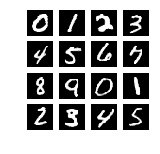

In [86]:
# train discriminator and adversarial networks
models = (generator, discriminator, adversarial)
data = (x_train, y_train)
params = (batch_size, latent_size, train_steps, num_labels, model_name)
train(models, data, params)

### Test Generator

In [87]:
def test_generator(generator, class_label=None):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    step = 0
    if class_label is None:
        num_labels = 10
        noise_class = np.eye(num_labels)[np.random.choice(num_labels, 16)]
    else:
        noise_class = np.zeros((16, 10))
        noise_class[:,class_label] = 1
        step = class_label

    plot_images(generator,
                noise_input=noise_input,
                noise_class=noise_class,
                show=True,
                step=step,
                model_name="test_outputs")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


test_outputs  labels for generated images:  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


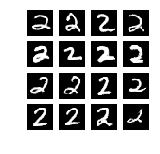

In [89]:
generator = load_model("cgan_mnist-pre-trained.h5")
class_label = 2 #  0 ~ 9
test_generator(generator, class_label)